# 4E - four rainfall params

In [4]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import json
from tensorflow.keras.models import load_model
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
## Change directory to where your scripts and data file is placed ### 
BASE_PATH = "./private/thesisFinalFiles/"
os.chdir(BASE_PATH)
print(os.path.abspath('')) 

from preprocessing_exp2 import *
from spacetimemodel import spacetimemodel

/data/private/thesisFinalFiles


In [4]:
data = pd.read_csv('vietnam_dataMatrix_modelling2.csv', header=0)
idx_dic = {}
for col in data.columns:
    idx_dic[col] = data.columns.get_loc(col)
print(idx_dic)
# import sys


{'OID_': 0, 'area': 1, 'landslide': 2, 'su_ID': 3, 'eventDate': 4, 'inventory': 5, 'reliefMax': 6, 'reliefSD': 7, 'planCurMax': 8, 'planCurvSD': 9, 'profCurMax': 10, 'profCurSD': 11, 'slopeMax': 12, 'slopeSD': 13, 'faultDiMax': 14, 'faultDiSD': 15, 'litho': 16, 'landcover': 17, 'F1_max': 18, 'F1_sum': 19, 'F2_max': 20, 'F2_sum': 21, 'F3_max': 22, 'F3_sum': 23, 'F4_max': 24, 'F4_sum': 25, 'F5_max': 26, 'F5_sum': 27, 'F6_max': 28, 'F6_sum': 29, 'F7_max': 30, 'F7_sum': 31, 'F8_max': 32, 'F8_sum': 33, 'F9_max': 34, 'F9_sum': 35, 'F10_max': 36, 'F10_sum': 37, 'F11_max': 38, 'F11_sum': 39, 'F12_max': 40, 'F12_sum': 41, 'F13_max': 42, 'F13_sum': 43, 'F14_max': 44, 'F14_sum': 45, 'F15_max': 46, 'F15_sum': 47, 'F16_max': 48, 'F16_sum': 49, 'F17_max': 50, 'F17_sum': 51, 'F18_max': 52, 'F18_sum': 53, 'F19_max': 54, 'F19_sum': 55, 'F20_max': 56, 'F20_sum': 57, 'F21_max': 58, 'F21_sum': 59, 'F22_max': 60, 'F22_sum': 61, 'F23_max': 62, 'F23_sum': 63, 'F24_max': 64, 'F24_sum': 65, 'F25_max': 66, 'F25

# Preparing rainfall data

## difference

In [5]:
# create a new DataFrame to hold the differences
diffMax_df = pd.DataFrame()
diffSum_df = pd.DataFrame()

df_max = data.iloc[:,np.arange(18,78,2)]
df_sum = data.iloc[:,np.arange(19,78,2)]

# iterate over the columns of the original DataFrame
for i in range(1, len(df_max.columns)):
    if i == 1: 
        diffMax_df[f'diff_{1}'] = 0

    # calculate the difference between this column and the previous column
    diff = df_max.iloc[:, i] - df_max.iloc[:, i-1]
    # add the difference as a new column in the diff_df DataFrame
    diffMax_df[f'diff_{i+1}'] = diff

diffMax_df['diff_1'].fillna(value=0,inplace=True)

for i in range(1, len(df_max.columns)):
    if i == 1: 
        diffSum_df[f'diff_{1}'] = 0

    # calculate the difference between this column and the previous column
    diff = df_sum.iloc[:, i] - df_sum.iloc[:, i-1]
    # add the difference as a new column in the diff_df DataFrame
    diffSum_df[f'diff_{i+1}'] = diff

diffSum_df['diff_1'].fillna(value=0,inplace=True)

# display the resulting DataFrame
diffSum_df.head(10)

diff_1    diff_2    diff_3    diff_4  diff_5  diff_6  diff_7  diff_8  \
0     0.0 -4.912625 -5.044571 -3.623366     0.0     0.0     0.0       0   
1     0.0 -2.692058 -3.221588 -2.186876     0.0     0.0     0.0       0   
2     0.0 -2.061351 -5.082273 -3.681052     0.0     0.0     0.0       0   
3     0.0  0.694908 -3.234181 -1.807860     0.0     0.0     0.0       0   
4     0.0  1.236427 -5.366603 -2.881426     0.0     0.0     0.0       0   
5     0.0  0.185836 -4.513397 -3.030466     0.0     0.0     0.0       0   
6     0.0 -3.521827 -3.073444 -2.824292     0.0     0.0     0.0       0   
7     0.0  0.613479 -1.829478 -0.979057     0.0     0.0     0.0       0   
8     0.0 -4.184481 -3.322984 -3.181882     0.0     0.0     0.0       0   
9     0.0 -2.397909 -2.187063 -1.957479     0.0     0.0     0.0       0   

    diff_9   diff_10  ...   diff_21    diff_22    diff_23   diff_24  \
0  0.00000  8.610378  ...  0.215438 -17.868099   6.540532  3.848720   
1  0.00000  4.465820  ...  0.000000 -11.827802   5.151284  2.553631   
2  0.00000  6.702496  ...  2.936230 -24.051722   9.780282  4.896277   
3  0.77267  0.967182  ...  1.940526 -12.691337   4.967809  2.395039   
4  1.54534  0.552736  ...  3.151703 -19.605534   7.085655  4.749598   
5  0.00000  5.132549  ...  3.295755 -23.070295  10.147362  1.360612   
6  0.00000  4.276779  ...  0.174945 -13.132517   6.057903  2.837765   
7  0.51876  0.518760  ...  1.301463  -6.507314   2.755542  1.786155   
8  0.00000  4.952838  ...  1.075618 -13.967517   5.718315  4.199885   
9  0.00000  2.957720  ...  0.000000  -9.188932   4.311626  1.947706   

     diff_25   diff_26    diff_27    diff_28   diff_29   diff_30  
0 -15.394880  0.979931  10.601730   9.434524 -5.588925  2.961902  
1 -10.214524  0.255634   6.639711   6.098299 -2.396875  0.772670  
2 -15.921331 -1.927152  11.025055   9.234516 -2.575861 -0.362949  
3  -8.927871 -1.367964   6.119515   6.849701 -3.851039  2.069589  
4 -15.098847 -2.233124  10.065898  10.840843 -5.675763  3.378005  
5 -10.574092 -2.114819   8.459274  11.177274 -8.156763  2.718921  
6 -11.133694  0.000000   6.849877   6.648347 -1.687277  0.000000  
7  -5.358467 -0.893078   3.572312   2.769399  0.000000  0.000000  
8 -13.321738  0.000000   6.587186   8.297678 -1.860607  0.000000  
9  -7.790820  0.000000   4.869262   4.632146 -1.187675  0.000000  

[10 rows x 30 columns]

In [6]:
# scaling sum difference 
scaler = MinMaxScaler()
df_sumDiffScaled= scaler.fit_transform(diffSum_df)
df_sumDiffScaled = pd.DataFrame(df_sumDiffScaled, columns=diffSum_df.columns)
df_sumDiffScaled.head(2)

diff_1    diff_2    diff_3    diff_4    diff_5   diff_6   diff_7    diff_8  \
0     0.0  0.279805  0.405322  0.341474  0.258568  0.80072  0.63812  0.636364   
1     0.0  0.363374  0.458661  0.383555  0.258568  0.80072  0.63812  0.636364   

     diff_9   diff_10  ...   diff_21   diff_22   diff_23   diff_24   diff_25  \
0  0.333625  0.722781  ...  0.498392  0.158549  0.596939  0.432004  0.237318   
1  0.333625  0.595618  ...  0.493465  0.283835  0.559144  0.398977  0.359422   

    diff_26   diff_27   diff_28   diff_29   diff_30  
0  0.416769  0.866596  0.685095  0.171108  0.533706  
1  0.379240  0.712965  0.621861  0.250050  0.490652  

[2 rows x 30 columns]

## cumulative sum, cumulative max 

In [7]:
df_cumSumRainfall, df_sumRainfall = cumRainfall(data, 19, 77, 'sum')
df_cumMaxRainfall, df_maxRainfall = cumRainfall(data, 18, 77, 'max')

In [10]:
rainfall_array = rainfallMatrix_4(df_maxRainfall.apply(zscore), df_sumRainfall.apply(zscore), df_cumSumRainfall.apply(zscore), df_sumDiffScaled)

# double checking that the shape matches up what we expected 
rainfall_array.shape

(2759, 30, 4)

# Preparing environmental data

In [13]:
# normalizing continuous static environmental data 
df_staticOnly = data[['litho','landcover',
                    'reliefSD', 'slopeSD', 'cosAspSD', 'sinAspSD', 'faultDiSD',
                     'reliefME', 'plancurME', 'profcurvME', 'slopeME','fautltDiME','sinAspME', 'cosAspME' ]]

catCols = ['landcover','litho']
df_staticOnlyNorm = normCols(df_staticOnly, catCols)
# df_staticOnlyNorm.head(10)

litho          object
landcover      object
reliefSD      float64
slopeSD       float64
cosAspSD      float64
sinAspSD      float64
faultDiSD     float64
reliefME      float64
plancurME     float64
profcurvME    float64
slopeME       float64
fautltDiME    float64
sinAspME      float64
cosAspME      float64
dtype: object 

Index(['reliefSD', 'slopeSD', 'cosAspSD', 'sinAspSD', 'faultDiSD', 'reliefME',
       'plancurME', 'profcurvME', 'slopeME', 'fautltDiME', 'sinAspME',
       'cosAspME'],
      dtype='object')


In [14]:
# one hot encoding the categorical variables in the df 
in_array_env, outDf = catPrep(df_staticOnlyNorm, ['litho','landcover'])

outDf.columns
len(outDf.columns)
env_array = outDf.to_numpy()
env_array.shape

landslide_array = np.array(data['landslide'], dtype=int)


You have one-hot encoded  2  categorical variables. These are: 

litho 

landcover 



# Space-Time Modelling

In [18]:
#split data first into train and test 
idx=np.arange(0,2759)
idx_tr, idx_ts = train_test_split(idx, test_size=0.25,random_state=42)
idx_tr.sort()
idx_ts.sort()

In [19]:
print(len(idx_tr))

2069


## actual modelling

In [20]:
from spacetimemodel import * 
import json
params= json.load(open('Exp4E_bay_params.json','r'))
print(params)



{'modelparam': {'gru_depth': 1, 'gru_units': 16, 'no_time_series_param': 4, 'time_series_length': 30, 'gru_activation': 'gelu', 'no_env_param': 26, 'env_depth': 6, 'env_units': 64, 'env_activation': 'tanh', 'comb_depth': 3, 'comb_units': 48, 'comb_activation': 'softmax', 'kernel_initializer': 'he_normal', 'bias_initializer': 'he_normal', 'dropout': True, 'batch_normalization': True, 'gru_dropout_ratio': 0.15, 'env_dropout_ratio': 0.15, 'comb_dropout_ratio': 0.05, 'lr': 1e-05, 'decay_steps': 1000, 'decay_rate': 0.95}, 'trainparam': {'nepoch': 200, 'ckpt': 'checkpoints/', 'batchsize': 17, 'valsplit': 0.3}}


In [25]:
# prepare model
lsmodel = spacetimemodel(params['modelparam'])
comp_lsmodel = lsmodel.preparemodel()
from trainmodelTestData import trainmodel
out = trainmodel(comp_lsmodel, xdata=[env_array[idx_tr],rainfall_array[idx_tr]], ydata=landslide_array[idx_tr], 
                 xtest=[env_array[idx_ts],rainfall_array[idx_ts]], ytest=landslide_array[idx_ts],args=params['trainparam'])
# out = final_model.fit(x=[env_array[idx_tr],rainfall_array[idx_tr]],y=landslide_array[idx_tr],
#           epochs=100, verbose=True, validation_split=0.3, batch_size=10, callbacks=[monitor, WandbMetricsLogger()])

Fit model on training data
Epoch 1/200

Epoch 1: val_loss improved from inf to 0.69150, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 30s - loss: 0.7172 - precision_1: 0.3980 - recall_1: 0.4543 - Accuracy: 0.4780 - auc: 0.4781 - f1_m: 0.4165 - val_loss: 0.6915 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_Accuracy: 0.5710 - val_auc: 0.5000 - val_f1_m: 0.0000e+00 - 30s/epoch - 249ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.69150 to 0.69135, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.7147 - precision_1: 0.3964 - recall_1: 0.4498 - Accuracy: 0.4770 - auc: 0.4815 - f1_m: 0.4080 - val_loss: 0.6913 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_Accuracy: 0.5710 - val_auc: 0.5000 - val_f1_m: 0.0000e+00 - 23s/epoch - 190ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.69135 to 0.69091, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.7148 - precision_1: 0.4015 - recall_1: 0.4418 - Accuracy: 0.4848 - auc: 0.4806 - f1_m: 0.4117 - val_loss: 0.6909 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_Accuracy: 0.5710 - val_auc: 0.4944 - val_f1_m: 0.0000e+00 - 22s/epoch - 183ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.69091 to 0.68962, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.7039 - precision_1: 0.4374 - recall_1: 0.4829 - Accuracy: 0.5181 - auc: 0.5139 - f1_m: 0.4506 - val_loss: 0.6896 - val_precision_1: 0.2500 - val_recall_1: 0.0034 - val_Accuracy: 0.5681 - val_auc: 0.5257 - val_f1_m: 0.0044 - 22s/epoch - 184ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.68962 to 0.68591, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.7024 - precision_1: 0.4295 - recall_1: 0.4658 - Accuracy: 0.5118 - auc: 0.5164 - f1_m: 0.4397 - val_loss: 0.6859 - val_precision_1: 0.5294 - val_recall_1: 0.2128 - val_Accuracy: 0.5812 - val_auc: 0.5646 - val_f1_m: 0.2493 - 22s/epoch - 183ms/step
Epoch 6/200

Epoch 6: val_loss improved from 0.68591 to 0.67900, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6987 - precision_1: 0.4434 - recall_1: 0.4692 - Accuracy: 0.5259 - auc: 0.5241 - f1_m: 0.4457 - val_loss: 0.6790 - val_precision_1: 0.5071 - val_recall_1: 0.3615 - val_Accuracy: 0.5754 - val_auc: 0.5914 - val_f1_m: 0.3597 - 23s/epoch - 187ms/step
Epoch 7/200

Epoch 7: val_loss improved from 0.67900 to 0.67114, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6951 - precision_1: 0.4406 - recall_1: 0.4703 - Accuracy: 0.5230 - auc: 0.5316 - f1_m: 0.4473 - val_loss: 0.6711 - val_precision_1: 0.5431 - val_recall_1: 0.4257 - val_Accuracy: 0.6000 - val_auc: 0.6124 - val_f1_m: 0.4026 - 22s/epoch - 182ms/step
Epoch 8/200

Epoch 8: val_loss improved from 0.67114 to 0.66551, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6857 - precision_1: 0.4667 - recall_1: 0.4886 - Accuracy: 0.5471 - auc: 0.5628 - f1_m: 0.4654 - val_loss: 0.6655 - val_precision_1: 0.5422 - val_recall_1: 0.4561 - val_Accuracy: 0.6014 - val_auc: 0.6283 - val_f1_m: 0.4268 - 23s/epoch - 188ms/step
Epoch 9/200

Epoch 9: val_loss improved from 0.66551 to 0.65959, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6933 - precision_1: 0.4438 - recall_1: 0.4600 - Accuracy: 0.5273 - auc: 0.5374 - f1_m: 0.4387 - val_loss: 0.6596 - val_precision_1: 0.5569 - val_recall_1: 0.4797 - val_Accuracy: 0.6130 - val_auc: 0.6463 - val_f1_m: 0.4378 - 23s/epoch - 191ms/step
Epoch 10/200

Epoch 10: val_loss improved from 0.65959 to 0.65516, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6825 - precision_1: 0.4816 - recall_1: 0.5091 - Accuracy: 0.5602 - auc: 0.5774 - f1_m: 0.4862 - val_loss: 0.6552 - val_precision_1: 0.5569 - val_recall_1: 0.4797 - val_Accuracy: 0.6130 - val_auc: 0.6547 - val_f1_m: 0.4443 - 22s/epoch - 181ms/step
Epoch 11/200

Epoch 11: val_loss improved from 0.65516 to 0.65041, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6801 - precision_1: 0.4962 - recall_1: 0.5205 - Accuracy: 0.5732 - auc: 0.5858 - f1_m: 0.4965 - val_loss: 0.6504 - val_precision_1: 0.5725 - val_recall_1: 0.4932 - val_Accuracy: 0.6246 - val_auc: 0.6647 - val_f1_m: 0.4403 - 22s/epoch - 183ms/step
Epoch 12/200

Epoch 12: val_loss improved from 0.65041 to 0.64732, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6769 - precision_1: 0.4994 - recall_1: 0.5171 - Accuracy: 0.5761 - auc: 0.5924 - f1_m: 0.4962 - val_loss: 0.6473 - val_precision_1: 0.5830 - val_recall_1: 0.5338 - val_Accuracy: 0.6362 - val_auc: 0.6702 - val_f1_m: 0.4660 - 22s/epoch - 180ms/step
Epoch 13/200

Epoch 13: val_loss improved from 0.64732 to 0.64470, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6774 - precision_1: 0.5022 - recall_1: 0.5183 - Accuracy: 0.5785 - auc: 0.5902 - f1_m: 0.5023 - val_loss: 0.6447 - val_precision_1: 0.5858 - val_recall_1: 0.5304 - val_Accuracy: 0.6377 - val_auc: 0.6755 - val_f1_m: 0.4600 - 22s/epoch - 180ms/step
Epoch 14/200

Epoch 14: val_loss improved from 0.64470 to 0.64039, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6715 - precision_1: 0.5039 - recall_1: 0.5137 - Accuracy: 0.5800 - auc: 0.6063 - f1_m: 0.5004 - val_loss: 0.6404 - val_precision_1: 0.5880 - val_recall_1: 0.5304 - val_Accuracy: 0.6391 - val_auc: 0.6833 - val_f1_m: 0.4623 - 23s/epoch - 190ms/step
Epoch 15/200

Epoch 15: val_loss improved from 0.64039 to 0.63843, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6710 - precision_1: 0.5168 - recall_1: 0.5263 - Accuracy: 0.5911 - auc: 0.6101 - f1_m: 0.5104 - val_loss: 0.6384 - val_precision_1: 0.5943 - val_recall_1: 0.5642 - val_Accuracy: 0.6478 - val_auc: 0.6878 - val_f1_m: 0.4849 - 22s/epoch - 183ms/step
Epoch 16/200

Epoch 16: val_loss improved from 0.63843 to 0.63550, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6762 - precision_1: 0.4971 - recall_1: 0.4909 - Accuracy: 0.5742 - auc: 0.5875 - f1_m: 0.4829 - val_loss: 0.6355 - val_precision_1: 0.5964 - val_recall_1: 0.5642 - val_Accuracy: 0.6493 - val_auc: 0.6909 - val_f1_m: 0.4842 - 22s/epoch - 182ms/step
Epoch 17/200

Epoch 17: val_loss improved from 0.63550 to 0.63239, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6657 - precision_1: 0.5319 - recall_1: 0.5228 - Accuracy: 0.6032 - auc: 0.6215 - f1_m: 0.5110 - val_loss: 0.6324 - val_precision_1: 0.6051 - val_recall_1: 0.5642 - val_Accuracy: 0.6551 - val_auc: 0.6952 - val_f1_m: 0.4943 - 23s/epoch - 187ms/step
Epoch 18/200

Epoch 18: val_loss improved from 0.63239 to 0.62972, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6655 - precision_1: 0.5249 - recall_1: 0.5046 - Accuracy: 0.5969 - auc: 0.6194 - f1_m: 0.5047 - val_loss: 0.6297 - val_precision_1: 0.6043 - val_recall_1: 0.5676 - val_Accuracy: 0.6551 - val_auc: 0.6994 - val_f1_m: 0.4866 - 22s/epoch - 180ms/step
Epoch 19/200

Epoch 19: val_loss improved from 0.62972 to 0.62739, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6633 - precision_1: 0.5360 - recall_1: 0.5354 - Accuracy: 0.6071 - auc: 0.6267 - f1_m: 0.5196 - val_loss: 0.6274 - val_precision_1: 0.6092 - val_recall_1: 0.5845 - val_Accuracy: 0.6609 - val_auc: 0.7027 - val_f1_m: 0.4972 - 23s/epoch - 191ms/step
Epoch 20/200

Epoch 20: val_loss improved from 0.62739 to 0.62580, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6629 - precision_1: 0.5358 - recall_1: 0.5297 - Accuracy: 0.6066 - auc: 0.6280 - f1_m: 0.5260 - val_loss: 0.6258 - val_precision_1: 0.5979 - val_recall_1: 0.5878 - val_Accuracy: 0.6536 - val_auc: 0.7049 - val_f1_m: 0.4925 - 22s/epoch - 180ms/step
Epoch 21/200

Epoch 21: val_loss improved from 0.62580 to 0.62363, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6647 - precision_1: 0.5197 - recall_1: 0.4977 - Accuracy: 0.5926 - auc: 0.6172 - f1_m: 0.4947 - val_loss: 0.6236 - val_precision_1: 0.6119 - val_recall_1: 0.5912 - val_Accuracy: 0.6638 - val_auc: 0.7075 - val_f1_m: 0.5049 - 23s/epoch - 185ms/step
Epoch 22/200

Epoch 22: val_loss improved from 0.62363 to 0.62221, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6595 - precision_1: 0.5257 - recall_1: 0.5137 - Accuracy: 0.5979 - auc: 0.6334 - f1_m: 0.5077 - val_loss: 0.6222 - val_precision_1: 0.6151 - val_recall_1: 0.5777 - val_Accuracy: 0.6638 - val_auc: 0.7094 - val_f1_m: 0.4930 - 23s/epoch - 189ms/step
Epoch 23/200

Epoch 23: val_loss improved from 0.62221 to 0.62014, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6630 - precision_1: 0.5339 - recall_1: 0.5217 - Accuracy: 0.6046 - auc: 0.6274 - f1_m: 0.5125 - val_loss: 0.6201 - val_precision_1: 0.6165 - val_recall_1: 0.5811 - val_Accuracy: 0.6652 - val_auc: 0.7113 - val_f1_m: 0.4962 - 22s/epoch - 179ms/step
Epoch 24/200

Epoch 24: val_loss improved from 0.62014 to 0.61878, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6604 - precision_1: 0.5314 - recall_1: 0.5126 - Accuracy: 0.6022 - auc: 0.6281 - f1_m: 0.5106 - val_loss: 0.6188 - val_precision_1: 0.6021 - val_recall_1: 0.5777 - val_Accuracy: 0.6551 - val_auc: 0.7123 - val_f1_m: 0.4885 - 23s/epoch - 188ms/step
Epoch 25/200

Epoch 25: val_loss improved from 0.61878 to 0.61672, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6577 - precision_1: 0.5410 - recall_1: 0.5274 - Accuracy: 0.6104 - auc: 0.6400 - f1_m: 0.5270 - val_loss: 0.6167 - val_precision_1: 0.6151 - val_recall_1: 0.5777 - val_Accuracy: 0.6638 - val_auc: 0.7152 - val_f1_m: 0.4934 - 23s/epoch - 188ms/step
Epoch 26/200

Epoch 26: val_loss improved from 0.61672 to 0.61538, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6583 - precision_1: 0.5434 - recall_1: 0.5148 - Accuracy: 0.6114 - auc: 0.6327 - f1_m: 0.5154 - val_loss: 0.6154 - val_precision_1: 0.6070 - val_recall_1: 0.5845 - val_Accuracy: 0.6594 - val_auc: 0.7170 - val_f1_m: 0.4947 - 22s/epoch - 178ms/step
Epoch 27/200

Epoch 27: val_loss improved from 0.61538 to 0.61457, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 24s - loss: 0.6546 - precision_1: 0.5531 - recall_1: 0.5354 - Accuracy: 0.6201 - auc: 0.6434 - f1_m: 0.5280 - val_loss: 0.6146 - val_precision_1: 0.6048 - val_recall_1: 0.5946 - val_Accuracy: 0.6594 - val_auc: 0.7175 - val_f1_m: 0.4980 - 24s/epoch - 193ms/step
Epoch 28/200

Epoch 28: val_loss improved from 0.61457 to 0.61211, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6502 - precision_1: 0.5571 - recall_1: 0.5342 - Accuracy: 0.6230 - auc: 0.6517 - f1_m: 0.5331 - val_loss: 0.6121 - val_precision_1: 0.6159 - val_recall_1: 0.6014 - val_Accuracy: 0.6681 - val_auc: 0.7207 - val_f1_m: 0.5038 - 22s/epoch - 184ms/step
Epoch 29/200

Epoch 29: val_loss improved from 0.61211 to 0.61125, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 24s - loss: 0.6564 - precision_1: 0.5465 - recall_1: 0.5228 - Accuracy: 0.6143 - auc: 0.6437 - f1_m: 0.5258 - val_loss: 0.6113 - val_precision_1: 0.6090 - val_recall_1: 0.5946 - val_Accuracy: 0.6623 - val_auc: 0.7208 - val_f1_m: 0.4991 - 24s/epoch - 195ms/step
Epoch 30/200

Epoch 30: val_loss improved from 0.61125 to 0.61045, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6599 - precision_1: 0.5278 - recall_1: 0.4989 - Accuracy: 0.5988 - auc: 0.6288 - f1_m: 0.5004 - val_loss: 0.6104 - val_precision_1: 0.6096 - val_recall_1: 0.6014 - val_Accuracy: 0.6638 - val_auc: 0.7220 - val_f1_m: 0.5016 - 23s/epoch - 192ms/step
Epoch 31/200

Epoch 31: val_loss improved from 0.61045 to 0.60924, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6540 - precision_1: 0.5443 - recall_1: 0.5331 - Accuracy: 0.6133 - auc: 0.6440 - f1_m: 0.5278 - val_loss: 0.6092 - val_precision_1: 0.6094 - val_recall_1: 0.6115 - val_Accuracy: 0.6652 - val_auc: 0.7239 - val_f1_m: 0.5049 - 22s/epoch - 180ms/step
Epoch 32/200

Epoch 32: val_loss improved from 0.60924 to 0.60802, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6546 - precision_1: 0.5305 - recall_1: 0.5160 - Accuracy: 0.6017 - auc: 0.6393 - f1_m: 0.5134 - val_loss: 0.6080 - val_precision_1: 0.6156 - val_recall_1: 0.6115 - val_Accuracy: 0.6696 - val_auc: 0.7253 - val_f1_m: 0.5086 - 23s/epoch - 187ms/step
Epoch 33/200

Epoch 33: val_loss improved from 0.60802 to 0.60683, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6513 - precision_1: 0.5478 - recall_1: 0.5228 - Accuracy: 0.6153 - auc: 0.6482 - f1_m: 0.5250 - val_loss: 0.6068 - val_precision_1: 0.6212 - val_recall_1: 0.6149 - val_Accuracy: 0.6739 - val_auc: 0.7267 - val_f1_m: 0.5107 - 22s/epoch - 182ms/step
Epoch 34/200

Epoch 34: val_loss improved from 0.60683 to 0.60674, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6496 - precision_1: 0.5652 - recall_1: 0.5491 - Accuracy: 0.6303 - auc: 0.6536 - f1_m: 0.5457 - val_loss: 0.6067 - val_precision_1: 0.6109 - val_recall_1: 0.6047 - val_Accuracy: 0.6652 - val_auc: 0.7261 - val_f1_m: 0.4962 - 22s/epoch - 181ms/step
Epoch 35/200

Epoch 35: val_loss improved from 0.60674 to 0.60557, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6464 - precision_1: 0.5592 - recall_1: 0.5285 - Accuracy: 0.6240 - auc: 0.6608 - f1_m: 0.5351 - val_loss: 0.6056 - val_precision_1: 0.6199 - val_recall_1: 0.6115 - val_Accuracy: 0.6725 - val_auc: 0.7272 - val_f1_m: 0.5087 - 22s/epoch - 183ms/step
Epoch 36/200

Epoch 36: val_loss improved from 0.60557 to 0.60440, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6499 - precision_1: 0.5417 - recall_1: 0.5114 - Accuracy: 0.6100 - auc: 0.6486 - f1_m: 0.5157 - val_loss: 0.6044 - val_precision_1: 0.6156 - val_recall_1: 0.6115 - val_Accuracy: 0.6696 - val_auc: 0.7291 - val_f1_m: 0.5010 - 21s/epoch - 176ms/step
Epoch 37/200

Epoch 37: val_loss improved from 0.60440 to 0.60361, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6442 - precision_1: 0.5674 - recall_1: 0.5331 - Accuracy: 0.6303 - auc: 0.6634 - f1_m: 0.5388 - val_loss: 0.6036 - val_precision_1: 0.6128 - val_recall_1: 0.6149 - val_Accuracy: 0.6681 - val_auc: 0.7301 - val_f1_m: 0.5018 - 22s/epoch - 181ms/step
Epoch 38/200

Epoch 38: val_loss improved from 0.60361 to 0.60223, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6439 - precision_1: 0.5732 - recall_1: 0.5320 - Accuracy: 0.6341 - auc: 0.6648 - f1_m: 0.5421 - val_loss: 0.6022 - val_precision_1: 0.6177 - val_recall_1: 0.6115 - val_Accuracy: 0.6710 - val_auc: 0.7309 - val_f1_m: 0.5034 - 23s/epoch - 186ms/step
Epoch 39/200

Epoch 39: val_loss improved from 0.60223 to 0.60197, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6416 - precision_1: 0.5637 - recall_1: 0.5251 - Accuracy: 0.6269 - auc: 0.6656 - f1_m: 0.5343 - val_loss: 0.6020 - val_precision_1: 0.6182 - val_recall_1: 0.6182 - val_Accuracy: 0.6725 - val_auc: 0.7310 - val_f1_m: 0.5102 - 21s/epoch - 175ms/step
Epoch 40/200

Epoch 40: val_loss improved from 0.60197 to 0.60101, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6417 - precision_1: 0.5696 - recall_1: 0.5514 - Accuracy: 0.6336 - auc: 0.6693 - f1_m: 0.5468 - val_loss: 0.6010 - val_precision_1: 0.6174 - val_recall_1: 0.6216 - val_Accuracy: 0.6725 - val_auc: 0.7321 - val_f1_m: 0.5104 - 23s/epoch - 187ms/step
Epoch 41/200

Epoch 41: val_loss improved from 0.60101 to 0.60065, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6453 - precision_1: 0.5615 - recall_1: 0.5263 - Accuracy: 0.6254 - auc: 0.6598 - f1_m: 0.5325 - val_loss: 0.6007 - val_precision_1: 0.6154 - val_recall_1: 0.6216 - val_Accuracy: 0.6710 - val_auc: 0.7322 - val_f1_m: 0.5095 - 23s/epoch - 188ms/step
Epoch 42/200

Epoch 42: val_loss improved from 0.60065 to 0.59985, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6427 - precision_1: 0.5663 - recall_1: 0.5365 - Accuracy: 0.6298 - auc: 0.6656 - f1_m: 0.5413 - val_loss: 0.5999 - val_precision_1: 0.6162 - val_recall_1: 0.6182 - val_Accuracy: 0.6710 - val_auc: 0.7329 - val_f1_m: 0.5092 - 22s/epoch - 178ms/step
Epoch 43/200

Epoch 43: val_loss improved from 0.59985 to 0.59918, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6388 - precision_1: 0.5778 - recall_1: 0.5342 - Accuracy: 0.6375 - auc: 0.6738 - f1_m: 0.5411 - val_loss: 0.5992 - val_precision_1: 0.6182 - val_recall_1: 0.6182 - val_Accuracy: 0.6725 - val_auc: 0.7337 - val_f1_m: 0.5100 - 23s/epoch - 185ms/step
Epoch 44/200

Epoch 44: val_loss improved from 0.59918 to 0.59789, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6494 - precision_1: 0.5483 - recall_1: 0.5183 - Accuracy: 0.6153 - auc: 0.6499 - f1_m: 0.5200 - val_loss: 0.5979 - val_precision_1: 0.6182 - val_recall_1: 0.6182 - val_Accuracy: 0.6725 - val_auc: 0.7343 - val_f1_m: 0.5097 - 23s/epoch - 185ms/step
Epoch 45/200

Epoch 45: val_loss improved from 0.59789 to 0.59738, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6427 - precision_1: 0.5648 - recall_1: 0.5320 - Accuracy: 0.6283 - auc: 0.6653 - f1_m: 0.5363 - val_loss: 0.5974 - val_precision_1: 0.6246 - val_recall_1: 0.6182 - val_Accuracy: 0.6768 - val_auc: 0.7355 - val_f1_m: 0.5133 - 23s/epoch - 189ms/step
Epoch 46/200

Epoch 46: val_loss improved from 0.59738 to 0.59727, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 24s - loss: 0.6354 - precision_1: 0.5813 - recall_1: 0.5468 - Accuracy: 0.6414 - auc: 0.6775 - f1_m: 0.5537 - val_loss: 0.5973 - val_precision_1: 0.6246 - val_recall_1: 0.6182 - val_Accuracy: 0.6768 - val_auc: 0.7361 - val_f1_m: 0.5137 - 24s/epoch - 194ms/step
Epoch 47/200

Epoch 47: val_loss improved from 0.59727 to 0.59642, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6425 - precision_1: 0.5825 - recall_1: 0.5400 - Accuracy: 0.6414 - auc: 0.6675 - f1_m: 0.5482 - val_loss: 0.5964 - val_precision_1: 0.6203 - val_recall_1: 0.6182 - val_Accuracy: 0.6739 - val_auc: 0.7360 - val_f1_m: 0.5110 - 22s/epoch - 181ms/step
Epoch 48/200

Epoch 48: val_loss improved from 0.59642 to 0.59582, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6403 - precision_1: 0.5697 - recall_1: 0.5365 - Accuracy: 0.6322 - auc: 0.6674 - f1_m: 0.5396 - val_loss: 0.5958 - val_precision_1: 0.6250 - val_recall_1: 0.6250 - val_Accuracy: 0.6783 - val_auc: 0.7365 - val_f1_m: 0.5163 - 23s/epoch - 185ms/step
Epoch 49/200

Epoch 49: val_loss improved from 0.59582 to 0.59505, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6410 - precision_1: 0.5723 - recall_1: 0.5468 - Accuracy: 0.6351 - auc: 0.6684 - f1_m: 0.5482 - val_loss: 0.5950 - val_precision_1: 0.6250 - val_recall_1: 0.6250 - val_Accuracy: 0.6783 - val_auc: 0.7369 - val_f1_m: 0.5163 - 23s/epoch - 185ms/step
Epoch 50/200

Epoch 50: val_loss improved from 0.59505 to 0.59499, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6316 - precision_1: 0.5828 - recall_1: 0.5422 - Accuracy: 0.6419 - auc: 0.6850 - f1_m: 0.5519 - val_loss: 0.5950 - val_precision_1: 0.6208 - val_recall_1: 0.6250 - val_Accuracy: 0.6754 - val_auc: 0.7369 - val_f1_m: 0.5140 - 23s/epoch - 185ms/step
Epoch 51/200

Epoch 51: val_loss improved from 0.59499 to 0.59443, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6292 - precision_1: 0.5983 - recall_1: 0.5559 - Accuracy: 0.6539 - auc: 0.6882 - f1_m: 0.5673 - val_loss: 0.5944 - val_precision_1: 0.6250 - val_recall_1: 0.6250 - val_Accuracy: 0.6783 - val_auc: 0.7376 - val_f1_m: 0.5163 - 23s/epoch - 190ms/step
Epoch 52/200

Epoch 52: val_loss improved from 0.59443 to 0.59382, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6348 - precision_1: 0.5671 - recall_1: 0.5308 - Accuracy: 0.6298 - auc: 0.6767 - f1_m: 0.5357 - val_loss: 0.5938 - val_precision_1: 0.6246 - val_recall_1: 0.6182 - val_Accuracy: 0.6768 - val_auc: 0.7387 - val_f1_m: 0.5116 - 22s/epoch - 184ms/step
Epoch 53/200

Epoch 53: val_loss improved from 0.59382 to 0.59322, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6318 - precision_1: 0.5791 - recall_1: 0.5559 - Accuracy: 0.6409 - auc: 0.6823 - f1_m: 0.5606 - val_loss: 0.5932 - val_precision_1: 0.6267 - val_recall_1: 0.6182 - val_Accuracy: 0.6783 - val_auc: 0.7384 - val_f1_m: 0.5110 - 22s/epoch - 183ms/step
Epoch 54/200

Epoch 54: val_loss improved from 0.59322 to 0.59243, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6396 - precision_1: 0.5742 - recall_1: 0.5479 - Accuracy: 0.6365 - auc: 0.6683 - f1_m: 0.5534 - val_loss: 0.5924 - val_precision_1: 0.6275 - val_recall_1: 0.6318 - val_Accuracy: 0.6812 - val_auc: 0.7398 - val_f1_m: 0.5191 - 23s/epoch - 189ms/step
Epoch 55/200

Epoch 55: val_loss improved from 0.59243 to 0.59229, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6389 - precision_1: 0.5762 - recall_1: 0.5479 - Accuracy: 0.6380 - auc: 0.6726 - f1_m: 0.5520 - val_loss: 0.5923 - val_precision_1: 0.6296 - val_recall_1: 0.6318 - val_Accuracy: 0.6826 - val_auc: 0.7401 - val_f1_m: 0.5208 - 22s/epoch - 177ms/step
Epoch 56/200

Epoch 56: val_loss improved from 0.59229 to 0.59157, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6282 - precision_1: 0.6000 - recall_1: 0.5616 - Accuracy: 0.6559 - auc: 0.6917 - f1_m: 0.5750 - val_loss: 0.5916 - val_precision_1: 0.6280 - val_recall_1: 0.6216 - val_Accuracy: 0.6797 - val_auc: 0.7411 - val_f1_m: 0.5110 - 23s/epoch - 190ms/step
Epoch 57/200

Epoch 57: val_loss did not improve from 0.59157
122/122 - 14s - loss: 0.6307 - precision_1: 0.5953 - recall_1: 0.5491 - Accuracy: 0.6510 - auc: 0.6844 - f1_m: 0.5596 - val_loss: 0.5917 - val_precision_1: 0.6336 - val_recall_1: 0.6250 - val_Accuracy: 0.6841 - val_auc: 0.7405 - val_f1_m: 0.5189 - 14s/epoch - 113ms/step
Epoch 58/200

Epoch 58: val_loss improved from 0.59157 to 0.59115, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6408 - precision_1: 0.5596 - recall_1: 0.5251 - Accuracy: 0.6240 - auc: 0.6638 - f1_m: 0.5330 - val_loss: 0.5912 - val_precision_1: 0.6284 - val_recall_1: 0.6284 - val_Accuracy: 0.6812 - val_auc: 0.7412 - val_f1_m: 0.5186 - 23s/epoch - 190ms/step
Epoch 59/200

Epoch 59: val_loss did not improve from 0.59115
122/122 - 14s - loss: 0.6279 - precision_1: 0.5859 - recall_1: 0.5491 - Accuracy: 0.6448 - auc: 0.6885 - f1_m: 0.5559 - val_loss: 0.5914 - val_precision_1: 0.6280 - val_recall_1: 0.6216 - val_Accuracy: 0.6797 - val_auc: 0.7416 - val_f1_m: 0.5111 - 14s/epoch - 112ms/step
Epoch 60/200

Epoch 60: val_loss improved from 0.59115 to 0.59052, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6288 - precision_1: 0.5896 - recall_1: 0.5411 - Accuracy: 0.6462 - auc: 0.6893 - f1_m: 0.5581 - val_loss: 0.5905 - val_precision_1: 0.6336 - val_recall_1: 0.6250 - val_Accuracy: 0.6841 - val_auc: 0.7424 - val_f1_m: 0.5145 - 21s/epoch - 174ms/step
Epoch 61/200

Epoch 61: val_loss improved from 0.59052 to 0.58973, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6360 - precision_1: 0.5836 - recall_1: 0.5377 - Accuracy: 0.6419 - auc: 0.6771 - f1_m: 0.5498 - val_loss: 0.5897 - val_precision_1: 0.6339 - val_recall_1: 0.6318 - val_Accuracy: 0.6855 - val_auc: 0.7429 - val_f1_m: 0.5165 - 23s/epoch - 193ms/step
Epoch 62/200

Epoch 62: val_loss improved from 0.58973 to 0.58960, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6266 - precision_1: 0.6075 - recall_1: 0.5582 - Accuracy: 0.6602 - auc: 0.6925 - f1_m: 0.5721 - val_loss: 0.5896 - val_precision_1: 0.6314 - val_recall_1: 0.6250 - val_Accuracy: 0.6826 - val_auc: 0.7431 - val_f1_m: 0.5139 - 22s/epoch - 178ms/step
Epoch 63/200

Epoch 63: val_loss did not improve from 0.58960
122/122 - 14s - loss: 0.6228 - precision_1: 0.5917 - recall_1: 0.5559 - Accuracy: 0.6496 - auc: 0.6985 - f1_m: 0.5657 - val_loss: 0.5898 - val_precision_1: 0.6327 - val_recall_1: 0.6284 - val_Accuracy: 0.6841 - val_auc: 0.7419 - val_f1_m: 0.5186 - 14s/epoch - 114ms/step
Epoch 64/200

Epoch 64: val_loss improved from 0.58960 to 0.58929, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6338 - precision_1: 0.5700 - recall_1: 0.5388 - Accuracy: 0.6327 - auc: 0.6794 - f1_m: 0.5421 - val_loss: 0.5893 - val_precision_1: 0.6323 - val_recall_1: 0.6216 - val_Accuracy: 0.6826 - val_auc: 0.7432 - val_f1_m: 0.5084 - 23s/epoch - 185ms/step
Epoch 65/200

Epoch 65: val_loss improved from 0.58929 to 0.58892, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6259 - precision_1: 0.5861 - recall_1: 0.5400 - Accuracy: 0.6438 - auc: 0.6911 - f1_m: 0.5540 - val_loss: 0.5889 - val_precision_1: 0.6336 - val_recall_1: 0.6250 - val_Accuracy: 0.6841 - val_auc: 0.7438 - val_f1_m: 0.5145 - 22s/epoch - 182ms/step
Epoch 66/200

Epoch 66: val_loss improved from 0.58892 to 0.58806, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6347 - precision_1: 0.5821 - recall_1: 0.5502 - Accuracy: 0.6423 - auc: 0.6762 - f1_m: 0.5562 - val_loss: 0.5881 - val_precision_1: 0.6373 - val_recall_1: 0.6351 - val_Accuracy: 0.6884 - val_auc: 0.7454 - val_f1_m: 0.5184 - 22s/epoch - 180ms/step
Epoch 67/200

Epoch 67: val_loss improved from 0.58806 to 0.58799, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6270 - precision_1: 0.5832 - recall_1: 0.5400 - Accuracy: 0.6419 - auc: 0.6878 - f1_m: 0.5518 - val_loss: 0.5880 - val_precision_1: 0.6373 - val_recall_1: 0.6351 - val_Accuracy: 0.6884 - val_auc: 0.7452 - val_f1_m: 0.5184 - 22s/epoch - 182ms/step
Epoch 68/200

Epoch 68: val_loss improved from 0.58799 to 0.58744, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6238 - precision_1: 0.5817 - recall_1: 0.5365 - Accuracy: 0.6404 - auc: 0.6965 - f1_m: 0.5492 - val_loss: 0.5874 - val_precision_1: 0.6404 - val_recall_1: 0.6318 - val_Accuracy: 0.6899 - val_auc: 0.7462 - val_f1_m: 0.5185 - 22s/epoch - 180ms/step
Epoch 69/200

Epoch 69: val_loss improved from 0.58744 to 0.58685, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6185 - precision_1: 0.5976 - recall_1: 0.5662 - Accuracy: 0.6549 - auc: 0.7045 - f1_m: 0.5762 - val_loss: 0.5869 - val_precision_1: 0.6361 - val_recall_1: 0.6318 - val_Accuracy: 0.6870 - val_auc: 0.7465 - val_f1_m: 0.5171 - 23s/epoch - 188ms/step
Epoch 70/200

Epoch 70: val_loss did not improve from 0.58685
122/122 - 13s - loss: 0.6298 - precision_1: 0.5833 - recall_1: 0.5434 - Accuracy: 0.6423 - auc: 0.6863 - f1_m: 0.5542 - val_loss: 0.5869 - val_precision_1: 0.6373 - val_recall_1: 0.6351 - val_Accuracy: 0.6884 - val_auc: 0.7463 - val_f1_m: 0.5184 - 13s/epoch - 110ms/step
Epoch 71/200

Epoch 71: val_loss did not improve from 0.58685
122/122 - 14s - loss: 0.6261 - precision_1: 0.5905 - recall_1: 0.5514 - Accuracy: 0.6481 - auc: 0.6921 - f1_m: 0.5572 - val_loss: 0.5870 - val_precision_1: 0.6382 - val_recall_1: 0.6318 - val_Accuracy: 0.6884 - val_auc: 0.7460 - val_f1_m: 0.5128 - 14s/epoch - 112ms/step
Epoch 72/200

Epoch 72: val_loss improved from 0.58685 to 0.586

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6263 - precision_1: 0.5818 - recall_1: 0.5400 - Accuracy: 0.6409 - auc: 0.6888 - f1_m: 0.5469 - val_loss: 0.5868 - val_precision_1: 0.6407 - val_recall_1: 0.6385 - val_Accuracy: 0.6913 - val_auc: 0.7465 - val_f1_m: 0.5208 - 23s/epoch - 191ms/step
Epoch 73/200

Epoch 73: val_loss improved from 0.58683 to 0.58622, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6251 - precision_1: 0.5877 - recall_1: 0.5434 - Accuracy: 0.6452 - auc: 0.6967 - f1_m: 0.5565 - val_loss: 0.5862 - val_precision_1: 0.6407 - val_recall_1: 0.6385 - val_Accuracy: 0.6913 - val_auc: 0.7473 - val_f1_m: 0.5206 - 21s/epoch - 175ms/step
Epoch 74/200

Epoch 74: val_loss did not improve from 0.58622
122/122 - 14s - loss: 0.6275 - precision_1: 0.5787 - recall_1: 0.5331 - Accuracy: 0.6380 - auc: 0.6878 - f1_m: 0.5442 - val_loss: 0.5864 - val_precision_1: 0.6438 - val_recall_1: 0.6351 - val_Accuracy: 0.6928 - val_auc: 0.7473 - val_f1_m: 0.5209 - 14s/epoch - 112ms/step
Epoch 75/200

Epoch 75: val_loss improved from 0.58622 to 0.58546, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 24s - loss: 0.6314 - precision_1: 0.5785 - recall_1: 0.5342 - Accuracy: 0.6380 - auc: 0.6825 - f1_m: 0.5467 - val_loss: 0.5855 - val_precision_1: 0.6429 - val_recall_1: 0.6385 - val_Accuracy: 0.6928 - val_auc: 0.7481 - val_f1_m: 0.5218 - 24s/epoch - 194ms/step
Epoch 76/200

Epoch 76: val_loss improved from 0.58546 to 0.58535, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6207 - precision_1: 0.5977 - recall_1: 0.5445 - Accuracy: 0.6520 - auc: 0.7020 - f1_m: 0.5611 - val_loss: 0.5854 - val_precision_1: 0.6451 - val_recall_1: 0.6385 - val_Accuracy: 0.6942 - val_auc: 0.7479 - val_f1_m: 0.5222 - 22s/epoch - 183ms/step
Epoch 77/200

Epoch 77: val_loss improved from 0.58535 to 0.58473, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6325 - precision_1: 0.5814 - recall_1: 0.5422 - Accuracy: 0.6409 - auc: 0.6813 - f1_m: 0.5526 - val_loss: 0.5847 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7489 - val_f1_m: 0.5241 - 22s/epoch - 179ms/step
Epoch 78/200

Epoch 78: val_loss improved from 0.58473 to 0.58461, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6199 - precision_1: 0.5889 - recall_1: 0.5445 - Accuracy: 0.6462 - auc: 0.7008 - f1_m: 0.5566 - val_loss: 0.5846 - val_precision_1: 0.6429 - val_recall_1: 0.6385 - val_Accuracy: 0.6928 - val_auc: 0.7494 - val_f1_m: 0.5217 - 23s/epoch - 184ms/step
Epoch 79/200

Epoch 79: val_loss improved from 0.58461 to 0.58402, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6229 - precision_1: 0.5906 - recall_1: 0.5582 - Accuracy: 0.6491 - auc: 0.6954 - f1_m: 0.5663 - val_loss: 0.5840 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7503 - val_f1_m: 0.5241 - 22s/epoch - 182ms/step
Epoch 80/200

Epoch 80: val_loss improved from 0.58402 to 0.58332, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6215 - precision_1: 0.5988 - recall_1: 0.5639 - Accuracy: 0.6554 - auc: 0.6985 - f1_m: 0.5703 - val_loss: 0.5833 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7509 - val_f1_m: 0.5241 - 23s/epoch - 185ms/step
Epoch 81/200

Epoch 81: val_loss improved from 0.58332 to 0.58271, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6240 - precision_1: 0.5957 - recall_1: 0.5434 - Accuracy: 0.6506 - auc: 0.6943 - f1_m: 0.5515 - val_loss: 0.5827 - val_precision_1: 0.6463 - val_recall_1: 0.6419 - val_Accuracy: 0.6957 - val_auc: 0.7513 - val_f1_m: 0.5272 - 22s/epoch - 183ms/step
Epoch 82/200

Epoch 82: val_loss did not improve from 0.58271
122/122 - 13s - loss: 0.6263 - precision_1: 0.5836 - recall_1: 0.5377 - Accuracy: 0.6419 - auc: 0.6912 - f1_m: 0.5501 - val_loss: 0.5831 - val_precision_1: 0.6429 - val_recall_1: 0.6385 - val_Accuracy: 0.6928 - val_auc: 0.7508 - val_f1_m: 0.5218 - 13s/epoch - 110ms/step
Epoch 83/200

Epoch 83: val_loss improved from 0.58271 to 0.58232, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6215 - precision_1: 0.5960 - recall_1: 0.5491 - Accuracy: 0.6515 - auc: 0.6988 - f1_m: 0.5643 - val_loss: 0.5823 - val_precision_1: 0.6473 - val_recall_1: 0.6385 - val_Accuracy: 0.6957 - val_auc: 0.7520 - val_f1_m: 0.5232 - 21s/epoch - 175ms/step
Epoch 84/200

Epoch 84: val_loss improved from 0.58232 to 0.58192, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6227 - precision_1: 0.5908 - recall_1: 0.5422 - Accuracy: 0.6472 - auc: 0.6972 - f1_m: 0.5557 - val_loss: 0.5819 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7521 - val_f1_m: 0.5241 - 23s/epoch - 192ms/step
Epoch 85/200

Epoch 85: val_loss did not improve from 0.58192
122/122 - 14s - loss: 0.6266 - precision_1: 0.5854 - recall_1: 0.5320 - Accuracy: 0.6423 - auc: 0.6908 - f1_m: 0.5479 - val_loss: 0.5819 - val_precision_1: 0.6463 - val_recall_1: 0.6419 - val_Accuracy: 0.6957 - val_auc: 0.7519 - val_f1_m: 0.5264 - 14s/epoch - 113ms/step
Epoch 86/200

Epoch 86: val_loss improved from 0.58192 to 0.58105, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6201 - precision_1: 0.5885 - recall_1: 0.5502 - Accuracy: 0.6467 - auc: 0.7002 - f1_m: 0.5570 - val_loss: 0.5810 - val_precision_1: 0.6485 - val_recall_1: 0.6419 - val_Accuracy: 0.6971 - val_auc: 0.7530 - val_f1_m: 0.5315 - 23s/epoch - 185ms/step
Epoch 87/200

Epoch 87: val_loss did not improve from 0.58105
122/122 - 14s - loss: 0.6203 - precision_1: 0.5990 - recall_1: 0.5559 - Accuracy: 0.6544 - auc: 0.7004 - f1_m: 0.5687 - val_loss: 0.5812 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7530 - val_f1_m: 0.5244 - 14s/epoch - 114ms/step
Epoch 88/200

Epoch 88: val_loss improved from 0.58105 to 0.58100, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6236 - precision_1: 0.5785 - recall_1: 0.5342 - Accuracy: 0.6380 - auc: 0.6932 - f1_m: 0.5489 - val_loss: 0.5810 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7530 - val_f1_m: 0.5280 - 22s/epoch - 177ms/step
Epoch 89/200

Epoch 89: val_loss improved from 0.58100 to 0.58061, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6106 - precision_1: 0.6131 - recall_1: 0.5662 - Accuracy: 0.6651 - auc: 0.7145 - f1_m: 0.5773 - val_loss: 0.5806 - val_precision_1: 0.6463 - val_recall_1: 0.6419 - val_Accuracy: 0.6957 - val_auc: 0.7532 - val_f1_m: 0.5264 - 22s/epoch - 182ms/step
Epoch 90/200

Epoch 90: val_loss did not improve from 0.58061
122/122 - 14s - loss: 0.6200 - precision_1: 0.5813 - recall_1: 0.5388 - Accuracy: 0.6404 - auc: 0.7005 - f1_m: 0.5461 - val_loss: 0.5811 - val_precision_1: 0.6528 - val_recall_1: 0.6351 - val_Accuracy: 0.6986 - val_auc: 0.7530 - val_f1_m: 0.5201 - 14s/epoch - 113ms/step
Epoch 91/200

Epoch 91: val_loss did not improve from 0.58061
122/122 - 14s - loss: 0.6131 - precision_1: 0.6073 - recall_1: 0.5491 - Accuracy: 0.6588 - auc: 0.7100 - f1_m: 0.5663 - val_loss: 0.5807 - val_precision_1: 0.6495 - val_recall_1: 0.6385 - val_Accuracy: 0.6971 - val_auc: 0.7535 - val_f1_m: 0.5270 - 14s/epoch - 112ms/step
Epoch 92/200

Epoch 92: val_loss improved from 0.58061 to 0.580

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6243 - precision_1: 0.5830 - recall_1: 0.5331 - Accuracy: 0.6409 - auc: 0.6914 - f1_m: 0.5494 - val_loss: 0.5802 - val_precision_1: 0.6475 - val_recall_1: 0.6453 - val_Accuracy: 0.6971 - val_auc: 0.7535 - val_f1_m: 0.5295 - 23s/epoch - 186ms/step
Epoch 93/200

Epoch 93: val_loss improved from 0.58023 to 0.58002, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6209 - precision_1: 0.5897 - recall_1: 0.5479 - Accuracy: 0.6472 - auc: 0.6968 - f1_m: 0.5617 - val_loss: 0.5800 - val_precision_1: 0.6517 - val_recall_1: 0.6385 - val_Accuracy: 0.6986 - val_auc: 0.7542 - val_f1_m: 0.5275 - 22s/epoch - 183ms/step
Epoch 94/200

Epoch 94: val_loss improved from 0.58002 to 0.57955, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6121 - precision_1: 0.6113 - recall_1: 0.5548 - Accuracy: 0.6622 - auc: 0.7113 - f1_m: 0.5714 - val_loss: 0.5795 - val_precision_1: 0.6516 - val_recall_1: 0.6318 - val_Accuracy: 0.6971 - val_auc: 0.7550 - val_f1_m: 0.5195 - 22s/epoch - 180ms/step
Epoch 95/200

Epoch 95: val_loss did not improve from 0.57955
122/122 - 14s - loss: 0.6189 - precision_1: 0.6120 - recall_1: 0.5708 - Accuracy: 0.6651 - auc: 0.7044 - f1_m: 0.5797 - val_loss: 0.5796 - val_precision_1: 0.6517 - val_recall_1: 0.6385 - val_Accuracy: 0.6986 - val_auc: 0.7548 - val_f1_m: 0.5267 - 14s/epoch - 112ms/step
Epoch 96/200

Epoch 96: val_loss did not improve from 0.57955
122/122 - 14s - loss: 0.6152 - precision_1: 0.6080 - recall_1: 0.5525 - Accuracy: 0.6597 - auc: 0.7085 - f1_m: 0.5718 - val_loss: 0.5798 - val_precision_1: 0.6516 - val_recall_1: 0.6318 - val_Accuracy: 0.6971 - val_auc: 0.7545 - val_f1_m: 0.5216 - 14s/epoch - 111ms/step
Epoch 97/200

Epoch 97: val_loss did not improve from 0.57955
1

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6081 - precision_1: 0.6189 - recall_1: 0.5674 - Accuracy: 0.6689 - auc: 0.7186 - f1_m: 0.5820 - val_loss: 0.5788 - val_precision_1: 0.6528 - val_recall_1: 0.6351 - val_Accuracy: 0.6986 - val_auc: 0.7556 - val_f1_m: 0.5262 - 22s/epoch - 181ms/step
Epoch 99/200

Epoch 99: val_loss did not improve from 0.57877
122/122 - 14s - loss: 0.6147 - precision_1: 0.6008 - recall_1: 0.5445 - Accuracy: 0.6539 - auc: 0.7070 - f1_m: 0.5631 - val_loss: 0.5795 - val_precision_1: 0.6549 - val_recall_1: 0.6284 - val_Accuracy: 0.6986 - val_auc: 0.7550 - val_f1_m: 0.5206 - 14s/epoch - 111ms/step
Epoch 100/200

Epoch 100: val_loss did not improve from 0.57877
122/122 - 14s - loss: 0.6142 - precision_1: 0.5928 - recall_1: 0.5616 - Accuracy: 0.6510 - auc: 0.7078 - f1_m: 0.5657 - val_loss: 0.5790 - val_precision_1: 0.6552 - val_recall_1: 0.6419 - val_Accuracy: 0.7014 - val_auc: 0.7556 - val_f1_m: 0.5325 - 14s/epoch - 115ms/step
Epoch 101/200

Epoch 101: val_loss did not improve from 0.578

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6205 - precision_1: 0.5968 - recall_1: 0.5559 - Accuracy: 0.6530 - auc: 0.7002 - f1_m: 0.5636 - val_loss: 0.5783 - val_precision_1: 0.6562 - val_recall_1: 0.6385 - val_Accuracy: 0.7014 - val_auc: 0.7564 - val_f1_m: 0.5303 - 23s/epoch - 192ms/step
Epoch 103/200

Epoch 103: val_loss improved from 0.57826 to 0.57803, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6188 - precision_1: 0.5931 - recall_1: 0.5457 - Accuracy: 0.6491 - auc: 0.7013 - f1_m: 0.5539 - val_loss: 0.5780 - val_precision_1: 0.6574 - val_recall_1: 0.6419 - val_Accuracy: 0.7029 - val_auc: 0.7566 - val_f1_m: 0.5315 - 23s/epoch - 189ms/step
Epoch 104/200

Epoch 104: val_loss did not improve from 0.57803
122/122 - 14s - loss: 0.6197 - precision_1: 0.5983 - recall_1: 0.5731 - Accuracy: 0.6564 - auc: 0.7007 - f1_m: 0.5784 - val_loss: 0.5783 - val_precision_1: 0.6540 - val_recall_1: 0.6385 - val_Accuracy: 0.7000 - val_auc: 0.7561 - val_f1_m: 0.5247 - 14s/epoch - 111ms/step
Epoch 105/200

Epoch 105: val_loss improved from 0.57803 to 0.57781, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6198 - precision_1: 0.5956 - recall_1: 0.5548 - Accuracy: 0.6520 - auc: 0.6992 - f1_m: 0.5669 - val_loss: 0.5778 - val_precision_1: 0.6609 - val_recall_1: 0.6453 - val_Accuracy: 0.7058 - val_auc: 0.7567 - val_f1_m: 0.5335 - 22s/epoch - 182ms/step
Epoch 106/200

Epoch 106: val_loss did not improve from 0.57781
122/122 - 13s - loss: 0.6152 - precision_1: 0.6082 - recall_1: 0.5616 - Accuracy: 0.6612 - auc: 0.7071 - f1_m: 0.5754 - val_loss: 0.5780 - val_precision_1: 0.6585 - val_recall_1: 0.6318 - val_Accuracy: 0.7014 - val_auc: 0.7570 - val_f1_m: 0.5221 - 13s/epoch - 109ms/step
Epoch 107/200

Epoch 107: val_loss improved from 0.57781 to 0.57746, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6170 - precision_1: 0.5952 - recall_1: 0.5388 - Accuracy: 0.6496 - auc: 0.7048 - f1_m: 0.5584 - val_loss: 0.5775 - val_precision_1: 0.6620 - val_recall_1: 0.6351 - val_Accuracy: 0.7043 - val_auc: 0.7575 - val_f1_m: 0.5261 - 22s/epoch - 184ms/step
Epoch 108/200

Epoch 108: val_loss improved from 0.57746 to 0.57745, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6095 - precision_1: 0.6201 - recall_1: 0.5571 - Accuracy: 0.6680 - auc: 0.7179 - f1_m: 0.5830 - val_loss: 0.5774 - val_precision_1: 0.6574 - val_recall_1: 0.6419 - val_Accuracy: 0.7029 - val_auc: 0.7576 - val_f1_m: 0.5289 - 22s/epoch - 178ms/step
Epoch 109/200

Epoch 109: val_loss did not improve from 0.57745
122/122 - 14s - loss: 0.6123 - precision_1: 0.6045 - recall_1: 0.5548 - Accuracy: 0.6578 - auc: 0.7117 - f1_m: 0.5684 - val_loss: 0.5776 - val_precision_1: 0.6596 - val_recall_1: 0.6351 - val_Accuracy: 0.7029 - val_auc: 0.7571 - val_f1_m: 0.5216 - 14s/epoch - 111ms/step
Epoch 110/200

Epoch 110: val_loss improved from 0.57745 to 0.57742, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6141 - precision_1: 0.5964 - recall_1: 0.5365 - Accuracy: 0.6501 - auc: 0.7084 - f1_m: 0.5515 - val_loss: 0.5774 - val_precision_1: 0.6574 - val_recall_1: 0.6419 - val_Accuracy: 0.7029 - val_auc: 0.7572 - val_f1_m: 0.5279 - 23s/epoch - 188ms/step
Epoch 111/200

Epoch 111: val_loss improved from 0.57742 to 0.57675, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6178 - precision_1: 0.6082 - recall_1: 0.5422 - Accuracy: 0.6583 - auc: 0.7029 - f1_m: 0.5624 - val_loss: 0.5768 - val_precision_1: 0.6586 - val_recall_1: 0.6453 - val_Accuracy: 0.7043 - val_auc: 0.7579 - val_f1_m: 0.5310 - 22s/epoch - 184ms/step
Epoch 112/200

Epoch 112: val_loss improved from 0.57675 to 0.57633, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6130 - precision_1: 0.6075 - recall_1: 0.5582 - Accuracy: 0.6602 - auc: 0.7104 - f1_m: 0.5748 - val_loss: 0.5763 - val_precision_1: 0.6562 - val_recall_1: 0.6385 - val_Accuracy: 0.7014 - val_auc: 0.7583 - val_f1_m: 0.5262 - 22s/epoch - 178ms/step
Epoch 113/200

Epoch 113: val_loss did not improve from 0.57633
122/122 - 14s - loss: 0.6154 - precision_1: 0.5977 - recall_1: 0.5411 - Accuracy: 0.6515 - auc: 0.7053 - f1_m: 0.5596 - val_loss: 0.5768 - val_precision_1: 0.6608 - val_recall_1: 0.6318 - val_Accuracy: 0.7029 - val_auc: 0.7585 - val_f1_m: 0.5224 - 14s/epoch - 113ms/step
Epoch 114/200

Epoch 114: val_loss improved from 0.57633 to 0.57555, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6143 - precision_1: 0.6078 - recall_1: 0.5662 - Accuracy: 0.6617 - auc: 0.7078 - f1_m: 0.5745 - val_loss: 0.5755 - val_precision_1: 0.6551 - val_recall_1: 0.6351 - val_Accuracy: 0.7000 - val_auc: 0.7597 - val_f1_m: 0.5201 - 23s/epoch - 191ms/step
Epoch 115/200

Epoch 115: val_loss did not improve from 0.57555
122/122 - 14s - loss: 0.6087 - precision_1: 0.6020 - recall_1: 0.5594 - Accuracy: 0.6568 - auc: 0.7173 - f1_m: 0.5727 - val_loss: 0.5757 - val_precision_1: 0.6608 - val_recall_1: 0.6385 - val_Accuracy: 0.7043 - val_auc: 0.7592 - val_f1_m: 0.5253 - 14s/epoch - 112ms/step
Epoch 116/200

Epoch 116: val_loss improved from 0.57555 to 0.57542, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6083 - precision_1: 0.6077 - recall_1: 0.5605 - Accuracy: 0.6607 - auc: 0.7160 - f1_m: 0.5720 - val_loss: 0.5754 - val_precision_1: 0.6608 - val_recall_1: 0.6385 - val_Accuracy: 0.7043 - val_auc: 0.7597 - val_f1_m: 0.5253 - 23s/epoch - 187ms/step
Epoch 117/200

Epoch 117: val_loss improved from 0.57542 to 0.57497, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6155 - precision_1: 0.6035 - recall_1: 0.5525 - Accuracy: 0.6568 - auc: 0.7053 - f1_m: 0.5652 - val_loss: 0.5750 - val_precision_1: 0.6597 - val_recall_1: 0.6419 - val_Accuracy: 0.7043 - val_auc: 0.7599 - val_f1_m: 0.5284 - 21s/epoch - 176ms/step
Epoch 118/200

Epoch 118: val_loss improved from 0.57497 to 0.57486, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6165 - precision_1: 0.6110 - recall_1: 0.5468 - Accuracy: 0.6607 - auc: 0.7051 - f1_m: 0.5703 - val_loss: 0.5749 - val_precision_1: 0.6585 - val_recall_1: 0.6385 - val_Accuracy: 0.7029 - val_auc: 0.7599 - val_f1_m: 0.5239 - 23s/epoch - 187ms/step
Epoch 119/200

Epoch 119: val_loss improved from 0.57486 to 0.57479, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6192 - precision_1: 0.5975 - recall_1: 0.5559 - Accuracy: 0.6535 - auc: 0.7034 - f1_m: 0.5639 - val_loss: 0.5748 - val_precision_1: 0.6609 - val_recall_1: 0.6453 - val_Accuracy: 0.7058 - val_auc: 0.7602 - val_f1_m: 0.5295 - 23s/epoch - 190ms/step
Epoch 120/200

Epoch 120: val_loss improved from 0.57479 to 0.57445, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6149 - precision_1: 0.5944 - recall_1: 0.5320 - Accuracy: 0.6481 - auc: 0.7054 - f1_m: 0.5495 - val_loss: 0.5744 - val_precision_1: 0.6621 - val_recall_1: 0.6486 - val_Accuracy: 0.7072 - val_auc: 0.7610 - val_f1_m: 0.5378 - 22s/epoch - 180ms/step
Epoch 121/200

Epoch 121: val_loss improved from 0.57445 to 0.57404, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6140 - precision_1: 0.6114 - recall_1: 0.5514 - Accuracy: 0.6617 - auc: 0.7072 - f1_m: 0.5744 - val_loss: 0.5740 - val_precision_1: 0.6586 - val_recall_1: 0.6453 - val_Accuracy: 0.7043 - val_auc: 0.7614 - val_f1_m: 0.5342 - 23s/epoch - 187ms/step
Epoch 122/200

Epoch 122: val_loss did not improve from 0.57404
122/122 - 13s - loss: 0.6137 - precision_1: 0.6030 - recall_1: 0.5514 - Accuracy: 0.6564 - auc: 0.7089 - f1_m: 0.5664 - val_loss: 0.5741 - val_precision_1: 0.6597 - val_recall_1: 0.6419 - val_Accuracy: 0.7043 - val_auc: 0.7615 - val_f1_m: 0.5313 - 13s/epoch - 110ms/step
Epoch 123/200

Epoch 123: val_loss improved from 0.57404 to 0.57379, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6087 - precision_1: 0.6056 - recall_1: 0.5400 - Accuracy: 0.6564 - auc: 0.7141 - f1_m: 0.5564 - val_loss: 0.5738 - val_precision_1: 0.6574 - val_recall_1: 0.6419 - val_Accuracy: 0.7029 - val_auc: 0.7615 - val_f1_m: 0.5297 - 21s/epoch - 176ms/step
Epoch 124/200

Epoch 124: val_loss improved from 0.57379 to 0.57369, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6141 - precision_1: 0.6063 - recall_1: 0.5468 - Accuracy: 0.6578 - auc: 0.7075 - f1_m: 0.5671 - val_loss: 0.5737 - val_precision_1: 0.6564 - val_recall_1: 0.6453 - val_Accuracy: 0.7029 - val_auc: 0.7618 - val_f1_m: 0.5333 - 23s/epoch - 185ms/step
Epoch 125/200

Epoch 125: val_loss did not improve from 0.57369
122/122 - 13s - loss: 0.6123 - precision_1: 0.6018 - recall_1: 0.5468 - Accuracy: 0.6549 - auc: 0.7103 - f1_m: 0.5645 - val_loss: 0.5742 - val_precision_1: 0.6597 - val_recall_1: 0.6419 - val_Accuracy: 0.7043 - val_auc: 0.7613 - val_f1_m: 0.5342 - 13s/epoch - 110ms/step
Epoch 126/200

Epoch 126: val_loss did not improve from 0.57369
122/122 - 14s - loss: 0.6029 - precision_1: 0.6168 - recall_1: 0.5548 - Accuracy: 0.6655 - auc: 0.7238 - f1_m: 0.5733 - val_loss: 0.5739 - val_precision_1: 0.6620 - val_recall_1: 0.6419 - val_Accuracy: 0.7058 - val_auc: 0.7618 - val_f1_m: 0.5346 - 14s/epoch - 111ms/step
Epoch 127/200

Epoch 127: val_loss improved from 0.57369 to

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6079 - precision_1: 0.6180 - recall_1: 0.5651 - Accuracy: 0.6680 - auc: 0.7203 - f1_m: 0.5807 - val_loss: 0.5735 - val_precision_1: 0.6620 - val_recall_1: 0.6419 - val_Accuracy: 0.7058 - val_auc: 0.7620 - val_f1_m: 0.5352 - 23s/epoch - 190ms/step
Epoch 128/200

Epoch 128: val_loss did not improve from 0.57354
122/122 - 13s - loss: 0.6133 - precision_1: 0.6002 - recall_1: 0.5605 - Accuracy: 0.6559 - auc: 0.7082 - f1_m: 0.5676 - val_loss: 0.5736 - val_precision_1: 0.6632 - val_recall_1: 0.6385 - val_Accuracy: 0.7058 - val_auc: 0.7624 - val_f1_m: 0.5217 - 13s/epoch - 110ms/step
Epoch 129/200

Epoch 129: val_loss improved from 0.57354 to 0.57294, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6075 - precision_1: 0.6171 - recall_1: 0.5685 - Accuracy: 0.6680 - auc: 0.7188 - f1_m: 0.5837 - val_loss: 0.5729 - val_precision_1: 0.6585 - val_recall_1: 0.6385 - val_Accuracy: 0.7029 - val_auc: 0.7626 - val_f1_m: 0.5277 - 21s/epoch - 170ms/step
Epoch 130/200

Epoch 130: val_loss did not improve from 0.57294
122/122 - 14s - loss: 0.6118 - precision_1: 0.6223 - recall_1: 0.5548 - Accuracy: 0.6689 - auc: 0.7120 - f1_m: 0.5782 - val_loss: 0.5731 - val_precision_1: 0.6608 - val_recall_1: 0.6385 - val_Accuracy: 0.7043 - val_auc: 0.7624 - val_f1_m: 0.5287 - 14s/epoch - 114ms/step
Epoch 131/200

Epoch 131: val_loss did not improve from 0.57294
122/122 - 14s - loss: 0.6182 - precision_1: 0.6015 - recall_1: 0.5582 - Accuracy: 0.6564 - auc: 0.7041 - f1_m: 0.5694 - val_loss: 0.5730 - val_precision_1: 0.6608 - val_recall_1: 0.6385 - val_Accuracy: 0.7043 - val_auc: 0.7622 - val_f1_m: 0.5287 - 14s/epoch - 114ms/step
Epoch 132/200

Epoch 132: val_loss did not improve from 0.5

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6174 - precision_1: 0.6127 - recall_1: 0.5616 - Accuracy: 0.6641 - auc: 0.7040 - f1_m: 0.5769 - val_loss: 0.5723 - val_precision_1: 0.6632 - val_recall_1: 0.6385 - val_Accuracy: 0.7058 - val_auc: 0.7633 - val_f1_m: 0.5265 - 23s/epoch - 189ms/step
Epoch 135/200

Epoch 135: val_loss did not improve from 0.57233
122/122 - 14s - loss: 0.6189 - precision_1: 0.6155 - recall_1: 0.5537 - Accuracy: 0.6646 - auc: 0.7031 - f1_m: 0.5751 - val_loss: 0.5724 - val_precision_1: 0.6608 - val_recall_1: 0.6385 - val_Accuracy: 0.7043 - val_auc: 0.7634 - val_f1_m: 0.5238 - 14s/epoch - 111ms/step
Epoch 136/200

Epoch 136: val_loss improved from 0.57233 to 0.57233, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6154 - precision_1: 0.6069 - recall_1: 0.5411 - Accuracy: 0.6573 - auc: 0.7075 - f1_m: 0.5658 - val_loss: 0.5723 - val_precision_1: 0.6574 - val_recall_1: 0.6419 - val_Accuracy: 0.7029 - val_auc: 0.7630 - val_f1_m: 0.5335 - 22s/epoch - 182ms/step
Epoch 137/200

Epoch 137: val_loss improved from 0.57233 to 0.57207, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6052 - precision_1: 0.6187 - recall_1: 0.5594 - Accuracy: 0.6675 - auc: 0.7201 - f1_m: 0.5800 - val_loss: 0.5721 - val_precision_1: 0.6644 - val_recall_1: 0.6486 - val_Accuracy: 0.7087 - val_auc: 0.7632 - val_f1_m: 0.5424 - 22s/epoch - 184ms/step
Epoch 138/200

Epoch 138: val_loss did not improve from 0.57207
122/122 - 13s - loss: 0.6077 - precision_1: 0.6268 - recall_1: 0.5616 - Accuracy: 0.6728 - auc: 0.7172 - f1_m: 0.5810 - val_loss: 0.5723 - val_precision_1: 0.6643 - val_recall_1: 0.6351 - val_Accuracy: 0.7058 - val_auc: 0.7632 - val_f1_m: 0.5288 - 13s/epoch - 110ms/step
Epoch 139/200

Epoch 139: val_loss improved from 0.57207 to 0.57199, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6114 - precision_1: 0.6148 - recall_1: 0.5411 - Accuracy: 0.6622 - auc: 0.7117 - f1_m: 0.5650 - val_loss: 0.5720 - val_precision_1: 0.6691 - val_recall_1: 0.6284 - val_Accuracy: 0.7072 - val_auc: 0.7641 - val_f1_m: 0.5204 - 23s/epoch - 188ms/step
Epoch 140/200

Epoch 140: val_loss improved from 0.57199 to 0.57155, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6031 - precision_1: 0.6177 - recall_1: 0.5571 - Accuracy: 0.6665 - auc: 0.7230 - f1_m: 0.5756 - val_loss: 0.5716 - val_precision_1: 0.6655 - val_recall_1: 0.6318 - val_Accuracy: 0.7058 - val_auc: 0.7639 - val_f1_m: 0.5196 - 22s/epoch - 177ms/step
Epoch 141/200

Epoch 141: val_loss improved from 0.57155 to 0.57098, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6066 - precision_1: 0.6140 - recall_1: 0.5594 - Accuracy: 0.6646 - auc: 0.7182 - f1_m: 0.5753 - val_loss: 0.5710 - val_precision_1: 0.6620 - val_recall_1: 0.6419 - val_Accuracy: 0.7058 - val_auc: 0.7640 - val_f1_m: 0.5268 - 23s/epoch - 185ms/step
Epoch 142/200

Epoch 142: val_loss improved from 0.57098 to 0.57096, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6062 - precision_1: 0.6173 - recall_1: 0.5525 - Accuracy: 0.6655 - auc: 0.7199 - f1_m: 0.5731 - val_loss: 0.5710 - val_precision_1: 0.6586 - val_recall_1: 0.6453 - val_Accuracy: 0.7043 - val_auc: 0.7644 - val_f1_m: 0.5272 - 22s/epoch - 179ms/step
Epoch 143/200

Epoch 143: val_loss improved from 0.57096 to 0.57088, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6100 - precision_1: 0.6326 - recall_1: 0.5799 - Accuracy: 0.6796 - auc: 0.7159 - f1_m: 0.5946 - val_loss: 0.5709 - val_precision_1: 0.6608 - val_recall_1: 0.6385 - val_Accuracy: 0.7043 - val_auc: 0.7643 - val_f1_m: 0.5204 - 23s/epoch - 185ms/step
Epoch 144/200

Epoch 144: val_loss did not improve from 0.57088
122/122 - 14s - loss: 0.6079 - precision_1: 0.6181 - recall_1: 0.5468 - Accuracy: 0.6651 - auc: 0.7180 - f1_m: 0.5709 - val_loss: 0.5710 - val_precision_1: 0.6596 - val_recall_1: 0.6351 - val_Accuracy: 0.7029 - val_auc: 0.7645 - val_f1_m: 0.5103 - 14s/epoch - 114ms/step
Epoch 145/200

Epoch 145: val_loss improved from 0.57088 to 0.57073, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6094 - precision_1: 0.6051 - recall_1: 0.5457 - Accuracy: 0.6568 - auc: 0.7151 - f1_m: 0.5657 - val_loss: 0.5707 - val_precision_1: 0.6597 - val_recall_1: 0.6419 - val_Accuracy: 0.7043 - val_auc: 0.7647 - val_f1_m: 0.5308 - 23s/epoch - 190ms/step
Epoch 146/200

Epoch 146: val_loss improved from 0.57073 to 0.57048, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6029 - precision_1: 0.6450 - recall_1: 0.5662 - Accuracy: 0.6844 - auc: 0.7257 - f1_m: 0.5927 - val_loss: 0.5705 - val_precision_1: 0.6610 - val_recall_1: 0.6520 - val_Accuracy: 0.7072 - val_auc: 0.7648 - val_f1_m: 0.5342 - 22s/epoch - 184ms/step
Epoch 147/200

Epoch 147: val_loss did not improve from 0.57048
122/122 - 14s - loss: 0.6072 - precision_1: 0.6168 - recall_1: 0.5548 - Accuracy: 0.6655 - auc: 0.7198 - f1_m: 0.5734 - val_loss: 0.5706 - val_precision_1: 0.6585 - val_recall_1: 0.6318 - val_Accuracy: 0.7014 - val_auc: 0.7653 - val_f1_m: 0.5106 - 14s/epoch - 113ms/step
Epoch 148/200

Epoch 148: val_loss did not improve from 0.57048
122/122 - 14s - loss: 0.6135 - precision_1: 0.5959 - recall_1: 0.5285 - Accuracy: 0.6486 - auc: 0.7081 - f1_m: 0.5508 - val_loss: 0.5705 - val_precision_1: 0.6631 - val_recall_1: 0.6318 - val_Accuracy: 0.7043 - val_auc: 0.7656 - val_f1_m: 0.5204 - 14s/epoch - 113ms/step
Epoch 149/200

Epoch 149: val_loss improved from 0.57048 to

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6128 - precision_1: 0.6137 - recall_1: 0.5639 - Accuracy: 0.6651 - auc: 0.7116 - f1_m: 0.5783 - val_loss: 0.5699 - val_precision_1: 0.6620 - val_recall_1: 0.6351 - val_Accuracy: 0.7043 - val_auc: 0.7656 - val_f1_m: 0.5114 - 23s/epoch - 189ms/step
Epoch 150/200

Epoch 150: val_loss did not improve from 0.56991
122/122 - 14s - loss: 0.6073 - precision_1: 0.6163 - recall_1: 0.5537 - Accuracy: 0.6651 - auc: 0.7187 - f1_m: 0.5760 - val_loss: 0.5701 - val_precision_1: 0.6619 - val_recall_1: 0.6284 - val_Accuracy: 0.7029 - val_auc: 0.7651 - val_f1_m: 0.5106 - 14s/epoch - 111ms/step
Epoch 151/200

Epoch 151: val_loss improved from 0.56991 to 0.56987, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6178 - precision_1: 0.5972 - recall_1: 0.5331 - Accuracy: 0.6501 - auc: 0.7010 - f1_m: 0.5530 - val_loss: 0.5699 - val_precision_1: 0.6573 - val_recall_1: 0.6351 - val_Accuracy: 0.7014 - val_auc: 0.7655 - val_f1_m: 0.5148 - 22s/epoch - 184ms/step
Epoch 152/200

Epoch 152: val_loss improved from 0.56987 to 0.56961, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6090 - precision_1: 0.6094 - recall_1: 0.5468 - Accuracy: 0.6597 - auc: 0.7139 - f1_m: 0.5669 - val_loss: 0.5696 - val_precision_1: 0.6608 - val_recall_1: 0.6318 - val_Accuracy: 0.7029 - val_auc: 0.7661 - val_f1_m: 0.5147 - 22s/epoch - 181ms/step
Epoch 153/200

Epoch 153: val_loss did not improve from 0.56961
122/122 - 14s - loss: 0.6085 - precision_1: 0.6352 - recall_1: 0.5525 - Accuracy: 0.6762 - auc: 0.7183 - f1_m: 0.5780 - val_loss: 0.5701 - val_precision_1: 0.6596 - val_recall_1: 0.6284 - val_Accuracy: 0.7014 - val_auc: 0.7653 - val_f1_m: 0.5086 - 14s/epoch - 111ms/step
Epoch 154/200

Epoch 154: val_loss did not improve from 0.56961
122/122 - 14s - loss: 0.6063 - precision_1: 0.6239 - recall_1: 0.5662 - Accuracy: 0.6718 - auc: 0.7206 - f1_m: 0.5842 - val_loss: 0.5700 - val_precision_1: 0.6561 - val_recall_1: 0.6318 - val_Accuracy: 0.7000 - val_auc: 0.7654 - val_f1_m: 0.5164 - 14s/epoch - 111ms/step
Epoch 155/200

Epoch 155: val_loss did not improve from 0.5

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6025 - precision_1: 0.6242 - recall_1: 0.5594 - Accuracy: 0.6709 - auc: 0.7258 - f1_m: 0.5835 - val_loss: 0.5695 - val_precision_1: 0.6715 - val_recall_1: 0.6216 - val_Accuracy: 0.7072 - val_auc: 0.7668 - val_f1_m: 0.5060 - 23s/epoch - 185ms/step
Epoch 158/200

Epoch 158: val_loss did not improve from 0.56950
122/122 - 14s - loss: 0.6084 - precision_1: 0.6250 - recall_1: 0.5422 - Accuracy: 0.6684 - auc: 0.7171 - f1_m: 0.5705 - val_loss: 0.5695 - val_precision_1: 0.6715 - val_recall_1: 0.6216 - val_Accuracy: 0.7072 - val_auc: 0.7668 - val_f1_m: 0.5060 - 14s/epoch - 112ms/step
Epoch 159/200

Epoch 159: val_loss improved from 0.56950 to 0.56913, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6032 - precision_1: 0.6184 - recall_1: 0.5308 - Accuracy: 0.6626 - auc: 0.7232 - f1_m: 0.5605 - val_loss: 0.5691 - val_precision_1: 0.6679 - val_recall_1: 0.6318 - val_Accuracy: 0.7072 - val_auc: 0.7671 - val_f1_m: 0.5117 - 22s/epoch - 179ms/step
Epoch 160/200

Epoch 160: val_loss improved from 0.56913 to 0.56892, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.5966 - precision_1: 0.6289 - recall_1: 0.5514 - Accuracy: 0.6723 - auc: 0.7301 - f1_m: 0.5754 - val_loss: 0.5689 - val_precision_1: 0.6643 - val_recall_1: 0.6351 - val_Accuracy: 0.7058 - val_auc: 0.7671 - val_f1_m: 0.5128 - 22s/epoch - 184ms/step
Epoch 161/200

Epoch 161: val_loss improved from 0.56892 to 0.56885, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.5966 - precision_1: 0.6358 - recall_1: 0.5639 - Accuracy: 0.6786 - auc: 0.7347 - f1_m: 0.5851 - val_loss: 0.5688 - val_precision_1: 0.6596 - val_recall_1: 0.6351 - val_Accuracy: 0.7029 - val_auc: 0.7669 - val_f1_m: 0.5120 - 23s/epoch - 188ms/step
Epoch 162/200

Epoch 162: val_loss did not improve from 0.56885
122/122 - 14s - loss: 0.6042 - precision_1: 0.6055 - recall_1: 0.5502 - Accuracy: 0.6578 - auc: 0.7218 - f1_m: 0.5639 - val_loss: 0.5690 - val_precision_1: 0.6631 - val_recall_1: 0.6318 - val_Accuracy: 0.7043 - val_auc: 0.7667 - val_f1_m: 0.5118 - 14s/epoch - 118ms/step
Epoch 163/200

Epoch 163: val_loss improved from 0.56885 to 0.56835, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6035 - precision_1: 0.6325 - recall_1: 0.5639 - Accuracy: 0.6767 - auc: 0.7242 - f1_m: 0.5880 - val_loss: 0.5684 - val_precision_1: 0.6643 - val_recall_1: 0.6284 - val_Accuracy: 0.7043 - val_auc: 0.7672 - val_f1_m: 0.5102 - 22s/epoch - 181ms/step
Epoch 164/200

Epoch 164: val_loss improved from 0.56835 to 0.56787, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6039 - precision_1: 0.6164 - recall_1: 0.5594 - Accuracy: 0.6660 - auc: 0.7225 - f1_m: 0.5743 - val_loss: 0.5679 - val_precision_1: 0.6632 - val_recall_1: 0.6385 - val_Accuracy: 0.7058 - val_auc: 0.7681 - val_f1_m: 0.5137 - 22s/epoch - 184ms/step
Epoch 165/200

Epoch 165: val_loss improved from 0.56787 to 0.56786, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6038 - precision_1: 0.6115 - recall_1: 0.5445 - Accuracy: 0.6607 - auc: 0.7216 - f1_m: 0.5665 - val_loss: 0.5679 - val_precision_1: 0.6620 - val_recall_1: 0.6351 - val_Accuracy: 0.7043 - val_auc: 0.7681 - val_f1_m: 0.5120 - 23s/epoch - 189ms/step
Epoch 166/200

Epoch 166: val_loss did not improve from 0.56786
122/122 - 14s - loss: 0.6009 - precision_1: 0.6314 - recall_1: 0.5594 - Accuracy: 0.6752 - auc: 0.7270 - f1_m: 0.5882 - val_loss: 0.5681 - val_precision_1: 0.6620 - val_recall_1: 0.6351 - val_Accuracy: 0.7043 - val_auc: 0.7678 - val_f1_m: 0.5120 - 14s/epoch - 115ms/step
Epoch 167/200

Epoch 167: val_loss did not improve from 0.56786
122/122 - 14s - loss: 0.5987 - precision_1: 0.6225 - recall_1: 0.5685 - Accuracy: 0.6713 - auc: 0.7277 - f1_m: 0.5942 - val_loss: 0.5679 - val_precision_1: 0.6667 - val_recall_1: 0.6351 - val_Accuracy: 0.7072 - val_auc: 0.7680 - val_f1_m: 0.5079 - 14s/epoch - 115ms/step
Epoch 168/200

Epoch 168: val_loss improved from 0.56786 to

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6115 - precision_1: 0.6110 - recall_1: 0.5468 - Accuracy: 0.6607 - auc: 0.7095 - f1_m: 0.5658 - val_loss: 0.5674 - val_precision_1: 0.6655 - val_recall_1: 0.6318 - val_Accuracy: 0.7058 - val_auc: 0.7687 - val_f1_m: 0.5108 - 22s/epoch - 177ms/step
Epoch 169/200

Epoch 169: val_loss did not improve from 0.56743
122/122 - 14s - loss: 0.6033 - precision_1: 0.6245 - recall_1: 0.5468 - Accuracy: 0.6689 - auc: 0.7223 - f1_m: 0.5726 - val_loss: 0.5675 - val_precision_1: 0.6739 - val_recall_1: 0.6284 - val_Accuracy: 0.7101 - val_auc: 0.7687 - val_f1_m: 0.5134 - 14s/epoch - 113ms/step
Epoch 170/200

Epoch 170: val_loss did not improve from 0.56743
122/122 - 14s - loss: 0.5952 - precision_1: 0.6439 - recall_1: 0.5696 - Accuracy: 0.6844 - auc: 0.7364 - f1_m: 0.5988 - val_loss: 0.5683 - val_precision_1: 0.6679 - val_recall_1: 0.6250 - val_Accuracy: 0.7058 - val_auc: 0.7680 - val_f1_m: 0.5056 - 14s/epoch - 113ms/step
Epoch 171/200

Epoch 171: val_loss did not improve from 0.5

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6069 - precision_1: 0.6244 - recall_1: 0.5616 - Accuracy: 0.6713 - auc: 0.7179 - f1_m: 0.5812 - val_loss: 0.5674 - val_precision_1: 0.6678 - val_recall_1: 0.6385 - val_Accuracy: 0.7087 - val_auc: 0.7683 - val_f1_m: 0.5102 - 23s/epoch - 188ms/step
Epoch 174/200

Epoch 174: val_loss improved from 0.56742 to 0.56724, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 21s - loss: 0.6118 - precision_1: 0.6176 - recall_1: 0.5457 - Accuracy: 0.6646 - auc: 0.7116 - f1_m: 0.5678 - val_loss: 0.5672 - val_precision_1: 0.6715 - val_recall_1: 0.6284 - val_Accuracy: 0.7087 - val_auc: 0.7686 - val_f1_m: 0.5087 - 21s/epoch - 176ms/step
Epoch 175/200

Epoch 175: val_loss improved from 0.56724 to 0.56724, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6084 - precision_1: 0.6155 - recall_1: 0.5537 - Accuracy: 0.6646 - auc: 0.7161 - f1_m: 0.5710 - val_loss: 0.5672 - val_precision_1: 0.6703 - val_recall_1: 0.6250 - val_Accuracy: 0.7072 - val_auc: 0.7692 - val_f1_m: 0.5056 - 22s/epoch - 181ms/step
Epoch 176/200

Epoch 176: val_loss did not improve from 0.56724
122/122 - 14s - loss: 0.6034 - precision_1: 0.6176 - recall_1: 0.5514 - Accuracy: 0.6655 - auc: 0.7226 - f1_m: 0.5758 - val_loss: 0.5675 - val_precision_1: 0.6691 - val_recall_1: 0.6284 - val_Accuracy: 0.7072 - val_auc: 0.7690 - val_f1_m: 0.5081 - 14s/epoch - 115ms/step
Epoch 177/200

Epoch 177: val_loss improved from 0.56724 to 0.56699, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6044 - precision_1: 0.6229 - recall_1: 0.5582 - Accuracy: 0.6699 - auc: 0.7218 - f1_m: 0.5777 - val_loss: 0.5670 - val_precision_1: 0.6727 - val_recall_1: 0.6318 - val_Accuracy: 0.7101 - val_auc: 0.7690 - val_f1_m: 0.5109 - 23s/epoch - 186ms/step
Epoch 178/200

Epoch 178: val_loss improved from 0.56699 to 0.56678, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6071 - precision_1: 0.6310 - recall_1: 0.5582 - Accuracy: 0.6747 - auc: 0.7208 - f1_m: 0.5844 - val_loss: 0.5668 - val_precision_1: 0.6739 - val_recall_1: 0.6284 - val_Accuracy: 0.7101 - val_auc: 0.7695 - val_f1_m: 0.5101 - 22s/epoch - 183ms/step
Epoch 179/200

Epoch 179: val_loss improved from 0.56678 to 0.56669, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 22s - loss: 0.6179 - precision_1: 0.6020 - recall_1: 0.5525 - Accuracy: 0.6559 - auc: 0.7009 - f1_m: 0.5667 - val_loss: 0.5667 - val_precision_1: 0.6703 - val_recall_1: 0.6250 - val_Accuracy: 0.7072 - val_auc: 0.7698 - val_f1_m: 0.5050 - 22s/epoch - 183ms/step
Epoch 180/200

Epoch 180: val_loss improved from 0.56669 to 0.56650, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.5956 - precision_1: 0.6465 - recall_1: 0.5742 - Accuracy: 0.6868 - auc: 0.7370 - f1_m: 0.5975 - val_loss: 0.5665 - val_precision_1: 0.6715 - val_recall_1: 0.6284 - val_Accuracy: 0.7087 - val_auc: 0.7698 - val_f1_m: 0.5087 - 23s/epoch - 186ms/step
Epoch 181/200

Epoch 181: val_loss did not improve from 0.56650
122/122 - 13s - loss: 0.6162 - precision_1: 0.6010 - recall_1: 0.5434 - Accuracy: 0.6539 - auc: 0.7065 - f1_m: 0.5604 - val_loss: 0.5667 - val_precision_1: 0.6703 - val_recall_1: 0.6250 - val_Accuracy: 0.7072 - val_auc: 0.7696 - val_f1_m: 0.5050 - 13s/epoch - 109ms/step
Epoch 182/200

Epoch 182: val_loss did not improve from 0.56650
122/122 - 14s - loss: 0.6063 - precision_1: 0.6178 - recall_1: 0.5479 - Accuracy: 0.6651 - auc: 0.7199 - f1_m: 0.5766 - val_loss: 0.5665 - val_precision_1: 0.6691 - val_recall_1: 0.6284 - val_Accuracy: 0.7072 - val_auc: 0.7697 - val_f1_m: 0.5105 - 14s/epoch - 112ms/step
Epoch 183/200

Epoch 183: val_loss improved from 0.56650 to

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6071 - precision_1: 0.6242 - recall_1: 0.5479 - Accuracy: 0.6689 - auc: 0.7173 - f1_m: 0.5687 - val_loss: 0.5658 - val_precision_1: 0.6750 - val_recall_1: 0.6385 - val_Accuracy: 0.7130 - val_auc: 0.7706 - val_f1_m: 0.5174 - 23s/epoch - 185ms/step
Epoch 184/200

Epoch 184: val_loss did not improve from 0.56576
122/122 - 14s - loss: 0.6108 - precision_1: 0.6115 - recall_1: 0.5354 - Accuracy: 0.6593 - auc: 0.7136 - f1_m: 0.5627 - val_loss: 0.5658 - val_precision_1: 0.6738 - val_recall_1: 0.6351 - val_Accuracy: 0.7116 - val_auc: 0.7707 - val_f1_m: 0.5160 - 14s/epoch - 115ms/step
Epoch 185/200

Epoch 185: val_loss did not improve from 0.56576
122/122 - 14s - loss: 0.6045 - precision_1: 0.6110 - recall_1: 0.5468 - Accuracy: 0.6607 - auc: 0.7220 - f1_m: 0.5639 - val_loss: 0.5658 - val_precision_1: 0.6727 - val_recall_1: 0.6250 - val_Accuracy: 0.7087 - val_auc: 0.7702 - val_f1_m: 0.5050 - 14s/epoch - 113ms/step
Epoch 186/200

Epoch 186: val_loss improved from 0.56576 to

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6003 - precision_1: 0.6385 - recall_1: 0.5685 - Accuracy: 0.6810 - auc: 0.7281 - f1_m: 0.5917 - val_loss: 0.5656 - val_precision_1: 0.6715 - val_recall_1: 0.6284 - val_Accuracy: 0.7087 - val_auc: 0.7705 - val_f1_m: 0.5080 - 23s/epoch - 187ms/step
Epoch 187/200

Epoch 187: val_loss improved from 0.56561 to 0.56478, saving model to checkpoints/
INFO:tensorflow:Assets written to: checkpoints/assets


INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.5940 - precision_1: 0.6406 - recall_1: 0.5696 - Accuracy: 0.6825 - auc: 0.7376 - f1_m: 0.5958 - val_loss: 0.5648 - val_precision_1: 0.6774 - val_recall_1: 0.6385 - val_Accuracy: 0.7145 - val_auc: 0.7712 - val_f1_m: 0.5165 - 23s/epoch - 186ms/step
Epoch 188/200

Epoch 188: val_loss did not improve from 0.56478
122/122 - 14s - loss: 0.6022 - precision_1: 0.6394 - recall_1: 0.5628 - Accuracy: 0.6805 - auc: 0.7246 - f1_m: 0.5911 - val_loss: 0.5652 - val_precision_1: 0.6740 - val_recall_1: 0.6216 - val_Accuracy: 0.7087 - val_auc: 0.7713 - val_f1_m: 0.5018 - 14s/epoch - 111ms/step
Epoch 189/200

Epoch 189: val_loss did not improve from 0.56478
122/122 - 14s - loss: 0.5986 - precision_1: 0.6232 - recall_1: 0.5571 - Accuracy: 0.6699 - auc: 0.7296 - f1_m: 0.5827 - val_loss: 0.5656 - val_precision_1: 0.6752 - val_recall_1: 0.6250 - val_Accuracy: 0.7101 - val_auc: 0.7710 - val_f1_m: 0.5063 - 14s/epoch - 112ms/step
Epoch 190/200

Epoch 190: val_loss did not improve from 0.5

INFO:tensorflow:Assets written to: checkpoints/assets


122/122 - 23s - loss: 0.6049 - precision_1: 0.6188 - recall_1: 0.5411 - Accuracy: 0.6646 - auc: 0.7193 - f1_m: 0.5716 - val_loss: 0.5645 - val_precision_1: 0.6788 - val_recall_1: 0.6284 - val_Accuracy: 0.7130 - val_auc: 0.7720 - val_f1_m: 0.5112 - 23s/epoch - 188ms/step
Epoch 198/200

Epoch 198: val_loss did not improve from 0.56451
122/122 - 14s - loss: 0.6096 - precision_1: 0.6146 - recall_1: 0.5388 - Accuracy: 0.6617 - auc: 0.7132 - f1_m: 0.5686 - val_loss: 0.5649 - val_precision_1: 0.6765 - val_recall_1: 0.6216 - val_Accuracy: 0.7101 - val_auc: 0.7715 - val_f1_m: 0.5051 - 14s/epoch - 114ms/step
Epoch 199/200

Epoch 199: val_loss did not improve from 0.56451
122/122 - 14s - loss: 0.5999 - precision_1: 0.6321 - recall_1: 0.5628 - Accuracy: 0.6762 - auc: 0.7289 - f1_m: 0.5879 - val_loss: 0.5651 - val_precision_1: 0.6765 - val_recall_1: 0.6216 - val_Accuracy: 0.7101 - val_auc: 0.7712 - val_f1_m: 0.5018 - 14s/epoch - 112ms/step
Epoch 200/200

Epoch 200: val_loss did not improve from 0.5

In [48]:
save_dir = "./Exp4E"
comp_lsmodel.save(os.path.join(save_dir,'Exp4E_bay_model.h5'))

# Random k-fold cross validation

In [21]:
import numpy as np
from sklearn.model_selection import KFold
from kfoldcv import trainmodelCV
from sklearn.metrics import roc_auc_score
from spacetimemodel import * 
import json

params= json.load(open('Exp4E_bay_params.json','r'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# indexes 
idx_kcv = np.arange(0,2759)

# Set number of folds
k = 10

# Initialize lists for storing results
scores = []
histories = []
y_preds_list = []

# Split data into k folds and train/evaluate model on each fold
kf = KFold(n_splits=k, shuffle=True)
for train_index, test_index in kf.split(idx_kcv):
    # Define model
    lsmodel = spacetimemodel(params['modelparam'])
    comp_lsmodel_cv = lsmodel.preparemodel()
    history = trainmodelCV(comp_lsmodel_cv, xdata=[env_array[train_index],rainfall_array[train_index]], 
                           ydata=landslide_array[train_index],args=params['trainparam'])
    # Train model on this fold
  
    # Evaluate model on this fold
    y_pred = comp_lsmodel_cv.predict([env_array[test_index],rainfall_array[test_index]])

    score = roc_auc_score(landslide_array[test_index], y_pred)
    
    # Append results to lists
    scores.append(score)
    histories.append(history)
    y_preds_list.append(y_pred)
    del lsmodel

# Print mean and standard deviation of scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

2024-01-02 10:12:32.100853: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: spacekatze. Use `wandb login --relogin` to force relogin


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7236 - precision: 0.4002 - recall: 0.4454 - Accuracy: 0.4772 - auc: 0.4604 - f1_m: 0.4075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 23s 93ms/step - loss: 0.7236 - precision: 0.4002 - recall: 0.4454 - Accuracy: 0.4772 - auc: 0.4604 - f1_m: 0.4075
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.7177 - precision: 0.3959 - recall: 0.4331 - Accuracy: 0.4748 - auc: 0.4707 - f1_m: 0.3999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.7177 - precision: 0.3959 - recall: 0.4331 - Accuracy: 0.4748 - auc: 0.4707 - f1_m: 0.3999
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.7093 - precision: 0.4172 - recall: 0.4576 - Accuracy: 0.4946 - auc: 0.4912 - f1_m: 0.4262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.7093 - precision: 0.4172 - recall: 0.4576 - Accuracy: 0.4946 - auc: 0.4912 - f1_m: 0.4262
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.7027 - precision: 0.4399 - recall: 0.4821 - Accuracy: 0.5159 - auc: 0.5188 - f1_m: 0.4434WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.7027 - precision: 0.4399 - recall: 0.4821 - Accuracy: 0.5159 - auc: 0.5188 - f1_m: 0.4434
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6978 - precision: 0.4403 - recall: 0.4652 - Accuracy: 0.5183 - auc: 0.5217 - f1_m: 0.4392WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6978 - precision: 0.4403 - recall: 0.4652 - Accuracy: 0.5183 - auc: 0.5217 - f1_m: 0.4392
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6914 - precision: 0.4672 - recall: 0.5038 - Accuracy: 0.5421 - auc: 0.5506 - f1_m: 0.4681WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6914 - precision: 0.4672 - recall: 0.5038 - Accuracy: 0.5421 - auc: 0.5506 - f1_m: 0.4681
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6893 - precision: 0.4631 - recall: 0.4783 - Accuracy: 0.5397 - auc: 0.5524 - f1_m: 0.4533WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6893 - precision: 0.4631 - recall: 0.4783 - Accuracy: 0.5397 - auc: 0.5524 - f1_m: 0.4533
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6872 - precision: 0.4825 - recall: 0.4944 - Accuracy: 0.5570 - auc: 0.5639 - f1_m: 0.4768WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6872 - precision: 0.4825 - recall: 0.4944 - Accuracy: 0.5570 - auc: 0.5639 - f1_m: 0.4768
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6837 - precision: 0.4922 - recall: 0.5066 - Accuracy: 0.5654 - auc: 0.5754 - f1_m: 0.4861WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6837 - precision: 0.4922 - recall: 0.5066 - Accuracy: 0.5654 - auc: 0.5754 - f1_m: 0.4861
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6787 - precision: 0.5028 - recall: 0.5113 - Accuracy: 0.5747 - auc: 0.5869 - f1_m: 0.4982WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6787 - precision: 0.5028 - recall: 0.5113 - Accuracy: 0.5747 - auc: 0.5869 - f1_m: 0.4982
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6720 - precision: 0.5046 - recall: 0.5113 - Accuracy: 0.5763 - auc: 0.6040 - f1_m: 0.4935WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6720 - precision: 0.5046 - recall: 0.5113 - Accuracy: 0.5763 - auc: 0.6040 - f1_m: 0.4935
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6734 - precision: 0.5052 - recall: 0.5056 - Accuracy: 0.5767 - auc: 0.6023 - f1_m: 0.4929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6734 - precision: 0.5052 - recall: 0.5056 - Accuracy: 0.5767 - auc: 0.6023 - f1_m: 0.4929
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6794 - precision: 0.5023 - recall: 0.5075 - Accuracy: 0.5743 - auc: 0.5865 - f1_m: 0.4906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6794 - precision: 0.5023 - recall: 0.5075 - Accuracy: 0.5743 - auc: 0.5865 - f1_m: 0.4906
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6633 - precision: 0.5307 - recall: 0.5377 - Accuracy: 0.5989 - auc: 0.6288 - f1_m: 0.5236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6633 - precision: 0.5307 - recall: 0.5377 - Accuracy: 0.5989 - auc: 0.6288 - f1_m: 0.5236
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6657 - precision: 0.5339 - recall: 0.5264 - Accuracy: 0.6009 - auc: 0.6264 - f1_m: 0.5124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6657 - precision: 0.5339 - recall: 0.5264 - Accuracy: 0.6009 - auc: 0.6264 - f1_m: 0.5124
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6709 - precision: 0.5091 - recall: 0.4981 - Accuracy: 0.5799 - auc: 0.6075 - f1_m: 0.4900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6709 - precision: 0.5091 - recall: 0.4981 - Accuracy: 0.5799 - auc: 0.6075 - f1_m: 0.4900
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6616 - precision: 0.5444 - recall: 0.5424 - Accuracy: 0.6101 - auc: 0.6311 - f1_m: 0.5309WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6616 - precision: 0.5444 - recall: 0.5424 - Accuracy: 0.6101 - auc: 0.6311 - f1_m: 0.5309
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6604 - precision: 0.5470 - recall: 0.5367 - Accuracy: 0.6118 - auc: 0.6353 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6604 - precision: 0.5470 - recall: 0.5367 - Accuracy: 0.6118 - auc: 0.6353 - f1_m: 0.5304
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6602 - precision: 0.5382 - recall: 0.5311 - Accuracy: 0.6045 - auc: 0.6342 - f1_m: 0.5204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6602 - precision: 0.5382 - recall: 0.5311 - Accuracy: 0.6045 - auc: 0.6342 - f1_m: 0.5204
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6599 - precision: 0.5338 - recall: 0.5273 - Accuracy: 0.6009 - auc: 0.6334 - f1_m: 0.5188WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6599 - precision: 0.5338 - recall: 0.5273 - Accuracy: 0.6009 - auc: 0.6334 - f1_m: 0.5188
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6545 - precision: 0.5421 - recall: 0.5330 - Accuracy: 0.6077 - auc: 0.6440 - f1_m: 0.5230WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6545 - precision: 0.5421 - recall: 0.5330 - Accuracy: 0.6077 - auc: 0.6440 - f1_m: 0.5230
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6604 - precision: 0.5289 - recall: 0.5169 - Accuracy: 0.5965 - auc: 0.6300 - f1_m: 0.5066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6604 - precision: 0.5289 - recall: 0.5169 - Accuracy: 0.5965 - auc: 0.6300 - f1_m: 0.5066
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6565 - precision: 0.5397 - recall: 0.5254 - Accuracy: 0.6053 - auc: 0.6404 - f1_m: 0.5168WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6565 - precision: 0.5397 - recall: 0.5254 - Accuracy: 0.6053 - auc: 0.6404 - f1_m: 0.5168
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6505 - precision: 0.5493 - recall: 0.5348 - Accuracy: 0.6134 - auc: 0.6530 - f1_m: 0.5310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6505 - precision: 0.5493 - recall: 0.5348 - Accuracy: 0.6134 - auc: 0.6530 - f1_m: 0.5310
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6546 - precision: 0.5525 - recall: 0.5546 - Accuracy: 0.6174 - auc: 0.6461 - f1_m: 0.5396WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6546 - precision: 0.5525 - recall: 0.5546 - Accuracy: 0.6174 - auc: 0.6461 - f1_m: 0.5396
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6511 - precision: 0.5457 - recall: 0.5339 - Accuracy: 0.6106 - auc: 0.6513 - f1_m: 0.5269WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6511 - precision: 0.5457 - recall: 0.5339 - Accuracy: 0.6106 - auc: 0.6513 - f1_m: 0.5269
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6471 - precision: 0.5622 - recall: 0.5659 - Accuracy: 0.6259 - auc: 0.6588 - f1_m: 0.5480WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6471 - precision: 0.5622 - recall: 0.5659 - Accuracy: 0.6259 - auc: 0.6588 - f1_m: 0.5480
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6428 - precision: 0.5660 - recall: 0.5574 - Accuracy: 0.6279 - auc: 0.6711 - f1_m: 0.5514WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6428 - precision: 0.5660 - recall: 0.5574 - Accuracy: 0.6279 - auc: 0.6711 - f1_m: 0.5514
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6432 - precision: 0.5706 - recall: 0.5669 - Accuracy: 0.6323 - auc: 0.6683 - f1_m: 0.5559WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6432 - precision: 0.5706 - recall: 0.5669 - Accuracy: 0.6323 - auc: 0.6683 - f1_m: 0.5559
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6438 - precision: 0.5642 - recall: 0.5706 - Accuracy: 0.6279 - auc: 0.6652 - f1_m: 0.5534WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6438 - precision: 0.5642 - recall: 0.5706 - Accuracy: 0.6279 - auc: 0.6652 - f1_m: 0.5534
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6400 - precision: 0.5679 - recall: 0.5593 - Accuracy: 0.6295 - auc: 0.6703 - f1_m: 0.5523WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6400 - precision: 0.5679 - recall: 0.5593 - Accuracy: 0.6295 - auc: 0.6703 - f1_m: 0.5523
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6416 - precision: 0.5699 - recall: 0.5603 - Accuracy: 0.6311 - auc: 0.6682 - f1_m: 0.5512WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6416 - precision: 0.5699 - recall: 0.5603 - Accuracy: 0.6311 - auc: 0.6682 - f1_m: 0.5512
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6516 - precision: 0.5483 - recall: 0.5348 - Accuracy: 0.6126 - auc: 0.6475 - f1_m: 0.5316WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6516 - precision: 0.5483 - recall: 0.5348 - Accuracy: 0.6126 - auc: 0.6475 - f1_m: 0.5316
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6332 - precision: 0.5931 - recall: 0.5819 - Accuracy: 0.6504 - auc: 0.6887 - f1_m: 0.5757WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6332 - precision: 0.5931 - recall: 0.5819 - Accuracy: 0.6504 - auc: 0.6887 - f1_m: 0.5757
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6398 - precision: 0.5709 - recall: 0.5650 - Accuracy: 0.6323 - auc: 0.6726 - f1_m: 0.5502WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6398 - precision: 0.5709 - recall: 0.5650 - Accuracy: 0.6323 - auc: 0.6726 - f1_m: 0.5502
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6362 - precision: 0.5710 - recall: 0.5753 - Accuracy: 0.6335 - auc: 0.6783 - f1_m: 0.5609WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6362 - precision: 0.5710 - recall: 0.5753 - Accuracy: 0.6335 - auc: 0.6783 - f1_m: 0.5609
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6421 - precision: 0.5674 - recall: 0.5546 - Accuracy: 0.6287 - auc: 0.6666 - f1_m: 0.5505WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6421 - precision: 0.5674 - recall: 0.5546 - Accuracy: 0.6287 - auc: 0.6666 - f1_m: 0.5505
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6379 - precision: 0.5760 - recall: 0.5565 - Accuracy: 0.6351 - auc: 0.6768 - f1_m: 0.5501WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6379 - precision: 0.5760 - recall: 0.5565 - Accuracy: 0.6351 - auc: 0.6768 - f1_m: 0.5501
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6367 - precision: 0.5735 - recall: 0.5471 - Accuracy: 0.6323 - auc: 0.6777 - f1_m: 0.5483WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6367 - precision: 0.5735 - recall: 0.5471 - Accuracy: 0.6323 - auc: 0.6777 - f1_m: 0.5483
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6340 - precision: 0.5864 - recall: 0.5593 - Accuracy: 0.6428 - auc: 0.6838 - f1_m: 0.5573WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6340 - precision: 0.5864 - recall: 0.5593 - Accuracy: 0.6428 - auc: 0.6838 - f1_m: 0.5573
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6304 - precision: 0.5885 - recall: 0.5791 - Accuracy: 0.6468 - auc: 0.6883 - f1_m: 0.5679WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6304 - precision: 0.5885 - recall: 0.5791 - Accuracy: 0.6468 - auc: 0.6883 - f1_m: 0.5679
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6284 - precision: 0.5861 - recall: 0.5574 - Accuracy: 0.6424 - auc: 0.6920 - f1_m: 0.5593WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6284 - precision: 0.5861 - recall: 0.5574 - Accuracy: 0.6424 - auc: 0.6920 - f1_m: 0.5593
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6318 - precision: 0.5854 - recall: 0.5678 - Accuracy: 0.6432 - auc: 0.6840 - f1_m: 0.5596WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6318 - precision: 0.5854 - recall: 0.5678 - Accuracy: 0.6432 - auc: 0.6840 - f1_m: 0.5596
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6251 - precision: 0.5943 - recall: 0.5725 - Accuracy: 0.6500 - auc: 0.6958 - f1_m: 0.5717WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6251 - precision: 0.5943 - recall: 0.5725 - Accuracy: 0.6500 - auc: 0.6958 - f1_m: 0.5717
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6356 - precision: 0.5641 - recall: 0.5508 - Accuracy: 0.6259 - auc: 0.6767 - f1_m: 0.5486WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6356 - precision: 0.5641 - recall: 0.5508 - Accuracy: 0.6259 - auc: 0.6767 - f1_m: 0.5486
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6301 - precision: 0.5998 - recall: 0.5829 - Accuracy: 0.6553 - auc: 0.6902 - f1_m: 0.5785WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6301 - precision: 0.5998 - recall: 0.5829 - Accuracy: 0.6553 - auc: 0.6902 - f1_m: 0.5785
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6241 - precision: 0.5907 - recall: 0.5763 - Accuracy: 0.6480 - auc: 0.6994 - f1_m: 0.5710WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6241 - precision: 0.5907 - recall: 0.5763 - Accuracy: 0.6480 - auc: 0.6994 - f1_m: 0.5710
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6259 - precision: 0.5984 - recall: 0.5697 - Accuracy: 0.6524 - auc: 0.6959 - f1_m: 0.5684WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6259 - precision: 0.5984 - recall: 0.5697 - Accuracy: 0.6524 - auc: 0.6959 - f1_m: 0.5684
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6312 - precision: 0.5900 - recall: 0.5650 - Accuracy: 0.6460 - auc: 0.6864 - f1_m: 0.5602WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6312 - precision: 0.5900 - recall: 0.5650 - Accuracy: 0.6460 - auc: 0.6864 - f1_m: 0.5602
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6311 - precision: 0.5903 - recall: 0.5753 - Accuracy: 0.6476 - auc: 0.6873 - f1_m: 0.5699WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6311 - precision: 0.5903 - recall: 0.5753 - Accuracy: 0.6476 - auc: 0.6873 - f1_m: 0.5699
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6256 - precision: 0.5859 - recall: 0.5782 - Accuracy: 0.6448 - auc: 0.6955 - f1_m: 0.5696WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6256 - precision: 0.5859 - recall: 0.5782 - Accuracy: 0.6448 - auc: 0.6955 - f1_m: 0.5696
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6225 - precision: 0.5952 - recall: 0.5621 - Accuracy: 0.6492 - auc: 0.6995 - f1_m: 0.5661WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6225 - precision: 0.5952 - recall: 0.5621 - Accuracy: 0.6492 - auc: 0.6995 - f1_m: 0.5661
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision: 0.5981 - recall: 0.5913 - Accuracy: 0.6553 - auc: 0.7040 - f1_m: 0.5823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6193 - precision: 0.5981 - recall: 0.5913 - Accuracy: 0.6553 - auc: 0.7040 - f1_m: 0.5823
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6273 - precision: 0.5845 - recall: 0.5669 - Accuracy: 0.6424 - auc: 0.6887 - f1_m: 0.5613WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6273 - precision: 0.5845 - recall: 0.5669 - Accuracy: 0.6424 - auc: 0.6887 - f1_m: 0.5613
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6285 - precision: 0.5775 - recall: 0.5612 - Accuracy: 0.6367 - auc: 0.6865 - f1_m: 0.5566WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6285 - precision: 0.5775 - recall: 0.5612 - Accuracy: 0.6367 - auc: 0.6865 - f1_m: 0.5566
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6291 - precision: 0.5823 - recall: 0.5697 - Accuracy: 0.6412 - auc: 0.6866 - f1_m: 0.5622WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6291 - precision: 0.5823 - recall: 0.5697 - Accuracy: 0.6412 - auc: 0.6866 - f1_m: 0.5622
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6322 - precision: 0.5837 - recall: 0.5678 - Accuracy: 0.6420 - auc: 0.6797 - f1_m: 0.5652WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6322 - precision: 0.5837 - recall: 0.5678 - Accuracy: 0.6420 - auc: 0.6797 - f1_m: 0.5652
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6257 - precision: 0.5903 - recall: 0.5631 - Accuracy: 0.6460 - auc: 0.6926 - f1_m: 0.5615WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6257 - precision: 0.5903 - recall: 0.5631 - Accuracy: 0.6460 - auc: 0.6926 - f1_m: 0.5615
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6262 - precision: 0.5913 - recall: 0.5612 - Accuracy: 0.6464 - auc: 0.6925 - f1_m: 0.5620WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6262 - precision: 0.5913 - recall: 0.5612 - Accuracy: 0.6464 - auc: 0.6925 - f1_m: 0.5620
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6177 - precision: 0.5984 - recall: 0.5782 - Accuracy: 0.6536 - auc: 0.7061 - f1_m: 0.5741WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6177 - precision: 0.5984 - recall: 0.5782 - Accuracy: 0.6536 - auc: 0.7061 - f1_m: 0.5741
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6250 - precision: 0.5850 - recall: 0.5640 - Accuracy: 0.6424 - auc: 0.6941 - f1_m: 0.5584WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6250 - precision: 0.5850 - recall: 0.5640 - Accuracy: 0.6424 - auc: 0.6941 - f1_m: 0.5584
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6328 - precision: 0.5932 - recall: 0.5603 - Accuracy: 0.6476 - auc: 0.6822 - f1_m: 0.5633WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6328 - precision: 0.5932 - recall: 0.5603 - Accuracy: 0.6476 - auc: 0.6822 - f1_m: 0.5633
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6258 - precision: 0.5962 - recall: 0.5631 - Accuracy: 0.6500 - auc: 0.6948 - f1_m: 0.5698WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6258 - precision: 0.5962 - recall: 0.5631 - Accuracy: 0.6500 - auc: 0.6948 - f1_m: 0.5698
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6381 - precision: 0.5694 - recall: 0.5527 - Accuracy: 0.6299 - auc: 0.6750 - f1_m: 0.5496WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6381 - precision: 0.5694 - recall: 0.5527 - Accuracy: 0.6299 - auc: 0.6750 - f1_m: 0.5496
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6206 - precision: 0.5892 - recall: 0.5659 - Accuracy: 0.6456 - auc: 0.7023 - f1_m: 0.5635WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6206 - precision: 0.5892 - recall: 0.5659 - Accuracy: 0.6456 - auc: 0.7023 - f1_m: 0.5635
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6293 - precision: 0.5922 - recall: 0.5593 - Accuracy: 0.6468 - auc: 0.6876 - f1_m: 0.5649WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6293 - precision: 0.5922 - recall: 0.5593 - Accuracy: 0.6468 - auc: 0.6876 - f1_m: 0.5649
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6215 - precision: 0.6006 - recall: 0.5763 - Accuracy: 0.6549 - auc: 0.7005 - f1_m: 0.5749WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6215 - precision: 0.6006 - recall: 0.5763 - Accuracy: 0.6549 - auc: 0.7005 - f1_m: 0.5749
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6232 - precision: 0.6073 - recall: 0.5650 - Accuracy: 0.6577 - auc: 0.6965 - f1_m: 0.5733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6232 - precision: 0.6073 - recall: 0.5650 - Accuracy: 0.6577 - auc: 0.6965 - f1_m: 0.5733
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6149 - precision: 0.6030 - recall: 0.5678 - Accuracy: 0.6553 - auc: 0.7100 - f1_m: 0.5695WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6149 - precision: 0.6030 - recall: 0.5678 - Accuracy: 0.6553 - auc: 0.7100 - f1_m: 0.5695
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6225 - precision: 0.5905 - recall: 0.5499 - Accuracy: 0.6444 - auc: 0.6984 - f1_m: 0.5559WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6225 - precision: 0.5905 - recall: 0.5499 - Accuracy: 0.6444 - auc: 0.6984 - f1_m: 0.5559
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6205 - precision: 0.6047 - recall: 0.5791 - Accuracy: 0.6581 - auc: 0.7041 - f1_m: 0.5782WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6205 - precision: 0.6047 - recall: 0.5791 - Accuracy: 0.6581 - auc: 0.7041 - f1_m: 0.5782
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6224 - precision: 0.6114 - recall: 0.5734 - Accuracy: 0.6617 - auc: 0.7007 - f1_m: 0.5762WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6224 - precision: 0.6114 - recall: 0.5734 - Accuracy: 0.6617 - auc: 0.7007 - f1_m: 0.5762
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6157 - precision: 0.6180 - recall: 0.5942 - Accuracy: 0.6694 - auc: 0.7112 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6157 - precision: 0.6180 - recall: 0.5942 - Accuracy: 0.6694 - auc: 0.7112 - f1_m: 0.5886
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6235 - precision: 0.5872 - recall: 0.5546 - Accuracy: 0.6428 - auc: 0.6952 - f1_m: 0.5573WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6235 - precision: 0.5872 - recall: 0.5546 - Accuracy: 0.6428 - auc: 0.6952 - f1_m: 0.5573
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6138 - precision: 0.6181 - recall: 0.5838 - Accuracy: 0.6677 - auc: 0.7106 - f1_m: 0.5891WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6138 - precision: 0.6181 - recall: 0.5838 - Accuracy: 0.6677 - auc: 0.7106 - f1_m: 0.5891
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6134 - precision: 0.6046 - recall: 0.5716 - Accuracy: 0.6569 - auc: 0.7123 - f1_m: 0.5760WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6134 - precision: 0.6046 - recall: 0.5716 - Accuracy: 0.6569 - auc: 0.7123 - f1_m: 0.5760
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6167 - precision: 0.5904 - recall: 0.5659 - Accuracy: 0.6464 - auc: 0.7052 - f1_m: 0.5664WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6167 - precision: 0.5904 - recall: 0.5659 - Accuracy: 0.6464 - auc: 0.7052 - f1_m: 0.5664
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6199 - precision: 0.6004 - recall: 0.5687 - Accuracy: 0.6536 - auc: 0.7034 - f1_m: 0.5671WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6199 - precision: 0.6004 - recall: 0.5687 - Accuracy: 0.6536 - auc: 0.7034 - f1_m: 0.5671
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6138 - precision: 0.6016 - recall: 0.5772 - Accuracy: 0.6557 - auc: 0.7108 - f1_m: 0.5784WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6138 - precision: 0.6016 - recall: 0.5772 - Accuracy: 0.6557 - auc: 0.7108 - f1_m: 0.5784
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6149 - precision: 0.6026 - recall: 0.5753 - Accuracy: 0.6561 - auc: 0.7104 - f1_m: 0.5768WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6149 - precision: 0.6026 - recall: 0.5753 - Accuracy: 0.6561 - auc: 0.7104 - f1_m: 0.5768
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6191 - precision: 0.5944 - recall: 0.5603 - Accuracy: 0.6484 - auc: 0.7030 - f1_m: 0.5654WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6191 - precision: 0.5944 - recall: 0.5603 - Accuracy: 0.6484 - auc: 0.7030 - f1_m: 0.5654
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6186 - precision: 0.5914 - recall: 0.5697 - Accuracy: 0.6476 - auc: 0.7016 - f1_m: 0.5664WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6186 - precision: 0.5914 - recall: 0.5697 - Accuracy: 0.6476 - auc: 0.7016 - f1_m: 0.5664
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6236 - precision: 0.5980 - recall: 0.5518 - Accuracy: 0.6496 - auc: 0.6972 - f1_m: 0.5564WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6236 - precision: 0.5980 - recall: 0.5518 - Accuracy: 0.6496 - auc: 0.6972 - f1_m: 0.5564
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6136 - precision: 0.6109 - recall: 0.5810 - Accuracy: 0.6625 - auc: 0.7105 - f1_m: 0.5834WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6136 - precision: 0.6109 - recall: 0.5810 - Accuracy: 0.6625 - auc: 0.7105 - f1_m: 0.5834
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6170 - precision: 0.6078 - recall: 0.5706 - Accuracy: 0.6589 - auc: 0.7086 - f1_m: 0.5755WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6170 - precision: 0.6078 - recall: 0.5706 - Accuracy: 0.6589 - auc: 0.7086 - f1_m: 0.5755
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6175 - precision: 0.5890 - recall: 0.5640 - Accuracy: 0.6452 - auc: 0.7035 - f1_m: 0.5650WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6175 - precision: 0.5890 - recall: 0.5640 - Accuracy: 0.6452 - auc: 0.7035 - f1_m: 0.5650
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6177 - precision: 0.6039 - recall: 0.5612 - Accuracy: 0.6549 - auc: 0.7049 - f1_m: 0.5688WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6177 - precision: 0.6039 - recall: 0.5612 - Accuracy: 0.6549 - auc: 0.7049 - f1_m: 0.5688
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6187 - precision: 0.5972 - recall: 0.5725 - Accuracy: 0.6520 - auc: 0.7019 - f1_m: 0.5732WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6187 - precision: 0.5972 - recall: 0.5725 - Accuracy: 0.6520 - auc: 0.7019 - f1_m: 0.5732
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6109 - precision: 0.6086 - recall: 0.5725 - Accuracy: 0.6597 - auc: 0.7147 - f1_m: 0.5724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6109 - precision: 0.6086 - recall: 0.5725 - Accuracy: 0.6597 - auc: 0.7147 - f1_m: 0.5724
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision: 0.6074 - recall: 0.5753 - Accuracy: 0.6593 - auc: 0.7036 - f1_m: 0.5734WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6193 - precision: 0.6074 - recall: 0.5753 - Accuracy: 0.6593 - auc: 0.7036 - f1_m: 0.5734
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6055 - precision: 0.6269 - recall: 0.5979 - Accuracy: 0.6758 - auc: 0.7251 - f1_m: 0.5996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6055 - precision: 0.6269 - recall: 0.5979 - Accuracy: 0.6758 - auc: 0.7251 - f1_m: 0.5996
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6116 - precision: 0.6112 - recall: 0.5669 - Accuracy: 0.6605 - auc: 0.7140 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6116 - precision: 0.6112 - recall: 0.5669 - Accuracy: 0.6605 - auc: 0.7140 - f1_m: 0.5754
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.6201 - precision: 0.5946 - recall: 0.5621 - Accuracy: 0.6488 - auc: 0.7022 - f1_m: 0.5642WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6201 - precision: 0.5946 - recall: 0.5621 - Accuracy: 0.6488 - auc: 0.7022 - f1_m: 0.5642
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6088 - precision: 0.6159 - recall: 0.5706 - Accuracy: 0.6641 - auc: 0.7171 - f1_m: 0.5802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6088 - precision: 0.6159 - recall: 0.5706 - Accuracy: 0.6641 - auc: 0.7171 - f1_m: 0.5802
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6180 - precision: 0.6095 - recall: 0.5687 - Accuracy: 0.6597 - auc: 0.7058 - f1_m: 0.5720WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6180 - precision: 0.6095 - recall: 0.5687 - Accuracy: 0.6597 - auc: 0.7058 - f1_m: 0.5720
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6149 - precision: 0.5970 - recall: 0.5565 - Accuracy: 0.6496 - auc: 0.7085 - f1_m: 0.5644WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6149 - precision: 0.5970 - recall: 0.5565 - Accuracy: 0.6496 - auc: 0.7085 - f1_m: 0.5644
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.6082 - precision: 0.6178 - recall: 0.5876 - Accuracy: 0.6681 - auc: 0.7182 - f1_m: 0.5882WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6082 - precision: 0.6178 - recall: 0.5876 - Accuracy: 0.6681 - auc: 0.7182 - f1_m: 0.5882
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6094 - precision: 0.6168 - recall: 0.5744 - Accuracy: 0.6653 - auc: 0.7179 - f1_m: 0.5841WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6094 - precision: 0.6168 - recall: 0.5744 - Accuracy: 0.6653 - auc: 0.7179 - f1_m: 0.5841
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6110 - precision: 0.6131 - recall: 0.5819 - Accuracy: 0.6641 - auc: 0.7149 - f1_m: 0.5841WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6110 - precision: 0.6131 - recall: 0.5819 - Accuracy: 0.6641 - auc: 0.7149 - f1_m: 0.5841
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6113 - precision: 0.6102 - recall: 0.5659 - Accuracy: 0.6597 - auc: 0.7133 - f1_m: 0.5733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6113 - precision: 0.6102 - recall: 0.5659 - Accuracy: 0.6597 - auc: 0.7133 - f1_m: 0.5733
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.6077 - precision: 0.6004 - recall: 0.5857 - Accuracy: 0.6561 - auc: 0.7194 - f1_m: 0.5774WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6077 - precision: 0.6004 - recall: 0.5857 - Accuracy: 0.6561 - auc: 0.7194 - f1_m: 0.5774
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.6108 - precision: 0.6077 - recall: 0.5659 - Accuracy: 0.6581 - auc: 0.7138 - f1_m: 0.5738WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6108 - precision: 0.6077 - recall: 0.5659 - Accuracy: 0.6581 - auc: 0.7138 - f1_m: 0.5738
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.6141 - precision: 0.6109 - recall: 0.5706 - Accuracy: 0.6609 - auc: 0.7101 - f1_m: 0.5835WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6141 - precision: 0.6109 - recall: 0.5706 - Accuracy: 0.6609 - auc: 0.7101 - f1_m: 0.5835
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.6089 - precision: 0.6056 - recall: 0.5697 - Accuracy: 0.6573 - auc: 0.7166 - f1_m: 0.5736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6089 - precision: 0.6056 - recall: 0.5697 - Accuracy: 0.6573 - auc: 0.7166 - f1_m: 0.5736
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision: 0.6160 - recall: 0.5800 - Accuracy: 0.6657 - auc: 0.7221 - f1_m: 0.5772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6066 - precision: 0.6160 - recall: 0.5800 - Accuracy: 0.6657 - auc: 0.7221 - f1_m: 0.5772
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6080 - precision: 0.6263 - recall: 0.5744 - Accuracy: 0.6714 - auc: 0.7226 - f1_m: 0.5881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6080 - precision: 0.6263 - recall: 0.5744 - Accuracy: 0.6714 - auc: 0.7226 - f1_m: 0.5881
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.6179 - precision: 0.6069 - recall: 0.5772 - Accuracy: 0.6593 - auc: 0.7057 - f1_m: 0.5747WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6179 - precision: 0.6069 - recall: 0.5772 - Accuracy: 0.6593 - auc: 0.7057 - f1_m: 0.5747
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.6116 - precision: 0.6072 - recall: 0.5734 - Accuracy: 0.6589 - auc: 0.7124 - f1_m: 0.5740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6116 - precision: 0.6072 - recall: 0.5734 - Accuracy: 0.6589 - auc: 0.7124 - f1_m: 0.5740
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.6110 - precision: 0.6034 - recall: 0.5631 - Accuracy: 0.6549 - auc: 0.7149 - f1_m: 0.5700WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6110 - precision: 0.6034 - recall: 0.5631 - Accuracy: 0.6549 - auc: 0.7149 - f1_m: 0.5700
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.6045 - precision: 0.6183 - recall: 0.5782 - Accuracy: 0.6669 - auc: 0.7246 - f1_m: 0.5827WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6045 - precision: 0.6183 - recall: 0.5782 - Accuracy: 0.6669 - auc: 0.7246 - f1_m: 0.5827
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6046 - precision: 0.6222 - recall: 0.5706 - Accuracy: 0.6681 - auc: 0.7228 - f1_m: 0.5849WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6046 - precision: 0.6222 - recall: 0.5706 - Accuracy: 0.6681 - auc: 0.7228 - f1_m: 0.5849
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.6065 - precision: 0.6233 - recall: 0.5687 - Accuracy: 0.6685 - auc: 0.7212 - f1_m: 0.5825WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6065 - precision: 0.6233 - recall: 0.5687 - Accuracy: 0.6685 - auc: 0.7212 - f1_m: 0.5825
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.6071 - precision: 0.6154 - recall: 0.5650 - Accuracy: 0.6629 - auc: 0.7201 - f1_m: 0.5767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6071 - precision: 0.6154 - recall: 0.5650 - Accuracy: 0.6629 - auc: 0.7201 - f1_m: 0.5767
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.6148 - precision: 0.6050 - recall: 0.5753 - Accuracy: 0.6577 - auc: 0.7102 - f1_m: 0.5766WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6148 - precision: 0.6050 - recall: 0.5753 - Accuracy: 0.6577 - auc: 0.7102 - f1_m: 0.5766
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.6122 - precision: 0.6123 - recall: 0.5697 - Accuracy: 0.6617 - auc: 0.7118 - f1_m: 0.5781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6122 - precision: 0.6123 - recall: 0.5697 - Accuracy: 0.6617 - auc: 0.7118 - f1_m: 0.5781
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.6101 - precision: 0.6091 - recall: 0.5678 - Accuracy: 0.6593 - auc: 0.7159 - f1_m: 0.5719WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6101 - precision: 0.6091 - recall: 0.5678 - Accuracy: 0.6593 - auc: 0.7159 - f1_m: 0.5719
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.6098 - precision: 0.6132 - recall: 0.5791 - Accuracy: 0.6637 - auc: 0.7169 - f1_m: 0.5845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6098 - precision: 0.6132 - recall: 0.5791 - Accuracy: 0.6637 - auc: 0.7169 - f1_m: 0.5845
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.6054 - precision: 0.6232 - recall: 0.5857 - Accuracy: 0.6714 - auc: 0.7230 - f1_m: 0.5926WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6054 - precision: 0.6232 - recall: 0.5857 - Accuracy: 0.6714 - auc: 0.7230 - f1_m: 0.5926
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.6133 - precision: 0.6002 - recall: 0.5725 - Accuracy: 0.6540 - auc: 0.7103 - f1_m: 0.5716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6133 - precision: 0.6002 - recall: 0.5725 - Accuracy: 0.6540 - auc: 0.7103 - f1_m: 0.5716
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.6098 - precision: 0.6137 - recall: 0.5640 - Accuracy: 0.6617 - auc: 0.7179 - f1_m: 0.5761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6098 - precision: 0.6137 - recall: 0.5640 - Accuracy: 0.6617 - auc: 0.7179 - f1_m: 0.5761
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.6093 - precision: 0.6204 - recall: 0.5678 - Accuracy: 0.6665 - auc: 0.7167 - f1_m: 0.5789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6093 - precision: 0.6204 - recall: 0.5678 - Accuracy: 0.6665 - auc: 0.7167 - f1_m: 0.5789
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.6090 - precision: 0.6144 - recall: 0.5716 - Accuracy: 0.6633 - auc: 0.7158 - f1_m: 0.5772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6090 - precision: 0.6144 - recall: 0.5716 - Accuracy: 0.6633 - auc: 0.7158 - f1_m: 0.5772
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5995 - precision: 0.6261 - recall: 0.5960 - Accuracy: 0.6750 - auc: 0.7319 - f1_m: 0.5950WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5995 - precision: 0.6261 - recall: 0.5960 - Accuracy: 0.6750 - auc: 0.7319 - f1_m: 0.5950
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.6052 - precision: 0.6152 - recall: 0.5782 - Accuracy: 0.6649 - auc: 0.7225 - f1_m: 0.5813WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6052 - precision: 0.6152 - recall: 0.5782 - Accuracy: 0.6649 - auc: 0.7225 - f1_m: 0.5813
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.6060 - precision: 0.6172 - recall: 0.5678 - Accuracy: 0.6645 - auc: 0.7211 - f1_m: 0.5751WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6060 - precision: 0.6172 - recall: 0.5678 - Accuracy: 0.6645 - auc: 0.7211 - f1_m: 0.5751
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.6016 - precision: 0.6281 - recall: 0.6026 - Accuracy: 0.6774 - auc: 0.7271 - f1_m: 0.6049WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6016 - precision: 0.6281 - recall: 0.6026 - Accuracy: 0.6774 - auc: 0.7271 - f1_m: 0.6049
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.6144 - precision: 0.6050 - recall: 0.5697 - Accuracy: 0.6569 - auc: 0.7107 - f1_m: 0.5700WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6144 - precision: 0.6050 - recall: 0.5697 - Accuracy: 0.6569 - auc: 0.7107 - f1_m: 0.5700
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.6084 - precision: 0.6212 - recall: 0.5791 - Accuracy: 0.6689 - auc: 0.7194 - f1_m: 0.5854WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6084 - precision: 0.6212 - recall: 0.5791 - Accuracy: 0.6689 - auc: 0.7194 - f1_m: 0.5854
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.6076 - precision: 0.6186 - recall: 0.5650 - Accuracy: 0.6649 - auc: 0.7196 - f1_m: 0.5732WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6076 - precision: 0.6186 - recall: 0.5650 - Accuracy: 0.6649 - auc: 0.7196 - f1_m: 0.5732
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.6064 - precision: 0.6144 - recall: 0.5866 - Accuracy: 0.6657 - auc: 0.7229 - f1_m: 0.5829WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6064 - precision: 0.6144 - recall: 0.5866 - Accuracy: 0.6657 - auc: 0.7229 - f1_m: 0.5829
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.6024 - precision: 0.6184 - recall: 0.5753 - Accuracy: 0.6665 - auc: 0.7239 - f1_m: 0.5868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6024 - precision: 0.6184 - recall: 0.5753 - Accuracy: 0.6665 - auc: 0.7239 - f1_m: 0.5868
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision: 0.6124 - recall: 0.5876 - Accuracy: 0.6645 - auc: 0.7256 - f1_m: 0.5841WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6020 - precision: 0.6124 - recall: 0.5876 - Accuracy: 0.6645 - auc: 0.7256 - f1_m: 0.5841
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5997 - precision: 0.6396 - recall: 0.5998 - Accuracy: 0.6843 - auc: 0.7319 - f1_m: 0.6099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5997 - precision: 0.6396 - recall: 0.5998 - Accuracy: 0.6843 - auc: 0.7319 - f1_m: 0.6099
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.6070 - precision: 0.6236 - recall: 0.5772 - Accuracy: 0.6702 - auc: 0.7186 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6070 - precision: 0.6236 - recall: 0.5772 - Accuracy: 0.6702 - auc: 0.7186 - f1_m: 0.5890
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.6067 - precision: 0.6162 - recall: 0.5744 - Accuracy: 0.6649 - auc: 0.7208 - f1_m: 0.5836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6067 - precision: 0.6162 - recall: 0.5744 - Accuracy: 0.6649 - auc: 0.7208 - f1_m: 0.5836
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.6069 - precision: 0.6127 - recall: 0.5810 - Accuracy: 0.6637 - auc: 0.7189 - f1_m: 0.5847WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6069 - precision: 0.6127 - recall: 0.5810 - Accuracy: 0.6637 - auc: 0.7189 - f1_m: 0.5847
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.6092 - precision: 0.6120 - recall: 0.5659 - Accuracy: 0.6609 - auc: 0.7149 - f1_m: 0.5742WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6092 - precision: 0.6120 - recall: 0.5659 - Accuracy: 0.6609 - auc: 0.7149 - f1_m: 0.5742
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5988 - precision: 0.6293 - recall: 0.5819 - Accuracy: 0.6746 - auc: 0.7309 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5988 - precision: 0.6293 - recall: 0.5819 - Accuracy: 0.6746 - auc: 0.7309 - f1_m: 0.5886
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.6109 - precision: 0.6125 - recall: 0.5612 - Accuracy: 0.6605 - auc: 0.7153 - f1_m: 0.5708WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6109 - precision: 0.6125 - recall: 0.5612 - Accuracy: 0.6605 - auc: 0.7153 - f1_m: 0.5708
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.6006 - precision: 0.6337 - recall: 0.5979 - Accuracy: 0.6802 - auc: 0.7290 - f1_m: 0.6051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6006 - precision: 0.6337 - recall: 0.5979 - Accuracy: 0.6802 - auc: 0.7290 - f1_m: 0.6051
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision: 0.6274 - recall: 0.5960 - Accuracy: 0.6758 - auc: 0.7358 - f1_m: 0.5935WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5962 - precision: 0.6274 - recall: 0.5960 - Accuracy: 0.6758 - auc: 0.7358 - f1_m: 0.5935
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.6013 - precision: 0.6082 - recall: 0.5716 - Accuracy: 0.6593 - auc: 0.7273 - f1_m: 0.5755WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6013 - precision: 0.6082 - recall: 0.5716 - Accuracy: 0.6593 - auc: 0.7273 - f1_m: 0.5755
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision: 0.6311 - recall: 0.5960 - Accuracy: 0.6782 - auc: 0.7324 - f1_m: 0.5996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5984 - precision: 0.6311 - recall: 0.5960 - Accuracy: 0.6782 - auc: 0.7324 - f1_m: 0.5996
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.6006 - precision: 0.6046 - recall: 0.5659 - Accuracy: 0.6561 - auc: 0.7264 - f1_m: 0.5723WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6006 - precision: 0.6046 - recall: 0.5659 - Accuracy: 0.6561 - auc: 0.7264 - f1_m: 0.5723
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5999 - precision: 0.6324 - recall: 0.5847 - Accuracy: 0.6770 - auc: 0.7297 - f1_m: 0.5967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5999 - precision: 0.6324 - recall: 0.5847 - Accuracy: 0.6770 - auc: 0.7297 - f1_m: 0.5967
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.6011 - precision: 0.6273 - recall: 0.5895 - Accuracy: 0.6746 - auc: 0.7298 - f1_m: 0.5915WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6011 - precision: 0.6273 - recall: 0.5895 - Accuracy: 0.6746 - auc: 0.7298 - f1_m: 0.5915
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.6027 - precision: 0.6216 - recall: 0.5753 - Accuracy: 0.6685 - auc: 0.7263 - f1_m: 0.5831WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6027 - precision: 0.6216 - recall: 0.5753 - Accuracy: 0.6685 - auc: 0.7263 - f1_m: 0.5831
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision: 0.6271 - recall: 0.5923 - Accuracy: 0.6750 - auc: 0.7359 - f1_m: 0.5958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5959 - precision: 0.6271 - recall: 0.5923 - Accuracy: 0.6750 - auc: 0.7359 - f1_m: 0.5958
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.6095 - precision: 0.6140 - recall: 0.5706 - Accuracy: 0.6629 - auc: 0.7169 - f1_m: 0.5819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6095 - precision: 0.6140 - recall: 0.5706 - Accuracy: 0.6629 - auc: 0.7169 - f1_m: 0.5819
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5960 - precision: 0.6539 - recall: 0.5942 - Accuracy: 0.6919 - auc: 0.7377 - f1_m: 0.6123WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5960 - precision: 0.6539 - recall: 0.5942 - Accuracy: 0.6919 - auc: 0.7377 - f1_m: 0.6123
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.6003 - precision: 0.6240 - recall: 0.5687 - Accuracy: 0.6689 - auc: 0.7289 - f1_m: 0.5802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6003 - precision: 0.6240 - recall: 0.5687 - Accuracy: 0.6689 - auc: 0.7289 - f1_m: 0.5802
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.6010 - precision: 0.6210 - recall: 0.5847 - Accuracy: 0.6698 - auc: 0.7256 - f1_m: 0.5876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6010 - precision: 0.6210 - recall: 0.5847 - Accuracy: 0.6698 - auc: 0.7256 - f1_m: 0.5876
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.6043 - precision: 0.6299 - recall: 0.5913 - Accuracy: 0.6766 - auc: 0.7256 - f1_m: 0.5954WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6043 - precision: 0.6299 - recall: 0.5913 - Accuracy: 0.6766 - auc: 0.7256 - f1_m: 0.5954
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision: 0.6217 - recall: 0.5725 - Accuracy: 0.6681 - auc: 0.7255 - f1_m: 0.5831WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6020 - precision: 0.6217 - recall: 0.5725 - Accuracy: 0.6681 - auc: 0.7255 - f1_m: 0.5831
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.6002 - precision: 0.6189 - recall: 0.5687 - Accuracy: 0.6657 - auc: 0.7295 - f1_m: 0.5806WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6002 - precision: 0.6189 - recall: 0.5687 - Accuracy: 0.6657 - auc: 0.7295 - f1_m: 0.5806
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision: 0.6371 - recall: 0.5885 - Accuracy: 0.6806 - auc: 0.7355 - f1_m: 0.5976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5953 - precision: 0.6371 - recall: 0.5885 - Accuracy: 0.6806 - auc: 0.7355 - f1_m: 0.5976
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5988 - precision: 0.6274 - recall: 0.5913 - Accuracy: 0.6750 - auc: 0.7332 - f1_m: 0.5954WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5988 - precision: 0.6274 - recall: 0.5913 - Accuracy: 0.6750 - auc: 0.7332 - f1_m: 0.5954
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision: 0.6185 - recall: 0.5678 - Accuracy: 0.6653 - auc: 0.7205 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6066 - precision: 0.6185 - recall: 0.5678 - Accuracy: 0.6653 - auc: 0.7205 - f1_m: 0.5807
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.6016 - precision: 0.6455 - recall: 0.5829 - Accuracy: 0.6847 - auc: 0.7309 - f1_m: 0.6019WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6016 - precision: 0.6455 - recall: 0.5829 - Accuracy: 0.6847 - auc: 0.7309 - f1_m: 0.6019
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision: 0.6320 - recall: 0.5951 - Accuracy: 0.6786 - auc: 0.7351 - f1_m: 0.5982WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5962 - precision: 0.6320 - recall: 0.5951 - Accuracy: 0.6786 - auc: 0.7351 - f1_m: 0.5982
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5982 - precision: 0.6246 - recall: 0.5782 - Accuracy: 0.6710 - auc: 0.7322 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5982 - precision: 0.6246 - recall: 0.5782 - Accuracy: 0.6710 - auc: 0.7322 - f1_m: 0.5863
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5978 - precision: 0.6229 - recall: 0.5678 - Accuracy: 0.6681 - auc: 0.7319 - f1_m: 0.5820WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5978 - precision: 0.6229 - recall: 0.5678 - Accuracy: 0.6681 - auc: 0.7319 - f1_m: 0.5820
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision: 0.6235 - recall: 0.5895 - Accuracy: 0.6722 - auc: 0.7331 - f1_m: 0.5958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5971 - precision: 0.6235 - recall: 0.5895 - Accuracy: 0.6722 - auc: 0.7331 - f1_m: 0.5958
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.6061 - precision: 0.6190 - recall: 0.5753 - Accuracy: 0.6669 - auc: 0.7218 - f1_m: 0.5841WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6061 - precision: 0.6190 - recall: 0.5753 - Accuracy: 0.6669 - auc: 0.7218 - f1_m: 0.5841
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5989 - precision: 0.6346 - recall: 0.5970 - Accuracy: 0.6806 - auc: 0.7306 - f1_m: 0.6049WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5989 - precision: 0.6346 - recall: 0.5970 - Accuracy: 0.6806 - auc: 0.7306 - f1_m: 0.6049
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5946 - precision: 0.6297 - recall: 0.5876 - Accuracy: 0.6758 - auc: 0.7343 - f1_m: 0.5967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5946 - precision: 0.6297 - recall: 0.5876 - Accuracy: 0.6758 - auc: 0.7343 - f1_m: 0.5967
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision: 0.6296 - recall: 0.5697 - Accuracy: 0.6726 - auc: 0.7278 - f1_m: 0.5873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6023 - precision: 0.6296 - recall: 0.5697 - Accuracy: 0.6726 - auc: 0.7278 - f1_m: 0.5873
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5928 - precision: 0.6438 - recall: 0.5923 - Accuracy: 0.6855 - auc: 0.7389 - f1_m: 0.6060WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5928 - precision: 0.6438 - recall: 0.5923 - Accuracy: 0.6855 - auc: 0.7389 - f1_m: 0.6060
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision: 0.6282 - recall: 0.5744 - Accuracy: 0.6726 - auc: 0.7344 - f1_m: 0.5864WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5962 - precision: 0.6282 - recall: 0.5744 - Accuracy: 0.6726 - auc: 0.7344 - f1_m: 0.5864
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5975 - precision: 0.6270 - recall: 0.5810 - Accuracy: 0.6730 - auc: 0.7324 - f1_m: 0.5933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5975 - precision: 0.6270 - recall: 0.5810 - Accuracy: 0.6730 - auc: 0.7324 - f1_m: 0.5933
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5927 - precision: 0.6388 - recall: 0.5829 - Accuracy: 0.6806 - auc: 0.7401 - f1_m: 0.5996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5927 - precision: 0.6388 - recall: 0.5829 - Accuracy: 0.6806 - auc: 0.7401 - f1_m: 0.5996
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.6048 - precision: 0.6241 - recall: 0.5753 - Accuracy: 0.6702 - auc: 0.7238 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6048 - precision: 0.6241 - recall: 0.5753 - Accuracy: 0.6702 - auc: 0.7238 - f1_m: 0.5863
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5954 - precision: 0.6201 - recall: 0.5763 - Accuracy: 0.6677 - auc: 0.7339 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5954 - precision: 0.6201 - recall: 0.5763 - Accuracy: 0.6677 - auc: 0.7339 - f1_m: 0.5865
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision: 0.6286 - recall: 0.5753 - Accuracy: 0.6730 - auc: 0.7388 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5914 - precision: 0.6286 - recall: 0.5753 - Accuracy: 0.6730 - auc: 0.7388 - f1_m: 0.5918
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision: 0.6348 - recall: 0.5810 - Accuracy: 0.6778 - auc: 0.7353 - f1_m: 0.5949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5968 - precision: 0.6348 - recall: 0.5810 - Accuracy: 0.6778 - auc: 0.7353 - f1_m: 0.5949
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5950 - precision: 0.6405 - recall: 0.5753 - Accuracy: 0.6802 - auc: 0.7372 - f1_m: 0.5939WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5950 - precision: 0.6405 - recall: 0.5753 - Accuracy: 0.6802 - auc: 0.7372 - f1_m: 0.5939
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision: 0.6337 - recall: 0.5847 - Accuracy: 0.6778 - auc: 0.7277 - f1_m: 0.5965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6023 - precision: 0.6337 - recall: 0.5847 - Accuracy: 0.6778 - auc: 0.7277 - f1_m: 0.5965
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.6051 - precision: 0.6115 - recall: 0.5631 - Accuracy: 0.6601 - auc: 0.7232 - f1_m: 0.5727WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 94ms/step - loss: 0.6051 - precision: 0.6115 - recall: 0.5631 - Accuracy: 0.6601 - auc: 0.7232 - f1_m: 0.5727
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.6074 - precision: 0.6092 - recall: 0.5753 - Accuracy: 0.6605 - auc: 0.7179 - f1_m: 0.5801WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6074 - precision: 0.6092 - recall: 0.5753 - Accuracy: 0.6605 - auc: 0.7179 - f1_m: 0.5801
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5983 - precision: 0.6361 - recall: 0.5876 - Accuracy: 0.6798 - auc: 0.7319 - f1_m: 0.5970WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5983 - precision: 0.6361 - recall: 0.5876 - Accuracy: 0.6798 - auc: 0.7319 - f1_m: 0.5970
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5967 - precision: 0.6321 - recall: 0.5857 - Accuracy: 0.6770 - auc: 0.7353 - f1_m: 0.5926WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5967 - precision: 0.6321 - recall: 0.5857 - Accuracy: 0.6770 - auc: 0.7353 - f1_m: 0.5926
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5998 - precision: 0.6142 - recall: 0.5621 - Accuracy: 0.6617 - auc: 0.7288 - f1_m: 0.5734WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5998 - precision: 0.6142 - recall: 0.5621 - Accuracy: 0.6617 - auc: 0.7288 - f1_m: 0.5734
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5895 - precision: 0.6353 - recall: 0.6102 - Accuracy: 0.6834 - auc: 0.7436 - f1_m: 0.6095WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5895 - precision: 0.6353 - recall: 0.6102 - Accuracy: 0.6834 - auc: 0.7436 - f1_m: 0.6095
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5974 - precision: 0.6251 - recall: 0.5810 - Accuracy: 0.6718 - auc: 0.7322 - f1_m: 0.5903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5974 - precision: 0.6251 - recall: 0.5810 - Accuracy: 0.6718 - auc: 0.7322 - f1_m: 0.5903
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5933 - precision: 0.6459 - recall: 0.6045 - Accuracy: 0.6891 - auc: 0.7398 - f1_m: 0.6118WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5933 - precision: 0.6459 - recall: 0.6045 - Accuracy: 0.6891 - auc: 0.7398 - f1_m: 0.6118
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.6063 - precision: 0.6140 - recall: 0.5782 - Accuracy: 0.6641 - auc: 0.7204 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6063 - precision: 0.6140 - recall: 0.5782 - Accuracy: 0.6641 - auc: 0.7204 - f1_m: 0.5815
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5973 - precision: 0.6360 - recall: 0.5857 - Accuracy: 0.6794 - auc: 0.7332 - f1_m: 0.6006WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5973 - precision: 0.6360 - recall: 0.5857 - Accuracy: 0.6794 - auc: 0.7332 - f1_m: 0.6006
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5935 - precision: 0.6321 - recall: 0.5857 - Accuracy: 0.6770 - auc: 0.7393 - f1_m: 0.5949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5935 - precision: 0.6321 - recall: 0.5857 - Accuracy: 0.6770 - auc: 0.7393 - f1_m: 0.5949
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision: 0.6304 - recall: 0.6055 - Accuracy: 0.6794 - auc: 0.7382 - f1_m: 0.6070WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5936 - precision: 0.6304 - recall: 0.6055 - Accuracy: 0.6794 - auc: 0.7382 - f1_m: 0.6070
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision: 0.6289 - recall: 0.5697 - Accuracy: 0.6722 - auc: 0.7331 - f1_m: 0.5906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5971 - precision: 0.6289 - recall: 0.5697 - Accuracy: 0.6722 - auc: 0.7331 - f1_m: 0.5906
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.6067 - precision: 0.6244 - recall: 0.5838 - Accuracy: 0.6718 - auc: 0.7202 - f1_m: 0.5896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.6067 - precision: 0.6244 - recall: 0.5838 - Accuracy: 0.6718 - auc: 0.7202 - f1_m: 0.5896
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5932 - precision: 0.6343 - recall: 0.5847 - Accuracy: 0.6782 - auc: 0.7397 - f1_m: 0.5957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5932 - precision: 0.6343 - recall: 0.5847 - Accuracy: 0.6782 - auc: 0.7397 - f1_m: 0.5957
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision: 0.6260 - recall: 0.5753 - Accuracy: 0.6714 - auc: 0.7311 - f1_m: 0.5868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5971 - precision: 0.6260 - recall: 0.5753 - Accuracy: 0.6714 - auc: 0.7311 - f1_m: 0.5868
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5975 - precision: 0.6243 - recall: 0.5960 - Accuracy: 0.6738 - auc: 0.7331 - f1_m: 0.5981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5975 - precision: 0.6243 - recall: 0.5960 - Accuracy: 0.6738 - auc: 0.7331 - f1_m: 0.5981
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision: 0.6206 - recall: 0.5838 - Accuracy: 0.6694 - auc: 0.7270 - f1_m: 0.5898WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6030 - precision: 0.6206 - recall: 0.5838 - Accuracy: 0.6694 - auc: 0.7270 - f1_m: 0.5898
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision: 0.6324 - recall: 0.5800 - Accuracy: 0.6762 - auc: 0.7395 - f1_m: 0.5967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5916 - precision: 0.6324 - recall: 0.5800 - Accuracy: 0.6762 - auc: 0.7395 - f1_m: 0.5967
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5967 - precision: 0.6215 - recall: 0.5876 - Accuracy: 0.6706 - auc: 0.7334 - f1_m: 0.5892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5967 - precision: 0.6215 - recall: 0.5876 - Accuracy: 0.6706 - auc: 0.7334 - f1_m: 0.5892
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision: 0.6351 - recall: 0.5819 - Accuracy: 0.6782 - auc: 0.7327 - f1_m: 0.5964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5984 - precision: 0.6351 - recall: 0.5819 - Accuracy: 0.6782 - auc: 0.7327 - f1_m: 0.5964
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5904 - precision: 0.6489 - recall: 0.5847 - Accuracy: 0.6871 - auc: 0.7422 - f1_m: 0.6010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5904 - precision: 0.6489 - recall: 0.5847 - Accuracy: 0.6871 - auc: 0.7422 - f1_m: 0.6010
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision: 0.6244 - recall: 0.5838 - Accuracy: 0.6718 - auc: 0.7361 - f1_m: 0.5910WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 15ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7098 - precision_1: 0.4169 - recall_1: 0.4995 - Accuracy: 0.4934 - auc: 0.4884 - f1_m: 0.4386WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 19s 91ms/step - loss: 0.7098 - precision_1: 0.4169 - recall_1: 0.4995 - Accuracy: 0.4934 - auc: 0.4884 - f1_m: 0.4386
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.7085 - precision_1: 0.4211 - recall_1: 0.4909 - Accuracy: 0.4998 - auc: 0.4947 - f1_m: 0.4402WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.7085 - precision_1: 0.4211 - recall_1: 0.4909 - Accuracy: 0.4998 - auc: 0.4947 - f1_m: 0.4402
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.6990 - precision_1: 0.4470 - recall_1: 0.5062 - Accuracy: 0.5268 - auc: 0.5287 - f1_m: 0.4596WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6990 - precision_1: 0.4470 - recall_1: 0.5062 - Accuracy: 0.5268 - auc: 0.5287 - f1_m: 0.4596
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6922 - precision_1: 0.4616 - recall_1: 0.5157 - Accuracy: 0.5413 - auc: 0.5493 - f1_m: 0.4703WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6922 - precision_1: 0.4616 - recall_1: 0.5157 - Accuracy: 0.5413 - auc: 0.5493 - f1_m: 0.4703
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6965 - precision_1: 0.4328 - recall_1: 0.4700 - Accuracy: 0.5159 - auc: 0.5215 - f1_m: 0.4354WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6965 - precision_1: 0.4328 - recall_1: 0.4700 - Accuracy: 0.5159 - auc: 0.5215 - f1_m: 0.4354
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6815 - precision_1: 0.4815 - recall_1: 0.5224 - Accuracy: 0.5606 - auc: 0.5777 - f1_m: 0.4884WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6815 - precision_1: 0.4815 - recall_1: 0.5224 - Accuracy: 0.5606 - auc: 0.5777 - f1_m: 0.4884
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6791 - precision_1: 0.4848 - recall_1: 0.5157 - Accuracy: 0.5638 - auc: 0.5867 - f1_m: 0.4838WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6791 - precision_1: 0.4848 - recall_1: 0.5157 - Accuracy: 0.5638 - auc: 0.5867 - f1_m: 0.4838
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6798 - precision_1: 0.4849 - recall_1: 0.5195 - Accuracy: 0.5638 - auc: 0.5850 - f1_m: 0.4825WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6798 - precision_1: 0.4849 - recall_1: 0.5195 - Accuracy: 0.5638 - auc: 0.5850 - f1_m: 0.4825
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6794 - precision_1: 0.4923 - recall_1: 0.5214 - Accuracy: 0.5707 - auc: 0.5847 - f1_m: 0.4970WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6794 - precision_1: 0.4923 - recall_1: 0.5214 - Accuracy: 0.5707 - auc: 0.5847 - f1_m: 0.4970
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6755 - precision_1: 0.4853 - recall_1: 0.5024 - Accuracy: 0.5646 - auc: 0.5952 - f1_m: 0.4782WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6755 - precision_1: 0.4853 - recall_1: 0.5024 - Accuracy: 0.5646 - auc: 0.5952 - f1_m: 0.4782
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6762 - precision_1: 0.5075 - recall_1: 0.5148 - Accuracy: 0.5840 - auc: 0.5933 - f1_m: 0.5003WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6762 - precision_1: 0.5075 - recall_1: 0.5148 - Accuracy: 0.5840 - auc: 0.5933 - f1_m: 0.5003
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6740 - precision_1: 0.5197 - recall_1: 0.5281 - Accuracy: 0.5944 - auc: 0.6070 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6740 - precision_1: 0.5197 - recall_1: 0.5281 - Accuracy: 0.5944 - auc: 0.6070 - f1_m: 0.5116
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6731 - precision_1: 0.5076 - recall_1: 0.5071 - Accuracy: 0.5840 - auc: 0.6044 - f1_m: 0.4897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6731 - precision_1: 0.5076 - recall_1: 0.5071 - Accuracy: 0.5840 - auc: 0.6044 - f1_m: 0.4897
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6677 - precision_1: 0.5229 - recall_1: 0.5224 - Accuracy: 0.5969 - auc: 0.6211 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6677 - precision_1: 0.5229 - recall_1: 0.5224 - Accuracy: 0.5969 - auc: 0.6211 - f1_m: 0.5126
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6674 - precision_1: 0.5329 - recall_1: 0.5176 - Accuracy: 0.6045 - auc: 0.6230 - f1_m: 0.5112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6674 - precision_1: 0.5329 - recall_1: 0.5176 - Accuracy: 0.6045 - auc: 0.6230 - f1_m: 0.5112
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6619 - precision_1: 0.5423 - recall_1: 0.5253 - Accuracy: 0.6122 - auc: 0.6378 - f1_m: 0.5185WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6619 - precision_1: 0.5423 - recall_1: 0.5253 - Accuracy: 0.6122 - auc: 0.6378 - f1_m: 0.5185
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6650 - precision_1: 0.5277 - recall_1: 0.5091 - Accuracy: 0.6001 - auc: 0.6263 - f1_m: 0.4999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.6650 - precision_1: 0.5277 - recall_1: 0.5091 - Accuracy: 0.6001 - auc: 0.6263 - f1_m: 0.4999
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6595 - precision_1: 0.5529 - recall_1: 0.5329 - Accuracy: 0.6206 - auc: 0.6452 - f1_m: 0.5294WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6595 - precision_1: 0.5529 - recall_1: 0.5329 - Accuracy: 0.6206 - auc: 0.6452 - f1_m: 0.5294
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6585 - precision_1: 0.5461 - recall_1: 0.5310 - Accuracy: 0.6154 - auc: 0.6471 - f1_m: 0.5199WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6585 - precision_1: 0.5461 - recall_1: 0.5310 - Accuracy: 0.6154 - auc: 0.6471 - f1_m: 0.5199
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6631 - precision_1: 0.5264 - recall_1: 0.5138 - Accuracy: 0.5993 - auc: 0.6305 - f1_m: 0.5064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6631 - precision_1: 0.5264 - recall_1: 0.5138 - Accuracy: 0.5993 - auc: 0.6305 - f1_m: 0.5064
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6565 - precision_1: 0.5556 - recall_1: 0.5243 - Accuracy: 0.6218 - auc: 0.6496 - f1_m: 0.5250WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6565 - precision_1: 0.5556 - recall_1: 0.5243 - Accuracy: 0.6218 - auc: 0.6496 - f1_m: 0.5250
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6551 - precision_1: 0.5420 - recall_1: 0.5167 - Accuracy: 0.6114 - auc: 0.6511 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6551 - precision_1: 0.5420 - recall_1: 0.5167 - Accuracy: 0.6114 - auc: 0.6511 - f1_m: 0.5132
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6531 - precision_1: 0.5703 - recall_1: 0.5491 - Accuracy: 0.6347 - auc: 0.6573 - f1_m: 0.5468WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6531 - precision_1: 0.5703 - recall_1: 0.5491 - Accuracy: 0.6347 - auc: 0.6573 - f1_m: 0.5468
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6496 - precision_1: 0.5796 - recall_1: 0.5415 - Accuracy: 0.6404 - auc: 0.6708 - f1_m: 0.5452WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6496 - precision_1: 0.5796 - recall_1: 0.5415 - Accuracy: 0.6404 - auc: 0.6708 - f1_m: 0.5452
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6491 - precision_1: 0.5633 - recall_1: 0.5348 - Accuracy: 0.6283 - auc: 0.6614 - f1_m: 0.5338WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6491 - precision_1: 0.5633 - recall_1: 0.5348 - Accuracy: 0.6283 - auc: 0.6614 - f1_m: 0.5338
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6443 - precision_1: 0.5767 - recall_1: 0.5558 - Accuracy: 0.6400 - auc: 0.6768 - f1_m: 0.5548WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6443 - precision_1: 0.5767 - recall_1: 0.5558 - Accuracy: 0.6400 - auc: 0.6768 - f1_m: 0.5548
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6428 - precision_1: 0.5714 - recall_1: 0.5338 - Accuracy: 0.6339 - auc: 0.6757 - f1_m: 0.5392WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6428 - precision_1: 0.5714 - recall_1: 0.5338 - Accuracy: 0.6339 - auc: 0.6757 - f1_m: 0.5392
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6409 - precision_1: 0.5717 - recall_1: 0.5472 - Accuracy: 0.6355 - auc: 0.6817 - f1_m: 0.5456WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6409 - precision_1: 0.5717 - recall_1: 0.5472 - Accuracy: 0.6355 - auc: 0.6817 - f1_m: 0.5456
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6453 - precision_1: 0.5783 - recall_1: 0.5491 - Accuracy: 0.6404 - auc: 0.6714 - f1_m: 0.5516WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6453 - precision_1: 0.5783 - recall_1: 0.5491 - Accuracy: 0.6404 - auc: 0.6714 - f1_m: 0.5516
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6430 - precision_1: 0.5674 - recall_1: 0.5377 - Accuracy: 0.6315 - auc: 0.6741 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6430 - precision_1: 0.5674 - recall_1: 0.5377 - Accuracy: 0.6315 - auc: 0.6741 - f1_m: 0.5370
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6486 - precision_1: 0.5553 - recall_1: 0.5357 - Accuracy: 0.6226 - auc: 0.6611 - f1_m: 0.5295WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6486 - precision_1: 0.5553 - recall_1: 0.5357 - Accuracy: 0.6226 - auc: 0.6611 - f1_m: 0.5295
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6398 - precision_1: 0.5700 - recall_1: 0.5357 - Accuracy: 0.6331 - auc: 0.6789 - f1_m: 0.5405WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6398 - precision_1: 0.5700 - recall_1: 0.5357 - Accuracy: 0.6331 - auc: 0.6789 - f1_m: 0.5405
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6405 - precision_1: 0.5827 - recall_1: 0.5472 - Accuracy: 0.6432 - auc: 0.6781 - f1_m: 0.5516WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6405 - precision_1: 0.5827 - recall_1: 0.5472 - Accuracy: 0.6432 - auc: 0.6781 - f1_m: 0.5516
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6391 - precision_1: 0.5786 - recall_1: 0.5682 - Accuracy: 0.6428 - auc: 0.6804 - f1_m: 0.5618WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6391 - precision_1: 0.5786 - recall_1: 0.5682 - Accuracy: 0.6428 - auc: 0.6804 - f1_m: 0.5618
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6375 - precision_1: 0.5849 - recall_1: 0.5615 - Accuracy: 0.6464 - auc: 0.6841 - f1_m: 0.5554WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6375 - precision_1: 0.5849 - recall_1: 0.5615 - Accuracy: 0.6464 - auc: 0.6841 - f1_m: 0.5554
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6328 - precision_1: 0.5894 - recall_1: 0.5720 - Accuracy: 0.6508 - auc: 0.6930 - f1_m: 0.5677WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6328 - precision_1: 0.5894 - recall_1: 0.5720 - Accuracy: 0.6508 - auc: 0.6930 - f1_m: 0.5677
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6349 - precision_1: 0.6000 - recall_1: 0.5834 - Accuracy: 0.6597 - auc: 0.6891 - f1_m: 0.5771WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6349 - precision_1: 0.6000 - recall_1: 0.5834 - Accuracy: 0.6597 - auc: 0.6891 - f1_m: 0.5771
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6396 - precision_1: 0.5747 - recall_1: 0.5577 - Accuracy: 0.6387 - auc: 0.6771 - f1_m: 0.5500WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6396 - precision_1: 0.5747 - recall_1: 0.5577 - Accuracy: 0.6387 - auc: 0.6771 - f1_m: 0.5500
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6372 - precision_1: 0.5822 - recall_1: 0.5672 - Accuracy: 0.6452 - auc: 0.6841 - f1_m: 0.5617WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6372 - precision_1: 0.5822 - recall_1: 0.5672 - Accuracy: 0.6452 - auc: 0.6841 - f1_m: 0.5617
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6301 - precision_1: 0.5998 - recall_1: 0.5758 - Accuracy: 0.6585 - auc: 0.6962 - f1_m: 0.5741WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6301 - precision_1: 0.5998 - recall_1: 0.5758 - Accuracy: 0.6585 - auc: 0.6962 - f1_m: 0.5741
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6308 - precision_1: 0.5881 - recall_1: 0.5634 - Accuracy: 0.6488 - auc: 0.6919 - f1_m: 0.5613WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6308 - precision_1: 0.5881 - recall_1: 0.5634 - Accuracy: 0.6488 - auc: 0.6919 - f1_m: 0.5613
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6327 - precision_1: 0.5870 - recall_1: 0.5691 - Accuracy: 0.6488 - auc: 0.6893 - f1_m: 0.5646WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6327 - precision_1: 0.5870 - recall_1: 0.5691 - Accuracy: 0.6488 - auc: 0.6893 - f1_m: 0.5646
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6276 - precision_1: 0.5976 - recall_1: 0.5748 - Accuracy: 0.6569 - auc: 0.6980 - f1_m: 0.5757WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6276 - precision_1: 0.5976 - recall_1: 0.5748 - Accuracy: 0.6569 - auc: 0.6980 - f1_m: 0.5757
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6258 - precision_1: 0.5914 - recall_1: 0.5767 - Accuracy: 0.6528 - auc: 0.7017 - f1_m: 0.5718WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6258 - precision_1: 0.5914 - recall_1: 0.5767 - Accuracy: 0.6528 - auc: 0.7017 - f1_m: 0.5718
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6264 - precision_1: 0.6034 - recall_1: 0.5758 - Accuracy: 0.6609 - auc: 0.7004 - f1_m: 0.5779WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6264 - precision_1: 0.6034 - recall_1: 0.5758 - Accuracy: 0.6609 - auc: 0.7004 - f1_m: 0.5779
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6220 - precision_1: 0.6006 - recall_1: 0.5863 - Accuracy: 0.6605 - auc: 0.7068 - f1_m: 0.5762WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6220 - precision_1: 0.6006 - recall_1: 0.5863 - Accuracy: 0.6605 - auc: 0.7068 - f1_m: 0.5762
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6259 - precision_1: 0.5958 - recall_1: 0.5748 - Accuracy: 0.6557 - auc: 0.6997 - f1_m: 0.5726WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6259 - precision_1: 0.5958 - recall_1: 0.5748 - Accuracy: 0.6557 - auc: 0.6997 - f1_m: 0.5726
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6305 - precision_1: 0.5856 - recall_1: 0.5672 - Accuracy: 0.6476 - auc: 0.6883 - f1_m: 0.5623WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6305 - precision_1: 0.5856 - recall_1: 0.5672 - Accuracy: 0.6476 - auc: 0.6883 - f1_m: 0.5623
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6274 - precision_1: 0.5912 - recall_1: 0.5624 - Accuracy: 0.6508 - auc: 0.6933 - f1_m: 0.5640WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6274 - precision_1: 0.5912 - recall_1: 0.5624 - Accuracy: 0.6508 - auc: 0.6933 - f1_m: 0.5640
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6215 - precision_1: 0.6052 - recall_1: 0.5758 - Accuracy: 0.6621 - auc: 0.7075 - f1_m: 0.5745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6215 - precision_1: 0.6052 - recall_1: 0.5758 - Accuracy: 0.6621 - auc: 0.7075 - f1_m: 0.5745
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6184 - precision_1: 0.5988 - recall_1: 0.5891 - Accuracy: 0.6597 - auc: 0.7113 - f1_m: 0.5830WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6184 - precision_1: 0.5988 - recall_1: 0.5891 - Accuracy: 0.6597 - auc: 0.7113 - f1_m: 0.5830
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6185 - precision_1: 0.6100 - recall_1: 0.5815 - Accuracy: 0.6661 - auc: 0.7104 - f1_m: 0.5770WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6185 - precision_1: 0.6100 - recall_1: 0.5815 - Accuracy: 0.6661 - auc: 0.7104 - f1_m: 0.5770
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6246 - precision_1: 0.5967 - recall_1: 0.5825 - Accuracy: 0.6573 - auc: 0.6982 - f1_m: 0.5752WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6246 - precision_1: 0.5967 - recall_1: 0.5825 - Accuracy: 0.6573 - auc: 0.6982 - f1_m: 0.5752
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6218 - precision_1: 0.5909 - recall_1: 0.5825 - Accuracy: 0.6532 - auc: 0.7019 - f1_m: 0.5719WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6218 - precision_1: 0.5909 - recall_1: 0.5825 - Accuracy: 0.6532 - auc: 0.7019 - f1_m: 0.5719
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6283 - precision_1: 0.5858 - recall_1: 0.5663 - Accuracy: 0.6476 - auc: 0.6926 - f1_m: 0.5587WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6283 - precision_1: 0.5858 - recall_1: 0.5663 - Accuracy: 0.6476 - auc: 0.6926 - f1_m: 0.5587
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6252 - precision_1: 0.6054 - recall_1: 0.5806 - Accuracy: 0.6629 - auc: 0.6985 - f1_m: 0.5739WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6252 - precision_1: 0.6054 - recall_1: 0.5806 - Accuracy: 0.6629 - auc: 0.6985 - f1_m: 0.5739
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6262 - precision_1: 0.5914 - recall_1: 0.5739 - Accuracy: 0.6524 - auc: 0.6961 - f1_m: 0.5695WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6262 - precision_1: 0.5914 - recall_1: 0.5739 - Accuracy: 0.6524 - auc: 0.6961 - f1_m: 0.5695
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision_1: 0.6047 - recall_1: 0.5891 - Accuracy: 0.6637 - auc: 0.7059 - f1_m: 0.5857WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6193 - precision_1: 0.6047 - recall_1: 0.5891 - Accuracy: 0.6637 - auc: 0.7059 - f1_m: 0.5857
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6183 - precision_1: 0.5986 - recall_1: 0.5901 - Accuracy: 0.6597 - auc: 0.7067 - f1_m: 0.5835WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.6183 - precision_1: 0.5986 - recall_1: 0.5901 - Accuracy: 0.6597 - auc: 0.7067 - f1_m: 0.5835
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6154 - precision_1: 0.6043 - recall_1: 0.5939 - Accuracy: 0.6641 - auc: 0.7134 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6154 - precision_1: 0.6043 - recall_1: 0.5939 - Accuracy: 0.6641 - auc: 0.7134 - f1_m: 0.5867
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6200 - precision_1: 0.5971 - recall_1: 0.5920 - Accuracy: 0.6589 - auc: 0.7054 - f1_m: 0.5799WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6200 - precision_1: 0.5971 - recall_1: 0.5920 - Accuracy: 0.6589 - auc: 0.7054 - f1_m: 0.5799
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6185 - precision_1: 0.5945 - recall_1: 0.5729 - Accuracy: 0.6545 - auc: 0.7084 - f1_m: 0.5685WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6185 - precision_1: 0.5945 - recall_1: 0.5729 - Accuracy: 0.6545 - auc: 0.7084 - f1_m: 0.5685
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6133 - precision_1: 0.6183 - recall_1: 0.6130 - Accuracy: 0.6766 - auc: 0.7174 - f1_m: 0.6016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6133 - precision_1: 0.6183 - recall_1: 0.6130 - Accuracy: 0.6766 - auc: 0.7174 - f1_m: 0.6016
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6117 - precision_1: 0.6045 - recall_1: 0.5901 - Accuracy: 0.6637 - auc: 0.7189 - f1_m: 0.5846WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6117 - precision_1: 0.6045 - recall_1: 0.5901 - Accuracy: 0.6637 - auc: 0.7189 - f1_m: 0.5846
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6183 - precision_1: 0.6033 - recall_1: 0.5844 - Accuracy: 0.6621 - auc: 0.7065 - f1_m: 0.5846WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6183 - precision_1: 0.6033 - recall_1: 0.5844 - Accuracy: 0.6621 - auc: 0.7065 - f1_m: 0.5846
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6182 - precision_1: 0.5958 - recall_1: 0.5663 - Accuracy: 0.6545 - auc: 0.7060 - f1_m: 0.5653WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6182 - precision_1: 0.5958 - recall_1: 0.5663 - Accuracy: 0.6545 - auc: 0.7060 - f1_m: 0.5653
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6129 - precision_1: 0.5887 - recall_1: 0.5786 - Accuracy: 0.6512 - auc: 0.7142 - f1_m: 0.5711WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6129 - precision_1: 0.5887 - recall_1: 0.5786 - Accuracy: 0.6512 - auc: 0.7142 - f1_m: 0.5711
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6162 - precision_1: 0.6075 - recall_1: 0.5901 - Accuracy: 0.6657 - auc: 0.7085 - f1_m: 0.5883WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6162 - precision_1: 0.6075 - recall_1: 0.5901 - Accuracy: 0.6657 - auc: 0.7085 - f1_m: 0.5883
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6128 - precision_1: 0.6089 - recall_1: 0.5968 - Accuracy: 0.6677 - auc: 0.7142 - f1_m: 0.5889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6128 - precision_1: 0.6089 - recall_1: 0.5968 - Accuracy: 0.6677 - auc: 0.7142 - f1_m: 0.5889
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6111 - precision_1: 0.6183 - recall_1: 0.5977 - Accuracy: 0.6742 - auc: 0.7183 - f1_m: 0.5977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6111 - precision_1: 0.6183 - recall_1: 0.5977 - Accuracy: 0.6742 - auc: 0.7183 - f1_m: 0.5977
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6099 - precision_1: 0.6139 - recall_1: 0.5958 - Accuracy: 0.6710 - auc: 0.7191 - f1_m: 0.5946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6099 - precision_1: 0.6139 - recall_1: 0.5958 - Accuracy: 0.6710 - auc: 0.7191 - f1_m: 0.5946
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6153 - precision_1: 0.5988 - recall_1: 0.5834 - Accuracy: 0.6589 - auc: 0.7088 - f1_m: 0.5773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6153 - precision_1: 0.5988 - recall_1: 0.5834 - Accuracy: 0.6589 - auc: 0.7088 - f1_m: 0.5773
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6137 - precision_1: 0.6116 - recall_1: 0.5615 - Accuracy: 0.6641 - auc: 0.7114 - f1_m: 0.5687WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6137 - precision_1: 0.6116 - recall_1: 0.5615 - Accuracy: 0.6641 - auc: 0.7114 - f1_m: 0.5687
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6154 - precision_1: 0.5972 - recall_1: 0.5682 - Accuracy: 0.6557 - auc: 0.7125 - f1_m: 0.5667WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6154 - precision_1: 0.5972 - recall_1: 0.5682 - Accuracy: 0.6557 - auc: 0.7125 - f1_m: 0.5667
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6124 - precision_1: 0.6102 - recall_1: 0.5910 - Accuracy: 0.6677 - auc: 0.7145 - f1_m: 0.5823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6124 - precision_1: 0.6102 - recall_1: 0.5910 - Accuracy: 0.6677 - auc: 0.7145 - f1_m: 0.5823
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6167 - precision_1: 0.6077 - recall_1: 0.6025 - Accuracy: 0.6677 - auc: 0.7099 - f1_m: 0.5947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6167 - precision_1: 0.6077 - recall_1: 0.6025 - Accuracy: 0.6677 - auc: 0.7099 - f1_m: 0.5947
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6132 - precision_1: 0.6055 - recall_1: 0.5663 - Accuracy: 0.6609 - auc: 0.7122 - f1_m: 0.5722WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6132 - precision_1: 0.6055 - recall_1: 0.5663 - Accuracy: 0.6609 - auc: 0.7122 - f1_m: 0.5722
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6065 - precision_1: 0.6190 - recall_1: 0.6072 - Accuracy: 0.6762 - auc: 0.7231 - f1_m: 0.5964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6065 - precision_1: 0.6190 - recall_1: 0.6072 - Accuracy: 0.6762 - auc: 0.7231 - f1_m: 0.5964
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6103 - precision_1: 0.6020 - recall_1: 0.5653 - Accuracy: 0.6585 - auc: 0.7160 - f1_m: 0.5713WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6103 - precision_1: 0.6020 - recall_1: 0.5653 - Accuracy: 0.6585 - auc: 0.7160 - f1_m: 0.5713
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6078 - precision_1: 0.6050 - recall_1: 0.5825 - Accuracy: 0.6629 - auc: 0.7199 - f1_m: 0.5792WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6078 - precision_1: 0.6050 - recall_1: 0.5825 - Accuracy: 0.6629 - auc: 0.7199 - f1_m: 0.5792
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6076 - precision_1: 0.6087 - recall_1: 0.6006 - Accuracy: 0.6681 - auc: 0.7234 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6076 - precision_1: 0.6087 - recall_1: 0.6006 - Accuracy: 0.6681 - auc: 0.7234 - f1_m: 0.5863
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6124 - precision_1: 0.6074 - recall_1: 0.5929 - Accuracy: 0.6661 - auc: 0.7130 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6124 - precision_1: 0.6074 - recall_1: 0.5929 - Accuracy: 0.6661 - auc: 0.7130 - f1_m: 0.5886
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6079 - precision_1: 0.6083 - recall_1: 0.5863 - Accuracy: 0.6657 - auc: 0.7181 - f1_m: 0.5836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6079 - precision_1: 0.6083 - recall_1: 0.5863 - Accuracy: 0.6657 - auc: 0.7181 - f1_m: 0.5836
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_1: 0.6216 - recall_1: 0.6044 - Accuracy: 0.6774 - auc: 0.7296 - f1_m: 0.5968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6030 - precision_1: 0.6216 - recall_1: 0.6044 - Accuracy: 0.6774 - auc: 0.7296 - f1_m: 0.5968
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6060 - precision_1: 0.6079 - recall_1: 0.5748 - Accuracy: 0.6637 - auc: 0.7222 - f1_m: 0.5802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6060 - precision_1: 0.6079 - recall_1: 0.5748 - Accuracy: 0.6637 - auc: 0.7222 - f1_m: 0.5802
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6001 - precision_1: 0.6125 - recall_1: 0.5996 - Accuracy: 0.6706 - auc: 0.7309 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6001 - precision_1: 0.6125 - recall_1: 0.5996 - Accuracy: 0.6706 - auc: 0.7309 - f1_m: 0.5990
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6057 - precision_1: 0.6169 - recall_1: 0.5987 - Accuracy: 0.6734 - auc: 0.7231 - f1_m: 0.5926WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6057 - precision_1: 0.6169 - recall_1: 0.5987 - Accuracy: 0.6734 - auc: 0.7231 - f1_m: 0.5926
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_1: 0.5977 - recall_1: 0.5920 - Accuracy: 0.6593 - auc: 0.7206 - f1_m: 0.5788WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6066 - precision_1: 0.5977 - recall_1: 0.5920 - Accuracy: 0.6593 - auc: 0.7206 - f1_m: 0.5788
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6068 - precision_1: 0.6083 - recall_1: 0.5996 - Accuracy: 0.6677 - auc: 0.7223 - f1_m: 0.5907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6068 - precision_1: 0.6083 - recall_1: 0.5996 - Accuracy: 0.6677 - auc: 0.7223 - f1_m: 0.5907
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6051 - precision_1: 0.6118 - recall_1: 0.5920 - Accuracy: 0.6689 - auc: 0.7245 - f1_m: 0.5902WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6051 - precision_1: 0.6118 - recall_1: 0.5920 - Accuracy: 0.6689 - auc: 0.7245 - f1_m: 0.5902
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6081 - precision_1: 0.6074 - recall_1: 0.5767 - Accuracy: 0.6637 - auc: 0.7203 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6081 - precision_1: 0.6074 - recall_1: 0.5767 - Accuracy: 0.6637 - auc: 0.7203 - f1_m: 0.5754
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6079 - precision_1: 0.6097 - recall_1: 0.5853 - Accuracy: 0.6665 - auc: 0.7192 - f1_m: 0.5870WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6079 - precision_1: 0.6097 - recall_1: 0.5853 - Accuracy: 0.6665 - auc: 0.7192 - f1_m: 0.5870
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.5990 - precision_1: 0.6225 - recall_1: 0.5910 - Accuracy: 0.6758 - auc: 0.7329 - f1_m: 0.5940WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5990 - precision_1: 0.6225 - recall_1: 0.5910 - Accuracy: 0.6758 - auc: 0.7329 - f1_m: 0.5940
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6109 - precision_1: 0.6062 - recall_1: 0.5987 - Accuracy: 0.6661 - auc: 0.7149 - f1_m: 0.5884WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6109 - precision_1: 0.6062 - recall_1: 0.5987 - Accuracy: 0.6661 - auc: 0.7149 - f1_m: 0.5884
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6047 - precision_1: 0.6174 - recall_1: 0.5939 - Accuracy: 0.6730 - auc: 0.7238 - f1_m: 0.5908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6047 - precision_1: 0.6174 - recall_1: 0.5939 - Accuracy: 0.6730 - auc: 0.7238 - f1_m: 0.5908
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6037 - precision_1: 0.6256 - recall_1: 0.6149 - Accuracy: 0.6818 - auc: 0.7258 - f1_m: 0.6082WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6037 - precision_1: 0.6256 - recall_1: 0.6149 - Accuracy: 0.6818 - auc: 0.7258 - f1_m: 0.6082
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_1: 0.6173 - recall_1: 0.6044 - Accuracy: 0.6746 - auc: 0.7284 - f1_m: 0.5953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6023 - precision_1: 0.6173 - recall_1: 0.6044 - Accuracy: 0.6746 - auc: 0.7284 - f1_m: 0.5953
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6039 - precision_1: 0.6151 - recall_1: 0.5987 - Accuracy: 0.6722 - auc: 0.7242 - f1_m: 0.5947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6039 - precision_1: 0.6151 - recall_1: 0.5987 - Accuracy: 0.6722 - auc: 0.7242 - f1_m: 0.5947
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6027 - precision_1: 0.6155 - recall_1: 0.6044 - Accuracy: 0.6734 - auc: 0.7258 - f1_m: 0.5976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6027 - precision_1: 0.6155 - recall_1: 0.6044 - Accuracy: 0.6734 - auc: 0.7258 - f1_m: 0.5976
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_1: 0.6125 - recall_1: 0.5863 - Accuracy: 0.6685 - auc: 0.7295 - f1_m: 0.5853WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6018 - precision_1: 0.6125 - recall_1: 0.5863 - Accuracy: 0.6685 - auc: 0.7295 - f1_m: 0.5853
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.6062 - precision_1: 0.6244 - recall_1: 0.5815 - Accuracy: 0.6754 - auc: 0.7199 - f1_m: 0.5848WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6062 - precision_1: 0.6244 - recall_1: 0.5815 - Accuracy: 0.6754 - auc: 0.7199 - f1_m: 0.5848
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.6073 - precision_1: 0.6050 - recall_1: 0.5796 - Accuracy: 0.6625 - auc: 0.7195 - f1_m: 0.5797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6073 - precision_1: 0.6050 - recall_1: 0.5796 - Accuracy: 0.6625 - auc: 0.7195 - f1_m: 0.5797
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.6052 - precision_1: 0.6106 - recall_1: 0.5844 - Accuracy: 0.6669 - auc: 0.7200 - f1_m: 0.5880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6052 - precision_1: 0.6106 - recall_1: 0.5844 - Accuracy: 0.6669 - auc: 0.7200 - f1_m: 0.5880
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.5937 - precision_1: 0.6316 - recall_1: 0.5949 - Accuracy: 0.6822 - auc: 0.7397 - f1_m: 0.5982WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5937 - precision_1: 0.6316 - recall_1: 0.5949 - Accuracy: 0.6822 - auc: 0.7397 - f1_m: 0.5982
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.6058 - precision_1: 0.6107 - recall_1: 0.5891 - Accuracy: 0.6677 - auc: 0.7219 - f1_m: 0.5828WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6058 - precision_1: 0.6107 - recall_1: 0.5891 - Accuracy: 0.6677 - auc: 0.7219 - f1_m: 0.5828
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6003 - precision_1: 0.6163 - recall_1: 0.5910 - Accuracy: 0.6718 - auc: 0.7288 - f1_m: 0.5902WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6003 - precision_1: 0.6163 - recall_1: 0.5910 - Accuracy: 0.6718 - auc: 0.7288 - f1_m: 0.5902
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.6005 - precision_1: 0.6255 - recall_1: 0.5939 - Accuracy: 0.6782 - auc: 0.7293 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6005 - precision_1: 0.6255 - recall_1: 0.5939 - Accuracy: 0.6782 - auc: 0.7293 - f1_m: 0.5936
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5974 - precision_1: 0.6251 - recall_1: 0.6120 - Accuracy: 0.6810 - auc: 0.7339 - f1_m: 0.6083WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5974 - precision_1: 0.6251 - recall_1: 0.6120 - Accuracy: 0.6810 - auc: 0.7339 - f1_m: 0.6083
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.6005 - precision_1: 0.6182 - recall_1: 0.5958 - Accuracy: 0.6738 - auc: 0.7288 - f1_m: 0.5921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6005 - precision_1: 0.6182 - recall_1: 0.5958 - Accuracy: 0.6738 - auc: 0.7288 - f1_m: 0.5921
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.5988 - precision_1: 0.6326 - recall_1: 0.5844 - Accuracy: 0.6810 - auc: 0.7319 - f1_m: 0.5950WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5988 - precision_1: 0.6326 - recall_1: 0.5844 - Accuracy: 0.6810 - auc: 0.7319 - f1_m: 0.5950
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6056 - precision_1: 0.6135 - recall_1: 0.5901 - Accuracy: 0.6698 - auc: 0.7230 - f1_m: 0.5900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6056 - precision_1: 0.6135 - recall_1: 0.5901 - Accuracy: 0.6698 - auc: 0.7230 - f1_m: 0.5900
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.6000 - precision_1: 0.6215 - recall_1: 0.5901 - Accuracy: 0.6750 - auc: 0.7300 - f1_m: 0.5940WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6000 - precision_1: 0.6215 - recall_1: 0.5901 - Accuracy: 0.6750 - auc: 0.7300 - f1_m: 0.5940
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5987 - precision_1: 0.6082 - recall_1: 0.5949 - Accuracy: 0.6669 - auc: 0.7316 - f1_m: 0.5894WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5987 - precision_1: 0.6082 - recall_1: 0.5949 - Accuracy: 0.6669 - auc: 0.7316 - f1_m: 0.5894
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.6051 - precision_1: 0.6136 - recall_1: 0.5949 - Accuracy: 0.6706 - auc: 0.7244 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.6051 - precision_1: 0.6136 - recall_1: 0.5949 - Accuracy: 0.6706 - auc: 0.7244 - f1_m: 0.5936
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.5980 - precision_1: 0.6127 - recall_1: 0.5806 - Accuracy: 0.6677 - auc: 0.7322 - f1_m: 0.5816WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5980 - precision_1: 0.6127 - recall_1: 0.5806 - Accuracy: 0.6677 - auc: 0.7322 - f1_m: 0.5816
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5999 - precision_1: 0.6190 - recall_1: 0.6101 - Accuracy: 0.6766 - auc: 0.7301 - f1_m: 0.6009WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5999 - precision_1: 0.6190 - recall_1: 0.6101 - Accuracy: 0.6766 - auc: 0.7301 - f1_m: 0.6009
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5907 - precision_1: 0.6270 - recall_1: 0.6072 - Accuracy: 0.6814 - auc: 0.7428 - f1_m: 0.6065WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5907 - precision_1: 0.6270 - recall_1: 0.6072 - Accuracy: 0.6814 - auc: 0.7428 - f1_m: 0.6065
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision_1: 0.6218 - recall_1: 0.5863 - Accuracy: 0.6746 - auc: 0.7264 - f1_m: 0.5921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6020 - precision_1: 0.6218 - recall_1: 0.5863 - Accuracy: 0.6746 - auc: 0.7264 - f1_m: 0.5921
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.6025 - precision_1: 0.6171 - recall_1: 0.5929 - Accuracy: 0.6726 - auc: 0.7255 - f1_m: 0.5925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6025 - precision_1: 0.6171 - recall_1: 0.5929 - Accuracy: 0.6726 - auc: 0.7255 - f1_m: 0.5925
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.5960 - precision_1: 0.6157 - recall_1: 0.5910 - Accuracy: 0.6714 - auc: 0.7329 - f1_m: 0.5852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5960 - precision_1: 0.6157 - recall_1: 0.5910 - Accuracy: 0.6714 - auc: 0.7329 - f1_m: 0.5852
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.6047 - precision_1: 0.6077 - recall_1: 0.5729 - Accuracy: 0.6633 - auc: 0.7232 - f1_m: 0.5763WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6047 - precision_1: 0.6077 - recall_1: 0.5729 - Accuracy: 0.6633 - auc: 0.7232 - f1_m: 0.5763
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.5976 - precision_1: 0.6209 - recall_1: 0.5996 - Accuracy: 0.6762 - auc: 0.7322 - f1_m: 0.6030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5976 - precision_1: 0.6209 - recall_1: 0.5996 - Accuracy: 0.6762 - auc: 0.7322 - f1_m: 0.6030
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5939 - precision_1: 0.6298 - recall_1: 0.6130 - Accuracy: 0.6843 - auc: 0.7384 - f1_m: 0.6096WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5939 - precision_1: 0.6298 - recall_1: 0.6130 - Accuracy: 0.6843 - auc: 0.7384 - f1_m: 0.6096
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5895 - precision_1: 0.6341 - recall_1: 0.5996 - Accuracy: 0.6847 - auc: 0.7411 - f1_m: 0.6075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5895 - precision_1: 0.6341 - recall_1: 0.5996 - Accuracy: 0.6847 - auc: 0.7411 - f1_m: 0.6075
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_1: 0.6169 - recall_1: 0.5834 - Accuracy: 0.6710 - auc: 0.7256 - f1_m: 0.5868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6018 - precision_1: 0.6169 - recall_1: 0.5834 - Accuracy: 0.6710 - auc: 0.7256 - f1_m: 0.5868
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5965 - precision_1: 0.6224 - recall_1: 0.5987 - Accuracy: 0.6770 - auc: 0.7340 - f1_m: 0.5977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5965 - precision_1: 0.6224 - recall_1: 0.5987 - Accuracy: 0.6770 - auc: 0.7340 - f1_m: 0.5977
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5969 - precision_1: 0.6204 - recall_1: 0.5968 - Accuracy: 0.6754 - auc: 0.7345 - f1_m: 0.5917WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5969 - precision_1: 0.6204 - recall_1: 0.5968 - Accuracy: 0.6754 - auc: 0.7345 - f1_m: 0.5917
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5980 - precision_1: 0.6319 - recall_1: 0.6120 - Accuracy: 0.6855 - auc: 0.7343 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.5980 - precision_1: 0.6319 - recall_1: 0.6120 - Accuracy: 0.6855 - auc: 0.7343 - f1_m: 0.6056
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5975 - precision_1: 0.6234 - recall_1: 0.5901 - Accuracy: 0.6762 - auc: 0.7323 - f1_m: 0.5934WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5975 - precision_1: 0.6234 - recall_1: 0.5901 - Accuracy: 0.6762 - auc: 0.7323 - f1_m: 0.5934
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5983 - precision_1: 0.6160 - recall_1: 0.5796 - Accuracy: 0.6698 - auc: 0.7302 - f1_m: 0.5873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5983 - precision_1: 0.6160 - recall_1: 0.5796 - Accuracy: 0.6698 - auc: 0.7302 - f1_m: 0.5873
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_1: 0.6225 - recall_1: 0.5958 - Accuracy: 0.6766 - auc: 0.7393 - f1_m: 0.5944WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5916 - precision_1: 0.6225 - recall_1: 0.5958 - Accuracy: 0.6766 - auc: 0.7393 - f1_m: 0.5944
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.6007 - precision_1: 0.6134 - recall_1: 0.5929 - Accuracy: 0.6702 - auc: 0.7256 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.6007 - precision_1: 0.6134 - recall_1: 0.5929 - Accuracy: 0.6702 - auc: 0.7256 - f1_m: 0.5918
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5992 - precision_1: 0.6126 - recall_1: 0.5758 - Accuracy: 0.6669 - auc: 0.7287 - f1_m: 0.5801WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5992 - precision_1: 0.6126 - recall_1: 0.5758 - Accuracy: 0.6669 - auc: 0.7287 - f1_m: 0.5801
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_1: 0.6088 - recall_1: 0.5815 - Accuracy: 0.6653 - auc: 0.7249 - f1_m: 0.5813WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6028 - precision_1: 0.6088 - recall_1: 0.5815 - Accuracy: 0.6653 - auc: 0.7249 - f1_m: 0.5813
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5960 - precision_1: 0.6267 - recall_1: 0.5872 - Accuracy: 0.6778 - auc: 0.7336 - f1_m: 0.5954WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5960 - precision_1: 0.6267 - recall_1: 0.5872 - Accuracy: 0.6778 - auc: 0.7336 - f1_m: 0.5954
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_1: 0.6261 - recall_1: 0.5939 - Accuracy: 0.6786 - auc: 0.7437 - f1_m: 0.5930WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5887 - precision_1: 0.6261 - recall_1: 0.5939 - Accuracy: 0.6786 - auc: 0.7437 - f1_m: 0.5930
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5992 - precision_1: 0.6270 - recall_1: 0.5882 - Accuracy: 0.6782 - auc: 0.7300 - f1_m: 0.5950WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5992 - precision_1: 0.6270 - recall_1: 0.5882 - Accuracy: 0.6782 - auc: 0.7300 - f1_m: 0.5950
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5976 - precision_1: 0.6196 - recall_1: 0.5853 - Accuracy: 0.6730 - auc: 0.7318 - f1_m: 0.5892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5976 - precision_1: 0.6196 - recall_1: 0.5853 - Accuracy: 0.6730 - auc: 0.7318 - f1_m: 0.5892
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5982 - precision_1: 0.6196 - recall_1: 0.5901 - Accuracy: 0.6738 - auc: 0.7326 - f1_m: 0.5880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5982 - precision_1: 0.6196 - recall_1: 0.5901 - Accuracy: 0.6738 - auc: 0.7326 - f1_m: 0.5880
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5853 - precision_1: 0.6341 - recall_1: 0.6130 - Accuracy: 0.6871 - auc: 0.7475 - f1_m: 0.6080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5853 - precision_1: 0.6341 - recall_1: 0.6130 - Accuracy: 0.6871 - auc: 0.7475 - f1_m: 0.6080
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.6015 - precision_1: 0.6048 - recall_1: 0.5806 - Accuracy: 0.6625 - auc: 0.7262 - f1_m: 0.5722WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6015 - precision_1: 0.6048 - recall_1: 0.5806 - Accuracy: 0.6625 - auc: 0.7262 - f1_m: 0.5722
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_1: 0.6329 - recall_1: 0.6015 - Accuracy: 0.6843 - auc: 0.7392 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5913 - precision_1: 0.6329 - recall_1: 0.6015 - Accuracy: 0.6843 - auc: 0.7392 - f1_m: 0.6027
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_1: 0.6246 - recall_1: 0.5853 - Accuracy: 0.6762 - auc: 0.7360 - f1_m: 0.5871WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5956 - precision_1: 0.6246 - recall_1: 0.5853 - Accuracy: 0.6762 - auc: 0.7360 - f1_m: 0.5871
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_1: 0.6287 - recall_1: 0.6006 - Accuracy: 0.6814 - auc: 0.7320 - f1_m: 0.6033WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5981 - precision_1: 0.6287 - recall_1: 0.6006 - Accuracy: 0.6814 - auc: 0.7320 - f1_m: 0.6033
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5977 - precision_1: 0.6258 - recall_1: 0.5834 - Accuracy: 0.6766 - auc: 0.7321 - f1_m: 0.5946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5977 - precision_1: 0.6258 - recall_1: 0.5834 - Accuracy: 0.6766 - auc: 0.7321 - f1_m: 0.5946
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5967 - precision_1: 0.6169 - recall_1: 0.5863 - Accuracy: 0.6714 - auc: 0.7337 - f1_m: 0.5891WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5967 - precision_1: 0.6169 - recall_1: 0.5863 - Accuracy: 0.6714 - auc: 0.7337 - f1_m: 0.5891
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision_1: 0.6270 - recall_1: 0.6025 - Accuracy: 0.6806 - auc: 0.7342 - f1_m: 0.6011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5968 - precision_1: 0.6270 - recall_1: 0.6025 - Accuracy: 0.6806 - auc: 0.7342 - f1_m: 0.6011
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_1: 0.6158 - recall_1: 0.5882 - Accuracy: 0.6710 - auc: 0.7401 - f1_m: 0.5894WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5906 - precision_1: 0.6158 - recall_1: 0.5882 - Accuracy: 0.6710 - auc: 0.7401 - f1_m: 0.5894
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5800 - precision_1: 0.6504 - recall_1: 0.6101 - Accuracy: 0.6967 - auc: 0.7543 - f1_m: 0.6163WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5800 - precision_1: 0.6504 - recall_1: 0.6101 - Accuracy: 0.6967 - auc: 0.7543 - f1_m: 0.6163
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_1: 0.6362 - recall_1: 0.5901 - Accuracy: 0.6843 - auc: 0.7421 - f1_m: 0.5987WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5897 - precision_1: 0.6362 - recall_1: 0.5901 - Accuracy: 0.6843 - auc: 0.7421 - f1_m: 0.5987
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.5950 - precision_1: 0.6286 - recall_1: 0.6034 - Accuracy: 0.6818 - auc: 0.7353 - f1_m: 0.6045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5950 - precision_1: 0.6286 - recall_1: 0.6034 - Accuracy: 0.6818 - auc: 0.7353 - f1_m: 0.6045
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5911 - precision_1: 0.6126 - recall_1: 0.5834 - Accuracy: 0.6681 - auc: 0.7382 - f1_m: 0.5856WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5911 - precision_1: 0.6126 - recall_1: 0.5834 - Accuracy: 0.6681 - auc: 0.7382 - f1_m: 0.5856
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5998 - precision_1: 0.6235 - recall_1: 0.5872 - Accuracy: 0.6758 - auc: 0.7292 - f1_m: 0.5921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5998 - precision_1: 0.6235 - recall_1: 0.5872 - Accuracy: 0.6758 - auc: 0.7292 - f1_m: 0.5921
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5905 - precision_1: 0.6246 - recall_1: 0.5901 - Accuracy: 0.6770 - auc: 0.7415 - f1_m: 0.5955WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5905 - precision_1: 0.6246 - recall_1: 0.5901 - Accuracy: 0.6770 - auc: 0.7415 - f1_m: 0.5955
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5935 - precision_1: 0.6232 - recall_1: 0.5929 - Accuracy: 0.6766 - auc: 0.7361 - f1_m: 0.5981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5935 - precision_1: 0.6232 - recall_1: 0.5929 - Accuracy: 0.6766 - auc: 0.7361 - f1_m: 0.5981
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_1: 0.6275 - recall_1: 0.6006 - Accuracy: 0.6806 - auc: 0.7451 - f1_m: 0.6019WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5867 - precision_1: 0.6275 - recall_1: 0.6006 - Accuracy: 0.6806 - auc: 0.7451 - f1_m: 0.6019
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_1: 0.6263 - recall_1: 0.5958 - Accuracy: 0.6790 - auc: 0.7392 - f1_m: 0.5976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5915 - precision_1: 0.6263 - recall_1: 0.5958 - Accuracy: 0.6790 - auc: 0.7392 - f1_m: 0.5976
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_1: 0.6279 - recall_1: 0.5920 - Accuracy: 0.6794 - auc: 0.7430 - f1_m: 0.5941WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5881 - precision_1: 0.6279 - recall_1: 0.5920 - Accuracy: 0.6794 - auc: 0.7430 - f1_m: 0.5941
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5917 - precision_1: 0.6253 - recall_1: 0.5853 - Accuracy: 0.6766 - auc: 0.7374 - f1_m: 0.5919WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5917 - precision_1: 0.6253 - recall_1: 0.5853 - Accuracy: 0.6766 - auc: 0.7374 - f1_m: 0.5919
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5975 - precision_1: 0.6180 - recall_1: 0.6015 - Accuracy: 0.6746 - auc: 0.7315 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5975 - precision_1: 0.6180 - recall_1: 0.6015 - Accuracy: 0.6746 - auc: 0.7315 - f1_m: 0.5972
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_1: 0.6347 - recall_1: 0.5996 - Accuracy: 0.6851 - auc: 0.7403 - f1_m: 0.6048WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5906 - precision_1: 0.6347 - recall_1: 0.5996 - Accuracy: 0.6851 - auc: 0.7403 - f1_m: 0.6048
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision_1: 0.6239 - recall_1: 0.5977 - Accuracy: 0.6778 - auc: 0.7342 - f1_m: 0.5989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5968 - precision_1: 0.6239 - recall_1: 0.5977 - Accuracy: 0.6778 - auc: 0.7342 - f1_m: 0.5989
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.6001 - precision_1: 0.6231 - recall_1: 0.5863 - Accuracy: 0.6754 - auc: 0.7307 - f1_m: 0.5906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6001 - precision_1: 0.6231 - recall_1: 0.5863 - Accuracy: 0.6754 - auc: 0.7307 - f1_m: 0.5906
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5934 - precision_1: 0.6226 - recall_1: 0.5977 - Accuracy: 0.6770 - auc: 0.7377 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5934 - precision_1: 0.6226 - recall_1: 0.5977 - Accuracy: 0.6770 - auc: 0.7377 - f1_m: 0.5972
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_1: 0.6336 - recall_1: 0.5968 - Accuracy: 0.6839 - auc: 0.7399 - f1_m: 0.6037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5912 - precision_1: 0.6336 - recall_1: 0.5968 - Accuracy: 0.6839 - auc: 0.7399 - f1_m: 0.6037
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_1: 0.6279 - recall_1: 0.5872 - Accuracy: 0.6786 - auc: 0.7418 - f1_m: 0.5963WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5897 - precision_1: 0.6279 - recall_1: 0.5872 - Accuracy: 0.6786 - auc: 0.7418 - f1_m: 0.5963
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_1: 0.6357 - recall_1: 0.6006 - Accuracy: 0.6859 - auc: 0.7384 - f1_m: 0.6047WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5923 - precision_1: 0.6357 - recall_1: 0.6006 - Accuracy: 0.6859 - auc: 0.7384 - f1_m: 0.6047
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5909 - precision_1: 0.6339 - recall_1: 0.5958 - Accuracy: 0.6839 - auc: 0.7417 - f1_m: 0.5996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5909 - precision_1: 0.6339 - recall_1: 0.5958 - Accuracy: 0.6839 - auc: 0.7417 - f1_m: 0.5996
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5942 - precision_1: 0.6157 - recall_1: 0.5834 - Accuracy: 0.6702 - auc: 0.7349 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5942 - precision_1: 0.6157 - recall_1: 0.5834 - Accuracy: 0.6702 - auc: 0.7349 - f1_m: 0.5865
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision_1: 0.6354 - recall_1: 0.5949 - Accuracy: 0.6847 - auc: 0.7401 - f1_m: 0.6082WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5914 - precision_1: 0.6354 - recall_1: 0.5949 - Accuracy: 0.6847 - auc: 0.7401 - f1_m: 0.6082
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5829 - precision_1: 0.6404 - recall_1: 0.6111 - Accuracy: 0.6907 - auc: 0.7498 - f1_m: 0.6101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5829 - precision_1: 0.6404 - recall_1: 0.6111 - Accuracy: 0.6907 - auc: 0.7498 - f1_m: 0.6101
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_1: 0.6289 - recall_1: 0.6092 - Accuracy: 0.6830 - auc: 0.7342 - f1_m: 0.6085WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5959 - precision_1: 0.6289 - recall_1: 0.6092 - Accuracy: 0.6830 - auc: 0.7342 - f1_m: 0.6085
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_1: 0.6242 - recall_1: 0.5891 - Accuracy: 0.6766 - auc: 0.7332 - f1_m: 0.5895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5970 - precision_1: 0.6242 - recall_1: 0.5891 - Accuracy: 0.6766 - auc: 0.7332 - f1_m: 0.5895
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5879 - precision_1: 0.6310 - recall_1: 0.6015 - Accuracy: 0.6830 - auc: 0.7438 - f1_m: 0.6072WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5879 - precision_1: 0.6310 - recall_1: 0.6015 - Accuracy: 0.6830 - auc: 0.7438 - f1_m: 0.6072
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5927 - precision_1: 0.6281 - recall_1: 0.5844 - Accuracy: 0.6782 - auc: 0.7356 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5927 - precision_1: 0.6281 - recall_1: 0.5844 - Accuracy: 0.6782 - auc: 0.7356 - f1_m: 0.5959
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5814 - precision_1: 0.6454 - recall_1: 0.6177 - Accuracy: 0.6951 - auc: 0.7530 - f1_m: 0.6203WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5814 - precision_1: 0.6454 - recall_1: 0.6177 - Accuracy: 0.6951 - auc: 0.7530 - f1_m: 0.6203
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5769 - precision_1: 0.6452 - recall_1: 0.6120 - Accuracy: 0.6939 - auc: 0.7571 - f1_m: 0.6170WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5769 - precision_1: 0.6452 - recall_1: 0.6120 - Accuracy: 0.6939 - auc: 0.7571 - f1_m: 0.6170
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5862 - precision_1: 0.6382 - recall_1: 0.5987 - Accuracy: 0.6871 - auc: 0.7471 - f1_m: 0.6078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5862 - precision_1: 0.6382 - recall_1: 0.5987 - Accuracy: 0.6871 - auc: 0.7471 - f1_m: 0.6078
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5894 - precision_1: 0.6308 - recall_1: 0.5977 - Accuracy: 0.6822 - auc: 0.7411 - f1_m: 0.6008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5894 - precision_1: 0.6308 - recall_1: 0.5977 - Accuracy: 0.6822 - auc: 0.7411 - f1_m: 0.6008
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5920 - precision_1: 0.6256 - recall_1: 0.5815 - Accuracy: 0.6762 - auc: 0.7373 - f1_m: 0.5909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5920 - precision_1: 0.6256 - recall_1: 0.5815 - Accuracy: 0.6762 - auc: 0.7373 - f1_m: 0.5909
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_1: 0.6317 - recall_1: 0.5853 - Accuracy: 0.6806 - auc: 0.7414 - f1_m: 0.5949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5891 - precision_1: 0.6317 - recall_1: 0.5853 - Accuracy: 0.6806 - auc: 0.7414 - f1_m: 0.5949
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_1: 0.6337 - recall_1: 0.6053 - Accuracy: 0.6855 - auc: 0.7459 - f1_m: 0.6086WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5860 - precision_1: 0.6337 - recall_1: 0.6053 - Accuracy: 0.6855 - auc: 0.7459 - f1_m: 0.6086
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_1: 0.6339 - recall_1: 0.6025 - Accuracy: 0.6851 - auc: 0.7398 - f1_m: 0.6050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5910 - precision_1: 0.6339 - recall_1: 0.6025 - Accuracy: 0.6851 - auc: 0.7398 - f1_m: 0.6050
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5890 - precision_1: 0.6365 - recall_1: 0.5977 - Accuracy: 0.6859 - auc: 0.7418 - f1_m: 0.6039WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5890 - precision_1: 0.6365 - recall_1: 0.5977 - Accuracy: 0.6859 - auc: 0.7418 - f1_m: 0.6039
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_1: 0.6222 - recall_1: 0.5996 - Accuracy: 0.6770 - auc: 0.7425 - f1_m: 0.5981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5876 - precision_1: 0.6222 - recall_1: 0.5996 - Accuracy: 0.6770 - auc: 0.7425 - f1_m: 0.5981
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_1: 0.6254 - recall_1: 0.5968 - Accuracy: 0.6786 - auc: 0.7434 - f1_m: 0.5958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5885 - precision_1: 0.6254 - recall_1: 0.5968 - Accuracy: 0.6786 - auc: 0.7434 - f1_m: 0.5958
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5900 - precision_1: 0.6215 - recall_1: 0.5949 - Accuracy: 0.6758 - auc: 0.7422 - f1_m: 0.5950WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5900 - precision_1: 0.6215 - recall_1: 0.5949 - Accuracy: 0.6758 - auc: 0.7422 - f1_m: 0.5950
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_1: 0.6259 - recall_1: 0.5949 - Accuracy: 0.6786 - auc: 0.7425 - f1_m: 0.5942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5885 - precision_1: 0.6259 - recall_1: 0.5949 - Accuracy: 0.6786 - auc: 0.7425 - f1_m: 0.5942
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_1: 0.6391 - recall_1: 0.5958 - Accuracy: 0.6871 - auc: 0.7458 - f1_m: 0.6064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5872 - precision_1: 0.6391 - recall_1: 0.5958 - Accuracy: 0.6871 - auc: 0.7458 - f1_m: 0.6064
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_1: 0.6276 - recall_1: 0.5929 - Accuracy: 0.6794 - auc: 0.7413 - f1_m: 0.5989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5891 - precision_1: 0.6276 - recall_1: 0.5929 - Accuracy: 0.6794 - auc: 0.7413 - f1_m: 0.5989
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5882 - precision_1: 0.6428 - recall_1: 0.6072 - Accuracy: 0.6915 - auc: 0.7445 - f1_m: 0.6132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5882 - precision_1: 0.6428 - recall_1: 0.6072 - Accuracy: 0.6915 - auc: 0.7445 - f1_m: 0.6132
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5928 - precision_1: 0.6273 - recall_1: 0.5777 - Accuracy: 0.6766 - auc: 0.7378 - f1_m: 0.5862WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5928 - precision_1: 0.6273 - recall_1: 0.5777 - Accuracy: 0.6766 - auc: 0.7378 - f1_m: 0.5862
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5930 - precision_1: 0.6363 - recall_1: 0.5920 - Accuracy: 0.6847 - auc: 0.7387 - f1_m: 0.6032WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.5930 - precision_1: 0.6363 - recall_1: 0.5920 - Accuracy: 0.6847 - auc: 0.7387 - f1_m: 0.6032
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_1: 0.6227 - recall_1: 0.5901 - Accuracy: 0.6758 - auc: 0.7439 - f1_m: 0.5919WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5880 - precision_1: 0.6227 - recall_1: 0.5901 - Accuracy: 0.6758 - auc: 0.7439 - f1_m: 0.5919
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_1: 0.6254 - recall_1: 0.5872 - Accuracy: 0.6770 - auc: 0.7372 - f1_m: 0.5899WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5931 - precision_1: 0.6254 - recall_1: 0.5872 - Accuracy: 0.6770 - auc: 0.7372 - f1_m: 0.5899
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_1: 0.6216 - recall_1: 0.5920 - Accuracy: 0.6754 - auc: 0.7364 - f1_m: 0.5937WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 92ms/step - loss: 0.5931 - precision_1: 0.6216 - recall_1: 0.5920 - Accuracy: 0.6754 - auc: 0.7364 - f1_m: 0.5937
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_1: 0.6433 - recall_1: 0.5863 - Accuracy: 0.6879 - auc: 0.7457 - f1_m: 0.6006WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5860 - precision_1: 0.6433 - recall_1: 0.5863 - Accuracy: 0.6879 - auc: 0.7457 - f1_m: 0.6006
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5873 - precision_1: 0.6307 - recall_1: 0.5958 - Accuracy: 0.6818 - auc: 0.7441 - f1_m: 0.6029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5873 - precision_1: 0.6307 - recall_1: 0.5958 - Accuracy: 0.6818 - auc: 0.7441 - f1_m: 0.6029
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_1: 0.6260 - recall_1: 0.5920 - Accuracy: 0.6782 - auc: 0.7408 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5897 - precision_1: 0.6260 - recall_1: 0.5920 - Accuracy: 0.6782 - auc: 0.7408 - f1_m: 0.5972
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5781 - precision_1: 0.6498 - recall_1: 0.6120 - Accuracy: 0.6967 - auc: 0.7549 - f1_m: 0.6180WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 16ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7046 - precision_2: 0.4431 - recall_2: 0.5247 - Accuracy: 0.5183 - auc: 0.5135 - f1_m: 0.4649WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 20s 94ms/step - loss: 0.7046 - precision_2: 0.4431 - recall_2: 0.5247 - Accuracy: 0.5183 - auc: 0.5135 - f1_m: 0.4649
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.6982 - precision_2: 0.4511 - recall_2: 0.5294 - Accuracy: 0.5268 - auc: 0.5285 - f1_m: 0.4718WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 94ms/step - loss: 0.6982 - precision_2: 0.4511 - recall_2: 0.5294 - Accuracy: 0.5268 - auc: 0.5285 - f1_m: 0.4718
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.6934 - precision_2: 0.4529 - recall_2: 0.5247 - Accuracy: 0.5292 - auc: 0.5381 - f1_m: 0.4693WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6934 - precision_2: 0.4529 - recall_2: 0.5247 - Accuracy: 0.5292 - auc: 0.5381 - f1_m: 0.4693
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6936 - precision_2: 0.4548 - recall_2: 0.5161 - Accuracy: 0.5320 - auc: 0.5425 - f1_m: 0.4677WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6936 - precision_2: 0.4548 - recall_2: 0.5161 - Accuracy: 0.5320 - auc: 0.5425 - f1_m: 0.4677
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6884 - precision_2: 0.4763 - recall_2: 0.5237 - Accuracy: 0.5534 - auc: 0.5612 - f1_m: 0.4834WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6884 - precision_2: 0.4763 - recall_2: 0.5237 - Accuracy: 0.5534 - auc: 0.5612 - f1_m: 0.4834
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6823 - precision_2: 0.4706 - recall_2: 0.5171 - Accuracy: 0.5481 - auc: 0.5771 - f1_m: 0.4778WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6823 - precision_2: 0.4706 - recall_2: 0.5171 - Accuracy: 0.5481 - auc: 0.5771 - f1_m: 0.4778
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6805 - precision_2: 0.4840 - recall_2: 0.5152 - Accuracy: 0.5610 - auc: 0.5806 - f1_m: 0.4838WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6805 - precision_2: 0.4840 - recall_2: 0.5152 - Accuracy: 0.5610 - auc: 0.5806 - f1_m: 0.4838
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6795 - precision_2: 0.4936 - recall_2: 0.5123 - Accuracy: 0.5699 - auc: 0.5861 - f1_m: 0.4826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6795 - precision_2: 0.4936 - recall_2: 0.5123 - Accuracy: 0.5699 - auc: 0.5861 - f1_m: 0.4826
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6755 - precision_2: 0.5074 - recall_2: 0.5237 - Accuracy: 0.5820 - auc: 0.5989 - f1_m: 0.5033WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6755 - precision_2: 0.5074 - recall_2: 0.5237 - Accuracy: 0.5820 - auc: 0.5989 - f1_m: 0.5033
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6753 - precision_2: 0.5089 - recall_2: 0.5161 - Accuracy: 0.5832 - auc: 0.5969 - f1_m: 0.5023WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6753 - precision_2: 0.5089 - recall_2: 0.5161 - Accuracy: 0.5832 - auc: 0.5969 - f1_m: 0.5023
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6679 - precision_2: 0.5371 - recall_2: 0.5569 - Accuracy: 0.6081 - auc: 0.6220 - f1_m: 0.5330WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6679 - precision_2: 0.5371 - recall_2: 0.5569 - Accuracy: 0.6081 - auc: 0.6220 - f1_m: 0.5330
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6698 - precision_2: 0.5313 - recall_2: 0.5237 - Accuracy: 0.6017 - auc: 0.6142 - f1_m: 0.5140WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6698 - precision_2: 0.5313 - recall_2: 0.5237 - Accuracy: 0.6017 - auc: 0.6142 - f1_m: 0.5140
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6702 - precision_2: 0.5250 - recall_2: 0.5190 - Accuracy: 0.5965 - auc: 0.6105 - f1_m: 0.5079WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6702 - precision_2: 0.5250 - recall_2: 0.5190 - Accuracy: 0.5965 - auc: 0.6105 - f1_m: 0.5079
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6643 - precision_2: 0.5233 - recall_2: 0.5104 - Accuracy: 0.5948 - auc: 0.6230 - f1_m: 0.4979WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6643 - precision_2: 0.5233 - recall_2: 0.5104 - Accuracy: 0.5948 - auc: 0.6230 - f1_m: 0.4979
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6600 - precision_2: 0.5402 - recall_2: 0.5351 - Accuracy: 0.6093 - auc: 0.6371 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 92ms/step - loss: 0.6600 - precision_2: 0.5402 - recall_2: 0.5351 - Accuracy: 0.6093 - auc: 0.6371 - f1_m: 0.5228
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6545 - precision_2: 0.5586 - recall_2: 0.5247 - Accuracy: 0.6222 - auc: 0.6486 - f1_m: 0.5263WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6545 - precision_2: 0.5586 - recall_2: 0.5247 - Accuracy: 0.6222 - auc: 0.6486 - f1_m: 0.5263
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6572 - precision_2: 0.5401 - recall_2: 0.5171 - Accuracy: 0.6081 - auc: 0.6443 - f1_m: 0.5153WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6572 - precision_2: 0.5401 - recall_2: 0.5171 - Accuracy: 0.6081 - auc: 0.6443 - f1_m: 0.5153
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6578 - precision_2: 0.5499 - recall_2: 0.5171 - Accuracy: 0.6154 - auc: 0.6419 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6578 - precision_2: 0.5499 - recall_2: 0.5171 - Accuracy: 0.6154 - auc: 0.6419 - f1_m: 0.5186
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6486 - precision_2: 0.5684 - recall_2: 0.5323 - Accuracy: 0.6299 - auc: 0.6643 - f1_m: 0.5357WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6486 - precision_2: 0.5684 - recall_2: 0.5323 - Accuracy: 0.6299 - auc: 0.6643 - f1_m: 0.5357
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6481 - precision_2: 0.5734 - recall_2: 0.5408 - Accuracy: 0.6343 - auc: 0.6651 - f1_m: 0.5426WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6481 - precision_2: 0.5734 - recall_2: 0.5408 - Accuracy: 0.6343 - auc: 0.6651 - f1_m: 0.5426
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6513 - precision_2: 0.5593 - recall_2: 0.5190 - Accuracy: 0.6222 - auc: 0.6525 - f1_m: 0.5277WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6513 - precision_2: 0.5593 - recall_2: 0.5190 - Accuracy: 0.6222 - auc: 0.6525 - f1_m: 0.5277
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6463 - precision_2: 0.5608 - recall_2: 0.5294 - Accuracy: 0.6242 - auc: 0.6632 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6463 - precision_2: 0.5608 - recall_2: 0.5294 - Accuracy: 0.6242 - auc: 0.6632 - f1_m: 0.5308
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6451 - precision_2: 0.5864 - recall_2: 0.5408 - Accuracy: 0.6432 - auc: 0.6691 - f1_m: 0.5514WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6451 - precision_2: 0.5864 - recall_2: 0.5408 - Accuracy: 0.6432 - auc: 0.6691 - f1_m: 0.5514
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6436 - precision_2: 0.5790 - recall_2: 0.5493 - Accuracy: 0.6391 - auc: 0.6724 - f1_m: 0.5452WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6436 - precision_2: 0.5790 - recall_2: 0.5493 - Accuracy: 0.6391 - auc: 0.6724 - f1_m: 0.5452
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6477 - precision_2: 0.5659 - recall_2: 0.5171 - Accuracy: 0.6267 - auc: 0.6593 - f1_m: 0.5292WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6477 - precision_2: 0.5659 - recall_2: 0.5171 - Accuracy: 0.6267 - auc: 0.6593 - f1_m: 0.5292
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6429 - precision_2: 0.5797 - recall_2: 0.5417 - Accuracy: 0.6387 - auc: 0.6684 - f1_m: 0.5471WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6429 - precision_2: 0.5797 - recall_2: 0.5417 - Accuracy: 0.6387 - auc: 0.6684 - f1_m: 0.5471
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6408 - precision_2: 0.5927 - recall_2: 0.5398 - Accuracy: 0.6472 - auc: 0.6744 - f1_m: 0.5523WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6408 - precision_2: 0.5927 - recall_2: 0.5398 - Accuracy: 0.6472 - auc: 0.6744 - f1_m: 0.5523
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6405 - precision_2: 0.5764 - recall_2: 0.5294 - Accuracy: 0.6351 - auc: 0.6705 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6405 - precision_2: 0.5764 - recall_2: 0.5294 - Accuracy: 0.6351 - auc: 0.6705 - f1_m: 0.5324
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6392 - precision_2: 0.5775 - recall_2: 0.5266 - Accuracy: 0.6355 - auc: 0.6747 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6392 - precision_2: 0.5775 - recall_2: 0.5266 - Accuracy: 0.6355 - auc: 0.6747 - f1_m: 0.5314
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6325 - precision_2: 0.5931 - recall_2: 0.5351 - Accuracy: 0.6468 - auc: 0.6867 - f1_m: 0.5478WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6325 - precision_2: 0.5931 - recall_2: 0.5351 - Accuracy: 0.6468 - auc: 0.6867 - f1_m: 0.5478
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6351 - precision_2: 0.5853 - recall_2: 0.5304 - Accuracy: 0.6412 - auc: 0.6841 - f1_m: 0.5457WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6351 - precision_2: 0.5853 - recall_2: 0.5304 - Accuracy: 0.6412 - auc: 0.6841 - f1_m: 0.5457
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6300 - precision_2: 0.5881 - recall_2: 0.5446 - Accuracy: 0.6448 - auc: 0.6900 - f1_m: 0.5523WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6300 - precision_2: 0.5881 - recall_2: 0.5446 - Accuracy: 0.6448 - auc: 0.6900 - f1_m: 0.5523
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6267 - precision_2: 0.6032 - recall_2: 0.5408 - Accuracy: 0.6540 - auc: 0.6965 - f1_m: 0.5561WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6267 - precision_2: 0.6032 - recall_2: 0.5408 - Accuracy: 0.6540 - auc: 0.6965 - f1_m: 0.5561
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6343 - precision_2: 0.5836 - recall_2: 0.5398 - Accuracy: 0.6412 - auc: 0.6818 - f1_m: 0.5462WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6343 - precision_2: 0.5836 - recall_2: 0.5398 - Accuracy: 0.6412 - auc: 0.6818 - f1_m: 0.5462
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6352 - precision_2: 0.6094 - recall_2: 0.5389 - Accuracy: 0.6577 - auc: 0.6816 - f1_m: 0.5543WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6352 - precision_2: 0.6094 - recall_2: 0.5389 - Accuracy: 0.6577 - auc: 0.6816 - f1_m: 0.5543
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6248 - precision_2: 0.6050 - recall_2: 0.5550 - Accuracy: 0.6573 - auc: 0.7020 - f1_m: 0.5702WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6248 - precision_2: 0.6050 - recall_2: 0.5550 - Accuracy: 0.6573 - auc: 0.7020 - f1_m: 0.5702
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6246 - precision_2: 0.5899 - recall_2: 0.5323 - Accuracy: 0.6444 - auc: 0.6993 - f1_m: 0.5434WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6246 - precision_2: 0.5899 - recall_2: 0.5323 - Accuracy: 0.6444 - auc: 0.6993 - f1_m: 0.5434
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6354 - precision_2: 0.5946 - recall_2: 0.5398 - Accuracy: 0.6484 - auc: 0.6790 - f1_m: 0.5512WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6354 - precision_2: 0.5946 - recall_2: 0.5398 - Accuracy: 0.6484 - auc: 0.6790 - f1_m: 0.5512
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6322 - precision_2: 0.5989 - recall_2: 0.5342 - Accuracy: 0.6504 - auc: 0.6845 - f1_m: 0.5492WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6322 - precision_2: 0.5989 - recall_2: 0.5342 - Accuracy: 0.6504 - auc: 0.6845 - f1_m: 0.5492
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6269 - precision_2: 0.6081 - recall_2: 0.5417 - Accuracy: 0.6573 - auc: 0.6942 - f1_m: 0.5627WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6269 - precision_2: 0.6081 - recall_2: 0.5417 - Accuracy: 0.6573 - auc: 0.6942 - f1_m: 0.5627
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6205 - precision_2: 0.6223 - recall_2: 0.5550 - Accuracy: 0.6681 - auc: 0.7028 - f1_m: 0.5740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6205 - precision_2: 0.6223 - recall_2: 0.5550 - Accuracy: 0.6681 - auc: 0.7028 - f1_m: 0.5740
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6264 - precision_2: 0.5948 - recall_2: 0.5417 - Accuracy: 0.6488 - auc: 0.6935 - f1_m: 0.5593WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6264 - precision_2: 0.5948 - recall_2: 0.5417 - Accuracy: 0.6488 - auc: 0.6935 - f1_m: 0.5593
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6223 - precision_2: 0.6071 - recall_2: 0.5512 - Accuracy: 0.6581 - auc: 0.6995 - f1_m: 0.5652WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6223 - precision_2: 0.6071 - recall_2: 0.5512 - Accuracy: 0.6581 - auc: 0.6995 - f1_m: 0.5652
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6197 - precision_2: 0.5985 - recall_2: 0.5361 - Accuracy: 0.6504 - auc: 0.7025 - f1_m: 0.5542WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6197 - precision_2: 0.5985 - recall_2: 0.5361 - Accuracy: 0.6504 - auc: 0.7025 - f1_m: 0.5542
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6208 - precision_2: 0.5973 - recall_2: 0.5417 - Accuracy: 0.6504 - auc: 0.7011 - f1_m: 0.5593WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6208 - precision_2: 0.5973 - recall_2: 0.5417 - Accuracy: 0.6504 - auc: 0.7011 - f1_m: 0.5593
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6264 - precision_2: 0.5983 - recall_2: 0.5342 - Accuracy: 0.6500 - auc: 0.6938 - f1_m: 0.5443WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6264 - precision_2: 0.5983 - recall_2: 0.5342 - Accuracy: 0.6500 - auc: 0.6938 - f1_m: 0.5443
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6174 - precision_2: 0.6211 - recall_2: 0.5645 - Accuracy: 0.6689 - auc: 0.7079 - f1_m: 0.5791WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6174 - precision_2: 0.6211 - recall_2: 0.5645 - Accuracy: 0.6689 - auc: 0.7079 - f1_m: 0.5791
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6253 - precision_2: 0.5932 - recall_2: 0.5285 - Accuracy: 0.6460 - auc: 0.6943 - f1_m: 0.5441WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6253 - precision_2: 0.5932 - recall_2: 0.5285 - Accuracy: 0.6460 - auc: 0.6943 - f1_m: 0.5441
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6194 - precision_2: 0.5985 - recall_2: 0.5332 - Accuracy: 0.6500 - auc: 0.7032 - f1_m: 0.5487WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6194 - precision_2: 0.5985 - recall_2: 0.5332 - Accuracy: 0.6500 - auc: 0.7032 - f1_m: 0.5487
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6204 - precision_2: 0.5994 - recall_2: 0.5522 - Accuracy: 0.6532 - auc: 0.7012 - f1_m: 0.5631WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6204 - precision_2: 0.5994 - recall_2: 0.5522 - Accuracy: 0.6532 - auc: 0.7012 - f1_m: 0.5631
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6207 - precision_2: 0.6176 - recall_2: 0.5408 - Accuracy: 0.6629 - auc: 0.7035 - f1_m: 0.5625WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6207 - precision_2: 0.6176 - recall_2: 0.5408 - Accuracy: 0.6629 - auc: 0.7035 - f1_m: 0.5625
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6187 - precision_2: 0.6135 - recall_2: 0.5588 - Accuracy: 0.6633 - auc: 0.7044 - f1_m: 0.5719WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6187 - precision_2: 0.6135 - recall_2: 0.5588 - Accuracy: 0.6633 - auc: 0.7044 - f1_m: 0.5719
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6244 - precision_2: 0.5920 - recall_2: 0.5342 - Accuracy: 0.6460 - auc: 0.6945 - f1_m: 0.5500WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6244 - precision_2: 0.5920 - recall_2: 0.5342 - Accuracy: 0.6460 - auc: 0.6945 - f1_m: 0.5500
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6190 - precision_2: 0.6065 - recall_2: 0.5484 - Accuracy: 0.6573 - auc: 0.7041 - f1_m: 0.5612WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6190 - precision_2: 0.6065 - recall_2: 0.5484 - Accuracy: 0.6573 - auc: 0.7041 - f1_m: 0.5612
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision_2: 0.6070 - recall_2: 0.5569 - Accuracy: 0.6589 - auc: 0.7055 - f1_m: 0.5646WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6193 - precision_2: 0.6070 - recall_2: 0.5569 - Accuracy: 0.6589 - auc: 0.7055 - f1_m: 0.5646
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision_2: 0.6019 - recall_2: 0.5436 - Accuracy: 0.6536 - auc: 0.7018 - f1_m: 0.5583WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6193 - precision_2: 0.6019 - recall_2: 0.5436 - Accuracy: 0.6536 - auc: 0.7018 - f1_m: 0.5583
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6119 - precision_2: 0.6122 - recall_2: 0.5436 - Accuracy: 0.6601 - auc: 0.7152 - f1_m: 0.5678WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6119 - precision_2: 0.6122 - recall_2: 0.5436 - Accuracy: 0.6601 - auc: 0.7152 - f1_m: 0.5678
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6119 - precision_2: 0.6310 - recall_2: 0.5598 - Accuracy: 0.6742 - auc: 0.7143 - f1_m: 0.5813WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6119 - precision_2: 0.6310 - recall_2: 0.5598 - Accuracy: 0.6742 - auc: 0.7143 - f1_m: 0.5813
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6129 - precision_2: 0.6318 - recall_2: 0.5503 - Accuracy: 0.6730 - auc: 0.7124 - f1_m: 0.5767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6129 - precision_2: 0.6318 - recall_2: 0.5503 - Accuracy: 0.6730 - auc: 0.7124 - f1_m: 0.5767
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6111 - precision_2: 0.6297 - recall_2: 0.5550 - Accuracy: 0.6726 - auc: 0.7190 - f1_m: 0.5786WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6111 - precision_2: 0.6297 - recall_2: 0.5550 - Accuracy: 0.6726 - auc: 0.7190 - f1_m: 0.5786
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6074 - precision_2: 0.6326 - recall_2: 0.5636 - Accuracy: 0.6758 - auc: 0.7223 - f1_m: 0.5831WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6074 - precision_2: 0.6326 - recall_2: 0.5636 - Accuracy: 0.6758 - auc: 0.7223 - f1_m: 0.5831
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6127 - precision_2: 0.6129 - recall_2: 0.5512 - Accuracy: 0.6617 - auc: 0.7129 - f1_m: 0.5668WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6127 - precision_2: 0.6129 - recall_2: 0.5512 - Accuracy: 0.6617 - auc: 0.7129 - f1_m: 0.5668
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6113 - precision_2: 0.6251 - recall_2: 0.5522 - Accuracy: 0.6694 - auc: 0.7126 - f1_m: 0.5748WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6113 - precision_2: 0.6251 - recall_2: 0.5522 - Accuracy: 0.6694 - auc: 0.7126 - f1_m: 0.5748
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6140 - precision_2: 0.6173 - recall_2: 0.5541 - Accuracy: 0.6649 - auc: 0.7102 - f1_m: 0.5718WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6140 - precision_2: 0.6173 - recall_2: 0.5541 - Accuracy: 0.6649 - auc: 0.7102 - f1_m: 0.5718
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6060 - precision_2: 0.6258 - recall_2: 0.5474 - Accuracy: 0.6689 - auc: 0.7201 - f1_m: 0.5747WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6060 - precision_2: 0.6258 - recall_2: 0.5474 - Accuracy: 0.6689 - auc: 0.7201 - f1_m: 0.5747
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6110 - precision_2: 0.6079 - recall_2: 0.5370 - Accuracy: 0.6565 - auc: 0.7149 - f1_m: 0.5565WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6110 - precision_2: 0.6079 - recall_2: 0.5370 - Accuracy: 0.6565 - auc: 0.7149 - f1_m: 0.5565
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6135 - precision_2: 0.6161 - recall_2: 0.5389 - Accuracy: 0.6617 - auc: 0.7121 - f1_m: 0.5591WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6135 - precision_2: 0.6161 - recall_2: 0.5389 - Accuracy: 0.6617 - auc: 0.7121 - f1_m: 0.5591
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6113 - precision_2: 0.6174 - recall_2: 0.5465 - Accuracy: 0.6637 - auc: 0.7165 - f1_m: 0.5666WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6113 - precision_2: 0.6174 - recall_2: 0.5465 - Accuracy: 0.6637 - auc: 0.7165 - f1_m: 0.5666
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6114 - precision_2: 0.6284 - recall_2: 0.5550 - Accuracy: 0.6718 - auc: 0.7171 - f1_m: 0.5745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6114 - precision_2: 0.6284 - recall_2: 0.5550 - Accuracy: 0.6718 - auc: 0.7171 - f1_m: 0.5745
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6105 - precision_2: 0.6110 - recall_2: 0.5380 - Accuracy: 0.6585 - auc: 0.7151 - f1_m: 0.5610WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6105 - precision_2: 0.6110 - recall_2: 0.5380 - Accuracy: 0.6585 - auc: 0.7151 - f1_m: 0.5610
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6097 - precision_2: 0.6127 - recall_2: 0.5417 - Accuracy: 0.6601 - auc: 0.7176 - f1_m: 0.5598WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6097 - precision_2: 0.6127 - recall_2: 0.5417 - Accuracy: 0.6601 - auc: 0.7176 - f1_m: 0.5598
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6089 - precision_2: 0.6277 - recall_2: 0.5503 - Accuracy: 0.6706 - auc: 0.7183 - f1_m: 0.5757WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6089 - precision_2: 0.6277 - recall_2: 0.5503 - Accuracy: 0.6706 - auc: 0.7183 - f1_m: 0.5757
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6081 - precision_2: 0.6159 - recall_2: 0.5569 - Accuracy: 0.6645 - auc: 0.7184 - f1_m: 0.5718WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6081 - precision_2: 0.6159 - recall_2: 0.5569 - Accuracy: 0.6645 - auc: 0.7184 - f1_m: 0.5718
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6143 - precision_2: 0.6193 - recall_2: 0.5417 - Accuracy: 0.6641 - auc: 0.7114 - f1_m: 0.5686WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6143 - precision_2: 0.6193 - recall_2: 0.5417 - Accuracy: 0.6641 - auc: 0.7114 - f1_m: 0.5686
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6083 - precision_2: 0.6177 - recall_2: 0.5503 - Accuracy: 0.6645 - auc: 0.7165 - f1_m: 0.5689WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6083 - precision_2: 0.6177 - recall_2: 0.5503 - Accuracy: 0.6645 - auc: 0.7165 - f1_m: 0.5689
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6049 - precision_2: 0.6189 - recall_2: 0.5531 - Accuracy: 0.6657 - auc: 0.7216 - f1_m: 0.5703WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6049 - precision_2: 0.6189 - recall_2: 0.5531 - Accuracy: 0.6657 - auc: 0.7216 - f1_m: 0.5703
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6112 - precision_2: 0.6181 - recall_2: 0.5313 - Accuracy: 0.6617 - auc: 0.7133 - f1_m: 0.5606WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6112 - precision_2: 0.6181 - recall_2: 0.5313 - Accuracy: 0.6617 - auc: 0.7133 - f1_m: 0.5606
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6075 - precision_2: 0.6165 - recall_2: 0.5398 - Accuracy: 0.6621 - auc: 0.7188 - f1_m: 0.5637WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6075 - precision_2: 0.6165 - recall_2: 0.5398 - Accuracy: 0.6621 - auc: 0.7188 - f1_m: 0.5637
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6019 - precision_2: 0.6345 - recall_2: 0.5617 - Accuracy: 0.6766 - auc: 0.7257 - f1_m: 0.5853WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6019 - precision_2: 0.6345 - recall_2: 0.5617 - Accuracy: 0.6766 - auc: 0.7257 - f1_m: 0.5853
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6081 - precision_2: 0.6200 - recall_2: 0.5465 - Accuracy: 0.6653 - auc: 0.7180 - f1_m: 0.5645WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6081 - precision_2: 0.6200 - recall_2: 0.5465 - Accuracy: 0.6653 - auc: 0.7180 - f1_m: 0.5645
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6078 - precision_2: 0.6283 - recall_2: 0.5598 - Accuracy: 0.6726 - auc: 0.7178 - f1_m: 0.5803WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6078 - precision_2: 0.6283 - recall_2: 0.5598 - Accuracy: 0.6726 - auc: 0.7178 - f1_m: 0.5803
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6033 - precision_2: 0.6323 - recall_2: 0.5531 - Accuracy: 0.6738 - auc: 0.7241 - f1_m: 0.5780WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6033 - precision_2: 0.6323 - recall_2: 0.5531 - Accuracy: 0.6738 - auc: 0.7241 - f1_m: 0.5780
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6081 - precision_2: 0.6234 - recall_2: 0.5465 - Accuracy: 0.6673 - auc: 0.7168 - f1_m: 0.5734WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6081 - precision_2: 0.6234 - recall_2: 0.5465 - Accuracy: 0.6673 - auc: 0.7168 - f1_m: 0.5734
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6100 - precision_2: 0.6177 - recall_2: 0.5503 - Accuracy: 0.6645 - auc: 0.7150 - f1_m: 0.5700WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6100 - precision_2: 0.6177 - recall_2: 0.5503 - Accuracy: 0.6645 - auc: 0.7150 - f1_m: 0.5700
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6043 - precision_2: 0.6278 - recall_2: 0.5569 - Accuracy: 0.6718 - auc: 0.7236 - f1_m: 0.5780WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6043 - precision_2: 0.6278 - recall_2: 0.5569 - Accuracy: 0.6718 - auc: 0.7236 - f1_m: 0.5780
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6041 - precision_2: 0.6357 - recall_2: 0.5512 - Accuracy: 0.6754 - auc: 0.7255 - f1_m: 0.5757WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6041 - precision_2: 0.6357 - recall_2: 0.5512 - Accuracy: 0.6754 - auc: 0.7255 - f1_m: 0.5757
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6130 - precision_2: 0.6078 - recall_2: 0.5294 - Accuracy: 0.6553 - auc: 0.7101 - f1_m: 0.5514WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6130 - precision_2: 0.6078 - recall_2: 0.5294 - Accuracy: 0.6553 - auc: 0.7101 - f1_m: 0.5514
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6068 - precision_2: 0.6258 - recall_2: 0.5664 - Accuracy: 0.6722 - auc: 0.7212 - f1_m: 0.5833WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6068 - precision_2: 0.6258 - recall_2: 0.5664 - Accuracy: 0.6722 - auc: 0.7212 - f1_m: 0.5833
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6057 - precision_2: 0.6262 - recall_2: 0.5531 - Accuracy: 0.6702 - auc: 0.7232 - f1_m: 0.5748WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6057 - precision_2: 0.6262 - recall_2: 0.5531 - Accuracy: 0.6702 - auc: 0.7232 - f1_m: 0.5748
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6056 - precision_2: 0.6342 - recall_2: 0.5560 - Accuracy: 0.6754 - auc: 0.7232 - f1_m: 0.5801WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6056 - precision_2: 0.6342 - recall_2: 0.5560 - Accuracy: 0.6754 - auc: 0.7232 - f1_m: 0.5801
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6034 - precision_2: 0.6284 - recall_2: 0.5664 - Accuracy: 0.6738 - auc: 0.7251 - f1_m: 0.5832WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6034 - precision_2: 0.6284 - recall_2: 0.5664 - Accuracy: 0.6738 - auc: 0.7251 - f1_m: 0.5832
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision_2: 0.6367 - recall_2: 0.5569 - Accuracy: 0.6770 - auc: 0.7248 - f1_m: 0.5797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6020 - precision_2: 0.6367 - recall_2: 0.5569 - Accuracy: 0.6770 - auc: 0.7248 - f1_m: 0.5797
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.6039 - precision_2: 0.6257 - recall_2: 0.5455 - Accuracy: 0.6685 - auc: 0.7259 - f1_m: 0.5709WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6039 - precision_2: 0.6257 - recall_2: 0.5455 - Accuracy: 0.6685 - auc: 0.7259 - f1_m: 0.5709
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_2: 0.6288 - recall_2: 0.5626 - Accuracy: 0.6734 - auc: 0.7256 - f1_m: 0.5789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6035 - precision_2: 0.6288 - recall_2: 0.5626 - Accuracy: 0.6734 - auc: 0.7256 - f1_m: 0.5789
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6054 - precision_2: 0.6202 - recall_2: 0.5408 - Accuracy: 0.6645 - auc: 0.7213 - f1_m: 0.5618WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6054 - precision_2: 0.6202 - recall_2: 0.5408 - Accuracy: 0.6645 - auc: 0.7213 - f1_m: 0.5618
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_2: 0.6243 - recall_2: 0.5503 - Accuracy: 0.6685 - auc: 0.7262 - f1_m: 0.5733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6035 - precision_2: 0.6243 - recall_2: 0.5503 - Accuracy: 0.6685 - auc: 0.7262 - f1_m: 0.5733
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.6017 - precision_2: 0.6296 - recall_2: 0.5531 - Accuracy: 0.6722 - auc: 0.7284 - f1_m: 0.5773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6017 - precision_2: 0.6296 - recall_2: 0.5531 - Accuracy: 0.6722 - auc: 0.7284 - f1_m: 0.5773
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_2: 0.6335 - recall_2: 0.5626 - Accuracy: 0.6762 - auc: 0.7274 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6018 - precision_2: 0.6335 - recall_2: 0.5626 - Accuracy: 0.6762 - auc: 0.7274 - f1_m: 0.5807
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_2: 0.6094 - recall_2: 0.5417 - Accuracy: 0.6581 - auc: 0.7189 - f1_m: 0.5597WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6066 - precision_2: 0.6094 - recall_2: 0.5417 - Accuracy: 0.6581 - auc: 0.7189 - f1_m: 0.5597
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6074 - precision_2: 0.6250 - recall_2: 0.5550 - Accuracy: 0.6698 - auc: 0.7199 - f1_m: 0.5732WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6074 - precision_2: 0.6250 - recall_2: 0.5550 - Accuracy: 0.6698 - auc: 0.7199 - f1_m: 0.5732
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.5943 - precision_2: 0.6419 - recall_2: 0.5664 - Accuracy: 0.6818 - auc: 0.7366 - f1_m: 0.5895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5943 - precision_2: 0.6419 - recall_2: 0.5664 - Accuracy: 0.6818 - auc: 0.7366 - f1_m: 0.5895
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.6075 - precision_2: 0.6253 - recall_2: 0.5541 - Accuracy: 0.6698 - auc: 0.7206 - f1_m: 0.5748WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6075 - precision_2: 0.6253 - recall_2: 0.5541 - Accuracy: 0.6698 - auc: 0.7206 - f1_m: 0.5748
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.5983 - precision_2: 0.6299 - recall_2: 0.5522 - Accuracy: 0.6722 - auc: 0.7337 - f1_m: 0.5767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5983 - precision_2: 0.6299 - recall_2: 0.5522 - Accuracy: 0.6722 - auc: 0.7337 - f1_m: 0.5767
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision_2: 0.6345 - recall_2: 0.5550 - Accuracy: 0.6754 - auc: 0.7321 - f1_m: 0.5743WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5984 - precision_2: 0.6345 - recall_2: 0.5550 - Accuracy: 0.6754 - auc: 0.7321 - f1_m: 0.5743
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.5995 - precision_2: 0.6383 - recall_2: 0.5626 - Accuracy: 0.6790 - auc: 0.7311 - f1_m: 0.5854WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5995 - precision_2: 0.6383 - recall_2: 0.5626 - Accuracy: 0.6790 - auc: 0.7311 - f1_m: 0.5854
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6002 - precision_2: 0.6357 - recall_2: 0.5512 - Accuracy: 0.6754 - auc: 0.7288 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6002 - precision_2: 0.6357 - recall_2: 0.5512 - Accuracy: 0.6754 - auc: 0.7288 - f1_m: 0.5815
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_2: 0.6280 - recall_2: 0.5493 - Accuracy: 0.6706 - auc: 0.7329 - f1_m: 0.5755WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5953 - precision_2: 0.6280 - recall_2: 0.5493 - Accuracy: 0.6706 - auc: 0.7329 - f1_m: 0.5755
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5922 - precision_2: 0.6371 - recall_2: 0.5664 - Accuracy: 0.6790 - auc: 0.7407 - f1_m: 0.5846WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5922 - precision_2: 0.6371 - recall_2: 0.5664 - Accuracy: 0.6790 - auc: 0.7407 - f1_m: 0.5846
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.6047 - precision_2: 0.6343 - recall_2: 0.5579 - Accuracy: 0.6758 - auc: 0.7231 - f1_m: 0.5834WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6047 - precision_2: 0.6343 - recall_2: 0.5579 - Accuracy: 0.6758 - auc: 0.7231 - f1_m: 0.5834
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.6027 - precision_2: 0.6368 - recall_2: 0.5522 - Accuracy: 0.6762 - auc: 0.7254 - f1_m: 0.5778WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6027 - precision_2: 0.6368 - recall_2: 0.5522 - Accuracy: 0.6762 - auc: 0.7254 - f1_m: 0.5778
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6053 - precision_2: 0.6325 - recall_2: 0.5617 - Accuracy: 0.6754 - auc: 0.7231 - f1_m: 0.5843WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6053 - precision_2: 0.6325 - recall_2: 0.5617 - Accuracy: 0.6754 - auc: 0.7231 - f1_m: 0.5843
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.6033 - precision_2: 0.6345 - recall_2: 0.5484 - Accuracy: 0.6742 - auc: 0.7268 - f1_m: 0.5706WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6033 - precision_2: 0.6345 - recall_2: 0.5484 - Accuracy: 0.6742 - auc: 0.7268 - f1_m: 0.5706
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5990 - precision_2: 0.6195 - recall_2: 0.5361 - Accuracy: 0.6633 - auc: 0.7319 - f1_m: 0.5632WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5990 - precision_2: 0.6195 - recall_2: 0.5361 - Accuracy: 0.6633 - auc: 0.7319 - f1_m: 0.5632
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.5952 - precision_2: 0.6458 - recall_2: 0.5569 - Accuracy: 0.6822 - auc: 0.7360 - f1_m: 0.5818WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5952 - precision_2: 0.6458 - recall_2: 0.5569 - Accuracy: 0.6822 - auc: 0.7360 - f1_m: 0.5818
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.6072 - precision_2: 0.6433 - recall_2: 0.5493 - Accuracy: 0.6794 - auc: 0.7201 - f1_m: 0.5794WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6072 - precision_2: 0.6433 - recall_2: 0.5493 - Accuracy: 0.6794 - auc: 0.7201 - f1_m: 0.5794
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5919 - precision_2: 0.6360 - recall_2: 0.5636 - Accuracy: 0.6778 - auc: 0.7394 - f1_m: 0.5843WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5919 - precision_2: 0.6360 - recall_2: 0.5636 - Accuracy: 0.6778 - auc: 0.7394 - f1_m: 0.5843
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5917 - precision_2: 0.6436 - recall_2: 0.5569 - Accuracy: 0.6810 - auc: 0.7403 - f1_m: 0.5827WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5917 - precision_2: 0.6436 - recall_2: 0.5569 - Accuracy: 0.6810 - auc: 0.7403 - f1_m: 0.5827
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.6007 - precision_2: 0.6367 - recall_2: 0.5636 - Accuracy: 0.6782 - auc: 0.7302 - f1_m: 0.5889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6007 - precision_2: 0.6367 - recall_2: 0.5636 - Accuracy: 0.6782 - auc: 0.7302 - f1_m: 0.5889
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.5997 - precision_2: 0.6235 - recall_2: 0.5531 - Accuracy: 0.6685 - auc: 0.7290 - f1_m: 0.5697WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5997 - precision_2: 0.6235 - recall_2: 0.5531 - Accuracy: 0.6685 - auc: 0.7290 - f1_m: 0.5697
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_2: 0.6314 - recall_2: 0.5541 - Accuracy: 0.6734 - auc: 0.7273 - f1_m: 0.5783WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6009 - precision_2: 0.6314 - recall_2: 0.5541 - Accuracy: 0.6734 - auc: 0.7273 - f1_m: 0.5783
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_2: 0.6412 - recall_2: 0.5579 - Accuracy: 0.6798 - auc: 0.7350 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5956 - precision_2: 0.6412 - recall_2: 0.5579 - Accuracy: 0.6798 - auc: 0.7350 - f1_m: 0.5863
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_2: 0.6361 - recall_2: 0.5522 - Accuracy: 0.6758 - auc: 0.7296 - f1_m: 0.5776WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5986 - precision_2: 0.6361 - recall_2: 0.5522 - Accuracy: 0.6758 - auc: 0.7296 - f1_m: 0.5776
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5988 - precision_2: 0.6302 - recall_2: 0.5512 - Accuracy: 0.6722 - auc: 0.7312 - f1_m: 0.5761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5988 - precision_2: 0.6302 - recall_2: 0.5512 - Accuracy: 0.6722 - auc: 0.7312 - f1_m: 0.5761
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5997 - precision_2: 0.6388 - recall_2: 0.5655 - Accuracy: 0.6798 - auc: 0.7278 - f1_m: 0.5904WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5997 - precision_2: 0.6388 - recall_2: 0.5655 - Accuracy: 0.6798 - auc: 0.7278 - f1_m: 0.5904
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_2: 0.6575 - recall_2: 0.5882 - Accuracy: 0.6951 - auc: 0.7467 - f1_m: 0.6095WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5887 - precision_2: 0.6575 - recall_2: 0.5882 - Accuracy: 0.6951 - auc: 0.7467 - f1_m: 0.6095
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5982 - precision_2: 0.6303 - recall_2: 0.5531 - Accuracy: 0.6726 - auc: 0.7316 - f1_m: 0.5764WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5982 - precision_2: 0.6303 - recall_2: 0.5531 - Accuracy: 0.6726 - auc: 0.7316 - f1_m: 0.5764
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5999 - precision_2: 0.6269 - recall_2: 0.5531 - Accuracy: 0.6706 - auc: 0.7293 - f1_m: 0.5755WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5999 - precision_2: 0.6269 - recall_2: 0.5531 - Accuracy: 0.6706 - auc: 0.7293 - f1_m: 0.5755
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5902 - precision_2: 0.6212 - recall_2: 0.5493 - Accuracy: 0.6665 - auc: 0.7403 - f1_m: 0.5689WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5902 - precision_2: 0.6212 - recall_2: 0.5493 - Accuracy: 0.6665 - auc: 0.7403 - f1_m: 0.5689
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5985 - precision_2: 0.6368 - recall_2: 0.5655 - Accuracy: 0.6786 - auc: 0.7322 - f1_m: 0.5838WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5985 - precision_2: 0.6368 - recall_2: 0.5655 - Accuracy: 0.6786 - auc: 0.7322 - f1_m: 0.5838
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5993 - precision_2: 0.6284 - recall_2: 0.5503 - Accuracy: 0.6710 - auc: 0.7269 - f1_m: 0.5710WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5993 - precision_2: 0.6284 - recall_2: 0.5503 - Accuracy: 0.6710 - auc: 0.7269 - f1_m: 0.5710
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_2: 0.6456 - recall_2: 0.5806 - Accuracy: 0.6867 - auc: 0.7413 - f1_m: 0.6010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5915 - precision_2: 0.6456 - recall_2: 0.5806 - Accuracy: 0.6867 - auc: 0.7413 - f1_m: 0.6010
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.5917 - precision_2: 0.6456 - recall_2: 0.5617 - Accuracy: 0.6830 - auc: 0.7402 - f1_m: 0.5928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5917 - precision_2: 0.6456 - recall_2: 0.5617 - Accuracy: 0.6830 - auc: 0.7402 - f1_m: 0.5928
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5943 - precision_2: 0.6376 - recall_2: 0.5626 - Accuracy: 0.6786 - auc: 0.7363 - f1_m: 0.5836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5943 - precision_2: 0.6376 - recall_2: 0.5626 - Accuracy: 0.6786 - auc: 0.7363 - f1_m: 0.5836
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.6049 - precision_2: 0.6126 - recall_2: 0.5370 - Accuracy: 0.6593 - auc: 0.7241 - f1_m: 0.5592WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6049 - precision_2: 0.6126 - recall_2: 0.5370 - Accuracy: 0.6593 - auc: 0.7241 - f1_m: 0.5592
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5930 - precision_2: 0.6441 - recall_2: 0.5769 - Accuracy: 0.6851 - auc: 0.7395 - f1_m: 0.5946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5930 - precision_2: 0.6441 - recall_2: 0.5769 - Accuracy: 0.6851 - auc: 0.7395 - f1_m: 0.5946
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5997 - precision_2: 0.6237 - recall_2: 0.5503 - Accuracy: 0.6681 - auc: 0.7269 - f1_m: 0.5697WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5997 - precision_2: 0.6237 - recall_2: 0.5503 - Accuracy: 0.6681 - auc: 0.7269 - f1_m: 0.5697
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5940 - precision_2: 0.6380 - recall_2: 0.5636 - Accuracy: 0.6790 - auc: 0.7398 - f1_m: 0.5874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5940 - precision_2: 0.6380 - recall_2: 0.5636 - Accuracy: 0.6790 - auc: 0.7398 - f1_m: 0.5874
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5946 - precision_2: 0.6353 - recall_2: 0.5569 - Accuracy: 0.6762 - auc: 0.7357 - f1_m: 0.5842WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5946 - precision_2: 0.6353 - recall_2: 0.5569 - Accuracy: 0.6762 - auc: 0.7357 - f1_m: 0.5842
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5945 - precision_2: 0.6483 - recall_2: 0.5702 - Accuracy: 0.6863 - auc: 0.7379 - f1_m: 0.5943WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5945 - precision_2: 0.6483 - recall_2: 0.5702 - Accuracy: 0.6863 - auc: 0.7379 - f1_m: 0.5943
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_2: 0.6429 - recall_2: 0.5636 - Accuracy: 0.6818 - auc: 0.7386 - f1_m: 0.5875WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5923 - precision_2: 0.6429 - recall_2: 0.5636 - Accuracy: 0.6818 - auc: 0.7386 - f1_m: 0.5875
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision_2: 0.6387 - recall_2: 0.5702 - Accuracy: 0.6806 - auc: 0.7343 - f1_m: 0.5923WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5968 - precision_2: 0.6387 - recall_2: 0.5702 - Accuracy: 0.6806 - auc: 0.7343 - f1_m: 0.5923
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_2: 0.6508 - recall_2: 0.5693 - Accuracy: 0.6875 - auc: 0.7398 - f1_m: 0.5965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5923 - precision_2: 0.6508 - recall_2: 0.5693 - Accuracy: 0.6875 - auc: 0.7398 - f1_m: 0.5965
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5947 - precision_2: 0.6422 - recall_2: 0.5569 - Accuracy: 0.6802 - auc: 0.7365 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5947 - precision_2: 0.6422 - recall_2: 0.5569 - Accuracy: 0.6802 - auc: 0.7365 - f1_m: 0.5807
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5964 - precision_2: 0.6387 - recall_2: 0.5636 - Accuracy: 0.6794 - auc: 0.7333 - f1_m: 0.5883WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5964 - precision_2: 0.6387 - recall_2: 0.5636 - Accuracy: 0.6794 - auc: 0.7333 - f1_m: 0.5883
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_2: 0.6370 - recall_2: 0.5427 - Accuracy: 0.6746 - auc: 0.7333 - f1_m: 0.5739WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5956 - precision_2: 0.6370 - recall_2: 0.5427 - Accuracy: 0.6746 - auc: 0.7333 - f1_m: 0.5739
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5900 - precision_2: 0.6425 - recall_2: 0.5541 - Accuracy: 0.6798 - auc: 0.7407 - f1_m: 0.5833WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5900 - precision_2: 0.6425 - recall_2: 0.5541 - Accuracy: 0.6798 - auc: 0.7407 - f1_m: 0.5833
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5961 - precision_2: 0.6258 - recall_2: 0.5522 - Accuracy: 0.6698 - auc: 0.7338 - f1_m: 0.5739WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5961 - precision_2: 0.6258 - recall_2: 0.5522 - Accuracy: 0.6698 - auc: 0.7338 - f1_m: 0.5739
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5993 - precision_2: 0.6267 - recall_2: 0.5560 - Accuracy: 0.6710 - auc: 0.7299 - f1_m: 0.5741WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5993 - precision_2: 0.6267 - recall_2: 0.5560 - Accuracy: 0.6710 - auc: 0.7299 - f1_m: 0.5741
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5909 - precision_2: 0.6548 - recall_2: 0.5778 - Accuracy: 0.6915 - auc: 0.7416 - f1_m: 0.6035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5909 - precision_2: 0.6548 - recall_2: 0.5778 - Accuracy: 0.6915 - auc: 0.7416 - f1_m: 0.6035
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5935 - precision_2: 0.6457 - recall_2: 0.5740 - Accuracy: 0.6855 - auc: 0.7371 - f1_m: 0.5962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5935 - precision_2: 0.6457 - recall_2: 0.5740 - Accuracy: 0.6855 - auc: 0.7371 - f1_m: 0.5962
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision_2: 0.6321 - recall_2: 0.5674 - Accuracy: 0.6762 - auc: 0.7331 - f1_m: 0.5854WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5971 - precision_2: 0.6321 - recall_2: 0.5674 - Accuracy: 0.6762 - auc: 0.7331 - f1_m: 0.5854
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_2: 0.6482 - recall_2: 0.5873 - Accuracy: 0.6895 - auc: 0.7391 - f1_m: 0.6013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5931 - precision_2: 0.6482 - recall_2: 0.5873 - Accuracy: 0.6895 - auc: 0.7391 - f1_m: 0.6013
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5938 - precision_2: 0.6353 - recall_2: 0.5569 - Accuracy: 0.6762 - auc: 0.7357 - f1_m: 0.5797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5938 - precision_2: 0.6353 - recall_2: 0.5569 - Accuracy: 0.6762 - auc: 0.7357 - f1_m: 0.5797
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5905 - precision_2: 0.6520 - recall_2: 0.5759 - Accuracy: 0.6895 - auc: 0.7427 - f1_m: 0.6011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5905 - precision_2: 0.6520 - recall_2: 0.5759 - Accuracy: 0.6895 - auc: 0.7427 - f1_m: 0.6011
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_2: 0.6418 - recall_2: 0.5626 - Accuracy: 0.6810 - auc: 0.7477 - f1_m: 0.5870WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5846 - precision_2: 0.6418 - recall_2: 0.5626 - Accuracy: 0.6810 - auc: 0.7477 - f1_m: 0.5870
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5842 - precision_2: 0.6528 - recall_2: 0.5655 - Accuracy: 0.6879 - auc: 0.7469 - f1_m: 0.5952WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5842 - precision_2: 0.6528 - recall_2: 0.5655 - Accuracy: 0.6879 - auc: 0.7469 - f1_m: 0.5952
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5854 - precision_2: 0.6523 - recall_2: 0.5750 - Accuracy: 0.6895 - auc: 0.7472 - f1_m: 0.6000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5854 - precision_2: 0.6523 - recall_2: 0.5750 - Accuracy: 0.6895 - auc: 0.7472 - f1_m: 0.6000
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5973 - precision_2: 0.6390 - recall_2: 0.5626 - Accuracy: 0.6794 - auc: 0.7312 - f1_m: 0.5832WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5973 - precision_2: 0.6390 - recall_2: 0.5626 - Accuracy: 0.6794 - auc: 0.7312 - f1_m: 0.5832
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5900 - precision_2: 0.6570 - recall_2: 0.5816 - Accuracy: 0.6935 - auc: 0.7427 - f1_m: 0.6064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5900 - precision_2: 0.6570 - recall_2: 0.5816 - Accuracy: 0.6935 - auc: 0.7427 - f1_m: 0.6064
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5905 - precision_2: 0.6394 - recall_2: 0.5787 - Accuracy: 0.6826 - auc: 0.7396 - f1_m: 0.5914WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5905 - precision_2: 0.6394 - recall_2: 0.5787 - Accuracy: 0.6826 - auc: 0.7396 - f1_m: 0.5914
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5924 - precision_2: 0.6233 - recall_2: 0.5683 - Accuracy: 0.6710 - auc: 0.7379 - f1_m: 0.5819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5924 - precision_2: 0.6233 - recall_2: 0.5683 - Accuracy: 0.6710 - auc: 0.7379 - f1_m: 0.5819
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5845 - precision_2: 0.6479 - recall_2: 0.5778 - Accuracy: 0.6875 - auc: 0.7499 - f1_m: 0.6007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5845 - precision_2: 0.6479 - recall_2: 0.5778 - Accuracy: 0.6875 - auc: 0.7499 - f1_m: 0.6007
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_2: 0.6478 - recall_2: 0.5636 - Accuracy: 0.6847 - auc: 0.7358 - f1_m: 0.5881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5956 - precision_2: 0.6478 - recall_2: 0.5636 - Accuracy: 0.6847 - auc: 0.7358 - f1_m: 0.5881
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_2: 0.6460 - recall_2: 0.5645 - Accuracy: 0.6839 - auc: 0.7404 - f1_m: 0.5933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5910 - precision_2: 0.6460 - recall_2: 0.5645 - Accuracy: 0.6839 - auc: 0.7404 - f1_m: 0.5933
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5890 - precision_2: 0.6411 - recall_2: 0.5712 - Accuracy: 0.6822 - auc: 0.7431 - f1_m: 0.5870WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5890 - precision_2: 0.6411 - recall_2: 0.5712 - Accuracy: 0.6822 - auc: 0.7431 - f1_m: 0.5870
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_2: 0.6398 - recall_2: 0.5797 - Accuracy: 0.6830 - auc: 0.7435 - f1_m: 0.5960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5876 - precision_2: 0.6398 - recall_2: 0.5797 - Accuracy: 0.6830 - auc: 0.7435 - f1_m: 0.5960
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_2: 0.6396 - recall_2: 0.5674 - Accuracy: 0.6806 - auc: 0.7434 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5880 - precision_2: 0.6396 - recall_2: 0.5674 - Accuracy: 0.6806 - auc: 0.7434 - f1_m: 0.5865
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5945 - precision_2: 0.6434 - recall_2: 0.5683 - Accuracy: 0.6830 - auc: 0.7368 - f1_m: 0.5933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5945 - precision_2: 0.6434 - recall_2: 0.5683 - Accuracy: 0.6830 - auc: 0.7368 - f1_m: 0.5933
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5883 - precision_2: 0.6561 - recall_2: 0.5721 - Accuracy: 0.6911 - auc: 0.7448 - f1_m: 0.6000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5883 - precision_2: 0.6561 - recall_2: 0.5721 - Accuracy: 0.6911 - auc: 0.7448 - f1_m: 0.6000
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5934 - precision_2: 0.6389 - recall_2: 0.5825 - Accuracy: 0.6830 - auc: 0.7389 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5934 - precision_2: 0.6389 - recall_2: 0.5825 - Accuracy: 0.6830 - auc: 0.7389 - f1_m: 0.5990
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5903 - precision_2: 0.6541 - recall_2: 0.5759 - Accuracy: 0.6907 - auc: 0.7407 - f1_m: 0.6008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5903 - precision_2: 0.6541 - recall_2: 0.5759 - Accuracy: 0.6907 - auc: 0.7407 - f1_m: 0.6008
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_2: 0.6540 - recall_2: 0.5882 - Accuracy: 0.6931 - auc: 0.7410 - f1_m: 0.6079WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5918 - precision_2: 0.6540 - recall_2: 0.5882 - Accuracy: 0.6931 - auc: 0.7410 - f1_m: 0.6079
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5969 - precision_2: 0.6251 - recall_2: 0.5569 - Accuracy: 0.6702 - auc: 0.7319 - f1_m: 0.5753WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5969 - precision_2: 0.6251 - recall_2: 0.5569 - Accuracy: 0.6702 - auc: 0.7319 - f1_m: 0.5753
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_2: 0.6424 - recall_2: 0.5693 - Accuracy: 0.6826 - auc: 0.7392 - f1_m: 0.5905WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5931 - precision_2: 0.6424 - recall_2: 0.5693 - Accuracy: 0.6826 - auc: 0.7392 - f1_m: 0.5905
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5958 - precision_2: 0.6326 - recall_2: 0.5702 - Accuracy: 0.6770 - auc: 0.7334 - f1_m: 0.5884WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5958 - precision_2: 0.6326 - recall_2: 0.5702 - Accuracy: 0.6770 - auc: 0.7334 - f1_m: 0.5884
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_2: 0.6369 - recall_2: 0.5626 - Accuracy: 0.6782 - auc: 0.7417 - f1_m: 0.5845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5899 - precision_2: 0.6369 - recall_2: 0.5626 - Accuracy: 0.6782 - auc: 0.7417 - f1_m: 0.5845
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5836 - precision_2: 0.6470 - recall_2: 0.5721 - Accuracy: 0.6859 - auc: 0.7493 - f1_m: 0.5944WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5836 - precision_2: 0.6470 - recall_2: 0.5721 - Accuracy: 0.6859 - auc: 0.7493 - f1_m: 0.5944
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5928 - precision_2: 0.6419 - recall_2: 0.5664 - Accuracy: 0.6818 - auc: 0.7406 - f1_m: 0.5851WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5928 - precision_2: 0.6419 - recall_2: 0.5664 - Accuracy: 0.6818 - auc: 0.7406 - f1_m: 0.5851
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5850 - precision_2: 0.6487 - recall_2: 0.5712 - Accuracy: 0.6867 - auc: 0.7473 - f1_m: 0.5963WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5850 - precision_2: 0.6487 - recall_2: 0.5712 - Accuracy: 0.6867 - auc: 0.7473 - f1_m: 0.5963
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5947 - precision_2: 0.6484 - recall_2: 0.5844 - Accuracy: 0.6891 - auc: 0.7381 - f1_m: 0.6015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5947 - precision_2: 0.6484 - recall_2: 0.5844 - Accuracy: 0.6891 - auc: 0.7381 - f1_m: 0.6015
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5873 - precision_2: 0.6375 - recall_2: 0.5740 - Accuracy: 0.6806 - auc: 0.7445 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5873 - precision_2: 0.6375 - recall_2: 0.5740 - Accuracy: 0.6806 - auc: 0.7445 - f1_m: 0.5918
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5911 - precision_2: 0.6356 - recall_2: 0.5626 - Accuracy: 0.6774 - auc: 0.7406 - f1_m: 0.5798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5911 - precision_2: 0.6356 - recall_2: 0.5626 - Accuracy: 0.6774 - auc: 0.7406 - f1_m: 0.5798
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5909 - precision_2: 0.6460 - recall_2: 0.5645 - Accuracy: 0.6839 - auc: 0.7399 - f1_m: 0.5907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5909 - precision_2: 0.6460 - recall_2: 0.5645 - Accuracy: 0.6839 - auc: 0.7399 - f1_m: 0.5907
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5933 - precision_2: 0.6304 - recall_2: 0.5503 - Accuracy: 0.6722 - auc: 0.7353 - f1_m: 0.5772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5933 - precision_2: 0.6304 - recall_2: 0.5503 - Accuracy: 0.6722 - auc: 0.7353 - f1_m: 0.5772
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_2: 0.6321 - recall_2: 0.5560 - Accuracy: 0.6742 - auc: 0.7406 - f1_m: 0.5768WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5912 - precision_2: 0.6321 - recall_2: 0.5560 - Accuracy: 0.6742 - auc: 0.7406 - f1_m: 0.5768
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5879 - precision_2: 0.6546 - recall_2: 0.5645 - Accuracy: 0.6887 - auc: 0.7432 - f1_m: 0.5940WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5879 - precision_2: 0.6546 - recall_2: 0.5645 - Accuracy: 0.6887 - auc: 0.7432 - f1_m: 0.5940
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_2: 0.6293 - recall_2: 0.5702 - Accuracy: 0.6750 - auc: 0.7411 - f1_m: 0.5900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5899 - precision_2: 0.6293 - recall_2: 0.5702 - Accuracy: 0.6750 - auc: 0.7411 - f1_m: 0.5900
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5895 - precision_2: 0.6364 - recall_2: 0.5645 - Accuracy: 0.6782 - auc: 0.7433 - f1_m: 0.5824WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5895 - precision_2: 0.6364 - recall_2: 0.5645 - Accuracy: 0.6782 - auc: 0.7433 - f1_m: 0.5824
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5911 - precision_2: 0.6429 - recall_2: 0.5550 - Accuracy: 0.6802 - auc: 0.7393 - f1_m: 0.5831WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5911 - precision_2: 0.6429 - recall_2: 0.5550 - Accuracy: 0.6802 - auc: 0.7393 - f1_m: 0.5831
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5871 - precision_2: 0.6526 - recall_2: 0.5702 - Accuracy: 0.6887 - auc: 0.7441 - f1_m: 0.5988WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5871 - precision_2: 0.6526 - recall_2: 0.5702 - Accuracy: 0.6887 - auc: 0.7441 - f1_m: 0.5988
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5871 - precision_2: 0.6566 - recall_2: 0.5968 - Accuracy: 0.6963 - auc: 0.7449 - f1_m: 0.6146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5871 - precision_2: 0.6566 - recall_2: 0.5968 - Accuracy: 0.6963 - auc: 0.7449 - f1_m: 0.6146
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5841 - precision_2: 0.6502 - recall_2: 0.5750 - Accuracy: 0.6883 - auc: 0.7487 - f1_m: 0.5934WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5841 - precision_2: 0.6502 - recall_2: 0.5750 - Accuracy: 0.6883 - auc: 0.7487 - f1_m: 0.5934
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_2: 0.6590 - recall_2: 0.5721 - Accuracy: 0.6927 - auc: 0.7492 - f1_m: 0.6021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5846 - precision_2: 0.6590 - recall_2: 0.5721 - Accuracy: 0.6927 - auc: 0.7492 - f1_m: 0.6021
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5905 - precision_2: 0.6306 - recall_2: 0.5588 - Accuracy: 0.6738 - auc: 0.7402 - f1_m: 0.5809WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5905 - precision_2: 0.6306 - recall_2: 0.5588 - Accuracy: 0.6738 - auc: 0.7402 - f1_m: 0.5809
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5857 - precision_2: 0.6552 - recall_2: 0.5769 - Accuracy: 0.6915 - auc: 0.7481 - f1_m: 0.5964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5857 - precision_2: 0.6552 - recall_2: 0.5769 - Accuracy: 0.6915 - auc: 0.7481 - f1_m: 0.5964
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5823 - precision_2: 0.6519 - recall_2: 0.5721 - Accuracy: 0.6887 - auc: 0.7510 - f1_m: 0.5997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5823 - precision_2: 0.6519 - recall_2: 0.5721 - Accuracy: 0.6887 - auc: 0.7510 - f1_m: 0.5997
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_2: 0.6488 - recall_2: 0.5750 - Accuracy: 0.6875 - auc: 0.7431 - f1_m: 0.5978WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5891 - precision_2: 0.6488 - recall_2: 0.5750 - Accuracy: 0.6875 - auc: 0.7431 - f1_m: 0.5978
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5851 - precision_2: 0.6438 - recall_2: 0.5693 - Accuracy: 0.6834 - auc: 0.7461 - f1_m: 0.5945WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5851 - precision_2: 0.6438 - recall_2: 0.5693 - Accuracy: 0.6834 - auc: 0.7461 - f1_m: 0.5945
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5928 - precision_2: 0.6425 - recall_2: 0.5712 - Accuracy: 0.6830 - auc: 0.7371 - f1_m: 0.5937WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5928 - precision_2: 0.6425 - recall_2: 0.5712 - Accuracy: 0.6830 - auc: 0.7371 - f1_m: 0.5937
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5864 - precision_2: 0.6451 - recall_2: 0.5968 - Accuracy: 0.6895 - auc: 0.7447 - f1_m: 0.6092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 11ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7043 - precision_3: 0.4249 - recall_3: 0.4976 - Accuracy: 0.5022 - auc: 0.5027 - f1_m: 0.4434WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 18s 87ms/step - loss: 0.7043 - precision_3: 0.4249 - recall_3: 0.4976 - Accuracy: 0.5022 - auc: 0.5027 - f1_m: 0.4434
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.6964 - precision_3: 0.4389 - recall_3: 0.5024 - Accuracy: 0.5175 - auc: 0.5305 - f1_m: 0.4485WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6964 - precision_3: 0.4389 - recall_3: 0.5024 - Accuracy: 0.5175 - auc: 0.5305 - f1_m: 0.4485
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.6905 - precision_3: 0.4596 - recall_3: 0.5147 - Accuracy: 0.5385 - auc: 0.5507 - f1_m: 0.4716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6905 - precision_3: 0.4596 - recall_3: 0.5147 - Accuracy: 0.5385 - auc: 0.5507 - f1_m: 0.4716
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6879 - precision_3: 0.4675 - recall_3: 0.5271 - Accuracy: 0.5457 - auc: 0.5599 - f1_m: 0.4806WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6879 - precision_3: 0.4675 - recall_3: 0.5271 - Accuracy: 0.5457 - auc: 0.5599 - f1_m: 0.4806
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6871 - precision_3: 0.4670 - recall_3: 0.5176 - Accuracy: 0.5457 - auc: 0.5603 - f1_m: 0.4750WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6871 - precision_3: 0.4670 - recall_3: 0.5176 - Accuracy: 0.5457 - auc: 0.5603 - f1_m: 0.4750
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6815 - precision_3: 0.4898 - recall_3: 0.5243 - Accuracy: 0.5675 - auc: 0.5813 - f1_m: 0.4900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6815 - precision_3: 0.4898 - recall_3: 0.5243 - Accuracy: 0.5675 - auc: 0.5813 - f1_m: 0.4900
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6771 - precision_3: 0.4991 - recall_3: 0.5214 - Accuracy: 0.5759 - auc: 0.5949 - f1_m: 0.4983WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6771 - precision_3: 0.4991 - recall_3: 0.5214 - Accuracy: 0.5759 - auc: 0.5949 - f1_m: 0.4983
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6809 - precision_3: 0.4771 - recall_3: 0.4967 - Accuracy: 0.5566 - auc: 0.5775 - f1_m: 0.4701WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6809 - precision_3: 0.4771 - recall_3: 0.4967 - Accuracy: 0.5566 - auc: 0.5775 - f1_m: 0.4701
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6731 - precision_3: 0.5126 - recall_3: 0.5433 - Accuracy: 0.5880 - auc: 0.6094 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6731 - precision_3: 0.5126 - recall_3: 0.5433 - Accuracy: 0.5880 - auc: 0.6094 - f1_m: 0.5143
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6716 - precision_3: 0.5143 - recall_3: 0.5490 - Accuracy: 0.5896 - auc: 0.6104 - f1_m: 0.5165WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6716 - precision_3: 0.5143 - recall_3: 0.5490 - Accuracy: 0.5896 - auc: 0.6104 - f1_m: 0.5165
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6704 - precision_3: 0.5110 - recall_3: 0.5290 - Accuracy: 0.5864 - auc: 0.6163 - f1_m: 0.5053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6704 - precision_3: 0.5110 - recall_3: 0.5290 - Accuracy: 0.5864 - auc: 0.6163 - f1_m: 0.5053
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6621 - precision_3: 0.5355 - recall_3: 0.5385 - Accuracy: 0.6069 - auc: 0.6402 - f1_m: 0.5228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6621 - precision_3: 0.5355 - recall_3: 0.5385 - Accuracy: 0.6069 - auc: 0.6402 - f1_m: 0.5228
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6657 - precision_3: 0.5310 - recall_3: 0.5376 - Accuracy: 0.6033 - auc: 0.6262 - f1_m: 0.5223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6657 - precision_3: 0.5310 - recall_3: 0.5376 - Accuracy: 0.6033 - auc: 0.6262 - f1_m: 0.5223
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6588 - precision_3: 0.5449 - recall_3: 0.5538 - Accuracy: 0.6154 - auc: 0.6443 - f1_m: 0.5329WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6588 - precision_3: 0.5449 - recall_3: 0.5538 - Accuracy: 0.6154 - auc: 0.6443 - f1_m: 0.5329
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6638 - precision_3: 0.5364 - recall_3: 0.5395 - Accuracy: 0.6077 - auc: 0.6307 - f1_m: 0.5259WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6638 - precision_3: 0.5364 - recall_3: 0.5395 - Accuracy: 0.6077 - auc: 0.6307 - f1_m: 0.5259
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6567 - precision_3: 0.5508 - recall_3: 0.5519 - Accuracy: 0.6198 - auc: 0.6505 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6567 - precision_3: 0.5508 - recall_3: 0.5519 - Accuracy: 0.6198 - auc: 0.6505 - f1_m: 0.5370
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6508 - precision_3: 0.5650 - recall_3: 0.5538 - Accuracy: 0.6307 - auc: 0.6598 - f1_m: 0.5475WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6508 - precision_3: 0.5650 - recall_3: 0.5538 - Accuracy: 0.6307 - auc: 0.6598 - f1_m: 0.5475
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6574 - precision_3: 0.5404 - recall_3: 0.5404 - Accuracy: 0.6110 - auc: 0.6444 - f1_m: 0.5225WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6574 - precision_3: 0.5404 - recall_3: 0.5404 - Accuracy: 0.6110 - auc: 0.6444 - f1_m: 0.5225
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6514 - precision_3: 0.5604 - recall_3: 0.5471 - Accuracy: 0.6267 - auc: 0.6602 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6514 - precision_3: 0.5604 - recall_3: 0.5471 - Accuracy: 0.6267 - auc: 0.6602 - f1_m: 0.5353
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6472 - precision_3: 0.5647 - recall_3: 0.5566 - Accuracy: 0.6307 - auc: 0.6673 - f1_m: 0.5427WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6472 - precision_3: 0.5647 - recall_3: 0.5566 - Accuracy: 0.6307 - auc: 0.6673 - f1_m: 0.5427
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6455 - precision_3: 0.5639 - recall_3: 0.5414 - Accuracy: 0.6287 - auc: 0.6664 - f1_m: 0.5410WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6455 - precision_3: 0.5639 - recall_3: 0.5414 - Accuracy: 0.6287 - auc: 0.6664 - f1_m: 0.5410
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6425 - precision_3: 0.5702 - recall_3: 0.5490 - Accuracy: 0.6339 - auc: 0.6748 - f1_m: 0.5450WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6425 - precision_3: 0.5702 - recall_3: 0.5490 - Accuracy: 0.6339 - auc: 0.6748 - f1_m: 0.5450
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6369 - precision_3: 0.5871 - recall_3: 0.5804 - Accuracy: 0.6496 - auc: 0.6899 - f1_m: 0.5696WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6369 - precision_3: 0.5871 - recall_3: 0.5804 - Accuracy: 0.6496 - auc: 0.6899 - f1_m: 0.5696
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6394 - precision_3: 0.5733 - recall_3: 0.5547 - Accuracy: 0.6367 - auc: 0.6768 - f1_m: 0.5538WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6394 - precision_3: 0.5733 - recall_3: 0.5547 - Accuracy: 0.6367 - auc: 0.6768 - f1_m: 0.5538
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6383 - precision_3: 0.5804 - recall_3: 0.5528 - Accuracy: 0.6416 - auc: 0.6818 - f1_m: 0.5562WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6383 - precision_3: 0.5804 - recall_3: 0.5528 - Accuracy: 0.6416 - auc: 0.6818 - f1_m: 0.5562
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6290 - precision_3: 0.5973 - recall_3: 0.5814 - Accuracy: 0.6569 - auc: 0.7005 - f1_m: 0.5797WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6290 - precision_3: 0.5973 - recall_3: 0.5814 - Accuracy: 0.6569 - auc: 0.7005 - f1_m: 0.5797
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6345 - precision_3: 0.5820 - recall_3: 0.5909 - Accuracy: 0.6472 - auc: 0.6871 - f1_m: 0.5733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6345 - precision_3: 0.5820 - recall_3: 0.5909 - Accuracy: 0.6472 - auc: 0.6871 - f1_m: 0.5733
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6362 - precision_3: 0.5813 - recall_3: 0.5852 - Accuracy: 0.6460 - auc: 0.6865 - f1_m: 0.5706WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6362 - precision_3: 0.5813 - recall_3: 0.5852 - Accuracy: 0.6460 - auc: 0.6865 - f1_m: 0.5706
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6339 - precision_3: 0.5910 - recall_3: 0.5775 - Accuracy: 0.6520 - auc: 0.6879 - f1_m: 0.5670WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6339 - precision_3: 0.5910 - recall_3: 0.5775 - Accuracy: 0.6520 - auc: 0.6879 - f1_m: 0.5670
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6339 - precision_3: 0.5792 - recall_3: 0.5671 - Accuracy: 0.6424 - auc: 0.6860 - f1_m: 0.5626WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6339 - precision_3: 0.5792 - recall_3: 0.5671 - Accuracy: 0.6424 - auc: 0.6860 - f1_m: 0.5626
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6334 - precision_3: 0.6024 - recall_3: 0.5852 - Accuracy: 0.6609 - auc: 0.6908 - f1_m: 0.5791WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6334 - precision_3: 0.6024 - recall_3: 0.5852 - Accuracy: 0.6609 - auc: 0.6908 - f1_m: 0.5791
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6334 - precision_3: 0.5819 - recall_3: 0.5680 - Accuracy: 0.6444 - auc: 0.6871 - f1_m: 0.5601WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6334 - precision_3: 0.5819 - recall_3: 0.5680 - Accuracy: 0.6444 - auc: 0.6871 - f1_m: 0.5601
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6214 - precision_3: 0.5903 - recall_3: 0.5814 - Accuracy: 0.6520 - auc: 0.7085 - f1_m: 0.5716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6214 - precision_3: 0.5903 - recall_3: 0.5814 - Accuracy: 0.6520 - auc: 0.7085 - f1_m: 0.5716
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6233 - precision_3: 0.6023 - recall_3: 0.5880 - Accuracy: 0.6613 - auc: 0.7036 - f1_m: 0.5845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6233 - precision_3: 0.6023 - recall_3: 0.5880 - Accuracy: 0.6613 - auc: 0.7036 - f1_m: 0.5845
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6275 - precision_3: 0.5856 - recall_3: 0.5728 - Accuracy: 0.6476 - auc: 0.6967 - f1_m: 0.5637WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6275 - precision_3: 0.5856 - recall_3: 0.5728 - Accuracy: 0.6476 - auc: 0.6967 - f1_m: 0.5637
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6328 - precision_3: 0.5729 - recall_3: 0.5680 - Accuracy: 0.6379 - auc: 0.6877 - f1_m: 0.5574WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6328 - precision_3: 0.5729 - recall_3: 0.5680 - Accuracy: 0.6379 - auc: 0.6877 - f1_m: 0.5574
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6295 - precision_3: 0.5963 - recall_3: 0.5861 - Accuracy: 0.6569 - auc: 0.6941 - f1_m: 0.5794WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6295 - precision_3: 0.5963 - recall_3: 0.5861 - Accuracy: 0.6569 - auc: 0.6941 - f1_m: 0.5794
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6286 - precision_3: 0.5934 - recall_3: 0.5775 - Accuracy: 0.6536 - auc: 0.6935 - f1_m: 0.5733WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6286 - precision_3: 0.5934 - recall_3: 0.5775 - Accuracy: 0.6536 - auc: 0.6935 - f1_m: 0.5733
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6140 - precision_3: 0.6167 - recall_3: 0.5985 - Accuracy: 0.6726 - auc: 0.7200 - f1_m: 0.5957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6140 - precision_3: 0.6167 - recall_3: 0.5985 - Accuracy: 0.6726 - auc: 0.7200 - f1_m: 0.5957
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6282 - precision_3: 0.5992 - recall_3: 0.5804 - Accuracy: 0.6581 - auc: 0.6932 - f1_m: 0.5799WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6282 - precision_3: 0.5992 - recall_3: 0.5804 - Accuracy: 0.6581 - auc: 0.6932 - f1_m: 0.5799
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6260 - precision_3: 0.6041 - recall_3: 0.5661 - Accuracy: 0.6593 - auc: 0.6957 - f1_m: 0.5735WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6260 - precision_3: 0.6041 - recall_3: 0.5661 - Accuracy: 0.6593 - auc: 0.6957 - f1_m: 0.5735
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6172 - precision_3: 0.5952 - recall_3: 0.5861 - Accuracy: 0.6561 - auc: 0.7120 - f1_m: 0.5765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6172 - precision_3: 0.5952 - recall_3: 0.5861 - Accuracy: 0.6561 - auc: 0.7120 - f1_m: 0.5765
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6264 - precision_3: 0.5893 - recall_3: 0.5775 - Accuracy: 0.6508 - auc: 0.6966 - f1_m: 0.5757WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6264 - precision_3: 0.5893 - recall_3: 0.5775 - Accuracy: 0.6508 - auc: 0.6966 - f1_m: 0.5757
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6229 - precision_3: 0.6050 - recall_3: 0.5975 - Accuracy: 0.6645 - auc: 0.7022 - f1_m: 0.5912WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6229 - precision_3: 0.6050 - recall_3: 0.5975 - Accuracy: 0.6645 - auc: 0.7022 - f1_m: 0.5912
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6228 - precision_3: 0.5973 - recall_3: 0.5928 - Accuracy: 0.6585 - auc: 0.6992 - f1_m: 0.5819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6228 - precision_3: 0.5973 - recall_3: 0.5928 - Accuracy: 0.6585 - auc: 0.6992 - f1_m: 0.5819
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6177 - precision_3: 0.6052 - recall_3: 0.5937 - Accuracy: 0.6641 - auc: 0.7095 - f1_m: 0.5835WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6177 - precision_3: 0.6052 - recall_3: 0.5937 - Accuracy: 0.6641 - auc: 0.7095 - f1_m: 0.5835
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6207 - precision_3: 0.5988 - recall_3: 0.5823 - Accuracy: 0.6581 - auc: 0.7054 - f1_m: 0.5766WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6207 - precision_3: 0.5988 - recall_3: 0.5823 - Accuracy: 0.6581 - auc: 0.7054 - f1_m: 0.5766
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6174 - precision_3: 0.5988 - recall_3: 0.5794 - Accuracy: 0.6577 - auc: 0.7105 - f1_m: 0.5785WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6174 - precision_3: 0.5988 - recall_3: 0.5794 - Accuracy: 0.6577 - auc: 0.7105 - f1_m: 0.5785
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6182 - precision_3: 0.6096 - recall_3: 0.5823 - Accuracy: 0.6653 - auc: 0.7073 - f1_m: 0.5809WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6182 - precision_3: 0.6096 - recall_3: 0.5823 - Accuracy: 0.6653 - auc: 0.7073 - f1_m: 0.5809
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6148 - precision_3: 0.6131 - recall_3: 0.5880 - Accuracy: 0.6685 - auc: 0.7136 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6148 - precision_3: 0.6131 - recall_3: 0.5880 - Accuracy: 0.6685 - auc: 0.7136 - f1_m: 0.5867
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6149 - precision_3: 0.5946 - recall_3: 0.5833 - Accuracy: 0.6553 - auc: 0.7118 - f1_m: 0.5780WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6149 - precision_3: 0.5946 - recall_3: 0.5833 - Accuracy: 0.6553 - auc: 0.7118 - f1_m: 0.5780
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6162 - precision_3: 0.5965 - recall_3: 0.5794 - Accuracy: 0.6561 - auc: 0.7111 - f1_m: 0.5700WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6162 - precision_3: 0.5965 - recall_3: 0.5794 - Accuracy: 0.6561 - auc: 0.7111 - f1_m: 0.5700
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision_3: 0.6039 - recall_3: 0.5861 - Accuracy: 0.6621 - auc: 0.7075 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6193 - precision_3: 0.6039 - recall_3: 0.5861 - Accuracy: 0.6621 - auc: 0.7075 - f1_m: 0.5815
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6224 - precision_3: 0.5915 - recall_3: 0.5718 - Accuracy: 0.6516 - auc: 0.7009 - f1_m: 0.5666WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6224 - precision_3: 0.5915 - recall_3: 0.5718 - Accuracy: 0.6516 - auc: 0.7009 - f1_m: 0.5666
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6173 - precision_3: 0.6052 - recall_3: 0.5775 - Accuracy: 0.6617 - auc: 0.7081 - f1_m: 0.5773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6173 - precision_3: 0.6052 - recall_3: 0.5775 - Accuracy: 0.6617 - auc: 0.7081 - f1_m: 0.5773
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6218 - precision_3: 0.5994 - recall_3: 0.5766 - Accuracy: 0.6577 - auc: 0.7005 - f1_m: 0.5764WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6218 - precision_3: 0.5994 - recall_3: 0.5766 - Accuracy: 0.6577 - auc: 0.7005 - f1_m: 0.5764
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6233 - precision_3: 0.5994 - recall_3: 0.5794 - Accuracy: 0.6581 - auc: 0.6991 - f1_m: 0.5765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6233 - precision_3: 0.5994 - recall_3: 0.5794 - Accuracy: 0.6581 - auc: 0.6991 - f1_m: 0.5765
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6106 - precision_3: 0.6036 - recall_3: 0.5737 - Accuracy: 0.6601 - auc: 0.7197 - f1_m: 0.5746WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6106 - precision_3: 0.6036 - recall_3: 0.5737 - Accuracy: 0.6601 - auc: 0.7197 - f1_m: 0.5746
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6101 - precision_3: 0.6037 - recall_3: 0.5871 - Accuracy: 0.6621 - auc: 0.7208 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6101 - precision_3: 0.6037 - recall_3: 0.5871 - Accuracy: 0.6621 - auc: 0.7208 - f1_m: 0.5754
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6084 - precision_3: 0.6095 - recall_3: 0.5852 - Accuracy: 0.6657 - auc: 0.7224 - f1_m: 0.5816WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6084 - precision_3: 0.6095 - recall_3: 0.5852 - Accuracy: 0.6657 - auc: 0.7224 - f1_m: 0.5816
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6161 - precision_3: 0.6135 - recall_3: 0.5861 - Accuracy: 0.6685 - auc: 0.7094 - f1_m: 0.5861WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6161 - precision_3: 0.6135 - recall_3: 0.5861 - Accuracy: 0.6685 - auc: 0.7094 - f1_m: 0.5861
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6069 - precision_3: 0.6191 - recall_3: 0.5985 - Accuracy: 0.6742 - auc: 0.7242 - f1_m: 0.5966WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6069 - precision_3: 0.6191 - recall_3: 0.5985 - Accuracy: 0.6742 - auc: 0.7242 - f1_m: 0.5966
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6112 - precision_3: 0.6148 - recall_3: 0.5833 - Accuracy: 0.6689 - auc: 0.7171 - f1_m: 0.5860WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6112 - precision_3: 0.6148 - recall_3: 0.5833 - Accuracy: 0.6689 - auc: 0.7171 - f1_m: 0.5860
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6052 - precision_3: 0.6249 - recall_3: 0.6118 - Accuracy: 0.6802 - auc: 0.7249 - f1_m: 0.6025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6052 - precision_3: 0.6249 - recall_3: 0.6118 - Accuracy: 0.6802 - auc: 0.7249 - f1_m: 0.6025
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6129 - precision_3: 0.6099 - recall_3: 0.5890 - Accuracy: 0.6665 - auc: 0.7140 - f1_m: 0.5854WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6129 - precision_3: 0.6099 - recall_3: 0.5890 - Accuracy: 0.6665 - auc: 0.7140 - f1_m: 0.5854
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6096 - precision_3: 0.6120 - recall_3: 0.5899 - Accuracy: 0.6681 - auc: 0.7201 - f1_m: 0.5882WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6096 - precision_3: 0.6120 - recall_3: 0.5899 - Accuracy: 0.6681 - auc: 0.7201 - f1_m: 0.5882
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6045 - precision_3: 0.6190 - recall_3: 0.5966 - Accuracy: 0.6738 - auc: 0.7268 - f1_m: 0.5928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6045 - precision_3: 0.6190 - recall_3: 0.5966 - Accuracy: 0.6738 - auc: 0.7268 - f1_m: 0.5928
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_3: 0.6155 - recall_3: 0.5880 - Accuracy: 0.6702 - auc: 0.7295 - f1_m: 0.5885WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6035 - precision_3: 0.6155 - recall_3: 0.5880 - Accuracy: 0.6702 - auc: 0.7295 - f1_m: 0.5885
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6062 - precision_3: 0.6250 - recall_3: 0.5994 - Accuracy: 0.6782 - auc: 0.7231 - f1_m: 0.6016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6062 - precision_3: 0.6250 - recall_3: 0.5994 - Accuracy: 0.6782 - auc: 0.7231 - f1_m: 0.6016
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6065 - precision_3: 0.6167 - recall_3: 0.5909 - Accuracy: 0.6714 - auc: 0.7228 - f1_m: 0.5927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6065 - precision_3: 0.6167 - recall_3: 0.5909 - Accuracy: 0.6714 - auc: 0.7228 - f1_m: 0.5927
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6005 - precision_3: 0.6169 - recall_3: 0.5899 - Accuracy: 0.6714 - auc: 0.7314 - f1_m: 0.5909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6005 - precision_3: 0.6169 - recall_3: 0.5899 - Accuracy: 0.6714 - auc: 0.7314 - f1_m: 0.5909
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6032 - precision_3: 0.6151 - recall_3: 0.5975 - Accuracy: 0.6714 - auc: 0.7285 - f1_m: 0.5958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6032 - precision_3: 0.6151 - recall_3: 0.5975 - Accuracy: 0.6714 - auc: 0.7285 - f1_m: 0.5958
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.5992 - precision_3: 0.6306 - recall_3: 0.6042 - Accuracy: 0.6826 - auc: 0.7350 - f1_m: 0.6031WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5992 - precision_3: 0.6306 - recall_3: 0.6042 - Accuracy: 0.6826 - auc: 0.7350 - f1_m: 0.6031
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6034 - precision_3: 0.6121 - recall_3: 0.5947 - Accuracy: 0.6689 - auc: 0.7278 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6034 - precision_3: 0.6121 - recall_3: 0.5947 - Accuracy: 0.6689 - auc: 0.7278 - f1_m: 0.5918
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6054 - precision_3: 0.6207 - recall_3: 0.5871 - Accuracy: 0.6734 - auc: 0.7237 - f1_m: 0.5907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6054 - precision_3: 0.6207 - recall_3: 0.5871 - Accuracy: 0.6734 - auc: 0.7237 - f1_m: 0.5907
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6049 - precision_3: 0.6206 - recall_3: 0.6023 - Accuracy: 0.6758 - auc: 0.7245 - f1_m: 0.6000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6049 - precision_3: 0.6206 - recall_3: 0.6023 - Accuracy: 0.6758 - auc: 0.7245 - f1_m: 0.6000
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_3: 0.6221 - recall_3: 0.5890 - Accuracy: 0.6746 - auc: 0.7272 - f1_m: 0.5939WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6038 - precision_3: 0.6221 - recall_3: 0.5890 - Accuracy: 0.6746 - auc: 0.7272 - f1_m: 0.5939
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6039 - precision_3: 0.6176 - recall_3: 0.6023 - Accuracy: 0.6738 - auc: 0.7265 - f1_m: 0.5907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6039 - precision_3: 0.6176 - recall_3: 0.6023 - Accuracy: 0.6738 - auc: 0.7265 - f1_m: 0.5907
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6006 - precision_3: 0.6312 - recall_3: 0.6204 - Accuracy: 0.6859 - auc: 0.7317 - f1_m: 0.6136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6006 - precision_3: 0.6312 - recall_3: 0.6204 - Accuracy: 0.6859 - auc: 0.7317 - f1_m: 0.6136
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6079 - precision_3: 0.6157 - recall_3: 0.5899 - Accuracy: 0.6706 - auc: 0.7208 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6079 - precision_3: 0.6157 - recall_3: 0.5899 - Accuracy: 0.6706 - auc: 0.7208 - f1_m: 0.5886
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6134 - precision_3: 0.6151 - recall_3: 0.5899 - Accuracy: 0.6702 - auc: 0.7130 - f1_m: 0.5856WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6134 - precision_3: 0.6151 - recall_3: 0.5899 - Accuracy: 0.6702 - auc: 0.7130 - f1_m: 0.5856
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_3: 0.6322 - recall_3: 0.6166 - Accuracy: 0.6859 - auc: 0.7335 - f1_m: 0.6096WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5986 - precision_3: 0.6322 - recall_3: 0.6166 - Accuracy: 0.6859 - auc: 0.7335 - f1_m: 0.6096
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6007 - precision_3: 0.6293 - recall_3: 0.5928 - Accuracy: 0.6798 - auc: 0.7321 - f1_m: 0.6019WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6007 - precision_3: 0.6293 - recall_3: 0.5928 - Accuracy: 0.6798 - auc: 0.7321 - f1_m: 0.6019
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6083 - precision_3: 0.6131 - recall_3: 0.5880 - Accuracy: 0.6685 - auc: 0.7194 - f1_m: 0.5850WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6083 - precision_3: 0.6131 - recall_3: 0.5880 - Accuracy: 0.6685 - auc: 0.7194 - f1_m: 0.5850
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6050 - precision_3: 0.6205 - recall_3: 0.5804 - Accuracy: 0.6722 - auc: 0.7256 - f1_m: 0.5891WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6050 - precision_3: 0.6205 - recall_3: 0.5804 - Accuracy: 0.6722 - auc: 0.7256 - f1_m: 0.5891
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6044 - precision_3: 0.6203 - recall_3: 0.5766 - Accuracy: 0.6714 - auc: 0.7254 - f1_m: 0.5839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6044 - precision_3: 0.6203 - recall_3: 0.5766 - Accuracy: 0.6714 - auc: 0.7254 - f1_m: 0.5839
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6019 - precision_3: 0.6229 - recall_3: 0.5909 - Accuracy: 0.6754 - auc: 0.7280 - f1_m: 0.5905WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6019 - precision_3: 0.6229 - recall_3: 0.5909 - Accuracy: 0.6754 - auc: 0.7280 - f1_m: 0.5905
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.5964 - precision_3: 0.6306 - recall_3: 0.6042 - Accuracy: 0.6826 - auc: 0.7370 - f1_m: 0.6037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5964 - precision_3: 0.6306 - recall_3: 0.6042 - Accuracy: 0.6826 - auc: 0.7370 - f1_m: 0.6037
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.5922 - precision_3: 0.6465 - recall_3: 0.6089 - Accuracy: 0.6935 - auc: 0.7420 - f1_m: 0.6146WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5922 - precision_3: 0.6465 - recall_3: 0.6089 - Accuracy: 0.6935 - auc: 0.7420 - f1_m: 0.6146
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_3: 0.6300 - recall_3: 0.6042 - Accuracy: 0.6822 - auc: 0.7338 - f1_m: 0.6080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5981 - precision_3: 0.6300 - recall_3: 0.6042 - Accuracy: 0.6822 - auc: 0.7338 - f1_m: 0.6080
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.5969 - precision_3: 0.6222 - recall_3: 0.5985 - Accuracy: 0.6762 - auc: 0.7351 - f1_m: 0.5971WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5969 - precision_3: 0.6222 - recall_3: 0.5985 - Accuracy: 0.6762 - auc: 0.7351 - f1_m: 0.5971
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6033 - precision_3: 0.6346 - recall_3: 0.5966 - Accuracy: 0.6839 - auc: 0.7273 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6033 - precision_3: 0.6346 - recall_3: 0.5966 - Accuracy: 0.6839 - auc: 0.7273 - f1_m: 0.6027
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_3: 0.6266 - recall_3: 0.5909 - Accuracy: 0.6778 - auc: 0.7254 - f1_m: 0.5938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6038 - precision_3: 0.6266 - recall_3: 0.5909 - Accuracy: 0.6778 - auc: 0.7254 - f1_m: 0.5938
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_3: 0.6342 - recall_3: 0.6004 - Accuracy: 0.6843 - auc: 0.7432 - f1_m: 0.6062WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5910 - precision_3: 0.6342 - recall_3: 0.6004 - Accuracy: 0.6843 - auc: 0.7432 - f1_m: 0.6062
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_3: 0.6223 - recall_3: 0.5833 - Accuracy: 0.6738 - auc: 0.7294 - f1_m: 0.5873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6009 - precision_3: 0.6223 - recall_3: 0.5833 - Accuracy: 0.6738 - auc: 0.7294 - f1_m: 0.5873
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.5963 - precision_3: 0.6353 - recall_3: 0.5918 - Accuracy: 0.6834 - auc: 0.7365 - f1_m: 0.5986WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5963 - precision_3: 0.6353 - recall_3: 0.5918 - Accuracy: 0.6834 - auc: 0.7365 - f1_m: 0.5986
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.5925 - precision_3: 0.6293 - recall_3: 0.6137 - Accuracy: 0.6834 - auc: 0.7413 - f1_m: 0.6061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5925 - precision_3: 0.6293 - recall_3: 0.6137 - Accuracy: 0.6834 - auc: 0.7413 - f1_m: 0.6061
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_3: 0.6220 - recall_3: 0.5871 - Accuracy: 0.6742 - auc: 0.7322 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5986 - precision_3: 0.6220 - recall_3: 0.5871 - Accuracy: 0.6742 - auc: 0.7322 - f1_m: 0.5936
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_3: 0.6228 - recall_3: 0.5814 - Accuracy: 0.6738 - auc: 0.7323 - f1_m: 0.5876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5981 - precision_3: 0.6228 - recall_3: 0.5814 - Accuracy: 0.6738 - auc: 0.7323 - f1_m: 0.5876
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_3: 0.6195 - recall_3: 0.5871 - Accuracy: 0.6726 - auc: 0.7275 - f1_m: 0.5885WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6028 - precision_3: 0.6195 - recall_3: 0.5871 - Accuracy: 0.6726 - auc: 0.7275 - f1_m: 0.5885
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.5960 - precision_3: 0.6251 - recall_3: 0.5966 - Accuracy: 0.6778 - auc: 0.7352 - f1_m: 0.6006WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5960 - precision_3: 0.6251 - recall_3: 0.5966 - Accuracy: 0.6778 - auc: 0.7352 - f1_m: 0.6006
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.5963 - precision_3: 0.6202 - recall_3: 0.5842 - Accuracy: 0.6726 - auc: 0.7360 - f1_m: 0.5901WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5963 - precision_3: 0.6202 - recall_3: 0.5842 - Accuracy: 0.6726 - auc: 0.7360 - f1_m: 0.5901
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision_3: 0.6412 - recall_3: 0.6156 - Accuracy: 0.6915 - auc: 0.7433 - f1_m: 0.6151WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5914 - precision_3: 0.6412 - recall_3: 0.6156 - Accuracy: 0.6915 - auc: 0.7433 - f1_m: 0.6151
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.6010 - precision_3: 0.6218 - recall_3: 0.5928 - Accuracy: 0.6750 - auc: 0.7288 - f1_m: 0.5934WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6010 - precision_3: 0.6218 - recall_3: 0.5928 - Accuracy: 0.6750 - auc: 0.7288 - f1_m: 0.5934
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_3: 0.6213 - recall_3: 0.5947 - Accuracy: 0.6750 - auc: 0.7416 - f1_m: 0.5929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5915 - precision_3: 0.6213 - recall_3: 0.5947 - Accuracy: 0.6750 - auc: 0.7416 - f1_m: 0.5929
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.5929 - precision_3: 0.6281 - recall_3: 0.6089 - Accuracy: 0.6818 - auc: 0.7398 - f1_m: 0.6049WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5929 - precision_3: 0.6281 - recall_3: 0.6089 - Accuracy: 0.6818 - auc: 0.7398 - f1_m: 0.6049
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_3: 0.6381 - recall_3: 0.5956 - Accuracy: 0.6859 - auc: 0.7494 - f1_m: 0.6025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5858 - precision_3: 0.6381 - recall_3: 0.5956 - Accuracy: 0.6859 - auc: 0.7494 - f1_m: 0.6025
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_3: 0.6200 - recall_3: 0.5947 - Accuracy: 0.6742 - auc: 0.7382 - f1_m: 0.5964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5931 - precision_3: 0.6200 - recall_3: 0.5947 - Accuracy: 0.6742 - auc: 0.7382 - f1_m: 0.5964
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.6004 - precision_3: 0.6241 - recall_3: 0.6004 - Accuracy: 0.6778 - auc: 0.7293 - f1_m: 0.5973WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6004 - precision_3: 0.6241 - recall_3: 0.6004 - Accuracy: 0.6778 - auc: 0.7293 - f1_m: 0.5973
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.5868 - precision_3: 0.6463 - recall_3: 0.5947 - Accuracy: 0.6907 - auc: 0.7482 - f1_m: 0.6037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5868 - precision_3: 0.6463 - recall_3: 0.5947 - Accuracy: 0.6907 - auc: 0.7482 - f1_m: 0.6037
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_3: 0.6307 - recall_3: 0.6061 - Accuracy: 0.6830 - auc: 0.7396 - f1_m: 0.6068WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5936 - precision_3: 0.6307 - recall_3: 0.6061 - Accuracy: 0.6830 - auc: 0.7396 - f1_m: 0.6068
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.5879 - precision_3: 0.6379 - recall_3: 0.6051 - Accuracy: 0.6875 - auc: 0.7456 - f1_m: 0.6083WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5879 - precision_3: 0.6379 - recall_3: 0.6051 - Accuracy: 0.6875 - auc: 0.7456 - f1_m: 0.6083
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_3: 0.6397 - recall_3: 0.6166 - Accuracy: 0.6907 - auc: 0.7417 - f1_m: 0.6138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5910 - precision_3: 0.6397 - recall_3: 0.6166 - Accuracy: 0.6907 - auc: 0.7417 - f1_m: 0.6138
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_3: 0.6196 - recall_3: 0.5842 - Accuracy: 0.6722 - auc: 0.7350 - f1_m: 0.5902WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5970 - precision_3: 0.6196 - recall_3: 0.5842 - Accuracy: 0.6722 - auc: 0.7350 - f1_m: 0.5902
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.5827 - precision_3: 0.6459 - recall_3: 0.6023 - Accuracy: 0.6919 - auc: 0.7548 - f1_m: 0.6090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5827 - precision_3: 0.6459 - recall_3: 0.6023 - Accuracy: 0.6919 - auc: 0.7548 - f1_m: 0.6090
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5925 - precision_3: 0.6359 - recall_3: 0.6099 - Accuracy: 0.6871 - auc: 0.7411 - f1_m: 0.6130WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5925 - precision_3: 0.6359 - recall_3: 0.6099 - Accuracy: 0.6871 - auc: 0.7411 - f1_m: 0.6130
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_3: 0.6398 - recall_3: 0.5966 - Accuracy: 0.6871 - auc: 0.7434 - f1_m: 0.6061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5906 - precision_3: 0.6398 - recall_3: 0.5966 - Accuracy: 0.6871 - auc: 0.7434 - f1_m: 0.6061
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.5904 - precision_3: 0.6339 - recall_3: 0.5899 - Accuracy: 0.6822 - auc: 0.7438 - f1_m: 0.6029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5904 - precision_3: 0.6339 - recall_3: 0.5899 - Accuracy: 0.6822 - auc: 0.7438 - f1_m: 0.6029
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_3: 0.6254 - recall_3: 0.6004 - Accuracy: 0.6786 - auc: 0.7396 - f1_m: 0.5977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5931 - precision_3: 0.6254 - recall_3: 0.6004 - Accuracy: 0.6786 - auc: 0.7396 - f1_m: 0.5977
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.5905 - precision_3: 0.6373 - recall_3: 0.6051 - Accuracy: 0.6871 - auc: 0.7428 - f1_m: 0.6109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5905 - precision_3: 0.6373 - recall_3: 0.6051 - Accuracy: 0.6871 - auc: 0.7428 - f1_m: 0.6109
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5850 - precision_3: 0.6553 - recall_3: 0.6223 - Accuracy: 0.7016 - auc: 0.7505 - f1_m: 0.6262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5850 - precision_3: 0.6553 - recall_3: 0.6223 - Accuracy: 0.7016 - auc: 0.7505 - f1_m: 0.6262
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.5907 - precision_3: 0.6464 - recall_3: 0.6070 - Accuracy: 0.6931 - auc: 0.7425 - f1_m: 0.6131WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5907 - precision_3: 0.6464 - recall_3: 0.6070 - Accuracy: 0.6931 - auc: 0.7425 - f1_m: 0.6131
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5937 - precision_3: 0.6305 - recall_3: 0.5975 - Accuracy: 0.6814 - auc: 0.7388 - f1_m: 0.6015WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5937 - precision_3: 0.6305 - recall_3: 0.5975 - Accuracy: 0.6814 - auc: 0.7388 - f1_m: 0.6015
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_3: 0.6133 - recall_3: 0.5871 - Accuracy: 0.6685 - auc: 0.7253 - f1_m: 0.5876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6023 - precision_3: 0.6133 - recall_3: 0.5871 - Accuracy: 0.6685 - auc: 0.7253 - f1_m: 0.5876
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5907 - precision_3: 0.6350 - recall_3: 0.5975 - Accuracy: 0.6843 - auc: 0.7415 - f1_m: 0.6075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5907 - precision_3: 0.6350 - recall_3: 0.5975 - Accuracy: 0.6843 - auc: 0.7415 - f1_m: 0.6075
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5868 - precision_3: 0.6400 - recall_3: 0.5937 - Accuracy: 0.6867 - auc: 0.7471 - f1_m: 0.6069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5868 - precision_3: 0.6400 - recall_3: 0.5937 - Accuracy: 0.6867 - auc: 0.7471 - f1_m: 0.6069
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_3: 0.6396 - recall_3: 0.5994 - Accuracy: 0.6875 - auc: 0.7426 - f1_m: 0.6029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5899 - precision_3: 0.6396 - recall_3: 0.5994 - Accuracy: 0.6875 - auc: 0.7426 - f1_m: 0.6029
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_3: 0.6389 - recall_3: 0.5909 - Accuracy: 0.6855 - auc: 0.7424 - f1_m: 0.6001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5906 - precision_3: 0.6389 - recall_3: 0.5909 - Accuracy: 0.6855 - auc: 0.7424 - f1_m: 0.6001
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5950 - precision_3: 0.6342 - recall_3: 0.6004 - Accuracy: 0.6843 - auc: 0.7371 - f1_m: 0.6111WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5950 - precision_3: 0.6342 - recall_3: 0.6004 - Accuracy: 0.6843 - auc: 0.7371 - f1_m: 0.6111
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5820 - precision_3: 0.6486 - recall_3: 0.6042 - Accuracy: 0.6939 - auc: 0.7537 - f1_m: 0.6130WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5820 - precision_3: 0.6486 - recall_3: 0.6042 - Accuracy: 0.6939 - auc: 0.7537 - f1_m: 0.6130
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5833 - precision_3: 0.6492 - recall_3: 0.6127 - Accuracy: 0.6959 - auc: 0.7519 - f1_m: 0.6193WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5833 - precision_3: 0.6492 - recall_3: 0.6127 - Accuracy: 0.6959 - auc: 0.7519 - f1_m: 0.6193
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.5938 - precision_3: 0.6402 - recall_3: 0.5994 - Accuracy: 0.6879 - auc: 0.7388 - f1_m: 0.6043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5938 - precision_3: 0.6402 - recall_3: 0.5994 - Accuracy: 0.6879 - auc: 0.7388 - f1_m: 0.6043
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5892 - precision_3: 0.6295 - recall_3: 0.5966 - Accuracy: 0.6806 - auc: 0.7446 - f1_m: 0.5979WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5892 - precision_3: 0.6295 - recall_3: 0.5966 - Accuracy: 0.6806 - auc: 0.7446 - f1_m: 0.5979
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_3: 0.6388 - recall_3: 0.5956 - Accuracy: 0.6863 - auc: 0.7408 - f1_m: 0.6042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5916 - precision_3: 0.6388 - recall_3: 0.5956 - Accuracy: 0.6863 - auc: 0.7408 - f1_m: 0.6042
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5900 - precision_3: 0.6256 - recall_3: 0.5947 - Accuracy: 0.6778 - auc: 0.7433 - f1_m: 0.5980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5900 - precision_3: 0.6256 - recall_3: 0.5947 - Accuracy: 0.6778 - auc: 0.7433 - f1_m: 0.5980
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5868 - precision_3: 0.6346 - recall_3: 0.6080 - Accuracy: 0.6859 - auc: 0.7465 - f1_m: 0.6083WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5868 - precision_3: 0.6346 - recall_3: 0.6080 - Accuracy: 0.6859 - auc: 0.7465 - f1_m: 0.6083
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.6000 - precision_3: 0.6294 - recall_3: 0.5947 - Accuracy: 0.6802 - auc: 0.7290 - f1_m: 0.5997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6000 - precision_3: 0.6294 - recall_3: 0.5947 - Accuracy: 0.6802 - auc: 0.7290 - f1_m: 0.5997
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5810 - precision_3: 0.6463 - recall_3: 0.6051 - Accuracy: 0.6927 - auc: 0.7546 - f1_m: 0.6144WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5810 - precision_3: 0.6463 - recall_3: 0.6051 - Accuracy: 0.6927 - auc: 0.7546 - f1_m: 0.6144
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5929 - precision_3: 0.6509 - recall_3: 0.6013 - Accuracy: 0.6947 - auc: 0.7383 - f1_m: 0.6111WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5929 - precision_3: 0.6509 - recall_3: 0.6013 - Accuracy: 0.6947 - auc: 0.7383 - f1_m: 0.6111
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_3: 0.6365 - recall_3: 0.5966 - Accuracy: 0.6851 - auc: 0.7374 - f1_m: 0.6064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5936 - precision_3: 0.6365 - recall_3: 0.5966 - Accuracy: 0.6851 - auc: 0.7374 - f1_m: 0.6064
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5896 - precision_3: 0.6418 - recall_3: 0.5899 - Accuracy: 0.6871 - auc: 0.7432 - f1_m: 0.6022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5896 - precision_3: 0.6418 - recall_3: 0.5899 - Accuracy: 0.6871 - auc: 0.7432 - f1_m: 0.6022
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5900 - precision_3: 0.6302 - recall_3: 0.5918 - Accuracy: 0.6802 - auc: 0.7433 - f1_m: 0.5997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5900 - precision_3: 0.6302 - recall_3: 0.5918 - Accuracy: 0.6802 - auc: 0.7433 - f1_m: 0.5997
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5868 - precision_3: 0.6439 - recall_3: 0.6023 - Accuracy: 0.6907 - auc: 0.7469 - f1_m: 0.6119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5868 - precision_3: 0.6439 - recall_3: 0.6023 - Accuracy: 0.6907 - auc: 0.7469 - f1_m: 0.6119
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5824 - precision_3: 0.6500 - recall_3: 0.6061 - Accuracy: 0.6951 - auc: 0.7514 - f1_m: 0.6145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5824 - precision_3: 0.6500 - recall_3: 0.6061 - Accuracy: 0.6951 - auc: 0.7514 - f1_m: 0.6145
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_3: 0.6328 - recall_3: 0.5918 - Accuracy: 0.6818 - auc: 0.7424 - f1_m: 0.5976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5916 - precision_3: 0.6328 - recall_3: 0.5918 - Accuracy: 0.6818 - auc: 0.7424 - f1_m: 0.5976
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5873 - precision_3: 0.6413 - recall_3: 0.6004 - Accuracy: 0.6887 - auc: 0.7451 - f1_m: 0.6087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5873 - precision_3: 0.6413 - recall_3: 0.6004 - Accuracy: 0.6887 - auc: 0.7451 - f1_m: 0.6087
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5820 - precision_3: 0.6475 - recall_3: 0.6013 - Accuracy: 0.6927 - auc: 0.7526 - f1_m: 0.6102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5820 - precision_3: 0.6475 - recall_3: 0.6013 - Accuracy: 0.6927 - auc: 0.7526 - f1_m: 0.6102
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_3: 0.6424 - recall_3: 0.6137 - Accuracy: 0.6919 - auc: 0.7461 - f1_m: 0.6152WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5876 - precision_3: 0.6424 - recall_3: 0.6137 - Accuracy: 0.6919 - auc: 0.7461 - f1_m: 0.6152
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_3: 0.6361 - recall_3: 0.6004 - Accuracy: 0.6855 - auc: 0.7433 - f1_m: 0.6061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5891 - precision_3: 0.6361 - recall_3: 0.6004 - Accuracy: 0.6855 - auc: 0.7433 - f1_m: 0.6061
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5930 - precision_3: 0.6353 - recall_3: 0.5918 - Accuracy: 0.6834 - auc: 0.7387 - f1_m: 0.6044WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5930 - precision_3: 0.6353 - recall_3: 0.5918 - Accuracy: 0.6834 - auc: 0.7387 - f1_m: 0.6044
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_3: 0.6465 - recall_3: 0.6004 - Accuracy: 0.6919 - auc: 0.7489 - f1_m: 0.6103WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5847 - precision_3: 0.6465 - recall_3: 0.6004 - Accuracy: 0.6919 - auc: 0.7489 - f1_m: 0.6103
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5878 - precision_3: 0.6425 - recall_3: 0.6070 - Accuracy: 0.6907 - auc: 0.7450 - f1_m: 0.6076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5878 - precision_3: 0.6425 - recall_3: 0.6070 - Accuracy: 0.6907 - auc: 0.7450 - f1_m: 0.6076
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5928 - precision_3: 0.6303 - recall_3: 0.5937 - Accuracy: 0.6806 - auc: 0.7378 - f1_m: 0.5963WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5928 - precision_3: 0.6303 - recall_3: 0.5937 - Accuracy: 0.6806 - auc: 0.7378 - f1_m: 0.5963
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5816 - precision_3: 0.6459 - recall_3: 0.6127 - Accuracy: 0.6939 - auc: 0.7534 - f1_m: 0.6159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5816 - precision_3: 0.6459 - recall_3: 0.6127 - Accuracy: 0.6939 - auc: 0.7534 - f1_m: 0.6159
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5873 - precision_3: 0.6398 - recall_3: 0.6118 - Accuracy: 0.6899 - auc: 0.7472 - f1_m: 0.6117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5873 - precision_3: 0.6398 - recall_3: 0.6118 - Accuracy: 0.6899 - auc: 0.7472 - f1_m: 0.6117
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5902 - precision_3: 0.6335 - recall_3: 0.6004 - Accuracy: 0.6839 - auc: 0.7411 - f1_m: 0.6072WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5902 - precision_3: 0.6335 - recall_3: 0.6004 - Accuracy: 0.6839 - auc: 0.7411 - f1_m: 0.6072
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5842 - precision_3: 0.6401 - recall_3: 0.6042 - Accuracy: 0.6887 - auc: 0.7500 - f1_m: 0.6120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5842 - precision_3: 0.6401 - recall_3: 0.6042 - Accuracy: 0.6887 - auc: 0.7500 - f1_m: 0.6120
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5877 - precision_3: 0.6338 - recall_3: 0.5928 - Accuracy: 0.6826 - auc: 0.7445 - f1_m: 0.5942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5877 - precision_3: 0.6338 - recall_3: 0.5928 - Accuracy: 0.6826 - auc: 0.7445 - f1_m: 0.5942
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5890 - precision_3: 0.6438 - recall_3: 0.5880 - Accuracy: 0.6879 - auc: 0.7431 - f1_m: 0.6034WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5890 - precision_3: 0.6438 - recall_3: 0.5880 - Accuracy: 0.6879 - auc: 0.7431 - f1_m: 0.6034
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5925 - precision_3: 0.6344 - recall_3: 0.5928 - Accuracy: 0.6830 - auc: 0.7388 - f1_m: 0.5994WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5925 - precision_3: 0.6344 - recall_3: 0.5928 - Accuracy: 0.6830 - auc: 0.7388 - f1_m: 0.5994
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5814 - precision_3: 0.6368 - recall_3: 0.5956 - Accuracy: 0.6851 - auc: 0.7539 - f1_m: 0.6071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5814 - precision_3: 0.6368 - recall_3: 0.5956 - Accuracy: 0.6851 - auc: 0.7539 - f1_m: 0.6071
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5825 - precision_3: 0.6472 - recall_3: 0.6108 - Accuracy: 0.6943 - auc: 0.7527 - f1_m: 0.6185WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5825 - precision_3: 0.6472 - recall_3: 0.6108 - Accuracy: 0.6943 - auc: 0.7527 - f1_m: 0.6185
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5838 - precision_3: 0.6427 - recall_3: 0.6042 - Accuracy: 0.6903 - auc: 0.7505 - f1_m: 0.6100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5838 - precision_3: 0.6427 - recall_3: 0.6042 - Accuracy: 0.6903 - auc: 0.7505 - f1_m: 0.6100
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5882 - precision_3: 0.6375 - recall_3: 0.5890 - Accuracy: 0.6843 - auc: 0.7443 - f1_m: 0.6002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5882 - precision_3: 0.6375 - recall_3: 0.5890 - Accuracy: 0.6843 - auc: 0.7443 - f1_m: 0.6002
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5842 - precision_3: 0.6513 - recall_3: 0.6042 - Accuracy: 0.6955 - auc: 0.7500 - f1_m: 0.6179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5842 - precision_3: 0.6513 - recall_3: 0.6042 - Accuracy: 0.6955 - auc: 0.7500 - f1_m: 0.6179
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5810 - precision_3: 0.6542 - recall_3: 0.5975 - Accuracy: 0.6959 - auc: 0.7538 - f1_m: 0.6119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5810 - precision_3: 0.6542 - recall_3: 0.5975 - Accuracy: 0.6959 - auc: 0.7538 - f1_m: 0.6119
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5826 - precision_3: 0.6443 - recall_3: 0.6118 - Accuracy: 0.6927 - auc: 0.7505 - f1_m: 0.6176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5826 - precision_3: 0.6443 - recall_3: 0.6118 - Accuracy: 0.6927 - auc: 0.7505 - f1_m: 0.6176
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5839 - precision_3: 0.6380 - recall_3: 0.5937 - Accuracy: 0.6855 - auc: 0.7504 - f1_m: 0.6054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5839 - precision_3: 0.6380 - recall_3: 0.5937 - Accuracy: 0.6855 - auc: 0.7504 - f1_m: 0.6054
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5753 - precision_3: 0.6525 - recall_3: 0.6127 - Accuracy: 0.6979 - auc: 0.7600 - f1_m: 0.6192WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5753 - precision_3: 0.6525 - recall_3: 0.6127 - Accuracy: 0.6979 - auc: 0.7600 - f1_m: 0.6192
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5759 - precision_3: 0.6566 - recall_3: 0.6204 - Accuracy: 0.7020 - auc: 0.7593 - f1_m: 0.6280WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5759 - precision_3: 0.6566 - recall_3: 0.6204 - Accuracy: 0.7020 - auc: 0.7593 - f1_m: 0.6280
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5799 - precision_3: 0.6465 - recall_3: 0.6108 - Accuracy: 0.6939 - auc: 0.7555 - f1_m: 0.6113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5799 - precision_3: 0.6465 - recall_3: 0.6108 - Accuracy: 0.6939 - auc: 0.7555 - f1_m: 0.6113
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5903 - precision_3: 0.6279 - recall_3: 0.5861 - Accuracy: 0.6778 - auc: 0.7427 - f1_m: 0.5922WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5903 - precision_3: 0.6279 - recall_3: 0.5861 - Accuracy: 0.6778 - auc: 0.7427 - f1_m: 0.5922
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5836 - precision_3: 0.6506 - recall_3: 0.6023 - Accuracy: 0.6947 - auc: 0.7500 - f1_m: 0.6131WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5836 - precision_3: 0.6506 - recall_3: 0.6023 - Accuracy: 0.6947 - auc: 0.7500 - f1_m: 0.6131
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_3: 0.6309 - recall_3: 0.5756 - Accuracy: 0.6778 - auc: 0.7395 - f1_m: 0.5878WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5916 - precision_3: 0.6309 - recall_3: 0.5756 - Accuracy: 0.6778 - auc: 0.7395 - f1_m: 0.5878
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5830 - precision_3: 0.6527 - recall_3: 0.6061 - Accuracy: 0.6967 - auc: 0.7504 - f1_m: 0.6192WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5830 - precision_3: 0.6527 - recall_3: 0.6061 - Accuracy: 0.6967 - auc: 0.7504 - f1_m: 0.6192
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5889 - precision_3: 0.6504 - recall_3: 0.6089 - Accuracy: 0.6959 - auc: 0.7434 - f1_m: 0.6129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5889 - precision_3: 0.6504 - recall_3: 0.6089 - Accuracy: 0.6959 - auc: 0.7434 - f1_m: 0.6129
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5769 - precision_3: 0.6495 - recall_3: 0.6137 - Accuracy: 0.6963 - auc: 0.7580 - f1_m: 0.6190WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5769 - precision_3: 0.6495 - recall_3: 0.6137 - Accuracy: 0.6963 - auc: 0.7580 - f1_m: 0.6190
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5869 - precision_3: 0.6374 - recall_3: 0.6004 - Accuracy: 0.6863 - auc: 0.7458 - f1_m: 0.6059WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5869 - precision_3: 0.6374 - recall_3: 0.6004 - Accuracy: 0.6863 - auc: 0.7458 - f1_m: 0.6059
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5766 - precision_3: 0.6557 - recall_3: 0.6089 - Accuracy: 0.6992 - auc: 0.7590 - f1_m: 0.6202WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5766 - precision_3: 0.6557 - recall_3: 0.6089 - Accuracy: 0.6992 - auc: 0.7590 - f1_m: 0.6202
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5865 - precision_3: 0.6488 - recall_3: 0.5975 - Accuracy: 0.6927 - auc: 0.7466 - f1_m: 0.6145WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5865 - precision_3: 0.6488 - recall_3: 0.5975 - Accuracy: 0.6927 - auc: 0.7466 - f1_m: 0.6145
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5822 - precision_3: 0.6473 - recall_3: 0.6270 - Accuracy: 0.6975 - auc: 0.7518 - f1_m: 0.6249WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5822 - precision_3: 0.6473 - recall_3: 0.6270 - Accuracy: 0.6975 - auc: 0.7518 - f1_m: 0.6249
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5832 - precision_3: 0.6534 - recall_3: 0.6099 - Accuracy: 0.6979 - auc: 0.7507 - f1_m: 0.6224WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5832 - precision_3: 0.6534 - recall_3: 0.6099 - Accuracy: 0.6979 - auc: 0.7507 - f1_m: 0.6224
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_3: 0.6440 - recall_3: 0.6042 - Accuracy: 0.6911 - auc: 0.7457 - f1_m: 0.6062WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5876 - precision_3: 0.6440 - recall_3: 0.6042 - Accuracy: 0.6911 - auc: 0.7457 - f1_m: 0.6062
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5827 - precision_3: 0.6328 - recall_3: 0.6051 - Accuracy: 0.6843 - auc: 0.7501 - f1_m: 0.6073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5827 - precision_3: 0.6328 - recall_3: 0.6051 - Accuracy: 0.6843 - auc: 0.7501 - f1_m: 0.6073
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5788 - precision_3: 0.6543 - recall_3: 0.6032 - Accuracy: 0.6971 - auc: 0.7566 - f1_m: 0.6143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5788 - precision_3: 0.6543 - recall_3: 0.6032 - Accuracy: 0.6971 - auc: 0.7566 - f1_m: 0.6143
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_3: 0.6440 - recall_3: 0.6042 - Accuracy: 0.6911 - auc: 0.7486 - f1_m: 0.6097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5846 - precision_3: 0.6440 - recall_3: 0.6042 - Accuracy: 0.6911 - auc: 0.7486 - f1_m: 0.6097
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5823 - precision_3: 0.6362 - recall_3: 0.5956 - Accuracy: 0.6847 - auc: 0.7514 - f1_m: 0.6055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5823 - precision_3: 0.6362 - recall_3: 0.5956 - Accuracy: 0.6847 - auc: 0.7514 - f1_m: 0.6055
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5783 - precision_3: 0.6400 - recall_3: 0.6023 - Accuracy: 0.6883 - auc: 0.7560 - f1_m: 0.6098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5783 - precision_3: 0.6400 - recall_3: 0.6023 - Accuracy: 0.6883 - auc: 0.7560 - f1_m: 0.6098
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5849 - precision_3: 0.6439 - recall_3: 0.6194 - Accuracy: 0.6939 - auc: 0.7507 - f1_m: 0.6160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5849 - precision_3: 0.6439 - recall_3: 0.6194 - Accuracy: 0.6939 - auc: 0.7507 - f1_m: 0.6160
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5894 - precision_3: 0.6408 - recall_3: 0.6042 - Accuracy: 0.6891 - auc: 0.7419 - f1_m: 0.6108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5894 - precision_3: 0.6408 - recall_3: 0.6042 - Accuracy: 0.6891 - auc: 0.7419 - f1_m: 0.6108
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5842 - precision_3: 0.6477 - recall_3: 0.6070 - Accuracy: 0.6939 - auc: 0.7493 - f1_m: 0.6127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5842 - precision_3: 0.6477 - recall_3: 0.6070 - Accuracy: 0.6939 - auc: 0.7493 - f1_m: 0.6127
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5808 - precision_3: 0.6474 - recall_3: 0.6061 - Accuracy: 0.6935 - auc: 0.7543 - f1_m: 0.6151WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5808 - precision_3: 0.6474 - recall_3: 0.6061 - Accuracy: 0.6935 - auc: 0.7543 - f1_m: 0.6151
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5822 - precision_3: 0.6502 - recall_3: 0.6118 - Accuracy: 0.6963 - auc: 0.7524 - f1_m: 0.6223WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5822 - precision_3: 0.6502 - recall_3: 0.6118 - Accuracy: 0.6963 - auc: 0.7524 - f1_m: 0.6223
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5813 - precision_3: 0.6424 - recall_3: 0.6137 - Accuracy: 0.6919 - auc: 0.7533 - f1_m: 0.6158WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5813 - precision_3: 0.6424 - recall_3: 0.6137 - Accuracy: 0.6919 - auc: 0.7533 - f1_m: 0.6158
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5828 - precision_3: 0.6442 - recall_3: 0.6080 - Accuracy: 0.6919 - auc: 0.7499 - f1_m: 0.6142WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5828 - precision_3: 0.6442 - recall_3: 0.6080 - Accuracy: 0.6919 - auc: 0.7499 - f1_m: 0.6142
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5828 - precision_3: 0.6404 - recall_3: 0.5880 - Accuracy: 0.6859 - auc: 0.7499 - f1_m: 0.5982WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5828 - precision_3: 0.6404 - recall_3: 0.5880 - Accuracy: 0.6859 - auc: 0.7499 - f1_m: 0.5982
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5740 - precision_3: 0.6667 - recall_3: 0.6204 - Accuracy: 0.7080 - auc: 0.7623 - f1_m: 0.6310WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5740 - precision_3: 0.6667 - recall_3: 0.6204 - Accuracy: 0.7080 - auc: 0.7623 - f1_m: 0.6310
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5890 - precision_3: 0.6371 - recall_3: 0.5947 - Accuracy: 0.6851 - auc: 0.7442 - f1_m: 0.6038WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5890 - precision_3: 0.6371 - recall_3: 0.5947 - Accuracy: 0.6851 - auc: 0.7442 - f1_m: 0.6038
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_3: 0.6260 - recall_3: 0.5956 - Accuracy: 0.6782 - auc: 0.7384 - f1_m: 0.5983WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5936 - precision_3: 0.6260 - recall_3: 0.5956 - Accuracy: 0.6782 - auc: 0.7384 - f1_m: 0.5983
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5770 - precision_3: 0.6429 - recall_3: 0.5994 - Accuracy: 0.6895 - auc: 0.7579 - f1_m: 0.6102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 13ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7092 - precision_4: 0.4126 - recall_4: 0.4693 - Accuracy: 0.4805 - auc: 0.4790 - f1_m: 0.4237WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 17s 84ms/step - loss: 0.7092 - precision_4: 0.4126 - recall_4: 0.4693 - Accuracy: 0.4805 - auc: 0.4790 - f1_m: 0.4237
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.7020 - precision_4: 0.4288 - recall_4: 0.4786 - Accuracy: 0.4978 - auc: 0.5001 - f1_m: 0.4377WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.7020 - precision_4: 0.4288 - recall_4: 0.4786 - Accuracy: 0.4978 - auc: 0.5001 - f1_m: 0.4377
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.7007 - precision_4: 0.4392 - recall_4: 0.4768 - Accuracy: 0.5095 - auc: 0.5109 - f1_m: 0.4408WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.7007 - precision_4: 0.4392 - recall_4: 0.4768 - Accuracy: 0.5095 - auc: 0.5109 - f1_m: 0.4408
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6935 - precision_4: 0.4704 - recall_4: 0.5019 - Accuracy: 0.5393 - auc: 0.5358 - f1_m: 0.4736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6935 - precision_4: 0.4704 - recall_4: 0.5019 - Accuracy: 0.5393 - auc: 0.5358 - f1_m: 0.4736
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6867 - precision_4: 0.4801 - recall_4: 0.5279 - Accuracy: 0.5477 - auc: 0.5621 - f1_m: 0.4840WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6867 - precision_4: 0.4801 - recall_4: 0.5279 - Accuracy: 0.5477 - auc: 0.5621 - f1_m: 0.4840
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6898 - precision_4: 0.4695 - recall_4: 0.4935 - Accuracy: 0.5389 - auc: 0.5474 - f1_m: 0.4651WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6898 - precision_4: 0.4695 - recall_4: 0.4935 - Accuracy: 0.5389 - auc: 0.5474 - f1_m: 0.4651
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6853 - precision_4: 0.4870 - recall_4: 0.5065 - Accuracy: 0.5550 - auc: 0.5658 - f1_m: 0.4807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6853 - precision_4: 0.4870 - recall_4: 0.5065 - Accuracy: 0.5550 - auc: 0.5658 - f1_m: 0.4807
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6809 - precision_4: 0.5023 - recall_4: 0.5186 - Accuracy: 0.5687 - auc: 0.5839 - f1_m: 0.4931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6809 - precision_4: 0.5023 - recall_4: 0.5186 - Accuracy: 0.5687 - auc: 0.5839 - f1_m: 0.4931
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6831 - precision_4: 0.4914 - recall_4: 0.5019 - Accuracy: 0.5590 - auc: 0.5722 - f1_m: 0.4781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6831 - precision_4: 0.4914 - recall_4: 0.5019 - Accuracy: 0.5590 - auc: 0.5722 - f1_m: 0.4781
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6762 - precision_4: 0.5157 - recall_4: 0.5177 - Accuracy: 0.5803 - auc: 0.5954 - f1_m: 0.5029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6762 - precision_4: 0.5157 - recall_4: 0.5177 - Accuracy: 0.5803 - auc: 0.5954 - f1_m: 0.5029
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6717 - precision_4: 0.5282 - recall_4: 0.5316 - Accuracy: 0.5912 - auc: 0.6139 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6717 - precision_4: 0.5282 - recall_4: 0.5316 - Accuracy: 0.5912 - auc: 0.6139 - f1_m: 0.5116
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6706 - precision_4: 0.5183 - recall_4: 0.4991 - Accuracy: 0.5820 - auc: 0.6141 - f1_m: 0.4957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6706 - precision_4: 0.5183 - recall_4: 0.4991 - Accuracy: 0.5820 - auc: 0.6141 - f1_m: 0.4957
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6679 - precision_4: 0.5302 - recall_4: 0.5214 - Accuracy: 0.5924 - auc: 0.6240 - f1_m: 0.5111WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 80ms/step - loss: 0.6679 - precision_4: 0.5302 - recall_4: 0.5214 - Accuracy: 0.5924 - auc: 0.6240 - f1_m: 0.5111
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6630 - precision_4: 0.5555 - recall_4: 0.5493 - Accuracy: 0.6142 - auc: 0.6371 - f1_m: 0.5379WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6630 - precision_4: 0.5555 - recall_4: 0.5493 - Accuracy: 0.6142 - auc: 0.6371 - f1_m: 0.5379
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6595 - precision_4: 0.5527 - recall_4: 0.5409 - Accuracy: 0.6114 - auc: 0.6480 - f1_m: 0.5304WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6595 - precision_4: 0.5527 - recall_4: 0.5409 - Accuracy: 0.6114 - auc: 0.6480 - f1_m: 0.5304
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6584 - precision_4: 0.5542 - recall_4: 0.5418 - Accuracy: 0.6126 - auc: 0.6486 - f1_m: 0.5372WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6584 - precision_4: 0.5542 - recall_4: 0.5418 - Accuracy: 0.6126 - auc: 0.6486 - f1_m: 0.5372
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6557 - precision_4: 0.5586 - recall_4: 0.5586 - Accuracy: 0.6174 - auc: 0.6560 - f1_m: 0.5468WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6557 - precision_4: 0.5586 - recall_4: 0.5586 - Accuracy: 0.6174 - auc: 0.6560 - f1_m: 0.5468
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6572 - precision_4: 0.5568 - recall_4: 0.5418 - Accuracy: 0.6146 - auc: 0.6483 - f1_m: 0.5346WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6572 - precision_4: 0.5568 - recall_4: 0.5418 - Accuracy: 0.6146 - auc: 0.6483 - f1_m: 0.5346
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6505 - precision_4: 0.5639 - recall_4: 0.5576 - Accuracy: 0.6214 - auc: 0.6643 - f1_m: 0.5464WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6505 - precision_4: 0.5639 - recall_4: 0.5576 - Accuracy: 0.6214 - auc: 0.6643 - f1_m: 0.5464
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6500 - precision_4: 0.5784 - recall_4: 0.5688 - Accuracy: 0.6335 - auc: 0.6667 - f1_m: 0.5598WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6500 - precision_4: 0.5784 - recall_4: 0.5688 - Accuracy: 0.6335 - auc: 0.6667 - f1_m: 0.5598
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6473 - precision_4: 0.5800 - recall_4: 0.5558 - Accuracy: 0.6331 - auc: 0.6743 - f1_m: 0.5555WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6473 - precision_4: 0.5800 - recall_4: 0.5558 - Accuracy: 0.6331 - auc: 0.6743 - f1_m: 0.5555
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6485 - precision_4: 0.5747 - recall_4: 0.5576 - Accuracy: 0.6295 - auc: 0.6663 - f1_m: 0.5501WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6485 - precision_4: 0.5747 - recall_4: 0.5576 - Accuracy: 0.6295 - auc: 0.6663 - f1_m: 0.5501
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6435 - precision_4: 0.5862 - recall_4: 0.5623 - Accuracy: 0.6383 - auc: 0.6773 - f1_m: 0.5604WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6435 - precision_4: 0.5862 - recall_4: 0.5623 - Accuracy: 0.6383 - auc: 0.6773 - f1_m: 0.5604
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6397 - precision_4: 0.6006 - recall_4: 0.5660 - Accuracy: 0.6488 - auc: 0.6883 - f1_m: 0.5705WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6397 - precision_4: 0.6006 - recall_4: 0.5660 - Accuracy: 0.6488 - auc: 0.6883 - f1_m: 0.5705
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6492 - precision_4: 0.5783 - recall_4: 0.5493 - Accuracy: 0.6311 - auc: 0.6631 - f1_m: 0.5551WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6492 - precision_4: 0.5783 - recall_4: 0.5493 - Accuracy: 0.6311 - auc: 0.6631 - f1_m: 0.5551
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6431 - precision_4: 0.5806 - recall_4: 0.5455 - Accuracy: 0.6323 - auc: 0.6756 - f1_m: 0.5485WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6431 - precision_4: 0.5806 - recall_4: 0.5455 - Accuracy: 0.6323 - auc: 0.6756 - f1_m: 0.5485
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6381 - precision_4: 0.5955 - recall_4: 0.5706 - Accuracy: 0.6460 - auc: 0.6843 - f1_m: 0.5710WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6381 - precision_4: 0.5955 - recall_4: 0.5706 - Accuracy: 0.6460 - auc: 0.6843 - f1_m: 0.5710
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6359 - precision_4: 0.5954 - recall_4: 0.5771 - Accuracy: 0.6468 - auc: 0.6911 - f1_m: 0.5690WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6359 - precision_4: 0.5954 - recall_4: 0.5771 - Accuracy: 0.6468 - auc: 0.6911 - f1_m: 0.5690
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6334 - precision_4: 0.5946 - recall_4: 0.5781 - Accuracy: 0.6464 - auc: 0.6933 - f1_m: 0.5740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6334 - precision_4: 0.5946 - recall_4: 0.5781 - Accuracy: 0.6464 - auc: 0.6933 - f1_m: 0.5740
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6327 - precision_4: 0.5892 - recall_4: 0.5771 - Accuracy: 0.6424 - auc: 0.6932 - f1_m: 0.5716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6327 - precision_4: 0.5892 - recall_4: 0.5771 - Accuracy: 0.6424 - auc: 0.6932 - f1_m: 0.5716
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6374 - precision_4: 0.5903 - recall_4: 0.5743 - Accuracy: 0.6428 - auc: 0.6826 - f1_m: 0.5686WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6374 - precision_4: 0.5903 - recall_4: 0.5743 - Accuracy: 0.6428 - auc: 0.6826 - f1_m: 0.5686
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6385 - precision_4: 0.5809 - recall_4: 0.5604 - Accuracy: 0.6343 - auc: 0.6792 - f1_m: 0.5590WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6385 - precision_4: 0.5809 - recall_4: 0.5604 - Accuracy: 0.6343 - auc: 0.6792 - f1_m: 0.5590
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6260 - precision_4: 0.6061 - recall_4: 0.5920 - Accuracy: 0.6565 - auc: 0.7041 - f1_m: 0.5874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6260 - precision_4: 0.6061 - recall_4: 0.5920 - Accuracy: 0.6565 - auc: 0.7041 - f1_m: 0.5874
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6325 - precision_4: 0.6035 - recall_4: 0.5743 - Accuracy: 0.6520 - auc: 0.6915 - f1_m: 0.5738WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6325 - precision_4: 0.6035 - recall_4: 0.5743 - Accuracy: 0.6520 - auc: 0.6915 - f1_m: 0.5738
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6338 - precision_4: 0.5863 - recall_4: 0.5586 - Accuracy: 0.6379 - auc: 0.6879 - f1_m: 0.5589WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6338 - precision_4: 0.5863 - recall_4: 0.5586 - Accuracy: 0.6379 - auc: 0.6879 - f1_m: 0.5589
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6315 - precision_4: 0.5920 - recall_4: 0.5743 - Accuracy: 0.6440 - auc: 0.6913 - f1_m: 0.5708WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6315 - precision_4: 0.5920 - recall_4: 0.5743 - Accuracy: 0.6440 - auc: 0.6913 - f1_m: 0.5708
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6272 - precision_4: 0.5992 - recall_4: 0.5836 - Accuracy: 0.6504 - auc: 0.6969 - f1_m: 0.5765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6272 - precision_4: 0.5992 - recall_4: 0.5836 - Accuracy: 0.6504 - auc: 0.6969 - f1_m: 0.5765
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6254 - precision_4: 0.6113 - recall_4: 0.5920 - Accuracy: 0.6601 - auc: 0.7047 - f1_m: 0.5869WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6254 - precision_4: 0.6113 - recall_4: 0.5920 - Accuracy: 0.6601 - auc: 0.7047 - f1_m: 0.5869
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6309 - precision_4: 0.5895 - recall_4: 0.5725 - Accuracy: 0.6420 - auc: 0.6928 - f1_m: 0.5690WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6309 - precision_4: 0.5895 - recall_4: 0.5725 - Accuracy: 0.6420 - auc: 0.6928 - f1_m: 0.5690
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6251 - precision_4: 0.6023 - recall_4: 0.5827 - Accuracy: 0.6524 - auc: 0.7017 - f1_m: 0.5822WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6251 - precision_4: 0.6023 - recall_4: 0.5827 - Accuracy: 0.6524 - auc: 0.7017 - f1_m: 0.5822
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6212 - precision_4: 0.6048 - recall_4: 0.5818 - Accuracy: 0.6540 - auc: 0.7065 - f1_m: 0.5811WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6212 - precision_4: 0.6048 - recall_4: 0.5818 - Accuracy: 0.6540 - auc: 0.7065 - f1_m: 0.5811
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6266 - precision_4: 0.6002 - recall_4: 0.5846 - Accuracy: 0.6512 - auc: 0.6985 - f1_m: 0.5794WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6266 - precision_4: 0.6002 - recall_4: 0.5846 - Accuracy: 0.6512 - auc: 0.6985 - f1_m: 0.5794
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6262 - precision_4: 0.5883 - recall_4: 0.5697 - Accuracy: 0.6408 - auc: 0.6960 - f1_m: 0.5656WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6262 - precision_4: 0.5883 - recall_4: 0.5697 - Accuracy: 0.6408 - auc: 0.6960 - f1_m: 0.5656
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6200 - precision_4: 0.6069 - recall_4: 0.5911 - Accuracy: 0.6569 - auc: 0.7089 - f1_m: 0.5852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6200 - precision_4: 0.6069 - recall_4: 0.5911 - Accuracy: 0.6569 - auc: 0.7089 - f1_m: 0.5852
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6235 - precision_4: 0.6002 - recall_4: 0.5874 - Accuracy: 0.6516 - auc: 0.7028 - f1_m: 0.5829WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6235 - precision_4: 0.6002 - recall_4: 0.5874 - Accuracy: 0.6516 - auc: 0.7028 - f1_m: 0.5829
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6216 - precision_4: 0.6042 - recall_4: 0.5929 - Accuracy: 0.6553 - auc: 0.7066 - f1_m: 0.5836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6216 - precision_4: 0.6042 - recall_4: 0.5929 - Accuracy: 0.6553 - auc: 0.7066 - f1_m: 0.5836
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6247 - precision_4: 0.5872 - recall_4: 0.5697 - Accuracy: 0.6400 - auc: 0.6987 - f1_m: 0.5648WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6247 - precision_4: 0.5872 - recall_4: 0.5697 - Accuracy: 0.6400 - auc: 0.6987 - f1_m: 0.5648
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6176 - precision_4: 0.6031 - recall_4: 0.5874 - Accuracy: 0.6536 - auc: 0.7097 - f1_m: 0.5819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6176 - precision_4: 0.6031 - recall_4: 0.5874 - Accuracy: 0.6536 - auc: 0.7097 - f1_m: 0.5819
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6133 - precision_4: 0.6187 - recall_4: 0.6032 - Accuracy: 0.6669 - auc: 0.7196 - f1_m: 0.6029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6133 - precision_4: 0.6187 - recall_4: 0.6032 - Accuracy: 0.6669 - auc: 0.7196 - f1_m: 0.6029
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6135 - precision_4: 0.6142 - recall_4: 0.5948 - Accuracy: 0.6625 - auc: 0.7167 - f1_m: 0.5923WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6135 - precision_4: 0.6142 - recall_4: 0.5948 - Accuracy: 0.6625 - auc: 0.7167 - f1_m: 0.5923
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6257 - precision_4: 0.5889 - recall_4: 0.5725 - Accuracy: 0.6416 - auc: 0.6960 - f1_m: 0.5675WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6257 - precision_4: 0.5889 - recall_4: 0.5725 - Accuracy: 0.6416 - auc: 0.6960 - f1_m: 0.5675
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6139 - precision_4: 0.6185 - recall_4: 0.6162 - Accuracy: 0.6689 - auc: 0.7166 - f1_m: 0.6045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6139 - precision_4: 0.6185 - recall_4: 0.6162 - Accuracy: 0.6689 - auc: 0.7166 - f1_m: 0.6045
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6130 - precision_4: 0.6148 - recall_4: 0.5948 - Accuracy: 0.6629 - auc: 0.7174 - f1_m: 0.5866WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6130 - precision_4: 0.6148 - recall_4: 0.5948 - Accuracy: 0.6629 - auc: 0.7174 - f1_m: 0.5866
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6146 - precision_4: 0.5913 - recall_4: 0.5781 - Accuracy: 0.6440 - auc: 0.7141 - f1_m: 0.5741WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6146 - precision_4: 0.5913 - recall_4: 0.5781 - Accuracy: 0.6440 - auc: 0.7141 - f1_m: 0.5741
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6151 - precision_4: 0.6084 - recall_4: 0.5920 - Accuracy: 0.6581 - auc: 0.7141 - f1_m: 0.5878WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6151 - precision_4: 0.6084 - recall_4: 0.5920 - Accuracy: 0.6581 - auc: 0.7141 - f1_m: 0.5878
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6118 - precision_4: 0.6161 - recall_4: 0.6190 - Accuracy: 0.6677 - auc: 0.7198 - f1_m: 0.6070WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6118 - precision_4: 0.6161 - recall_4: 0.6190 - Accuracy: 0.6677 - auc: 0.7198 - f1_m: 0.6070
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6185 - precision_4: 0.6177 - recall_4: 0.5901 - Accuracy: 0.6641 - auc: 0.7085 - f1_m: 0.5924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6185 - precision_4: 0.6177 - recall_4: 0.5901 - Accuracy: 0.6641 - auc: 0.7085 - f1_m: 0.5924
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6177 - precision_4: 0.6070 - recall_4: 0.6087 - Accuracy: 0.6597 - auc: 0.7118 - f1_m: 0.5917WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6177 - precision_4: 0.6070 - recall_4: 0.6087 - Accuracy: 0.6597 - auc: 0.7118 - f1_m: 0.5917
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6147 - precision_4: 0.6180 - recall_4: 0.6013 - Accuracy: 0.6661 - auc: 0.7154 - f1_m: 0.5982WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6147 - precision_4: 0.6180 - recall_4: 0.6013 - Accuracy: 0.6661 - auc: 0.7154 - f1_m: 0.5982
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6091 - precision_4: 0.6255 - recall_4: 0.6115 - Accuracy: 0.6730 - auc: 0.7219 - f1_m: 0.6042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6091 - precision_4: 0.6255 - recall_4: 0.6115 - Accuracy: 0.6730 - auc: 0.7219 - f1_m: 0.6042
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6185 - precision_4: 0.6079 - recall_4: 0.5892 - Accuracy: 0.6573 - auc: 0.7076 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6185 - precision_4: 0.6079 - recall_4: 0.5892 - Accuracy: 0.6573 - auc: 0.7076 - f1_m: 0.5867
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6234 - precision_4: 0.6096 - recall_4: 0.5892 - Accuracy: 0.6585 - auc: 0.7004 - f1_m: 0.5888WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6234 - precision_4: 0.6096 - recall_4: 0.5892 - Accuracy: 0.6585 - auc: 0.7004 - f1_m: 0.5888
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6131 - precision_4: 0.6202 - recall_4: 0.5994 - Accuracy: 0.6673 - auc: 0.7172 - f1_m: 0.5957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6131 - precision_4: 0.6202 - recall_4: 0.5994 - Accuracy: 0.6673 - auc: 0.7172 - f1_m: 0.5957
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6120 - precision_4: 0.6157 - recall_4: 0.5985 - Accuracy: 0.6641 - auc: 0.7157 - f1_m: 0.5979WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6120 - precision_4: 0.6157 - recall_4: 0.5985 - Accuracy: 0.6641 - auc: 0.7157 - f1_m: 0.5979
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6107 - precision_4: 0.6264 - recall_4: 0.6032 - Accuracy: 0.6722 - auc: 0.7202 - f1_m: 0.6017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6107 - precision_4: 0.6264 - recall_4: 0.6032 - Accuracy: 0.6722 - auc: 0.7202 - f1_m: 0.6017
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6044 - precision_4: 0.6291 - recall_4: 0.6115 - Accuracy: 0.6754 - auc: 0.7289 - f1_m: 0.6092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6044 - precision_4: 0.6291 - recall_4: 0.6115 - Accuracy: 0.6754 - auc: 0.7289 - f1_m: 0.6092
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6187 - precision_4: 0.6049 - recall_4: 0.5948 - Accuracy: 0.6561 - auc: 0.7072 - f1_m: 0.5904WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6187 - precision_4: 0.6049 - recall_4: 0.5948 - Accuracy: 0.6561 - auc: 0.7072 - f1_m: 0.5904
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6119 - precision_4: 0.6197 - recall_4: 0.5967 - Accuracy: 0.6665 - auc: 0.7164 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6119 - precision_4: 0.6197 - recall_4: 0.5967 - Accuracy: 0.6665 - auc: 0.7164 - f1_m: 0.5959
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6132 - precision_4: 0.6246 - recall_4: 0.5985 - Accuracy: 0.6702 - auc: 0.7160 - f1_m: 0.6004WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6132 - precision_4: 0.6246 - recall_4: 0.5985 - Accuracy: 0.6702 - auc: 0.7160 - f1_m: 0.6004
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6150 - precision_4: 0.6033 - recall_4: 0.5809 - Accuracy: 0.6528 - auc: 0.7118 - f1_m: 0.5816WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6150 - precision_4: 0.6033 - recall_4: 0.5809 - Accuracy: 0.6528 - auc: 0.7118 - f1_m: 0.5816
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6006 - precision_4: 0.6371 - recall_4: 0.6264 - Accuracy: 0.6834 - auc: 0.7341 - f1_m: 0.6215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6006 - precision_4: 0.6371 - recall_4: 0.6264 - Accuracy: 0.6834 - auc: 0.7341 - f1_m: 0.6215
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6127 - precision_4: 0.6181 - recall_4: 0.5911 - Accuracy: 0.6645 - auc: 0.7133 - f1_m: 0.5880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6127 - precision_4: 0.6181 - recall_4: 0.5911 - Accuracy: 0.6645 - auc: 0.7133 - f1_m: 0.5880
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6060 - precision_4: 0.6053 - recall_4: 0.5985 - Accuracy: 0.6569 - auc: 0.7257 - f1_m: 0.5892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6060 - precision_4: 0.6053 - recall_4: 0.5985 - Accuracy: 0.6569 - auc: 0.7257 - f1_m: 0.5892
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6091 - precision_4: 0.6158 - recall_4: 0.6078 - Accuracy: 0.6657 - auc: 0.7227 - f1_m: 0.6047WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6091 - precision_4: 0.6158 - recall_4: 0.6078 - Accuracy: 0.6657 - auc: 0.7227 - f1_m: 0.6047
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6123 - precision_4: 0.6164 - recall_4: 0.6078 - Accuracy: 0.6661 - auc: 0.7168 - f1_m: 0.5965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6123 - precision_4: 0.6164 - recall_4: 0.6078 - Accuracy: 0.6661 - auc: 0.7168 - f1_m: 0.5965
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6113 - precision_4: 0.6176 - recall_4: 0.5929 - Accuracy: 0.6645 - auc: 0.7181 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6113 - precision_4: 0.6176 - recall_4: 0.5929 - Accuracy: 0.6645 - auc: 0.7181 - f1_m: 0.5936
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6117 - precision_4: 0.6158 - recall_4: 0.5957 - Accuracy: 0.6637 - auc: 0.7173 - f1_m: 0.5929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6117 - precision_4: 0.6158 - recall_4: 0.5957 - Accuracy: 0.6637 - auc: 0.7173 - f1_m: 0.5929
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6097 - precision_4: 0.6252 - recall_4: 0.6078 - Accuracy: 0.6722 - auc: 0.7223 - f1_m: 0.6026WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6097 - precision_4: 0.6252 - recall_4: 0.6078 - Accuracy: 0.6722 - auc: 0.7223 - f1_m: 0.6026
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6013 - precision_4: 0.6218 - recall_4: 0.6190 - Accuracy: 0.6718 - auc: 0.7326 - f1_m: 0.6054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6013 - precision_4: 0.6218 - recall_4: 0.6190 - Accuracy: 0.6718 - auc: 0.7326 - f1_m: 0.6054
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6033 - precision_4: 0.6219 - recall_4: 0.5976 - Accuracy: 0.6681 - auc: 0.7289 - f1_m: 0.5975WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6033 - precision_4: 0.6219 - recall_4: 0.5976 - Accuracy: 0.6681 - auc: 0.7289 - f1_m: 0.5975
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6025 - precision_4: 0.6193 - recall_4: 0.6032 - Accuracy: 0.6673 - auc: 0.7298 - f1_m: 0.5929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6025 - precision_4: 0.6193 - recall_4: 0.6032 - Accuracy: 0.6673 - auc: 0.7298 - f1_m: 0.5929
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6043 - precision_4: 0.6227 - recall_4: 0.6059 - Accuracy: 0.6702 - auc: 0.7285 - f1_m: 0.5981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6043 - precision_4: 0.6227 - recall_4: 0.6059 - Accuracy: 0.6702 - auc: 0.7285 - f1_m: 0.5981
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6085 - precision_4: 0.6105 - recall_4: 0.5929 - Accuracy: 0.6597 - auc: 0.7201 - f1_m: 0.5864WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6085 - precision_4: 0.6105 - recall_4: 0.5929 - Accuracy: 0.6597 - auc: 0.7201 - f1_m: 0.5864
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6002 - precision_4: 0.6353 - recall_4: 0.6329 - Accuracy: 0.6834 - auc: 0.7341 - f1_m: 0.6199WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6002 - precision_4: 0.6353 - recall_4: 0.6329 - Accuracy: 0.6834 - auc: 0.7341 - f1_m: 0.6199
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6043 - precision_4: 0.6295 - recall_4: 0.6032 - Accuracy: 0.6742 - auc: 0.7281 - f1_m: 0.6023WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6043 - precision_4: 0.6295 - recall_4: 0.6032 - Accuracy: 0.6742 - auc: 0.7281 - f1_m: 0.6023
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_4: 0.6343 - recall_4: 0.6366 - Accuracy: 0.6834 - auc: 0.7346 - f1_m: 0.6190WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6009 - precision_4: 0.6343 - recall_4: 0.6366 - Accuracy: 0.6834 - auc: 0.7346 - f1_m: 0.6190
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision_4: 0.6314 - recall_4: 0.6273 - Accuracy: 0.6798 - auc: 0.7366 - f1_m: 0.6153WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5968 - precision_4: 0.6314 - recall_4: 0.6273 - Accuracy: 0.6798 - auc: 0.7366 - f1_m: 0.6153
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6021 - precision_4: 0.6291 - recall_4: 0.6180 - Accuracy: 0.6766 - auc: 0.7302 - f1_m: 0.6093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6021 - precision_4: 0.6291 - recall_4: 0.6180 - Accuracy: 0.6766 - auc: 0.7302 - f1_m: 0.6093
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6055 - precision_4: 0.6290 - recall_4: 0.6050 - Accuracy: 0.6742 - auc: 0.7271 - f1_m: 0.6046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6055 - precision_4: 0.6290 - recall_4: 0.6050 - Accuracy: 0.6742 - auc: 0.7271 - f1_m: 0.6046
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6080 - precision_4: 0.6115 - recall_4: 0.5939 - Accuracy: 0.6605 - auc: 0.7204 - f1_m: 0.5944WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6080 - precision_4: 0.6115 - recall_4: 0.5939 - Accuracy: 0.6605 - auc: 0.7204 - f1_m: 0.5944
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_4: 0.6059 - recall_4: 0.5901 - Accuracy: 0.6561 - auc: 0.7262 - f1_m: 0.5871WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6030 - precision_4: 0.6059 - recall_4: 0.5901 - Accuracy: 0.6561 - auc: 0.7262 - f1_m: 0.5871
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_4: 0.6351 - recall_4: 0.6162 - Accuracy: 0.6802 - auc: 0.7380 - f1_m: 0.6112WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5953 - precision_4: 0.6351 - recall_4: 0.6162 - Accuracy: 0.6802 - auc: 0.7380 - f1_m: 0.6112
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_4: 0.6429 - recall_4: 0.6357 - Accuracy: 0.6891 - auc: 0.7443 - f1_m: 0.6275WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5918 - precision_4: 0.6429 - recall_4: 0.6357 - Accuracy: 0.6891 - auc: 0.7443 - f1_m: 0.6275
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_4: 0.6278 - recall_4: 0.6097 - Accuracy: 0.6742 - auc: 0.7277 - f1_m: 0.6078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6038 - precision_4: 0.6278 - recall_4: 0.6097 - Accuracy: 0.6742 - auc: 0.7277 - f1_m: 0.6078
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_4: 0.6464 - recall_4: 0.6115 - Accuracy: 0.6867 - auc: 0.7307 - f1_m: 0.6159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6018 - precision_4: 0.6464 - recall_4: 0.6115 - Accuracy: 0.6867 - auc: 0.7307 - f1_m: 0.6159
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6072 - precision_4: 0.6263 - recall_4: 0.6013 - Accuracy: 0.6718 - auc: 0.7226 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6072 - precision_4: 0.6263 - recall_4: 0.6013 - Accuracy: 0.6718 - auc: 0.7226 - f1_m: 0.5999
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_4: 0.6246 - recall_4: 0.6171 - Accuracy: 0.6734 - auc: 0.7243 - f1_m: 0.6119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6066 - precision_4: 0.6246 - recall_4: 0.6171 - Accuracy: 0.6734 - auc: 0.7243 - f1_m: 0.6119
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_4: 0.6307 - recall_4: 0.6143 - Accuracy: 0.6770 - auc: 0.7354 - f1_m: 0.6127WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5981 - precision_4: 0.6307 - recall_4: 0.6143 - Accuracy: 0.6770 - auc: 0.7354 - f1_m: 0.6127
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6031 - precision_4: 0.6312 - recall_4: 0.6059 - Accuracy: 0.6758 - auc: 0.7297 - f1_m: 0.6051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6031 - precision_4: 0.6312 - recall_4: 0.6059 - Accuracy: 0.6758 - auc: 0.7297 - f1_m: 0.6051
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision_4: 0.6302 - recall_4: 0.6050 - Accuracy: 0.6750 - auc: 0.7346 - f1_m: 0.6026WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5984 - precision_4: 0.6302 - recall_4: 0.6050 - Accuracy: 0.6750 - auc: 0.7346 - f1_m: 0.6026
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_4: 0.6225 - recall_4: 0.6069 - Accuracy: 0.6702 - auc: 0.7368 - f1_m: 0.6053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5970 - precision_4: 0.6225 - recall_4: 0.6069 - Accuracy: 0.6702 - auc: 0.7368 - f1_m: 0.6053
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_4: 0.6594 - recall_4: 0.6478 - Accuracy: 0.7024 - auc: 0.7478 - f1_m: 0.6406WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5899 - precision_4: 0.6594 - recall_4: 0.6478 - Accuracy: 0.7024 - auc: 0.7478 - f1_m: 0.6406
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.6029 - precision_4: 0.6363 - recall_4: 0.6162 - Accuracy: 0.6810 - auc: 0.7306 - f1_m: 0.6069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6029 - precision_4: 0.6363 - recall_4: 0.6162 - Accuracy: 0.6810 - auc: 0.7306 - f1_m: 0.6069
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.6019 - precision_4: 0.6224 - recall_4: 0.6050 - Accuracy: 0.6698 - auc: 0.7277 - f1_m: 0.6024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6019 - precision_4: 0.6224 - recall_4: 0.6050 - Accuracy: 0.6698 - auc: 0.7277 - f1_m: 0.6024
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision_4: 0.6267 - recall_4: 0.6069 - Accuracy: 0.6730 - auc: 0.7317 - f1_m: 0.6025WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6020 - precision_4: 0.6267 - recall_4: 0.6069 - Accuracy: 0.6730 - auc: 0.7317 - f1_m: 0.6025
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.5954 - precision_4: 0.6276 - recall_4: 0.6217 - Accuracy: 0.6762 - auc: 0.7385 - f1_m: 0.6152WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5954 - precision_4: 0.6276 - recall_4: 0.6217 - Accuracy: 0.6762 - auc: 0.7385 - f1_m: 0.6152
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.5864 - precision_4: 0.6445 - recall_4: 0.6301 - Accuracy: 0.6891 - auc: 0.7496 - f1_m: 0.6240WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5864 - precision_4: 0.6445 - recall_4: 0.6301 - Accuracy: 0.6891 - auc: 0.7496 - f1_m: 0.6240
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5974 - precision_4: 0.6081 - recall_4: 0.6115 - Accuracy: 0.6609 - auc: 0.7334 - f1_m: 0.5968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5974 - precision_4: 0.6081 - recall_4: 0.6115 - Accuracy: 0.6609 - auc: 0.7334 - f1_m: 0.5968
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.6015 - precision_4: 0.6356 - recall_4: 0.6078 - Accuracy: 0.6790 - auc: 0.7292 - f1_m: 0.6086WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6015 - precision_4: 0.6356 - recall_4: 0.6078 - Accuracy: 0.6790 - auc: 0.7292 - f1_m: 0.6086
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_4: 0.6245 - recall_4: 0.6013 - Accuracy: 0.6706 - auc: 0.7362 - f1_m: 0.5971WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5970 - precision_4: 0.6245 - recall_4: 0.6013 - Accuracy: 0.6706 - auc: 0.7362 - f1_m: 0.5971
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6047 - precision_4: 0.6190 - recall_4: 0.5948 - Accuracy: 0.6657 - auc: 0.7274 - f1_m: 0.5920WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6047 - precision_4: 0.6190 - recall_4: 0.5948 - Accuracy: 0.6657 - auc: 0.7274 - f1_m: 0.5920
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.5961 - precision_4: 0.6193 - recall_4: 0.6078 - Accuracy: 0.6681 - auc: 0.7361 - f1_m: 0.6036WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5961 - precision_4: 0.6193 - recall_4: 0.6078 - Accuracy: 0.6681 - auc: 0.7361 - f1_m: 0.6036
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_4: 0.6271 - recall_4: 0.6143 - Accuracy: 0.6746 - auc: 0.7377 - f1_m: 0.6078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5956 - precision_4: 0.6271 - recall_4: 0.6143 - Accuracy: 0.6746 - auc: 0.7377 - f1_m: 0.6078
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_4: 0.6303 - recall_4: 0.6115 - Accuracy: 0.6762 - auc: 0.7379 - f1_m: 0.6088WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5953 - precision_4: 0.6303 - recall_4: 0.6115 - Accuracy: 0.6762 - auc: 0.7379 - f1_m: 0.6088
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.5922 - precision_4: 0.6362 - recall_4: 0.6078 - Accuracy: 0.6794 - auc: 0.7412 - f1_m: 0.6087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5922 - precision_4: 0.6362 - recall_4: 0.6078 - Accuracy: 0.6794 - auc: 0.7412 - f1_m: 0.6087
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_4: 0.6265 - recall_4: 0.6143 - Accuracy: 0.6742 - auc: 0.7357 - f1_m: 0.6045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5970 - precision_4: 0.6265 - recall_4: 0.6143 - Accuracy: 0.6742 - auc: 0.7357 - f1_m: 0.6045
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5879 - precision_4: 0.6443 - recall_4: 0.6162 - Accuracy: 0.6863 - auc: 0.7488 - f1_m: 0.6165WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5879 - precision_4: 0.6443 - recall_4: 0.6162 - Accuracy: 0.6863 - auc: 0.7488 - f1_m: 0.6165
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.5952 - precision_4: 0.6307 - recall_4: 0.6032 - Accuracy: 0.6750 - auc: 0.7399 - f1_m: 0.6032WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5952 - precision_4: 0.6307 - recall_4: 0.6032 - Accuracy: 0.6750 - auc: 0.7399 - f1_m: 0.6032
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.5982 - precision_4: 0.6327 - recall_4: 0.6050 - Accuracy: 0.6766 - auc: 0.7357 - f1_m: 0.6082WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5982 - precision_4: 0.6327 - recall_4: 0.6050 - Accuracy: 0.6766 - auc: 0.7357 - f1_m: 0.6082
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.5969 - precision_4: 0.6301 - recall_4: 0.6032 - Accuracy: 0.6746 - auc: 0.7354 - f1_m: 0.6045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5969 - precision_4: 0.6301 - recall_4: 0.6032 - Accuracy: 0.6746 - auc: 0.7354 - f1_m: 0.6045
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5947 - precision_4: 0.6434 - recall_4: 0.6171 - Accuracy: 0.6859 - auc: 0.7405 - f1_m: 0.6159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5947 - precision_4: 0.6434 - recall_4: 0.6171 - Accuracy: 0.6859 - auc: 0.7405 - f1_m: 0.6159
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.5889 - precision_4: 0.6472 - recall_4: 0.6375 - Accuracy: 0.6923 - auc: 0.7490 - f1_m: 0.6320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5889 - precision_4: 0.6472 - recall_4: 0.6375 - Accuracy: 0.6923 - auc: 0.7490 - f1_m: 0.6320
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5939 - precision_4: 0.6358 - recall_4: 0.6245 - Accuracy: 0.6822 - auc: 0.7404 - f1_m: 0.6175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5939 - precision_4: 0.6358 - recall_4: 0.6245 - Accuracy: 0.6822 - auc: 0.7404 - f1_m: 0.6175
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_4: 0.6303 - recall_4: 0.6180 - Accuracy: 0.6774 - auc: 0.7421 - f1_m: 0.6131WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5916 - precision_4: 0.6303 - recall_4: 0.6180 - Accuracy: 0.6774 - auc: 0.7421 - f1_m: 0.6131
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5890 - precision_4: 0.6488 - recall_4: 0.6078 - Accuracy: 0.6875 - auc: 0.7458 - f1_m: 0.6120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5890 - precision_4: 0.6488 - recall_4: 0.6078 - Accuracy: 0.6875 - auc: 0.7458 - f1_m: 0.6120
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_4: 0.6300 - recall_4: 0.6125 - Accuracy: 0.6762 - auc: 0.7402 - f1_m: 0.6120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5916 - precision_4: 0.6300 - recall_4: 0.6125 - Accuracy: 0.6762 - auc: 0.7402 - f1_m: 0.6120
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5922 - precision_4: 0.6444 - recall_4: 0.6283 - Accuracy: 0.6887 - auc: 0.7427 - f1_m: 0.6242WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5922 - precision_4: 0.6444 - recall_4: 0.6283 - Accuracy: 0.6887 - auc: 0.7427 - f1_m: 0.6242
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5994 - precision_4: 0.6411 - recall_4: 0.6208 - Accuracy: 0.6851 - auc: 0.7340 - f1_m: 0.6180WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5994 - precision_4: 0.6411 - recall_4: 0.6208 - Accuracy: 0.6851 - auc: 0.7340 - f1_m: 0.6180
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5990 - precision_4: 0.6296 - recall_4: 0.6162 - Accuracy: 0.6766 - auc: 0.7340 - f1_m: 0.6083WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5990 - precision_4: 0.6296 - recall_4: 0.6162 - Accuracy: 0.6766 - auc: 0.7340 - f1_m: 0.6083
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_4: 0.6405 - recall_4: 0.6059 - Accuracy: 0.6818 - auc: 0.7456 - f1_m: 0.6089WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5885 - precision_4: 0.6405 - recall_4: 0.6059 - Accuracy: 0.6818 - auc: 0.7456 - f1_m: 0.6089
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5941 - precision_4: 0.6252 - recall_4: 0.6125 - Accuracy: 0.6730 - auc: 0.7392 - f1_m: 0.6062WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5941 - precision_4: 0.6252 - recall_4: 0.6125 - Accuracy: 0.6730 - auc: 0.7392 - f1_m: 0.6062
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_4: 0.6416 - recall_4: 0.6190 - Accuracy: 0.6851 - auc: 0.7453 - f1_m: 0.6184WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5923 - precision_4: 0.6416 - recall_4: 0.6190 - Accuracy: 0.6851 - auc: 0.7453 - f1_m: 0.6184
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_4: 0.6338 - recall_4: 0.6162 - Accuracy: 0.6794 - auc: 0.7415 - f1_m: 0.6122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5936 - precision_4: 0.6338 - recall_4: 0.6162 - Accuracy: 0.6794 - auc: 0.7415 - f1_m: 0.6122
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.5944 - precision_4: 0.6426 - recall_4: 0.6050 - Accuracy: 0.6830 - auc: 0.7393 - f1_m: 0.6107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5944 - precision_4: 0.6426 - recall_4: 0.6050 - Accuracy: 0.6830 - auc: 0.7393 - f1_m: 0.6107
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5852 - precision_4: 0.6395 - recall_4: 0.6115 - Accuracy: 0.6822 - auc: 0.7512 - f1_m: 0.6113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5852 - precision_4: 0.6395 - recall_4: 0.6115 - Accuracy: 0.6822 - auc: 0.7512 - f1_m: 0.6113
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5949 - precision_4: 0.6330 - recall_4: 0.5994 - Accuracy: 0.6758 - auc: 0.7383 - f1_m: 0.6077WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5949 - precision_4: 0.6330 - recall_4: 0.5994 - Accuracy: 0.6758 - auc: 0.7383 - f1_m: 0.6077
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5993 - precision_4: 0.6293 - recall_4: 0.6059 - Accuracy: 0.6746 - auc: 0.7333 - f1_m: 0.6028WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5993 - precision_4: 0.6293 - recall_4: 0.6059 - Accuracy: 0.6746 - auc: 0.7333 - f1_m: 0.6028
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_4: 0.6350 - recall_4: 0.6097 - Accuracy: 0.6790 - auc: 0.7389 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5956 - precision_4: 0.6350 - recall_4: 0.6097 - Accuracy: 0.6790 - auc: 0.7389 - f1_m: 0.6027
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5841 - precision_4: 0.6496 - recall_4: 0.6236 - Accuracy: 0.6911 - auc: 0.7529 - f1_m: 0.6244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5841 - precision_4: 0.6496 - recall_4: 0.6236 - Accuracy: 0.6911 - auc: 0.7529 - f1_m: 0.6244
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5884 - precision_4: 0.6515 - recall_4: 0.6115 - Accuracy: 0.6899 - auc: 0.7474 - f1_m: 0.6188WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5884 - precision_4: 0.6515 - recall_4: 0.6115 - Accuracy: 0.6899 - auc: 0.7474 - f1_m: 0.6188
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5919 - precision_4: 0.6441 - recall_4: 0.6273 - Accuracy: 0.6883 - auc: 0.7438 - f1_m: 0.6219WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5919 - precision_4: 0.6441 - recall_4: 0.6273 - Accuracy: 0.6883 - auc: 0.7438 - f1_m: 0.6219
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5843 - precision_4: 0.6428 - recall_4: 0.6255 - Accuracy: 0.6871 - auc: 0.7524 - f1_m: 0.6202WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5843 - precision_4: 0.6428 - recall_4: 0.6255 - Accuracy: 0.6871 - auc: 0.7524 - f1_m: 0.6202
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_4: 0.6496 - recall_4: 0.6375 - Accuracy: 0.6939 - auc: 0.7517 - f1_m: 0.6303WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5847 - precision_4: 0.6496 - recall_4: 0.6375 - Accuracy: 0.6939 - auc: 0.7517 - f1_m: 0.6303
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_4: 0.6376 - recall_4: 0.6115 - Accuracy: 0.6810 - auc: 0.7408 - f1_m: 0.6115WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5931 - precision_4: 0.6376 - recall_4: 0.6115 - Accuracy: 0.6810 - auc: 0.7408 - f1_m: 0.6115
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_4: 0.6283 - recall_4: 0.6143 - Accuracy: 0.6754 - auc: 0.7341 - f1_m: 0.6091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5981 - precision_4: 0.6283 - recall_4: 0.6143 - Accuracy: 0.6754 - auc: 0.7341 - f1_m: 0.6091
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5861 - precision_4: 0.6407 - recall_4: 0.6199 - Accuracy: 0.6847 - auc: 0.7499 - f1_m: 0.6179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5861 - precision_4: 0.6407 - recall_4: 0.6199 - Accuracy: 0.6847 - auc: 0.7499 - f1_m: 0.6179
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5821 - precision_4: 0.6566 - recall_4: 0.6273 - Accuracy: 0.6963 - auc: 0.7537 - f1_m: 0.6300WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5821 - precision_4: 0.6566 - recall_4: 0.6273 - Accuracy: 0.6963 - auc: 0.7537 - f1_m: 0.6300
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_4: 0.6324 - recall_4: 0.6171 - Accuracy: 0.6786 - auc: 0.7456 - f1_m: 0.6125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5887 - precision_4: 0.6324 - recall_4: 0.6171 - Accuracy: 0.6786 - auc: 0.7456 - f1_m: 0.6125
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_4: 0.6368 - recall_4: 0.6208 - Accuracy: 0.6822 - auc: 0.7434 - f1_m: 0.6167WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5910 - precision_4: 0.6368 - recall_4: 0.6208 - Accuracy: 0.6822 - auc: 0.7434 - f1_m: 0.6167
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5937 - precision_4: 0.6361 - recall_4: 0.6125 - Accuracy: 0.6802 - auc: 0.7411 - f1_m: 0.6099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5937 - precision_4: 0.6361 - recall_4: 0.6125 - Accuracy: 0.6802 - auc: 0.7411 - f1_m: 0.6099
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_4: 0.6279 - recall_4: 0.6227 - Accuracy: 0.6766 - auc: 0.7380 - f1_m: 0.6099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5959 - precision_4: 0.6279 - recall_4: 0.6227 - Accuracy: 0.6766 - auc: 0.7380 - f1_m: 0.6099
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_4: 0.6339 - recall_4: 0.6050 - Accuracy: 0.6774 - auc: 0.7369 - f1_m: 0.6076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5953 - precision_4: 0.6339 - recall_4: 0.6050 - Accuracy: 0.6774 - auc: 0.7369 - f1_m: 0.6076
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_4: 0.6457 - recall_4: 0.6301 - Accuracy: 0.6899 - auc: 0.7457 - f1_m: 0.6244WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5876 - precision_4: 0.6457 - recall_4: 0.6301 - Accuracy: 0.6899 - auc: 0.7457 - f1_m: 0.6244
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_4: 0.6532 - recall_4: 0.6143 - Accuracy: 0.6915 - auc: 0.7454 - f1_m: 0.6175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5897 - precision_4: 0.6532 - recall_4: 0.6143 - Accuracy: 0.6915 - auc: 0.7454 - f1_m: 0.6175
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5894 - precision_4: 0.6333 - recall_4: 0.6115 - Accuracy: 0.6782 - auc: 0.7446 - f1_m: 0.6095WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5894 - precision_4: 0.6333 - recall_4: 0.6115 - Accuracy: 0.6782 - auc: 0.7446 - f1_m: 0.6095
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_4: 0.6376 - recall_4: 0.6310 - Accuracy: 0.6847 - auc: 0.7518 - f1_m: 0.6229WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5860 - precision_4: 0.6376 - recall_4: 0.6310 - Accuracy: 0.6847 - auc: 0.7518 - f1_m: 0.6229
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5854 - precision_4: 0.6365 - recall_4: 0.6152 - Accuracy: 0.6810 - auc: 0.7492 - f1_m: 0.6124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5854 - precision_4: 0.6365 - recall_4: 0.6152 - Accuracy: 0.6810 - auc: 0.7492 - f1_m: 0.6124
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_4: 0.6465 - recall_4: 0.6152 - Accuracy: 0.6875 - auc: 0.7476 - f1_m: 0.6176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5876 - precision_4: 0.6465 - recall_4: 0.6152 - Accuracy: 0.6875 - auc: 0.7476 - f1_m: 0.6176
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_4: 0.6551 - recall_4: 0.6162 - Accuracy: 0.6931 - auc: 0.7493 - f1_m: 0.6236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5867 - precision_4: 0.6551 - recall_4: 0.6162 - Accuracy: 0.6931 - auc: 0.7493 - f1_m: 0.6236
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_4: 0.6502 - recall_4: 0.6236 - Accuracy: 0.6915 - auc: 0.7485 - f1_m: 0.6250WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5881 - precision_4: 0.6502 - recall_4: 0.6236 - Accuracy: 0.6915 - auc: 0.7485 - f1_m: 0.6250
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_4: 0.6384 - recall_4: 0.6152 - Accuracy: 0.6822 - auc: 0.7368 - f1_m: 0.6108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5962 - precision_4: 0.6384 - recall_4: 0.6152 - Accuracy: 0.6822 - auc: 0.7368 - f1_m: 0.6108
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5826 - precision_4: 0.6463 - recall_4: 0.6180 - Accuracy: 0.6879 - auc: 0.7536 - f1_m: 0.6175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5826 - precision_4: 0.6463 - recall_4: 0.6180 - Accuracy: 0.6879 - auc: 0.7536 - f1_m: 0.6175
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_4: 0.6326 - recall_4: 0.6032 - Accuracy: 0.6762 - auc: 0.7377 - f1_m: 0.6002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5956 - precision_4: 0.6326 - recall_4: 0.6032 - Accuracy: 0.6762 - auc: 0.7377 - f1_m: 0.6002
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5878 - precision_4: 0.6466 - recall_4: 0.6273 - Accuracy: 0.6899 - auc: 0.7470 - f1_m: 0.6249WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5878 - precision_4: 0.6466 - recall_4: 0.6273 - Accuracy: 0.6899 - auc: 0.7470 - f1_m: 0.6249
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5852 - precision_4: 0.6491 - recall_4: 0.6292 - Accuracy: 0.6919 - auc: 0.7518 - f1_m: 0.6220WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5852 - precision_4: 0.6491 - recall_4: 0.6292 - Accuracy: 0.6919 - auc: 0.7518 - f1_m: 0.6220
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5964 - precision_4: 0.6459 - recall_4: 0.6171 - Accuracy: 0.6875 - auc: 0.7358 - f1_m: 0.6211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5964 - precision_4: 0.6459 - recall_4: 0.6171 - Accuracy: 0.6875 - auc: 0.7358 - f1_m: 0.6211
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5921 - precision_4: 0.6473 - recall_4: 0.6329 - Accuracy: 0.6915 - auc: 0.7426 - f1_m: 0.6280WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5921 - precision_4: 0.6473 - recall_4: 0.6329 - Accuracy: 0.6915 - auc: 0.7426 - f1_m: 0.6280
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5862 - precision_4: 0.6362 - recall_4: 0.6143 - Accuracy: 0.6806 - auc: 0.7502 - f1_m: 0.6124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5862 - precision_4: 0.6362 - recall_4: 0.6143 - Accuracy: 0.6806 - auc: 0.7502 - f1_m: 0.6124
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5877 - precision_4: 0.6467 - recall_4: 0.6208 - Accuracy: 0.6887 - auc: 0.7479 - f1_m: 0.6216WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5877 - precision_4: 0.6467 - recall_4: 0.6208 - Accuracy: 0.6887 - auc: 0.7479 - f1_m: 0.6216
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_4: 0.6420 - recall_4: 0.6115 - Accuracy: 0.6839 - auc: 0.7414 - f1_m: 0.6100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5915 - precision_4: 0.6420 - recall_4: 0.6115 - Accuracy: 0.6839 - auc: 0.7414 - f1_m: 0.6100
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5861 - precision_4: 0.6586 - recall_4: 0.6348 - Accuracy: 0.6992 - auc: 0.7512 - f1_m: 0.6299WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5861 - precision_4: 0.6586 - recall_4: 0.6348 - Accuracy: 0.6992 - auc: 0.7512 - f1_m: 0.6299
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5903 - precision_4: 0.6356 - recall_4: 0.6078 - Accuracy: 0.6790 - auc: 0.7434 - f1_m: 0.6073WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5903 - precision_4: 0.6356 - recall_4: 0.6078 - Accuracy: 0.6790 - auc: 0.7434 - f1_m: 0.6073
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5911 - precision_4: 0.6402 - recall_4: 0.6217 - Accuracy: 0.6847 - auc: 0.7443 - f1_m: 0.6204WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5911 - precision_4: 0.6402 - recall_4: 0.6217 - Accuracy: 0.6847 - auc: 0.7443 - f1_m: 0.6204
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5903 - precision_4: 0.6562 - recall_4: 0.6227 - Accuracy: 0.6951 - auc: 0.7439 - f1_m: 0.6276WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5903 - precision_4: 0.6562 - recall_4: 0.6227 - Accuracy: 0.6951 - auc: 0.7439 - f1_m: 0.6276
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5942 - precision_4: 0.6390 - recall_4: 0.6087 - Accuracy: 0.6814 - auc: 0.7401 - f1_m: 0.6160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5942 - precision_4: 0.6390 - recall_4: 0.6087 - Accuracy: 0.6814 - auc: 0.7401 - f1_m: 0.6160
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5790 - precision_4: 0.6608 - recall_4: 0.6301 - Accuracy: 0.6996 - auc: 0.7598 - f1_m: 0.6343WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5790 - precision_4: 0.6608 - recall_4: 0.6301 - Accuracy: 0.6996 - auc: 0.7598 - f1_m: 0.6343
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5833 - precision_4: 0.6478 - recall_4: 0.6292 - Accuracy: 0.6911 - auc: 0.7528 - f1_m: 0.6258WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5833 - precision_4: 0.6478 - recall_4: 0.6292 - Accuracy: 0.6911 - auc: 0.7528 - f1_m: 0.6258
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5806 - precision_4: 0.6524 - recall_4: 0.6366 - Accuracy: 0.6955 - auc: 0.7573 - f1_m: 0.6312WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5806 - precision_4: 0.6524 - recall_4: 0.6366 - Accuracy: 0.6955 - auc: 0.7573 - f1_m: 0.6312
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5874 - precision_4: 0.6521 - recall_4: 0.6255 - Accuracy: 0.6931 - auc: 0.7475 - f1_m: 0.6315WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5874 - precision_4: 0.6521 - recall_4: 0.6255 - Accuracy: 0.6931 - auc: 0.7475 - f1_m: 0.6315
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5808 - precision_4: 0.6523 - recall_4: 0.6171 - Accuracy: 0.6915 - auc: 0.7565 - f1_m: 0.6213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5808 - precision_4: 0.6523 - recall_4: 0.6171 - Accuracy: 0.6915 - auc: 0.7565 - f1_m: 0.6213
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5874 - precision_4: 0.6436 - recall_4: 0.6125 - Accuracy: 0.6851 - auc: 0.7476 - f1_m: 0.6124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5874 - precision_4: 0.6436 - recall_4: 0.6125 - Accuracy: 0.6851 - auc: 0.7476 - f1_m: 0.6124
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5892 - precision_4: 0.6452 - recall_4: 0.6152 - Accuracy: 0.6867 - auc: 0.7454 - f1_m: 0.6190WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5892 - precision_4: 0.6452 - recall_4: 0.6152 - Accuracy: 0.6867 - auc: 0.7454 - f1_m: 0.6190
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5884 - precision_4: 0.6492 - recall_4: 0.6208 - Accuracy: 0.6903 - auc: 0.7459 - f1_m: 0.6218WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5884 - precision_4: 0.6492 - recall_4: 0.6208 - Accuracy: 0.6903 - auc: 0.7459 - f1_m: 0.6218
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_4: 0.6509 - recall_4: 0.6134 - Accuracy: 0.6899 - auc: 0.7499 - f1_m: 0.6215WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5860 - precision_4: 0.6509 - recall_4: 0.6134 - Accuracy: 0.6899 - auc: 0.7499 - f1_m: 0.6215
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5892 - precision_4: 0.6434 - recall_4: 0.6004 - Accuracy: 0.6826 - auc: 0.7460 - f1_m: 0.6047WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5892 - precision_4: 0.6434 - recall_4: 0.6004 - Accuracy: 0.6826 - auc: 0.7460 - f1_m: 0.6047
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision_4: 0.6335 - recall_4: 0.6152 - Accuracy: 0.6790 - auc: 0.7418 - f1_m: 0.6114WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5914 - precision_4: 0.6335 - recall_4: 0.6152 - Accuracy: 0.6790 - auc: 0.7418 - f1_m: 0.6114
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5852 - precision_4: 0.6522 - recall_4: 0.6134 - Accuracy: 0.6907 - auc: 0.7512 - f1_m: 0.6247WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5852 - precision_4: 0.6522 - recall_4: 0.6134 - Accuracy: 0.6907 - auc: 0.7512 - f1_m: 0.6247
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5797 - precision_4: 0.6400 - recall_4: 0.6032 - Accuracy: 0.6810 - auc: 0.7562 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5797 - precision_4: 0.6400 - recall_4: 0.6032 - Accuracy: 0.6810 - auc: 0.7562 - f1_m: 0.6056
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5901 - precision_4: 0.6564 - recall_4: 0.6338 - Accuracy: 0.6975 - auc: 0.7471 - f1_m: 0.6303WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5901 - precision_4: 0.6564 - recall_4: 0.6338 - Accuracy: 0.6975 - auc: 0.7471 - f1_m: 0.6303
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5878 - precision_4: 0.6377 - recall_4: 0.5874 - Accuracy: 0.6766 - auc: 0.7446 - f1_m: 0.5964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5878 - precision_4: 0.6377 - recall_4: 0.5874 - Accuracy: 0.6766 - auc: 0.7446 - f1_m: 0.5964
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5975 - precision_4: 0.6283 - recall_4: 0.5985 - Accuracy: 0.6726 - auc: 0.7342 - f1_m: 0.6010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5975 - precision_4: 0.6283 - recall_4: 0.5985 - Accuracy: 0.6726 - auc: 0.7342 - f1_m: 0.6010
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5883 - precision_4: 0.6335 - recall_4: 0.6152 - Accuracy: 0.6790 - auc: 0.7465 - f1_m: 0.6124WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5883 - precision_4: 0.6335 - recall_4: 0.6152 - Accuracy: 0.6790 - auc: 0.7465 - f1_m: 0.6124
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5904 - precision_4: 0.6437 - recall_4: 0.6162 - Accuracy: 0.6859 - auc: 0.7443 - f1_m: 0.6181WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5904 - precision_4: 0.6437 - recall_4: 0.6162 - Accuracy: 0.6859 - auc: 0.7443 - f1_m: 0.6181
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_4: 0.6400 - recall_4: 0.6013 - Accuracy: 0.6806 - auc: 0.7466 - f1_m: 0.6088WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5885 - precision_4: 0.6400 - recall_4: 0.6013 - Accuracy: 0.6806 - auc: 0.7466 - f1_m: 0.6088
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5849 - precision_4: 0.6435 - recall_4: 0.6208 - Accuracy: 0.6867 - auc: 0.7505 - f1_m: 0.6213WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5849 - precision_4: 0.6435 - recall_4: 0.6208 - Accuracy: 0.6867 - auc: 0.7505 - f1_m: 0.6213
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5809 - precision_4: 0.6542 - recall_4: 0.6152 - Accuracy: 0.6923 - auc: 0.7550 - f1_m: 0.6226WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5809 - precision_4: 0.6542 - recall_4: 0.6152 - Accuracy: 0.6923 - auc: 0.7550 - f1_m: 0.6226
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_4: 0.6490 - recall_4: 0.6152 - Accuracy: 0.6891 - auc: 0.7502 - f1_m: 0.6203WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5858 - precision_4: 0.6490 - recall_4: 0.6152 - Accuracy: 0.6891 - auc: 0.7502 - f1_m: 0.6203
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5851 - precision_4: 0.6524 - recall_4: 0.6245 - Accuracy: 0.6931 - auc: 0.7507 - f1_m: 0.6206WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5851 - precision_4: 0.6524 - recall_4: 0.6245 - Accuracy: 0.6931 - auc: 0.7507 - f1_m: 0.6206
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5839 - precision_4: 0.6368 - recall_4: 0.6208 - Accuracy: 0.6822 - auc: 0.7508 - f1_m: 0.6163WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5839 - precision_4: 0.6368 - recall_4: 0.6208 - Accuracy: 0.6822 - auc: 0.7508 - f1_m: 0.6163
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5852 - precision_4: 0.6459 - recall_4: 0.6255 - Accuracy: 0.6891 - auc: 0.7504 - f1_m: 0.6241WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 17ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7123 - precision_5: 0.4089 - recall_5: 0.4796 - Accuracy: 0.4853 - auc: 0.4894 - f1_m: 0.4228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 18s 85ms/step - loss: 0.7123 - precision_5: 0.4089 - recall_5: 0.4796 - Accuracy: 0.4853 - auc: 0.4894 - f1_m: 0.4228
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.7120 - precision_5: 0.4316 - recall_5: 0.5033 - Accuracy: 0.5083 - auc: 0.4903 - f1_m: 0.4505WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.7120 - precision_5: 0.4316 - recall_5: 0.5033 - Accuracy: 0.5083 - auc: 0.4903 - f1_m: 0.4505
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.7107 - precision_5: 0.4071 - recall_5: 0.4492 - Accuracy: 0.4889 - auc: 0.4852 - f1_m: 0.4158WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.7107 - precision_5: 0.4071 - recall_5: 0.4492 - Accuracy: 0.4889 - auc: 0.4852 - f1_m: 0.4158
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6981 - precision_5: 0.4469 - recall_5: 0.4919 - Accuracy: 0.5264 - auc: 0.5242 - f1_m: 0.4521WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6981 - precision_5: 0.4469 - recall_5: 0.4919 - Accuracy: 0.5264 - auc: 0.5242 - f1_m: 0.4521
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6987 - precision_5: 0.4404 - recall_5: 0.4843 - Accuracy: 0.5203 - auc: 0.5225 - f1_m: 0.4419WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6987 - precision_5: 0.4404 - recall_5: 0.4843 - Accuracy: 0.5203 - auc: 0.5225 - f1_m: 0.4419
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6891 - precision_5: 0.4701 - recall_5: 0.5223 - Accuracy: 0.5477 - auc: 0.5564 - f1_m: 0.4835WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6891 - precision_5: 0.4701 - recall_5: 0.5223 - Accuracy: 0.5477 - auc: 0.5564 - f1_m: 0.4835
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6908 - precision_5: 0.4465 - recall_5: 0.4796 - Accuracy: 0.5272 - auc: 0.5426 - f1_m: 0.4472WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6908 - precision_5: 0.4465 - recall_5: 0.4796 - Accuracy: 0.5272 - auc: 0.5426 - f1_m: 0.4472
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6791 - precision_5: 0.4900 - recall_5: 0.5138 - Accuracy: 0.5671 - auc: 0.5872 - f1_m: 0.4889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6791 - precision_5: 0.4900 - recall_5: 0.5138 - Accuracy: 0.5671 - auc: 0.5872 - f1_m: 0.4889
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6836 - precision_5: 0.4797 - recall_5: 0.5157 - Accuracy: 0.5574 - auc: 0.5713 - f1_m: 0.4820WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6836 - precision_5: 0.4797 - recall_5: 0.5157 - Accuracy: 0.5574 - auc: 0.5713 - f1_m: 0.4820
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6780 - precision_5: 0.5005 - recall_5: 0.5195 - Accuracy: 0.5763 - auc: 0.5887 - f1_m: 0.4959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6780 - precision_5: 0.5005 - recall_5: 0.5195 - Accuracy: 0.5763 - auc: 0.5887 - f1_m: 0.4959
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6771 - precision_5: 0.4926 - recall_5: 0.5052 - Accuracy: 0.5695 - auc: 0.5917 - f1_m: 0.4826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6771 - precision_5: 0.4926 - recall_5: 0.5052 - Accuracy: 0.5695 - auc: 0.5917 - f1_m: 0.4826
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6750 - precision_5: 0.5059 - recall_5: 0.5328 - Accuracy: 0.5812 - auc: 0.5968 - f1_m: 0.5050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6750 - precision_5: 0.5059 - recall_5: 0.5328 - Accuracy: 0.5812 - auc: 0.5968 - f1_m: 0.5050
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6636 - precision_5: 0.5311 - recall_5: 0.5432 - Accuracy: 0.6029 - auc: 0.6339 - f1_m: 0.5222WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6636 - precision_5: 0.5311 - recall_5: 0.5432 - Accuracy: 0.6029 - auc: 0.6339 - f1_m: 0.5222
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6664 - precision_5: 0.5158 - recall_5: 0.5261 - Accuracy: 0.5896 - auc: 0.6183 - f1_m: 0.5019WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6664 - precision_5: 0.5158 - recall_5: 0.5261 - Accuracy: 0.5896 - auc: 0.6183 - f1_m: 0.5019
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6607 - precision_5: 0.5386 - recall_5: 0.5565 - Accuracy: 0.6097 - auc: 0.6359 - f1_m: 0.5332WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6607 - precision_5: 0.5386 - recall_5: 0.5565 - Accuracy: 0.6097 - auc: 0.6359 - f1_m: 0.5332
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6593 - precision_5: 0.5381 - recall_5: 0.5499 - Accuracy: 0.6089 - auc: 0.6406 - f1_m: 0.5343WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6593 - precision_5: 0.5381 - recall_5: 0.5499 - Accuracy: 0.6089 - auc: 0.6406 - f1_m: 0.5343
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6616 - precision_5: 0.5338 - recall_5: 0.5546 - Accuracy: 0.6057 - auc: 0.6355 - f1_m: 0.5298WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6616 - precision_5: 0.5338 - recall_5: 0.5546 - Accuracy: 0.6057 - auc: 0.6355 - f1_m: 0.5298
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6564 - precision_5: 0.5401 - recall_5: 0.5499 - Accuracy: 0.6106 - auc: 0.6458 - f1_m: 0.5314WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6564 - precision_5: 0.5401 - recall_5: 0.5499 - Accuracy: 0.6106 - auc: 0.6458 - f1_m: 0.5314
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6601 - precision_5: 0.5281 - recall_5: 0.5451 - Accuracy: 0.6005 - auc: 0.6369 - f1_m: 0.5214WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6601 - precision_5: 0.5281 - recall_5: 0.5451 - Accuracy: 0.6005 - auc: 0.6369 - f1_m: 0.5214
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6525 - precision_5: 0.5467 - recall_5: 0.5556 - Accuracy: 0.6162 - auc: 0.6525 - f1_m: 0.5330WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6525 - precision_5: 0.5467 - recall_5: 0.5556 - Accuracy: 0.6162 - auc: 0.6525 - f1_m: 0.5330
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6542 - precision_5: 0.5513 - recall_5: 0.5508 - Accuracy: 0.6194 - auc: 0.6480 - f1_m: 0.5370WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6542 - precision_5: 0.5513 - recall_5: 0.5508 - Accuracy: 0.6194 - auc: 0.6480 - f1_m: 0.5370
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6491 - precision_5: 0.5521 - recall_5: 0.5584 - Accuracy: 0.6206 - auc: 0.6624 - f1_m: 0.5418WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6491 - precision_5: 0.5521 - recall_5: 0.5584 - Accuracy: 0.6206 - auc: 0.6624 - f1_m: 0.5418
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6434 - precision_5: 0.5677 - recall_5: 0.5812 - Accuracy: 0.6347 - auc: 0.6758 - f1_m: 0.5612WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6434 - precision_5: 0.5677 - recall_5: 0.5812 - Accuracy: 0.6347 - auc: 0.6758 - f1_m: 0.5612
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6460 - precision_5: 0.5494 - recall_5: 0.5708 - Accuracy: 0.6194 - auc: 0.6643 - f1_m: 0.5449WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6460 - precision_5: 0.5494 - recall_5: 0.5708 - Accuracy: 0.6194 - auc: 0.6643 - f1_m: 0.5449
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6457 - precision_5: 0.5526 - recall_5: 0.5641 - Accuracy: 0.6214 - auc: 0.6672 - f1_m: 0.5435WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6457 - precision_5: 0.5526 - recall_5: 0.5641 - Accuracy: 0.6214 - auc: 0.6672 - f1_m: 0.5435
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6402 - precision_5: 0.5657 - recall_5: 0.5764 - Accuracy: 0.6327 - auc: 0.6775 - f1_m: 0.5556WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6402 - precision_5: 0.5657 - recall_5: 0.5764 - Accuracy: 0.6327 - auc: 0.6775 - f1_m: 0.5556
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6440 - precision_5: 0.5642 - recall_5: 0.5717 - Accuracy: 0.6311 - auc: 0.6657 - f1_m: 0.5536WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6440 - precision_5: 0.5642 - recall_5: 0.5717 - Accuracy: 0.6311 - auc: 0.6657 - f1_m: 0.5536
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6384 - precision_5: 0.5667 - recall_5: 0.5812 - Accuracy: 0.6339 - auc: 0.6802 - f1_m: 0.5628WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6384 - precision_5: 0.5667 - recall_5: 0.5812 - Accuracy: 0.6339 - auc: 0.6802 - f1_m: 0.5628
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6375 - precision_5: 0.5675 - recall_5: 0.5708 - Accuracy: 0.6335 - auc: 0.6788 - f1_m: 0.5575WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6375 - precision_5: 0.5675 - recall_5: 0.5708 - Accuracy: 0.6335 - auc: 0.6788 - f1_m: 0.5575
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6439 - precision_5: 0.5698 - recall_5: 0.5774 - Accuracy: 0.6359 - auc: 0.6672 - f1_m: 0.5573WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6439 - precision_5: 0.5698 - recall_5: 0.5774 - Accuracy: 0.6359 - auc: 0.6672 - f1_m: 0.5573
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6311 - precision_5: 0.5829 - recall_5: 0.5840 - Accuracy: 0.6464 - auc: 0.6925 - f1_m: 0.5685WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6311 - precision_5: 0.5829 - recall_5: 0.5840 - Accuracy: 0.6464 - auc: 0.6925 - f1_m: 0.5685
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6372 - precision_5: 0.5754 - recall_5: 0.5869 - Accuracy: 0.6412 - auc: 0.6829 - f1_m: 0.5646WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6372 - precision_5: 0.5754 - recall_5: 0.5869 - Accuracy: 0.6412 - auc: 0.6829 - f1_m: 0.5646
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6306 - precision_5: 0.5904 - recall_5: 0.5831 - Accuracy: 0.6516 - auc: 0.6939 - f1_m: 0.5760WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6306 - precision_5: 0.5904 - recall_5: 0.5831 - Accuracy: 0.6516 - auc: 0.6939 - f1_m: 0.5760
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6255 - precision_5: 0.5922 - recall_5: 0.6040 - Accuracy: 0.6557 - auc: 0.7019 - f1_m: 0.5836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6255 - precision_5: 0.5922 - recall_5: 0.6040 - Accuracy: 0.6557 - auc: 0.7019 - f1_m: 0.5836
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6301 - precision_5: 0.5855 - recall_5: 0.5888 - Accuracy: 0.6488 - auc: 0.6954 - f1_m: 0.5712WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6301 - precision_5: 0.5855 - recall_5: 0.5888 - Accuracy: 0.6488 - auc: 0.6954 - f1_m: 0.5712
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6308 - precision_5: 0.5875 - recall_5: 0.5992 - Accuracy: 0.6516 - auc: 0.6912 - f1_m: 0.5822WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6308 - precision_5: 0.5875 - recall_5: 0.5992 - Accuracy: 0.6516 - auc: 0.6912 - f1_m: 0.5822
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6362 - precision_5: 0.5602 - recall_5: 0.5613 - Accuracy: 0.6271 - auc: 0.6766 - f1_m: 0.5415WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6362 - precision_5: 0.5602 - recall_5: 0.5613 - Accuracy: 0.6271 - auc: 0.6766 - f1_m: 0.5415
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6208 - precision_5: 0.5962 - recall_5: 0.5916 - Accuracy: 0.6569 - auc: 0.7086 - f1_m: 0.5836WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6208 - precision_5: 0.5962 - recall_5: 0.5916 - Accuracy: 0.6569 - auc: 0.7086 - f1_m: 0.5836
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6242 - precision_5: 0.5881 - recall_5: 0.5831 - Accuracy: 0.6500 - auc: 0.7002 - f1_m: 0.5741WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6242 - precision_5: 0.5881 - recall_5: 0.5831 - Accuracy: 0.6500 - auc: 0.7002 - f1_m: 0.5741
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6207 - precision_5: 0.5891 - recall_5: 0.6059 - Accuracy: 0.6536 - auc: 0.7071 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6207 - precision_5: 0.5891 - recall_5: 0.6059 - Accuracy: 0.6536 - auc: 0.7071 - f1_m: 0.5815
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6211 - precision_5: 0.5927 - recall_5: 0.6040 - Accuracy: 0.6561 - auc: 0.7086 - f1_m: 0.5858WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6211 - precision_5: 0.5927 - recall_5: 0.6040 - Accuracy: 0.6561 - auc: 0.7086 - f1_m: 0.5858
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6320 - precision_5: 0.5826 - recall_5: 0.5726 - Accuracy: 0.6448 - auc: 0.6874 - f1_m: 0.5610WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6320 - precision_5: 0.5826 - recall_5: 0.5726 - Accuracy: 0.6448 - auc: 0.6874 - f1_m: 0.5610
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6230 - precision_5: 0.5867 - recall_5: 0.5850 - Accuracy: 0.6492 - auc: 0.7007 - f1_m: 0.5741WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6230 - precision_5: 0.5867 - recall_5: 0.5850 - Accuracy: 0.6492 - auc: 0.7007 - f1_m: 0.5741
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6263 - precision_5: 0.5860 - recall_5: 0.5888 - Accuracy: 0.6492 - auc: 0.6974 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6263 - precision_5: 0.5860 - recall_5: 0.5888 - Accuracy: 0.6492 - auc: 0.6974 - f1_m: 0.5754
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6153 - precision_5: 0.5940 - recall_5: 0.6030 - Accuracy: 0.6569 - auc: 0.7122 - f1_m: 0.5855WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6153 - precision_5: 0.5940 - recall_5: 0.6030 - Accuracy: 0.6569 - auc: 0.7122 - f1_m: 0.5855
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6181 - precision_5: 0.5936 - recall_5: 0.5964 - Accuracy: 0.6557 - auc: 0.7106 - f1_m: 0.5846WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6181 - precision_5: 0.5936 - recall_5: 0.5964 - Accuracy: 0.6557 - auc: 0.7106 - f1_m: 0.5846
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6297 - precision_5: 0.5847 - recall_5: 0.5935 - Accuracy: 0.6488 - auc: 0.6904 - f1_m: 0.5713WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6297 - precision_5: 0.5847 - recall_5: 0.5935 - Accuracy: 0.6488 - auc: 0.6904 - f1_m: 0.5713
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6272 - precision_5: 0.5750 - recall_5: 0.5859 - Accuracy: 0.6408 - auc: 0.6929 - f1_m: 0.5651WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6272 - precision_5: 0.5750 - recall_5: 0.5859 - Accuracy: 0.6408 - auc: 0.6929 - f1_m: 0.5651
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6211 - precision_5: 0.5883 - recall_5: 0.5850 - Accuracy: 0.6504 - auc: 0.7049 - f1_m: 0.5740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6211 - precision_5: 0.5883 - recall_5: 0.5850 - Accuracy: 0.6504 - auc: 0.7049 - f1_m: 0.5740
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6188 - precision_5: 0.5872 - recall_5: 0.5916 - Accuracy: 0.6504 - auc: 0.7070 - f1_m: 0.5772WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6188 - precision_5: 0.5872 - recall_5: 0.5916 - Accuracy: 0.6504 - auc: 0.7070 - f1_m: 0.5772
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6231 - precision_5: 0.5795 - recall_5: 0.5679 - Accuracy: 0.6420 - auc: 0.6978 - f1_m: 0.5628WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6231 - precision_5: 0.5795 - recall_5: 0.5679 - Accuracy: 0.6420 - auc: 0.6978 - f1_m: 0.5628
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6159 - precision_5: 0.5866 - recall_5: 0.5821 - Accuracy: 0.6488 - auc: 0.7082 - f1_m: 0.5699WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6159 - precision_5: 0.5866 - recall_5: 0.5821 - Accuracy: 0.6488 - auc: 0.7082 - f1_m: 0.5699
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6195 - precision_5: 0.5881 - recall_5: 0.5926 - Accuracy: 0.6512 - auc: 0.7031 - f1_m: 0.5794WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6195 - precision_5: 0.5881 - recall_5: 0.5926 - Accuracy: 0.6512 - auc: 0.7031 - f1_m: 0.5794
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6194 - precision_5: 0.5917 - recall_5: 0.5850 - Accuracy: 0.6528 - auc: 0.7023 - f1_m: 0.5728WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6194 - precision_5: 0.5917 - recall_5: 0.5850 - Accuracy: 0.6528 - auc: 0.7023 - f1_m: 0.5728
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6193 - precision_5: 0.5912 - recall_5: 0.5878 - Accuracy: 0.6528 - auc: 0.7046 - f1_m: 0.5724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6193 - precision_5: 0.5912 - recall_5: 0.5878 - Accuracy: 0.6528 - auc: 0.7046 - f1_m: 0.5724
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6139 - precision_5: 0.5918 - recall_5: 0.5907 - Accuracy: 0.6536 - auc: 0.7144 - f1_m: 0.5778WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6139 - precision_5: 0.5918 - recall_5: 0.5907 - Accuracy: 0.6536 - auc: 0.7144 - f1_m: 0.5778
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6171 - precision_5: 0.5922 - recall_5: 0.5888 - Accuracy: 0.6536 - auc: 0.7077 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6171 - precision_5: 0.5922 - recall_5: 0.5888 - Accuracy: 0.6536 - auc: 0.7077 - f1_m: 0.5754
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6173 - precision_5: 0.5970 - recall_5: 0.5964 - Accuracy: 0.6581 - auc: 0.7086 - f1_m: 0.5835WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6173 - precision_5: 0.5970 - recall_5: 0.5964 - Accuracy: 0.6581 - auc: 0.7086 - f1_m: 0.5835
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6130 - precision_5: 0.6002 - recall_5: 0.5831 - Accuracy: 0.6585 - auc: 0.7126 - f1_m: 0.5782WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6130 - precision_5: 0.6002 - recall_5: 0.5831 - Accuracy: 0.6585 - auc: 0.7126 - f1_m: 0.5782
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6142 - precision_5: 0.6035 - recall_5: 0.5926 - Accuracy: 0.6621 - auc: 0.7139 - f1_m: 0.5828WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6142 - precision_5: 0.6035 - recall_5: 0.5926 - Accuracy: 0.6621 - auc: 0.7139 - f1_m: 0.5828
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6132 - precision_5: 0.6004 - recall_5: 0.5964 - Accuracy: 0.6605 - auc: 0.7138 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6132 - precision_5: 0.6004 - recall_5: 0.5964 - Accuracy: 0.6605 - auc: 0.7138 - f1_m: 0.5863
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6085 - precision_5: 0.6212 - recall_5: 0.5888 - Accuracy: 0.6734 - auc: 0.7225 - f1_m: 0.5897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6085 - precision_5: 0.6212 - recall_5: 0.5888 - Accuracy: 0.6734 - auc: 0.7225 - f1_m: 0.5897
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6072 - precision_5: 0.6186 - recall_5: 0.5992 - Accuracy: 0.6734 - auc: 0.7234 - f1_m: 0.5967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6072 - precision_5: 0.6186 - recall_5: 0.5992 - Accuracy: 0.6734 - auc: 0.7234 - f1_m: 0.5967
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6143 - precision_5: 0.5956 - recall_5: 0.5916 - Accuracy: 0.6565 - auc: 0.7101 - f1_m: 0.5822WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6143 - precision_5: 0.5956 - recall_5: 0.5916 - Accuracy: 0.6565 - auc: 0.7101 - f1_m: 0.5822
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6074 - precision_5: 0.6139 - recall_5: 0.5964 - Accuracy: 0.6698 - auc: 0.7195 - f1_m: 0.5943WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6074 - precision_5: 0.6139 - recall_5: 0.5964 - Accuracy: 0.6698 - auc: 0.7195 - f1_m: 0.5943
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6011 - precision_5: 0.6335 - recall_5: 0.6106 - Accuracy: 0.6851 - auc: 0.7333 - f1_m: 0.6076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6011 - precision_5: 0.6335 - recall_5: 0.6106 - Accuracy: 0.6851 - auc: 0.7333 - f1_m: 0.6076
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6122 - precision_5: 0.5996 - recall_5: 0.5831 - Accuracy: 0.6581 - auc: 0.7146 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6122 - precision_5: 0.5996 - recall_5: 0.5831 - Accuracy: 0.6581 - auc: 0.7146 - f1_m: 0.5815
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6041 - precision_5: 0.6178 - recall_5: 0.6002 - Accuracy: 0.6730 - auc: 0.7256 - f1_m: 0.6007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6041 - precision_5: 0.6178 - recall_5: 0.6002 - Accuracy: 0.6730 - auc: 0.7256 - f1_m: 0.6007
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6055 - precision_5: 0.6112 - recall_5: 0.5897 - Accuracy: 0.6669 - auc: 0.7240 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6055 - precision_5: 0.6112 - recall_5: 0.5897 - Accuracy: 0.6669 - auc: 0.7240 - f1_m: 0.5865
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6063 - precision_5: 0.6081 - recall_5: 0.5821 - Accuracy: 0.6637 - auc: 0.7216 - f1_m: 0.5814WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6063 - precision_5: 0.6081 - recall_5: 0.5821 - Accuracy: 0.6637 - auc: 0.7216 - f1_m: 0.5814
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6024 - precision_5: 0.6156 - recall_5: 0.5992 - Accuracy: 0.6714 - auc: 0.7294 - f1_m: 0.5942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6024 - precision_5: 0.6156 - recall_5: 0.5992 - Accuracy: 0.6714 - auc: 0.7294 - f1_m: 0.5942
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.5988 - precision_5: 0.6183 - recall_5: 0.5983 - Accuracy: 0.6730 - auc: 0.7329 - f1_m: 0.5964WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5988 - precision_5: 0.6183 - recall_5: 0.5983 - Accuracy: 0.6730 - auc: 0.7329 - f1_m: 0.5964
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6101 - precision_5: 0.5996 - recall_5: 0.5802 - Accuracy: 0.6577 - auc: 0.7144 - f1_m: 0.5774WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6101 - precision_5: 0.5996 - recall_5: 0.5802 - Accuracy: 0.6577 - auc: 0.7144 - f1_m: 0.5774
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6012 - precision_5: 0.6122 - recall_5: 0.5907 - Accuracy: 0.6677 - auc: 0.7289 - f1_m: 0.5896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6012 - precision_5: 0.6122 - recall_5: 0.5907 - Accuracy: 0.6677 - auc: 0.7289 - f1_m: 0.5896
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6022 - precision_5: 0.6193 - recall_5: 0.6087 - Accuracy: 0.6754 - auc: 0.7283 - f1_m: 0.5995WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6022 - precision_5: 0.6193 - recall_5: 0.6087 - Accuracy: 0.6754 - auc: 0.7283 - f1_m: 0.5995
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6025 - precision_5: 0.6070 - recall_5: 0.5954 - Accuracy: 0.6649 - auc: 0.7273 - f1_m: 0.5908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6025 - precision_5: 0.6070 - recall_5: 0.5954 - Accuracy: 0.6649 - auc: 0.7273 - f1_m: 0.5908
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6084 - precision_5: 0.6127 - recall_5: 0.5859 - Accuracy: 0.6673 - auc: 0.7194 - f1_m: 0.5871WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6084 - precision_5: 0.6127 - recall_5: 0.5859 - Accuracy: 0.6673 - auc: 0.7194 - f1_m: 0.5871
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6047 - precision_5: 0.6158 - recall_5: 0.5935 - Accuracy: 0.6706 - auc: 0.7233 - f1_m: 0.5905WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6047 - precision_5: 0.6158 - recall_5: 0.5935 - Accuracy: 0.6706 - auc: 0.7233 - f1_m: 0.5905
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6032 - precision_5: 0.6068 - recall_5: 0.5907 - Accuracy: 0.6641 - auc: 0.7251 - f1_m: 0.5851WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6032 - precision_5: 0.6068 - recall_5: 0.5907 - Accuracy: 0.6641 - auc: 0.7251 - f1_m: 0.5851
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6032 - precision_5: 0.6124 - recall_5: 0.5926 - Accuracy: 0.6681 - auc: 0.7264 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6032 - precision_5: 0.6124 - recall_5: 0.5926 - Accuracy: 0.6681 - auc: 0.7264 - f1_m: 0.5867
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6033 - precision_5: 0.6241 - recall_5: 0.5992 - Accuracy: 0.6770 - auc: 0.7272 - f1_m: 0.5956WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6033 - precision_5: 0.6241 - recall_5: 0.5992 - Accuracy: 0.6770 - auc: 0.7272 - f1_m: 0.5956
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6051 - precision_5: 0.5971 - recall_5: 0.5840 - Accuracy: 0.6565 - auc: 0.7204 - f1_m: 0.5787WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6051 - precision_5: 0.5971 - recall_5: 0.5840 - Accuracy: 0.6565 - auc: 0.7204 - f1_m: 0.5787
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6036 - precision_5: 0.6149 - recall_5: 0.5897 - Accuracy: 0.6694 - auc: 0.7244 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6036 - precision_5: 0.6149 - recall_5: 0.5897 - Accuracy: 0.6694 - auc: 0.7244 - f1_m: 0.5918
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_5: 0.6245 - recall_5: 0.5954 - Accuracy: 0.6766 - auc: 0.7337 - f1_m: 0.5993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5986 - precision_5: 0.6245 - recall_5: 0.5954 - Accuracy: 0.6766 - auc: 0.7337 - f1_m: 0.5993
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6019 - precision_5: 0.6144 - recall_5: 0.5840 - Accuracy: 0.6681 - auc: 0.7256 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6019 - precision_5: 0.6144 - recall_5: 0.5840 - Accuracy: 0.6681 - auc: 0.7256 - f1_m: 0.5865
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.5993 - precision_5: 0.6249 - recall_5: 0.5964 - Accuracy: 0.6770 - auc: 0.7306 - f1_m: 0.5969WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5993 - precision_5: 0.6249 - recall_5: 0.5964 - Accuracy: 0.6770 - auc: 0.7306 - f1_m: 0.5969
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6044 - precision_5: 0.6139 - recall_5: 0.5859 - Accuracy: 0.6681 - auc: 0.7245 - f1_m: 0.5847WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6044 - precision_5: 0.6139 - recall_5: 0.5859 - Accuracy: 0.6681 - auc: 0.7245 - f1_m: 0.5847
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6054 - precision_5: 0.6189 - recall_5: 0.5859 - Accuracy: 0.6714 - auc: 0.7194 - f1_m: 0.5909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6054 - precision_5: 0.6189 - recall_5: 0.5859 - Accuracy: 0.6714 - auc: 0.7194 - f1_m: 0.5909
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6078 - precision_5: 0.6107 - recall_5: 0.5945 - Accuracy: 0.6673 - auc: 0.7173 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6078 - precision_5: 0.6107 - recall_5: 0.5945 - Accuracy: 0.6673 - auc: 0.7173 - f1_m: 0.5865
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_5: 0.6260 - recall_5: 0.6087 - Accuracy: 0.6798 - auc: 0.7389 - f1_m: 0.6046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5913 - precision_5: 0.6260 - recall_5: 0.6087 - Accuracy: 0.6798 - auc: 0.7389 - f1_m: 0.6046
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.5990 - precision_5: 0.6197 - recall_5: 0.5926 - Accuracy: 0.6730 - auc: 0.7305 - f1_m: 0.5883WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5990 - precision_5: 0.6197 - recall_5: 0.5926 - Accuracy: 0.6730 - auc: 0.7305 - f1_m: 0.5883
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_5: 0.6113 - recall_5: 0.5840 - Accuracy: 0.6661 - auc: 0.7297 - f1_m: 0.5857WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6009 - precision_5: 0.6113 - recall_5: 0.5840 - Accuracy: 0.6661 - auc: 0.7297 - f1_m: 0.5857
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_5: 0.6101 - recall_5: 0.5945 - Accuracy: 0.6669 - auc: 0.7205 - f1_m: 0.5882WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6066 - precision_5: 0.6101 - recall_5: 0.5945 - Accuracy: 0.6669 - auc: 0.7205 - f1_m: 0.5882
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.5977 - precision_5: 0.6189 - recall_5: 0.5859 - Accuracy: 0.6714 - auc: 0.7325 - f1_m: 0.5870WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5977 - precision_5: 0.6189 - recall_5: 0.5859 - Accuracy: 0.6714 - auc: 0.7325 - f1_m: 0.5870
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.5941 - precision_5: 0.6378 - recall_5: 0.6021 - Accuracy: 0.6863 - auc: 0.7390 - f1_m: 0.6035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5941 - precision_5: 0.6378 - recall_5: 0.6021 - Accuracy: 0.6863 - auc: 0.7390 - f1_m: 0.6035
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.5991 - precision_5: 0.6295 - recall_5: 0.5954 - Accuracy: 0.6798 - auc: 0.7286 - f1_m: 0.5968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5991 - precision_5: 0.6295 - recall_5: 0.5954 - Accuracy: 0.6798 - auc: 0.7286 - f1_m: 0.5968
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.5926 - precision_5: 0.6484 - recall_5: 0.6287 - Accuracy: 0.6979 - auc: 0.7405 - f1_m: 0.6261WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5926 - precision_5: 0.6484 - recall_5: 0.6287 - Accuracy: 0.6979 - auc: 0.7405 - f1_m: 0.6261
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.5954 - precision_5: 0.6358 - recall_5: 0.5935 - Accuracy: 0.6834 - auc: 0.7344 - f1_m: 0.6030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5954 - precision_5: 0.6358 - recall_5: 0.5935 - Accuracy: 0.6834 - auc: 0.7344 - f1_m: 0.6030
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_5: 0.6225 - recall_5: 0.5983 - Accuracy: 0.6758 - auc: 0.7417 - f1_m: 0.5938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5912 - precision_5: 0.6225 - recall_5: 0.5983 - Accuracy: 0.6758 - auc: 0.7417 - f1_m: 0.5938
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_5: 0.6372 - recall_5: 0.6087 - Accuracy: 0.6871 - auc: 0.7364 - f1_m: 0.6090WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5962 - precision_5: 0.6372 - recall_5: 0.6087 - Accuracy: 0.6871 - auc: 0.7364 - f1_m: 0.6090
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.5854 - precision_5: 0.6475 - recall_5: 0.6192 - Accuracy: 0.6955 - auc: 0.7525 - f1_m: 0.6197WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5854 - precision_5: 0.6475 - recall_5: 0.6192 - Accuracy: 0.6955 - auc: 0.7525 - f1_m: 0.6197
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_5: 0.6256 - recall_5: 0.5888 - Accuracy: 0.6762 - auc: 0.7397 - f1_m: 0.5909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5913 - precision_5: 0.6256 - recall_5: 0.5888 - Accuracy: 0.6762 - auc: 0.7397 - f1_m: 0.5909
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.5964 - precision_5: 0.6365 - recall_5: 0.5954 - Accuracy: 0.6843 - auc: 0.7357 - f1_m: 0.6030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5964 - precision_5: 0.6365 - recall_5: 0.5954 - Accuracy: 0.6843 - auc: 0.7357 - f1_m: 0.6030
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_5: 0.6203 - recall_5: 0.5926 - Accuracy: 0.6734 - auc: 0.7342 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5962 - precision_5: 0.6203 - recall_5: 0.5926 - Accuracy: 0.6734 - auc: 0.7342 - f1_m: 0.5959
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.5952 - precision_5: 0.6175 - recall_5: 0.5840 - Accuracy: 0.6702 - auc: 0.7332 - f1_m: 0.5839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5952 - precision_5: 0.6175 - recall_5: 0.5840 - Accuracy: 0.6702 - auc: 0.7332 - f1_m: 0.5839
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6017 - precision_5: 0.6281 - recall_5: 0.6078 - Accuracy: 0.6810 - auc: 0.7276 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6017 - precision_5: 0.6281 - recall_5: 0.6078 - Accuracy: 0.6810 - auc: 0.7276 - f1_m: 0.6056
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.5929 - precision_5: 0.6265 - recall_5: 0.5878 - Accuracy: 0.6766 - auc: 0.7383 - f1_m: 0.5919WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5929 - precision_5: 0.6265 - recall_5: 0.5878 - Accuracy: 0.6766 - auc: 0.7383 - f1_m: 0.5919
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_5: 0.6276 - recall_5: 0.6002 - Accuracy: 0.6794 - auc: 0.7375 - f1_m: 0.6001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5931 - precision_5: 0.6276 - recall_5: 0.6002 - Accuracy: 0.6794 - auc: 0.7375 - f1_m: 0.6001
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_5: 0.6289 - recall_5: 0.6068 - Accuracy: 0.6814 - auc: 0.7456 - f1_m: 0.6046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5885 - precision_5: 0.6289 - recall_5: 0.6068 - Accuracy: 0.6814 - auc: 0.7456 - f1_m: 0.6046
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_5: 0.6342 - recall_5: 0.5992 - Accuracy: 0.6834 - auc: 0.7358 - f1_m: 0.6035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5962 - precision_5: 0.6342 - recall_5: 0.5992 - Accuracy: 0.6834 - auc: 0.7358 - f1_m: 0.6035
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.5933 - precision_5: 0.6294 - recall_5: 0.5983 - Accuracy: 0.6802 - auc: 0.7388 - f1_m: 0.6011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5933 - precision_5: 0.6294 - recall_5: 0.5983 - Accuracy: 0.6802 - auc: 0.7388 - f1_m: 0.6011
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.5948 - precision_5: 0.6289 - recall_5: 0.6002 - Accuracy: 0.6802 - auc: 0.7361 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5948 - precision_5: 0.6289 - recall_5: 0.6002 - Accuracy: 0.6802 - auc: 0.7361 - f1_m: 0.6027
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5821 - precision_5: 0.6385 - recall_5: 0.6021 - Accuracy: 0.6867 - auc: 0.7507 - f1_m: 0.6047WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5821 - precision_5: 0.6385 - recall_5: 0.6021 - Accuracy: 0.6867 - auc: 0.7507 - f1_m: 0.6047
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.5985 - precision_5: 0.6329 - recall_5: 0.5878 - Accuracy: 0.6806 - auc: 0.7313 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5985 - precision_5: 0.6329 - recall_5: 0.5878 - Accuracy: 0.6806 - auc: 0.7313 - f1_m: 0.5999
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.5884 - precision_5: 0.6370 - recall_5: 0.6049 - Accuracy: 0.6863 - auc: 0.7439 - f1_m: 0.6064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5884 - precision_5: 0.6370 - recall_5: 0.6049 - Accuracy: 0.6863 - auc: 0.7439 - f1_m: 0.6064
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_5: 0.6335 - recall_5: 0.5926 - Accuracy: 0.6818 - auc: 0.7425 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5891 - precision_5: 0.6335 - recall_5: 0.5926 - Accuracy: 0.6818 - auc: 0.7425 - f1_m: 0.5999
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5946 - precision_5: 0.6174 - recall_5: 0.5717 - Accuracy: 0.6681 - auc: 0.7340 - f1_m: 0.5819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5946 - precision_5: 0.6174 - recall_5: 0.5717 - Accuracy: 0.6681 - auc: 0.7340 - f1_m: 0.5819
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.5889 - precision_5: 0.6290 - recall_5: 0.5926 - Accuracy: 0.6790 - auc: 0.7429 - f1_m: 0.5994WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5889 - precision_5: 0.6290 - recall_5: 0.5926 - Accuracy: 0.6790 - auc: 0.7429 - f1_m: 0.5994
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.5924 - precision_5: 0.6429 - recall_5: 0.5983 - Accuracy: 0.6887 - auc: 0.7408 - f1_m: 0.6033WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5924 - precision_5: 0.6429 - recall_5: 0.5983 - Accuracy: 0.6887 - auc: 0.7408 - f1_m: 0.6033
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.5957 - precision_5: 0.6244 - recall_5: 0.5840 - Accuracy: 0.6746 - auc: 0.7325 - f1_m: 0.5885WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5957 - precision_5: 0.6244 - recall_5: 0.5840 - Accuracy: 0.6746 - auc: 0.7325 - f1_m: 0.5885
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5863 - precision_5: 0.6356 - recall_5: 0.5897 - Accuracy: 0.6826 - auc: 0.7442 - f1_m: 0.6002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5863 - precision_5: 0.6356 - recall_5: 0.5897 - Accuracy: 0.6826 - auc: 0.7442 - f1_m: 0.6002
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.5902 - precision_5: 0.6299 - recall_5: 0.6011 - Accuracy: 0.6810 - auc: 0.7417 - f1_m: 0.6023WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5902 - precision_5: 0.6299 - recall_5: 0.6011 - Accuracy: 0.6810 - auc: 0.7417 - f1_m: 0.6023
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5775 - precision_5: 0.6490 - recall_5: 0.6163 - Accuracy: 0.6959 - auc: 0.7581 - f1_m: 0.6236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5775 - precision_5: 0.6490 - recall_5: 0.6163 - Accuracy: 0.6959 - auc: 0.7581 - f1_m: 0.6236
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_5: 0.6374 - recall_5: 0.5992 - Accuracy: 0.6855 - auc: 0.7454 - f1_m: 0.6080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5872 - precision_5: 0.6374 - recall_5: 0.5992 - Accuracy: 0.6855 - auc: 0.7454 - f1_m: 0.6080
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5961 - precision_5: 0.6256 - recall_5: 0.5745 - Accuracy: 0.6738 - auc: 0.7311 - f1_m: 0.5829WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5961 - precision_5: 0.6256 - recall_5: 0.5745 - Accuracy: 0.6738 - auc: 0.7311 - f1_m: 0.5829
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5945 - precision_5: 0.6232 - recall_5: 0.5907 - Accuracy: 0.6750 - auc: 0.7347 - f1_m: 0.5932WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5945 - precision_5: 0.6232 - recall_5: 0.5907 - Accuracy: 0.6750 - auc: 0.7347 - f1_m: 0.5932
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5859 - precision_5: 0.6430 - recall_5: 0.5935 - Accuracy: 0.6879 - auc: 0.7466 - f1_m: 0.6014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5859 - precision_5: 0.6430 - recall_5: 0.5935 - Accuracy: 0.6879 - auc: 0.7466 - f1_m: 0.6014
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5932 - precision_5: 0.6236 - recall_5: 0.5821 - Accuracy: 0.6738 - auc: 0.7375 - f1_m: 0.5852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5932 - precision_5: 0.6236 - recall_5: 0.5821 - Accuracy: 0.6738 - auc: 0.7375 - f1_m: 0.5852
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5865 - precision_5: 0.6410 - recall_5: 0.6087 - Accuracy: 0.6895 - auc: 0.7476 - f1_m: 0.6084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5865 - precision_5: 0.6410 - recall_5: 0.6087 - Accuracy: 0.6895 - auc: 0.7476 - f1_m: 0.6084
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_5: 0.6275 - recall_5: 0.5888 - Accuracy: 0.6774 - auc: 0.7430 - f1_m: 0.5965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5867 - precision_5: 0.6275 - recall_5: 0.5888 - Accuracy: 0.6774 - auc: 0.7430 - f1_m: 0.5965
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5824 - precision_5: 0.6491 - recall_5: 0.5973 - Accuracy: 0.6923 - auc: 0.7502 - f1_m: 0.6137WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5824 - precision_5: 0.6491 - recall_5: 0.5973 - Accuracy: 0.6923 - auc: 0.7502 - f1_m: 0.6137
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.5942 - precision_5: 0.6337 - recall_5: 0.5897 - Accuracy: 0.6814 - auc: 0.7347 - f1_m: 0.5993WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5942 - precision_5: 0.6337 - recall_5: 0.5897 - Accuracy: 0.6814 - auc: 0.7347 - f1_m: 0.5993
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_5: 0.6384 - recall_5: 0.5935 - Accuracy: 0.6851 - auc: 0.7400 - f1_m: 0.6032WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5912 - precision_5: 0.6384 - recall_5: 0.5935 - Accuracy: 0.6851 - auc: 0.7400 - f1_m: 0.6032
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.5822 - precision_5: 0.6360 - recall_5: 0.5840 - Accuracy: 0.6818 - auc: 0.7489 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5822 - precision_5: 0.6360 - recall_5: 0.5840 - Accuracy: 0.6818 - auc: 0.7489 - f1_m: 0.5990
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5859 - precision_5: 0.6427 - recall_5: 0.6030 - Accuracy: 0.6895 - auc: 0.7456 - f1_m: 0.6091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5859 - precision_5: 0.6427 - recall_5: 0.6030 - Accuracy: 0.6895 - auc: 0.7456 - f1_m: 0.6091
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_5: 0.6415 - recall_5: 0.5983 - Accuracy: 0.6879 - auc: 0.7412 - f1_m: 0.6101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5885 - precision_5: 0.6415 - recall_5: 0.5983 - Accuracy: 0.6879 - auc: 0.7412 - f1_m: 0.6101
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5888 - precision_5: 0.6392 - recall_5: 0.5888 - Accuracy: 0.6847 - auc: 0.7448 - f1_m: 0.6016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5888 - precision_5: 0.6392 - recall_5: 0.5888 - Accuracy: 0.6847 - auc: 0.7448 - f1_m: 0.6016
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5837 - precision_5: 0.6451 - recall_5: 0.6059 - Accuracy: 0.6915 - auc: 0.7492 - f1_m: 0.6119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5837 - precision_5: 0.6451 - recall_5: 0.6059 - Accuracy: 0.6915 - auc: 0.7492 - f1_m: 0.6119
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5852 - precision_5: 0.6527 - recall_5: 0.6049 - Accuracy: 0.6959 - auc: 0.7475 - f1_m: 0.6154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5852 - precision_5: 0.6527 - recall_5: 0.6049 - Accuracy: 0.6959 - auc: 0.7475 - f1_m: 0.6154
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_5: 0.6390 - recall_5: 0.6002 - Accuracy: 0.6867 - auc: 0.7407 - f1_m: 0.6054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5881 - precision_5: 0.6390 - recall_5: 0.6002 - Accuracy: 0.6867 - auc: 0.7407 - f1_m: 0.6054
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_5: 0.6452 - recall_5: 0.5992 - Accuracy: 0.6903 - auc: 0.7441 - f1_m: 0.6069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5867 - precision_5: 0.6452 - recall_5: 0.5992 - Accuracy: 0.6903 - auc: 0.7441 - f1_m: 0.6069
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5878 - precision_5: 0.6493 - recall_5: 0.6049 - Accuracy: 0.6939 - auc: 0.7462 - f1_m: 0.6173WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5878 - precision_5: 0.6493 - recall_5: 0.6049 - Accuracy: 0.6939 - auc: 0.7462 - f1_m: 0.6173
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_5: 0.6395 - recall_5: 0.5812 - Accuracy: 0.6834 - auc: 0.7428 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5872 - precision_5: 0.6395 - recall_5: 0.5812 - Accuracy: 0.6834 - auc: 0.7428 - f1_m: 0.5936
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5911 - precision_5: 0.6419 - recall_5: 0.5907 - Accuracy: 0.6867 - auc: 0.7403 - f1_m: 0.6016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5911 - precision_5: 0.6419 - recall_5: 0.5907 - Accuracy: 0.6867 - auc: 0.7403 - f1_m: 0.6016
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5838 - precision_5: 0.6355 - recall_5: 0.5878 - Accuracy: 0.6822 - auc: 0.7471 - f1_m: 0.5988WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5838 - precision_5: 0.6355 - recall_5: 0.5878 - Accuracy: 0.6822 - auc: 0.7471 - f1_m: 0.5988
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5900 - precision_5: 0.6451 - recall_5: 0.5869 - Accuracy: 0.6879 - auc: 0.7399 - f1_m: 0.6002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5900 - precision_5: 0.6451 - recall_5: 0.5869 - Accuracy: 0.6879 - auc: 0.7399 - f1_m: 0.6002
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5836 - precision_5: 0.6431 - recall_5: 0.6059 - Accuracy: 0.6903 - auc: 0.7464 - f1_m: 0.6108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5836 - precision_5: 0.6431 - recall_5: 0.6059 - Accuracy: 0.6903 - auc: 0.7464 - f1_m: 0.6108
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_5: 0.6474 - recall_5: 0.6068 - Accuracy: 0.6931 - auc: 0.7481 - f1_m: 0.6082WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5847 - precision_5: 0.6474 - recall_5: 0.6068 - Accuracy: 0.6931 - auc: 0.7481 - f1_m: 0.6082
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5844 - precision_5: 0.6460 - recall_5: 0.6049 - Accuracy: 0.6919 - auc: 0.7460 - f1_m: 0.6169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5844 - precision_5: 0.6460 - recall_5: 0.6049 - Accuracy: 0.6919 - auc: 0.7460 - f1_m: 0.6169
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5904 - precision_5: 0.6336 - recall_5: 0.5831 - Accuracy: 0.6802 - auc: 0.7375 - f1_m: 0.5956WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5904 - precision_5: 0.6336 - recall_5: 0.5831 - Accuracy: 0.6802 - auc: 0.7375 - f1_m: 0.5956
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.5852 - precision_5: 0.6582 - recall_5: 0.6144 - Accuracy: 0.7012 - auc: 0.7491 - f1_m: 0.6210WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5852 - precision_5: 0.6582 - recall_5: 0.6144 - Accuracy: 0.7012 - auc: 0.7491 - f1_m: 0.6210
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision_5: 0.6264 - recall_5: 0.5764 - Accuracy: 0.6746 - auc: 0.7385 - f1_m: 0.5896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5914 - precision_5: 0.6264 - recall_5: 0.5764 - Accuracy: 0.6746 - auc: 0.7385 - f1_m: 0.5896
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_5: 0.6382 - recall_5: 0.5897 - Accuracy: 0.6843 - auc: 0.7405 - f1_m: 0.5975WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5887 - precision_5: 0.6382 - recall_5: 0.5897 - Accuracy: 0.6843 - auc: 0.7405 - f1_m: 0.5975
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5790 - precision_5: 0.6431 - recall_5: 0.6059 - Accuracy: 0.6903 - auc: 0.7564 - f1_m: 0.6155WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5790 - precision_5: 0.6431 - recall_5: 0.6059 - Accuracy: 0.6903 - auc: 0.7564 - f1_m: 0.6155
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_5: 0.6296 - recall_5: 0.5859 - Accuracy: 0.6782 - auc: 0.7463 - f1_m: 0.5927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5847 - precision_5: 0.6296 - recall_5: 0.5859 - Accuracy: 0.6782 - auc: 0.7463 - f1_m: 0.5927
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5823 - precision_5: 0.6472 - recall_5: 0.5907 - Accuracy: 0.6899 - auc: 0.7495 - f1_m: 0.6063WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5823 - precision_5: 0.6472 - recall_5: 0.5907 - Accuracy: 0.6899 - auc: 0.7495 - f1_m: 0.6063
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5738 - precision_5: 0.6432 - recall_5: 0.5992 - Accuracy: 0.6891 - auc: 0.7603 - f1_m: 0.6054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5738 - precision_5: 0.6432 - recall_5: 0.5992 - Accuracy: 0.6891 - auc: 0.7603 - f1_m: 0.6054
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_5: 0.6460 - recall_5: 0.5840 - Accuracy: 0.6879 - auc: 0.7455 - f1_m: 0.5989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5846 - precision_5: 0.6460 - recall_5: 0.5840 - Accuracy: 0.6879 - auc: 0.7455 - f1_m: 0.5989
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5861 - precision_5: 0.6430 - recall_5: 0.6021 - Accuracy: 0.6895 - auc: 0.7445 - f1_m: 0.6107WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5861 - precision_5: 0.6430 - recall_5: 0.6021 - Accuracy: 0.6895 - auc: 0.7445 - f1_m: 0.6107
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5851 - precision_5: 0.6538 - recall_5: 0.5954 - Accuracy: 0.6947 - auc: 0.7470 - f1_m: 0.6109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5851 - precision_5: 0.6538 - recall_5: 0.5954 - Accuracy: 0.6947 - auc: 0.7470 - f1_m: 0.6109
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5804 - precision_5: 0.6545 - recall_5: 0.5935 - Accuracy: 0.6947 - auc: 0.7513 - f1_m: 0.6087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5804 - precision_5: 0.6545 - recall_5: 0.5935 - Accuracy: 0.6947 - auc: 0.7513 - f1_m: 0.6087
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_5: 0.6404 - recall_5: 0.5935 - Accuracy: 0.6863 - auc: 0.7439 - f1_m: 0.6041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5876 - precision_5: 0.6404 - recall_5: 0.5935 - Accuracy: 0.6863 - auc: 0.7439 - f1_m: 0.6041
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5911 - precision_5: 0.6320 - recall_5: 0.5774 - Accuracy: 0.6782 - auc: 0.7386 - f1_m: 0.5898WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5911 - precision_5: 0.6320 - recall_5: 0.5774 - Accuracy: 0.6782 - auc: 0.7386 - f1_m: 0.5898
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5843 - precision_5: 0.6379 - recall_5: 0.5973 - Accuracy: 0.6855 - auc: 0.7478 - f1_m: 0.6055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5843 - precision_5: 0.6379 - recall_5: 0.5973 - Accuracy: 0.6855 - auc: 0.7478 - f1_m: 0.6055
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5842 - precision_5: 0.6573 - recall_5: 0.6030 - Accuracy: 0.6983 - auc: 0.7504 - f1_m: 0.6191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5842 - precision_5: 0.6573 - recall_5: 0.6030 - Accuracy: 0.6983 - auc: 0.7504 - f1_m: 0.6191
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5823 - precision_5: 0.6546 - recall_5: 0.6030 - Accuracy: 0.6967 - auc: 0.7509 - f1_m: 0.6137WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5823 - precision_5: 0.6546 - recall_5: 0.6030 - Accuracy: 0.6967 - auc: 0.7509 - f1_m: 0.6137
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5701 - precision_5: 0.6591 - recall_5: 0.6078 - Accuracy: 0.7004 - auc: 0.7640 - f1_m: 0.6228WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5701 - precision_5: 0.6591 - recall_5: 0.6078 - Accuracy: 0.7004 - auc: 0.7640 - f1_m: 0.6228
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5819 - precision_5: 0.6434 - recall_5: 0.5964 - Accuracy: 0.6887 - auc: 0.7471 - f1_m: 0.6054WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5819 - precision_5: 0.6434 - recall_5: 0.5964 - Accuracy: 0.6887 - auc: 0.7471 - f1_m: 0.6054
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5780 - precision_5: 0.6480 - recall_5: 0.6030 - Accuracy: 0.6927 - auc: 0.7553 - f1_m: 0.6123WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5780 - precision_5: 0.6480 - recall_5: 0.6030 - Accuracy: 0.6927 - auc: 0.7553 - f1_m: 0.6123
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5819 - precision_5: 0.6504 - recall_5: 0.6059 - Accuracy: 0.6947 - auc: 0.7519 - f1_m: 0.6156WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5819 - precision_5: 0.6504 - recall_5: 0.6059 - Accuracy: 0.6947 - auc: 0.7519 - f1_m: 0.6156
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_5: 0.6496 - recall_5: 0.5916 - Accuracy: 0.6915 - auc: 0.7442 - f1_m: 0.6066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5880 - precision_5: 0.6496 - recall_5: 0.5916 - Accuracy: 0.6915 - auc: 0.7442 - f1_m: 0.6066
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5833 - precision_5: 0.6383 - recall_5: 0.5698 - Accuracy: 0.6806 - auc: 0.7468 - f1_m: 0.5908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5833 - precision_5: 0.6383 - recall_5: 0.5698 - Accuracy: 0.6806 - auc: 0.7468 - f1_m: 0.5908
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5818 - precision_5: 0.6460 - recall_5: 0.6049 - Accuracy: 0.6919 - auc: 0.7518 - f1_m: 0.6132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5818 - precision_5: 0.6460 - recall_5: 0.6049 - Accuracy: 0.6919 - auc: 0.7518 - f1_m: 0.6132
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5790 - precision_5: 0.6556 - recall_5: 0.5983 - Accuracy: 0.6963 - auc: 0.7532 - f1_m: 0.6154WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5790 - precision_5: 0.6556 - recall_5: 0.5983 - Accuracy: 0.6963 - auc: 0.7532 - f1_m: 0.6154
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5773 - precision_5: 0.6499 - recall_5: 0.5888 - Accuracy: 0.6911 - auc: 0.7556 - f1_m: 0.6024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5773 - precision_5: 0.6499 - recall_5: 0.5888 - Accuracy: 0.6911 - auc: 0.7556 - f1_m: 0.6024
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5805 - precision_5: 0.6548 - recall_5: 0.6106 - Accuracy: 0.6983 - auc: 0.7531 - f1_m: 0.6205WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5805 - precision_5: 0.6548 - recall_5: 0.6106 - Accuracy: 0.6983 - auc: 0.7531 - f1_m: 0.6205
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_5: 0.6229 - recall_5: 0.5945 - Accuracy: 0.6754 - auc: 0.7398 - f1_m: 0.5956WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5897 - precision_5: 0.6229 - recall_5: 0.5945 - Accuracy: 0.6754 - auc: 0.7398 - f1_m: 0.5956
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5836 - precision_5: 0.6540 - recall_5: 0.5907 - Accuracy: 0.6939 - auc: 0.7477 - f1_m: 0.6071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5836 - precision_5: 0.6540 - recall_5: 0.5907 - Accuracy: 0.6939 - auc: 0.7477 - f1_m: 0.6071
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5839 - precision_5: 0.6434 - recall_5: 0.5774 - Accuracy: 0.6851 - auc: 0.7472 - f1_m: 0.5951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5839 - precision_5: 0.6434 - recall_5: 0.5774 - Accuracy: 0.6851 - auc: 0.7472 - f1_m: 0.5951
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5876 - precision_5: 0.6407 - recall_5: 0.5859 - Accuracy: 0.6851 - auc: 0.7428 - f1_m: 0.6014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5876 - precision_5: 0.6407 - recall_5: 0.5859 - Accuracy: 0.6851 - auc: 0.7428 - f1_m: 0.6014
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5778 - precision_5: 0.6615 - recall_5: 0.6087 - Accuracy: 0.7020 - auc: 0.7573 - f1_m: 0.6189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5778 - precision_5: 0.6615 - recall_5: 0.6087 - Accuracy: 0.7020 - auc: 0.7573 - f1_m: 0.6189
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5820 - precision_5: 0.6515 - recall_5: 0.6125 - Accuracy: 0.6967 - auc: 0.7517 - f1_m: 0.6187WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5820 - precision_5: 0.6515 - recall_5: 0.6125 - Accuracy: 0.6967 - auc: 0.7517 - f1_m: 0.6187
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5808 - precision_5: 0.6566 - recall_5: 0.6173 - Accuracy: 0.7008 - auc: 0.7520 - f1_m: 0.6258WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5808 - precision_5: 0.6566 - recall_5: 0.6173 - Accuracy: 0.7008 - auc: 0.7520 - f1_m: 0.6258
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_5: 0.6580 - recall_5: 0.5992 - Accuracy: 0.6979 - auc: 0.7472 - f1_m: 0.6179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5847 - precision_5: 0.6580 - recall_5: 0.5992 - Accuracy: 0.6979 - auc: 0.7472 - f1_m: 0.6179
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5854 - precision_5: 0.6543 - recall_5: 0.6040 - Accuracy: 0.6967 - auc: 0.7463 - f1_m: 0.6176WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5854 - precision_5: 0.6543 - recall_5: 0.6040 - Accuracy: 0.6967 - auc: 0.7463 - f1_m: 0.6176
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_5: 0.6576 - recall_5: 0.6002 - Accuracy: 0.6979 - auc: 0.7481 - f1_m: 0.6160WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5847 - precision_5: 0.6576 - recall_5: 0.6002 - Accuracy: 0.6979 - auc: 0.7481 - f1_m: 0.6160
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5771 - precision_5: 0.6464 - recall_5: 0.5954 - Accuracy: 0.6903 - auc: 0.7560 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5771 - precision_5: 0.6464 - recall_5: 0.5954 - Accuracy: 0.6903 - auc: 0.7560 - f1_m: 0.6056
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5752 - precision_5: 0.6450 - recall_5: 0.6021 - Accuracy: 0.6907 - auc: 0.7571 - f1_m: 0.6100WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5752 - precision_5: 0.6450 - recall_5: 0.6021 - Accuracy: 0.6907 - auc: 0.7571 - f1_m: 0.6100
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5835 - precision_5: 0.6457 - recall_5: 0.5850 - Accuracy: 0.6879 - auc: 0.7476 - f1_m: 0.5974WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5835 - precision_5: 0.6457 - recall_5: 0.5850 - Accuracy: 0.6879 - auc: 0.7476 - f1_m: 0.5974
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_5: 0.6413 - recall_5: 0.5926 - Accuracy: 0.6867 - auc: 0.7478 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5846 - precision_5: 0.6413 - recall_5: 0.5926 - Accuracy: 0.6867 - auc: 0.7478 - f1_m: 0.5999
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5802 - precision_5: 0.6370 - recall_5: 0.5783 - Accuracy: 0.6814 - auc: 0.7481 - f1_m: 0.5948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5802 - precision_5: 0.6370 - recall_5: 0.5783 - Accuracy: 0.6814 - auc: 0.7481 - f1_m: 0.5948
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_5: 0.6445 - recall_5: 0.5802 - Accuracy: 0.6863 - auc: 0.7421 - f1_m: 0.5921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5881 - precision_5: 0.6445 - recall_5: 0.5802 - Accuracy: 0.6863 - auc: 0.7421 - f1_m: 0.5921
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5851 - precision_5: 0.6470 - recall_5: 0.5831 - Accuracy: 0.6883 - auc: 0.7453 - f1_m: 0.6031WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5851 - precision_5: 0.6470 - recall_5: 0.5831 - Accuracy: 0.6883 - auc: 0.7453 - f1_m: 0.6031
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5790 - precision_5: 0.6494 - recall_5: 0.5945 - Accuracy: 0.6919 - auc: 0.7546 - f1_m: 0.6106WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5790 - precision_5: 0.6494 - recall_5: 0.5945 - Accuracy: 0.6919 - auc: 0.7546 - f1_m: 0.6106
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5840 - precision_5: 0.6459 - recall_5: 0.5717 - Accuracy: 0.6855 - auc: 0.7474 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5840 - precision_5: 0.6459 - recall_5: 0.5717 - Accuracy: 0.6855 - auc: 0.7474 - f1_m: 0.5918
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5798 - precision_5: 0.6625 - recall_5: 0.6059 - Accuracy: 0.7020 - auc: 0.7537 - f1_m: 0.6216WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5798 - precision_5: 0.6625 - recall_5: 0.6059 - Accuracy: 0.7020 - auc: 0.7537 - f1_m: 0.6216
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5816 - precision_5: 0.6569 - recall_5: 0.5945 - Accuracy: 0.6963 - auc: 0.7491 - f1_m: 0.6159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5816 - precision_5: 0.6569 - recall_5: 0.5945 - Accuracy: 0.6963 - auc: 0.7491 - f1_m: 0.6159
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5816 - precision_5: 0.6485 - recall_5: 0.5992 - Accuracy: 0.6923 - auc: 0.7509 - f1_m: 0.6091WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5816 - precision_5: 0.6485 - recall_5: 0.5992 - Accuracy: 0.6923 - auc: 0.7509 - f1_m: 0.6091
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5836 - precision_5: 0.6487 - recall_5: 0.5821 - Accuracy: 0.6891 - auc: 0.7469 - f1_m: 0.6021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5836 - precision_5: 0.6487 - recall_5: 0.5821 - Accuracy: 0.6891 - auc: 0.7469 - f1_m: 0.6021
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5786 - precision_5: 0.6499 - recall_5: 0.6011 - Accuracy: 0.6935 - auc: 0.7553 - f1_m: 0.6149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 17ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.6980 - precision_6: 0.4311 - recall_6: 0.5077 - Accuracy: 0.5123 - auc: 0.5252 - f1_m: 0.4528WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 17s 84ms/step - loss: 0.6980 - precision_6: 0.4311 - recall_6: 0.5077 - Accuracy: 0.5123 - auc: 0.5252 - f1_m: 0.4528
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.6913 - precision_6: 0.4569 - recall_6: 0.5345 - Accuracy: 0.5381 - auc: 0.5564 - f1_m: 0.4731WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6913 - precision_6: 0.4569 - recall_6: 0.5345 - Accuracy: 0.5381 - auc: 0.5564 - f1_m: 0.4731
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.6846 - precision_6: 0.4805 - recall_6: 0.5441 - Accuracy: 0.5618 - auc: 0.5740 - f1_m: 0.4946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6846 - precision_6: 0.4805 - recall_6: 0.5441 - Accuracy: 0.5618 - auc: 0.5740 - f1_m: 0.4946
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6887 - precision_6: 0.4602 - recall_6: 0.5211 - Accuracy: 0.5425 - auc: 0.5561 - f1_m: 0.4734WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6887 - precision_6: 0.4602 - recall_6: 0.5211 - Accuracy: 0.5425 - auc: 0.5561 - f1_m: 0.4734
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6861 - precision_6: 0.4696 - recall_6: 0.5182 - Accuracy: 0.5522 - auc: 0.5654 - f1_m: 0.4779WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6861 - precision_6: 0.4696 - recall_6: 0.5182 - Accuracy: 0.5522 - auc: 0.5654 - f1_m: 0.4779
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6859 - precision_6: 0.4729 - recall_6: 0.5115 - Accuracy: 0.5558 - auc: 0.5671 - f1_m: 0.4765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6859 - precision_6: 0.4729 - recall_6: 0.5115 - Accuracy: 0.5558 - auc: 0.5671 - f1_m: 0.4765
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6752 - precision_6: 0.4927 - recall_6: 0.5182 - Accuracy: 0.5739 - auc: 0.5978 - f1_m: 0.4862WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6752 - precision_6: 0.4927 - recall_6: 0.5182 - Accuracy: 0.5739 - auc: 0.5978 - f1_m: 0.4862
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6806 - precision_6: 0.4768 - recall_6: 0.4933 - Accuracy: 0.5602 - auc: 0.5765 - f1_m: 0.4681WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6806 - precision_6: 0.4768 - recall_6: 0.4933 - Accuracy: 0.5602 - auc: 0.5765 - f1_m: 0.4681
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6736 - precision_6: 0.4811 - recall_6: 0.4885 - Accuracy: 0.5642 - auc: 0.5989 - f1_m: 0.4726WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6736 - precision_6: 0.4811 - recall_6: 0.4885 - Accuracy: 0.5642 - auc: 0.5989 - f1_m: 0.4726
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6699 - precision_6: 0.5014 - recall_6: 0.5125 - Accuracy: 0.5816 - auc: 0.6088 - f1_m: 0.4927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6699 - precision_6: 0.5014 - recall_6: 0.5125 - Accuracy: 0.5816 - auc: 0.6088 - f1_m: 0.4927
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6691 - precision_6: 0.5214 - recall_6: 0.5384 - Accuracy: 0.5989 - auc: 0.6183 - f1_m: 0.5132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6691 - precision_6: 0.5214 - recall_6: 0.5384 - Accuracy: 0.5989 - auc: 0.6183 - f1_m: 0.5132
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6651 - precision_6: 0.5229 - recall_6: 0.5154 - Accuracy: 0.5993 - auc: 0.6216 - f1_m: 0.5030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6651 - precision_6: 0.5229 - recall_6: 0.5154 - Accuracy: 0.5993 - auc: 0.6216 - f1_m: 0.5030
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6620 - precision_6: 0.5339 - recall_6: 0.5211 - Accuracy: 0.6081 - auc: 0.6308 - f1_m: 0.5108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6620 - precision_6: 0.5339 - recall_6: 0.5211 - Accuracy: 0.6081 - auc: 0.6308 - f1_m: 0.5108
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6607 - precision_6: 0.5255 - recall_6: 0.5134 - Accuracy: 0.6013 - auc: 0.6316 - f1_m: 0.5046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6607 - precision_6: 0.5255 - recall_6: 0.5134 - Accuracy: 0.6013 - auc: 0.6316 - f1_m: 0.5046
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6567 - precision_6: 0.5441 - recall_6: 0.5211 - Accuracy: 0.6158 - auc: 0.6464 - f1_m: 0.5161WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6567 - precision_6: 0.5441 - recall_6: 0.5211 - Accuracy: 0.6158 - auc: 0.6464 - f1_m: 0.5161
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6582 - precision_6: 0.5303 - recall_6: 0.5211 - Accuracy: 0.6053 - auc: 0.6367 - f1_m: 0.5101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6582 - precision_6: 0.5303 - recall_6: 0.5211 - Accuracy: 0.6053 - auc: 0.6367 - f1_m: 0.5101
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6537 - precision_6: 0.5464 - recall_6: 0.5259 - Accuracy: 0.6178 - auc: 0.6491 - f1_m: 0.5175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6537 - precision_6: 0.5464 - recall_6: 0.5259 - Accuracy: 0.6178 - auc: 0.6491 - f1_m: 0.5175
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6559 - precision_6: 0.5316 - recall_6: 0.5163 - Accuracy: 0.6061 - auc: 0.6429 - f1_m: 0.5097WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6559 - precision_6: 0.5316 - recall_6: 0.5163 - Accuracy: 0.6061 - auc: 0.6429 - f1_m: 0.5097
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6615 - precision_6: 0.5326 - recall_6: 0.5019 - Accuracy: 0.6061 - auc: 0.6304 - f1_m: 0.5034WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6615 - precision_6: 0.5326 - recall_6: 0.5019 - Accuracy: 0.6061 - auc: 0.6304 - f1_m: 0.5034
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6544 - precision_6: 0.5342 - recall_6: 0.5240 - Accuracy: 0.6085 - auc: 0.6461 - f1_m: 0.5137WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6544 - precision_6: 0.5342 - recall_6: 0.5240 - Accuracy: 0.6085 - auc: 0.6461 - f1_m: 0.5137
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6435 - precision_6: 0.5690 - recall_6: 0.5221 - Accuracy: 0.6335 - auc: 0.6690 - f1_m: 0.5324WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6435 - precision_6: 0.5690 - recall_6: 0.5221 - Accuracy: 0.6335 - auc: 0.6690 - f1_m: 0.5324
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6463 - precision_6: 0.5446 - recall_6: 0.5211 - Accuracy: 0.6162 - auc: 0.6625 - f1_m: 0.5174WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6463 - precision_6: 0.5446 - recall_6: 0.5211 - Accuracy: 0.6162 - auc: 0.6625 - f1_m: 0.5174
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6468 - precision_6: 0.5542 - recall_6: 0.5202 - Accuracy: 0.6230 - auc: 0.6591 - f1_m: 0.5229WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6468 - precision_6: 0.5542 - recall_6: 0.5202 - Accuracy: 0.6230 - auc: 0.6591 - f1_m: 0.5229
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6443 - precision_6: 0.5438 - recall_6: 0.5307 - Accuracy: 0.6162 - auc: 0.6644 - f1_m: 0.5211WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6443 - precision_6: 0.5438 - recall_6: 0.5307 - Accuracy: 0.6162 - auc: 0.6644 - f1_m: 0.5211
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6407 - precision_6: 0.5546 - recall_6: 0.5115 - Accuracy: 0.6226 - auc: 0.6699 - f1_m: 0.5217WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6407 - precision_6: 0.5546 - recall_6: 0.5115 - Accuracy: 0.6226 - auc: 0.6699 - f1_m: 0.5217
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6365 - precision_6: 0.5786 - recall_6: 0.5547 - Accuracy: 0.6436 - auc: 0.6851 - f1_m: 0.5503WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6365 - precision_6: 0.5786 - recall_6: 0.5547 - Accuracy: 0.6436 - auc: 0.6851 - f1_m: 0.5503
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6380 - precision_6: 0.5813 - recall_6: 0.5355 - Accuracy: 0.6432 - auc: 0.6761 - f1_m: 0.5431WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6380 - precision_6: 0.5813 - recall_6: 0.5355 - Accuracy: 0.6432 - auc: 0.6761 - f1_m: 0.5431
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6329 - precision_6: 0.5835 - recall_6: 0.5499 - Accuracy: 0.6464 - auc: 0.6869 - f1_m: 0.5515WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6329 - precision_6: 0.5835 - recall_6: 0.5499 - Accuracy: 0.6464 - auc: 0.6869 - f1_m: 0.5515
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6329 - precision_6: 0.5832 - recall_6: 0.5480 - Accuracy: 0.6460 - auc: 0.6838 - f1_m: 0.5469WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6329 - precision_6: 0.5832 - recall_6: 0.5480 - Accuracy: 0.6460 - auc: 0.6838 - f1_m: 0.5469
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6366 - precision_6: 0.5791 - recall_6: 0.5413 - Accuracy: 0.6424 - auc: 0.6810 - f1_m: 0.5492WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.6366 - precision_6: 0.5791 - recall_6: 0.5413 - Accuracy: 0.6424 - auc: 0.6810 - f1_m: 0.5492
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6290 - precision_6: 0.5801 - recall_6: 0.5384 - Accuracy: 0.6428 - auc: 0.6907 - f1_m: 0.5461WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6290 - precision_6: 0.5801 - recall_6: 0.5384 - Accuracy: 0.6428 - auc: 0.6907 - f1_m: 0.5461
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6422 - precision_6: 0.5751 - recall_6: 0.5403 - Accuracy: 0.6395 - auc: 0.6705 - f1_m: 0.5390WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6422 - precision_6: 0.5751 - recall_6: 0.5403 - Accuracy: 0.6395 - auc: 0.6705 - f1_m: 0.5390
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6394 - precision_6: 0.5653 - recall_6: 0.5154 - Accuracy: 0.6303 - auc: 0.6697 - f1_m: 0.5269WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6394 - precision_6: 0.5653 - recall_6: 0.5154 - Accuracy: 0.6303 - auc: 0.6697 - f1_m: 0.5269
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6348 - precision_6: 0.5750 - recall_6: 0.5336 - Accuracy: 0.6387 - auc: 0.6816 - f1_m: 0.5408WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6348 - precision_6: 0.5750 - recall_6: 0.5336 - Accuracy: 0.6387 - auc: 0.6816 - f1_m: 0.5408
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6317 - precision_6: 0.5896 - recall_6: 0.5557 - Accuracy: 0.6512 - auc: 0.6860 - f1_m: 0.5591WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6317 - precision_6: 0.5896 - recall_6: 0.5557 - Accuracy: 0.6512 - auc: 0.6860 - f1_m: 0.5591
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6256 - precision_6: 0.5908 - recall_6: 0.5528 - Accuracy: 0.6516 - auc: 0.6979 - f1_m: 0.5599WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6256 - precision_6: 0.5908 - recall_6: 0.5528 - Accuracy: 0.6516 - auc: 0.6979 - f1_m: 0.5599
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6266 - precision_6: 0.5902 - recall_6: 0.5557 - Accuracy: 0.6516 - auc: 0.6971 - f1_m: 0.5603WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6266 - precision_6: 0.5902 - recall_6: 0.5557 - Accuracy: 0.6516 - auc: 0.6971 - f1_m: 0.5603
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6281 - precision_6: 0.5894 - recall_6: 0.5441 - Accuracy: 0.6496 - auc: 0.6893 - f1_m: 0.5514WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6281 - precision_6: 0.5894 - recall_6: 0.5441 - Accuracy: 0.6496 - auc: 0.6893 - f1_m: 0.5514
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6212 - precision_6: 0.5952 - recall_6: 0.5489 - Accuracy: 0.6540 - auc: 0.7075 - f1_m: 0.5578WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6212 - precision_6: 0.5952 - recall_6: 0.5489 - Accuracy: 0.6540 - auc: 0.7075 - f1_m: 0.5578
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6268 - precision_6: 0.5870 - recall_6: 0.5566 - Accuracy: 0.6496 - auc: 0.6935 - f1_m: 0.5567WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6268 - precision_6: 0.5870 - recall_6: 0.5566 - Accuracy: 0.6496 - auc: 0.6935 - f1_m: 0.5567
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6246 - precision_6: 0.5935 - recall_6: 0.5576 - Accuracy: 0.6540 - auc: 0.6999 - f1_m: 0.5651WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6246 - precision_6: 0.5935 - recall_6: 0.5576 - Accuracy: 0.6540 - auc: 0.6999 - f1_m: 0.5651
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6253 - precision_6: 0.5936 - recall_6: 0.5480 - Accuracy: 0.6528 - auc: 0.6957 - f1_m: 0.5547WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6253 - precision_6: 0.5936 - recall_6: 0.5480 - Accuracy: 0.6528 - auc: 0.6957 - f1_m: 0.5547
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6203 - precision_6: 0.6064 - recall_6: 0.5633 - Accuracy: 0.6633 - auc: 0.7033 - f1_m: 0.5723WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6203 - precision_6: 0.6064 - recall_6: 0.5633 - Accuracy: 0.6633 - auc: 0.7033 - f1_m: 0.5723
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6214 - precision_6: 0.5778 - recall_6: 0.5489 - Accuracy: 0.6424 - auc: 0.6982 - f1_m: 0.5450WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6214 - precision_6: 0.5778 - recall_6: 0.5489 - Accuracy: 0.6424 - auc: 0.6982 - f1_m: 0.5450
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6183 - precision_6: 0.5902 - recall_6: 0.5557 - Accuracy: 0.6516 - auc: 0.7081 - f1_m: 0.5594WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6183 - precision_6: 0.5902 - recall_6: 0.5557 - Accuracy: 0.6516 - auc: 0.7081 - f1_m: 0.5594
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6201 - precision_6: 0.5888 - recall_6: 0.5441 - Accuracy: 0.6492 - auc: 0.7024 - f1_m: 0.5551WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6201 - precision_6: 0.5888 - recall_6: 0.5441 - Accuracy: 0.6492 - auc: 0.7024 - f1_m: 0.5551
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6211 - precision_6: 0.6033 - recall_6: 0.5547 - Accuracy: 0.6601 - auc: 0.7017 - f1_m: 0.5581WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6211 - precision_6: 0.6033 - recall_6: 0.5547 - Accuracy: 0.6601 - auc: 0.7017 - f1_m: 0.5581
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6145 - precision_6: 0.6040 - recall_6: 0.5547 - Accuracy: 0.6605 - auc: 0.7123 - f1_m: 0.5664WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6145 - precision_6: 0.6040 - recall_6: 0.5547 - Accuracy: 0.6605 - auc: 0.7123 - f1_m: 0.5664
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6153 - precision_6: 0.5946 - recall_6: 0.5701 - Accuracy: 0.6565 - auc: 0.7090 - f1_m: 0.5685WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6153 - precision_6: 0.5946 - recall_6: 0.5701 - Accuracy: 0.6565 - auc: 0.7090 - f1_m: 0.5685
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6093 - precision_6: 0.6038 - recall_6: 0.5835 - Accuracy: 0.6645 - auc: 0.7213 - f1_m: 0.5812WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6093 - precision_6: 0.6038 - recall_6: 0.5835 - Accuracy: 0.6645 - auc: 0.7213 - f1_m: 0.5812
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6097 - precision_6: 0.6042 - recall_6: 0.5566 - Accuracy: 0.6609 - auc: 0.7157 - f1_m: 0.5658WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6097 - precision_6: 0.6042 - recall_6: 0.5566 - Accuracy: 0.6609 - auc: 0.7157 - f1_m: 0.5658
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6188 - precision_6: 0.6154 - recall_6: 0.5605 - Accuracy: 0.6685 - auc: 0.7089 - f1_m: 0.5738WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6188 - precision_6: 0.6154 - recall_6: 0.5605 - Accuracy: 0.6685 - auc: 0.7089 - f1_m: 0.5738
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6134 - precision_6: 0.6073 - recall_6: 0.5758 - Accuracy: 0.6657 - auc: 0.7114 - f1_m: 0.5760WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6134 - precision_6: 0.6073 - recall_6: 0.5758 - Accuracy: 0.6657 - auc: 0.7114 - f1_m: 0.5760
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6098 - precision_6: 0.6194 - recall_6: 0.5576 - Accuracy: 0.6706 - auc: 0.7179 - f1_m: 0.5716WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6098 - precision_6: 0.6194 - recall_6: 0.5576 - Accuracy: 0.6706 - auc: 0.7179 - f1_m: 0.5716
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6131 - precision_6: 0.5998 - recall_6: 0.5451 - Accuracy: 0.6565 - auc: 0.7076 - f1_m: 0.5550WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6131 - precision_6: 0.5998 - recall_6: 0.5451 - Accuracy: 0.6565 - auc: 0.7076 - f1_m: 0.5550
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6075 - precision_6: 0.6113 - recall_6: 0.5691 - Accuracy: 0.6673 - auc: 0.7190 - f1_m: 0.5747WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6075 - precision_6: 0.6113 - recall_6: 0.5691 - Accuracy: 0.6673 - auc: 0.7190 - f1_m: 0.5747
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6125 - precision_6: 0.6113 - recall_6: 0.5691 - Accuracy: 0.6673 - auc: 0.7142 - f1_m: 0.5753WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6125 - precision_6: 0.6113 - recall_6: 0.5691 - Accuracy: 0.6673 - auc: 0.7142 - f1_m: 0.5753
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6054 - precision_6: 0.6068 - recall_6: 0.5672 - Accuracy: 0.6641 - auc: 0.7208 - f1_m: 0.5721WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6054 - precision_6: 0.6068 - recall_6: 0.5672 - Accuracy: 0.6641 - auc: 0.7208 - f1_m: 0.5721
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6103 - precision_6: 0.6058 - recall_6: 0.5576 - Accuracy: 0.6621 - auc: 0.7161 - f1_m: 0.5688WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6103 - precision_6: 0.6058 - recall_6: 0.5576 - Accuracy: 0.6621 - auc: 0.7161 - f1_m: 0.5688
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6092 - precision_6: 0.6065 - recall_6: 0.5576 - Accuracy: 0.6625 - auc: 0.7187 - f1_m: 0.5643WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6092 - precision_6: 0.6065 - recall_6: 0.5576 - Accuracy: 0.6625 - auc: 0.7187 - f1_m: 0.5643
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6044 - precision_6: 0.6083 - recall_6: 0.5902 - Accuracy: 0.6685 - auc: 0.7249 - f1_m: 0.5838WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6044 - precision_6: 0.6083 - recall_6: 0.5902 - Accuracy: 0.6685 - auc: 0.7249 - f1_m: 0.5838
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6007 - precision_6: 0.6190 - recall_6: 0.5739 - Accuracy: 0.6730 - auc: 0.7281 - f1_m: 0.5818WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6007 - precision_6: 0.6190 - recall_6: 0.5739 - Accuracy: 0.6730 - auc: 0.7281 - f1_m: 0.5818
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_6: 0.6257 - recall_6: 0.5758 - Accuracy: 0.6774 - auc: 0.7254 - f1_m: 0.5857WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6038 - precision_6: 0.6257 - recall_6: 0.5758 - Accuracy: 0.6774 - auc: 0.7254 - f1_m: 0.5857
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_6: 0.6153 - recall_6: 0.5787 - Accuracy: 0.6714 - auc: 0.7279 - f1_m: 0.5781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6030 - precision_6: 0.6153 - recall_6: 0.5787 - Accuracy: 0.6714 - auc: 0.7279 - f1_m: 0.5781
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6082 - precision_6: 0.6165 - recall_6: 0.5662 - Accuracy: 0.6702 - auc: 0.7175 - f1_m: 0.5799WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6082 - precision_6: 0.6165 - recall_6: 0.5662 - Accuracy: 0.6702 - auc: 0.7175 - f1_m: 0.5799
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6089 - precision_6: 0.5985 - recall_6: 0.5509 - Accuracy: 0.6565 - auc: 0.7158 - f1_m: 0.5612WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6089 - precision_6: 0.5985 - recall_6: 0.5509 - Accuracy: 0.6565 - auc: 0.7158 - f1_m: 0.5612
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6085 - precision_6: 0.6151 - recall_6: 0.5614 - Accuracy: 0.6685 - auc: 0.7161 - f1_m: 0.5740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6085 - precision_6: 0.6151 - recall_6: 0.5614 - Accuracy: 0.6685 - auc: 0.7161 - f1_m: 0.5740
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6040 - precision_6: 0.6130 - recall_6: 0.5595 - Accuracy: 0.6669 - auc: 0.7226 - f1_m: 0.5701WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6040 - precision_6: 0.6130 - recall_6: 0.5595 - Accuracy: 0.6669 - auc: 0.7226 - f1_m: 0.5701
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6101 - precision_6: 0.6131 - recall_6: 0.5566 - Accuracy: 0.6665 - auc: 0.7145 - f1_m: 0.5634WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6101 - precision_6: 0.6131 - recall_6: 0.5566 - Accuracy: 0.6665 - auc: 0.7145 - f1_m: 0.5634
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6045 - precision_6: 0.6246 - recall_6: 0.5749 - Accuracy: 0.6766 - auc: 0.7248 - f1_m: 0.5832WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6045 - precision_6: 0.6246 - recall_6: 0.5749 - Accuracy: 0.6766 - auc: 0.7248 - f1_m: 0.5832
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6055 - precision_6: 0.6277 - recall_6: 0.5873 - Accuracy: 0.6806 - auc: 0.7244 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6055 - precision_6: 0.6277 - recall_6: 0.5873 - Accuracy: 0.6806 - auc: 0.7244 - f1_m: 0.5936
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_6: 0.6121 - recall_6: 0.5633 - Accuracy: 0.6669 - auc: 0.7227 - f1_m: 0.5739WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6028 - precision_6: 0.6121 - recall_6: 0.5633 - Accuracy: 0.6669 - auc: 0.7227 - f1_m: 0.5739
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6027 - precision_6: 0.6151 - recall_6: 0.5643 - Accuracy: 0.6689 - auc: 0.7276 - f1_m: 0.5764WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6027 - precision_6: 0.6151 - recall_6: 0.5643 - Accuracy: 0.6689 - auc: 0.7276 - f1_m: 0.5764
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_6: 0.6236 - recall_6: 0.5835 - Accuracy: 0.6774 - auc: 0.7249 - f1_m: 0.5889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6023 - precision_6: 0.6236 - recall_6: 0.5835 - Accuracy: 0.6774 - auc: 0.7249 - f1_m: 0.5889
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.5998 - precision_6: 0.6198 - recall_6: 0.5758 - Accuracy: 0.6738 - auc: 0.7265 - f1_m: 0.5839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5998 - precision_6: 0.6198 - recall_6: 0.5758 - Accuracy: 0.6738 - auc: 0.7265 - f1_m: 0.5839
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6099 - precision_6: 0.6011 - recall_6: 0.5480 - Accuracy: 0.6577 - auc: 0.7101 - f1_m: 0.5616WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6099 - precision_6: 0.6011 - recall_6: 0.5480 - Accuracy: 0.6577 - auc: 0.7101 - f1_m: 0.5616
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6062 - precision_6: 0.6127 - recall_6: 0.5451 - Accuracy: 0.6645 - auc: 0.7190 - f1_m: 0.5659WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6062 - precision_6: 0.6127 - recall_6: 0.5451 - Accuracy: 0.6645 - auc: 0.7190 - f1_m: 0.5659
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.5974 - precision_6: 0.6334 - recall_6: 0.5854 - Accuracy: 0.6839 - auc: 0.7327 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5974 - precision_6: 0.6334 - recall_6: 0.5854 - Accuracy: 0.6839 - auc: 0.7327 - f1_m: 0.5959
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6032 - precision_6: 0.6245 - recall_6: 0.5729 - Accuracy: 0.6762 - auc: 0.7268 - f1_m: 0.5855WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6032 - precision_6: 0.6245 - recall_6: 0.5729 - Accuracy: 0.6762 - auc: 0.7268 - f1_m: 0.5855
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6108 - precision_6: 0.5975 - recall_6: 0.5441 - Accuracy: 0.6549 - auc: 0.7118 - f1_m: 0.5571WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6108 - precision_6: 0.5975 - recall_6: 0.5441 - Accuracy: 0.6549 - auc: 0.7118 - f1_m: 0.5571
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.5998 - precision_6: 0.6295 - recall_6: 0.5739 - Accuracy: 0.6794 - auc: 0.7289 - f1_m: 0.5796WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5998 - precision_6: 0.6295 - recall_6: 0.5739 - Accuracy: 0.6794 - auc: 0.7289 - f1_m: 0.5796
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6048 - precision_6: 0.5998 - recall_6: 0.5451 - Accuracy: 0.6565 - auc: 0.7183 - f1_m: 0.5565WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6048 - precision_6: 0.5998 - recall_6: 0.5451 - Accuracy: 0.6565 - auc: 0.7183 - f1_m: 0.5565
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision_6: 0.6141 - recall_6: 0.5605 - Accuracy: 0.6677 - auc: 0.7321 - f1_m: 0.5740WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5971 - precision_6: 0.6141 - recall_6: 0.5605 - Accuracy: 0.6677 - auc: 0.7321 - f1_m: 0.5740
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_6: 0.6158 - recall_6: 0.5691 - Accuracy: 0.6702 - auc: 0.7159 - f1_m: 0.5811WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6066 - precision_6: 0.6158 - recall_6: 0.5691 - Accuracy: 0.6702 - auc: 0.7159 - f1_m: 0.5811
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6092 - precision_6: 0.6070 - recall_6: 0.5528 - Accuracy: 0.6621 - auc: 0.7142 - f1_m: 0.5651WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6092 - precision_6: 0.6070 - recall_6: 0.5528 - Accuracy: 0.6621 - auc: 0.7142 - f1_m: 0.5651
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_6: 0.6367 - recall_6: 0.5701 - Accuracy: 0.6830 - auc: 0.7443 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5880 - precision_6: 0.6367 - recall_6: 0.5701 - Accuracy: 0.6830 - auc: 0.7443 - f1_m: 0.5890
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6001 - precision_6: 0.6139 - recall_6: 0.5662 - Accuracy: 0.6685 - auc: 0.7283 - f1_m: 0.5765WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6001 - precision_6: 0.6139 - recall_6: 0.5662 - Accuracy: 0.6685 - auc: 0.7283 - f1_m: 0.5765
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6063 - precision_6: 0.5975 - recall_6: 0.5470 - Accuracy: 0.6553 - auc: 0.7169 - f1_m: 0.5581WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6063 - precision_6: 0.5975 - recall_6: 0.5470 - Accuracy: 0.6553 - auc: 0.7169 - f1_m: 0.5581
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.5978 - precision_6: 0.6232 - recall_6: 0.5681 - Accuracy: 0.6746 - auc: 0.7307 - f1_m: 0.5799WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5978 - precision_6: 0.6232 - recall_6: 0.5681 - Accuracy: 0.6746 - auc: 0.7307 - f1_m: 0.5799
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6005 - precision_6: 0.6225 - recall_6: 0.5681 - Accuracy: 0.6742 - auc: 0.7299 - f1_m: 0.5821WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.6005 - precision_6: 0.6225 - recall_6: 0.5681 - Accuracy: 0.6742 - auc: 0.7299 - f1_m: 0.5821
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6021 - precision_6: 0.6238 - recall_6: 0.5633 - Accuracy: 0.6742 - auc: 0.7242 - f1_m: 0.5789WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6021 - precision_6: 0.6238 - recall_6: 0.5633 - Accuracy: 0.6742 - auc: 0.7242 - f1_m: 0.5789
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_6: 0.6207 - recall_6: 0.5825 - Accuracy: 0.6754 - auc: 0.7382 - f1_m: 0.5879WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5918 - precision_6: 0.6207 - recall_6: 0.5825 - Accuracy: 0.6754 - auc: 0.7382 - f1_m: 0.5879
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.5938 - precision_6: 0.6375 - recall_6: 0.5806 - Accuracy: 0.6855 - auc: 0.7345 - f1_m: 0.5967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5938 - precision_6: 0.6375 - recall_6: 0.5806 - Accuracy: 0.6855 - auc: 0.7345 - f1_m: 0.5967
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6048 - precision_6: 0.6121 - recall_6: 0.5557 - Accuracy: 0.6657 - auc: 0.7218 - f1_m: 0.5703WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6048 - precision_6: 0.6121 - recall_6: 0.5557 - Accuracy: 0.6657 - auc: 0.7218 - f1_m: 0.5703
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.5989 - precision_6: 0.6289 - recall_6: 0.5758 - Accuracy: 0.6794 - auc: 0.7314 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5989 - precision_6: 0.6289 - recall_6: 0.5758 - Accuracy: 0.6794 - auc: 0.7314 - f1_m: 0.5867
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.5961 - precision_6: 0.6250 - recall_6: 0.5710 - Accuracy: 0.6762 - auc: 0.7341 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5961 - precision_6: 0.6250 - recall_6: 0.5710 - Accuracy: 0.6762 - auc: 0.7341 - f1_m: 0.5865
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_6: 0.6317 - recall_6: 0.5729 - Accuracy: 0.6806 - auc: 0.7388 - f1_m: 0.5887WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5931 - precision_6: 0.6317 - recall_6: 0.5729 - Accuracy: 0.6806 - auc: 0.7388 - f1_m: 0.5887
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_6: 0.6186 - recall_6: 0.5605 - Accuracy: 0.6706 - auc: 0.7212 - f1_m: 0.5725WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6035 - precision_6: 0.6186 - recall_6: 0.5605 - Accuracy: 0.6706 - auc: 0.7212 - f1_m: 0.5725
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6044 - precision_6: 0.6139 - recall_6: 0.5585 - Accuracy: 0.6673 - auc: 0.7236 - f1_m: 0.5724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6044 - precision_6: 0.6139 - recall_6: 0.5585 - Accuracy: 0.6673 - auc: 0.7236 - f1_m: 0.5724
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision_6: 0.6218 - recall_6: 0.5806 - Accuracy: 0.6758 - auc: 0.7319 - f1_m: 0.5888WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5971 - precision_6: 0.6218 - recall_6: 0.5806 - Accuracy: 0.6758 - auc: 0.7319 - f1_m: 0.5888
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.6008 - precision_6: 0.6100 - recall_6: 0.5643 - Accuracy: 0.6657 - auc: 0.7240 - f1_m: 0.5698WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6008 - precision_6: 0.6100 - recall_6: 0.5643 - Accuracy: 0.6657 - auc: 0.7240 - f1_m: 0.5698
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_6: 0.6291 - recall_6: 0.5681 - Accuracy: 0.6782 - auc: 0.7396 - f1_m: 0.5847WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5931 - precision_6: 0.6291 - recall_6: 0.5681 - Accuracy: 0.6782 - auc: 0.7396 - f1_m: 0.5847
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.6003 - precision_6: 0.6077 - recall_6: 0.5605 - Accuracy: 0.6637 - auc: 0.7263 - f1_m: 0.5753WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.6003 - precision_6: 0.6077 - recall_6: 0.5605 - Accuracy: 0.6637 - auc: 0.7263 - f1_m: 0.5753
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.5935 - precision_6: 0.6381 - recall_6: 0.5787 - Accuracy: 0.6855 - auc: 0.7368 - f1_m: 0.5951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5935 - precision_6: 0.6381 - recall_6: 0.5787 - Accuracy: 0.6855 - auc: 0.7368 - f1_m: 0.5951
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.5980 - precision_6: 0.6265 - recall_6: 0.5681 - Accuracy: 0.6766 - auc: 0.7295 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5980 - precision_6: 0.6265 - recall_6: 0.5681 - Accuracy: 0.6766 - auc: 0.7295 - f1_m: 0.5815
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_6: 0.6312 - recall_6: 0.5701 - Accuracy: 0.6798 - auc: 0.7322 - f1_m: 0.5869WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5986 - precision_6: 0.6312 - recall_6: 0.5701 - Accuracy: 0.6798 - auc: 0.7322 - f1_m: 0.5869
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision_6: 0.6208 - recall_6: 0.5624 - Accuracy: 0.6722 - auc: 0.7366 - f1_m: 0.5764WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5914 - precision_6: 0.6208 - recall_6: 0.5624 - Accuracy: 0.6722 - auc: 0.7366 - f1_m: 0.5764
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5979 - precision_6: 0.6361 - recall_6: 0.5854 - Accuracy: 0.6855 - auc: 0.7292 - f1_m: 0.5981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5979 - precision_6: 0.6361 - recall_6: 0.5854 - Accuracy: 0.6855 - auc: 0.7292 - f1_m: 0.5981
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.5940 - precision_6: 0.6291 - recall_6: 0.5729 - Accuracy: 0.6790 - auc: 0.7364 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5940 - precision_6: 0.6291 - recall_6: 0.5729 - Accuracy: 0.6790 - auc: 0.7364 - f1_m: 0.5890
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.5865 - precision_6: 0.6348 - recall_6: 0.5739 - Accuracy: 0.6826 - auc: 0.7429 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5865 - precision_6: 0.6348 - recall_6: 0.5739 - Accuracy: 0.6826 - auc: 0.7429 - f1_m: 0.5918
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6040 - precision_6: 0.6180 - recall_6: 0.5681 - Accuracy: 0.6714 - auc: 0.7236 - f1_m: 0.5802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.6040 - precision_6: 0.6180 - recall_6: 0.5681 - Accuracy: 0.6714 - auc: 0.7236 - f1_m: 0.5802
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.5909 - precision_6: 0.6277 - recall_6: 0.5873 - Accuracy: 0.6806 - auc: 0.7382 - f1_m: 0.5894WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5909 - precision_6: 0.6277 - recall_6: 0.5873 - Accuracy: 0.6806 - auc: 0.7382 - f1_m: 0.5894
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_6: 0.6281 - recall_6: 0.5883 - Accuracy: 0.6810 - auc: 0.7388 - f1_m: 0.5954WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5912 - precision_6: 0.6281 - recall_6: 0.5883 - Accuracy: 0.6810 - auc: 0.7388 - f1_m: 0.5954
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.5940 - precision_6: 0.6267 - recall_6: 0.5624 - Accuracy: 0.6758 - auc: 0.7319 - f1_m: 0.5822WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5940 - precision_6: 0.6267 - recall_6: 0.5624 - Accuracy: 0.6758 - auc: 0.7319 - f1_m: 0.5822
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.5851 - precision_6: 0.6414 - recall_6: 0.5835 - Accuracy: 0.6883 - auc: 0.7471 - f1_m: 0.6010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5851 - precision_6: 0.6414 - recall_6: 0.5835 - Accuracy: 0.6883 - auc: 0.7471 - f1_m: 0.6010
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5889 - precision_6: 0.6311 - recall_6: 0.5681 - Accuracy: 0.6794 - auc: 0.7404 - f1_m: 0.5841WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5889 - precision_6: 0.6311 - recall_6: 0.5681 - Accuracy: 0.6794 - auc: 0.7404 - f1_m: 0.5841
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_6: 0.6287 - recall_6: 0.5720 - Accuracy: 0.6786 - auc: 0.7431 - f1_m: 0.5868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5872 - precision_6: 0.6287 - recall_6: 0.5720 - Accuracy: 0.6786 - auc: 0.7431 - f1_m: 0.5868
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.5894 - precision_6: 0.6328 - recall_6: 0.5854 - Accuracy: 0.6834 - auc: 0.7421 - f1_m: 0.5960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5894 - precision_6: 0.6328 - recall_6: 0.5854 - Accuracy: 0.6834 - auc: 0.7421 - f1_m: 0.5960
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.5997 - precision_6: 0.6203 - recall_6: 0.5691 - Accuracy: 0.6730 - auc: 0.7311 - f1_m: 0.5813WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5997 - precision_6: 0.6203 - recall_6: 0.5691 - Accuracy: 0.6730 - auc: 0.7311 - f1_m: 0.5813
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_6: 0.6272 - recall_6: 0.5749 - Accuracy: 0.6782 - auc: 0.7437 - f1_m: 0.5902WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5872 - precision_6: 0.6272 - recall_6: 0.5749 - Accuracy: 0.6782 - auc: 0.7437 - f1_m: 0.5902
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5878 - precision_6: 0.6218 - recall_6: 0.5585 - Accuracy: 0.6722 - auc: 0.7396 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5878 - precision_6: 0.6218 - recall_6: 0.5585 - Accuracy: 0.6722 - auc: 0.7396 - f1_m: 0.5754
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_6: 0.6245 - recall_6: 0.5681 - Accuracy: 0.6754 - auc: 0.7403 - f1_m: 0.5819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5887 - precision_6: 0.6245 - recall_6: 0.5681 - Accuracy: 0.6754 - auc: 0.7403 - f1_m: 0.5819
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5934 - precision_6: 0.6342 - recall_6: 0.5758 - Accuracy: 0.6826 - auc: 0.7358 - f1_m: 0.5888WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5934 - precision_6: 0.6342 - recall_6: 0.5758 - Accuracy: 0.6826 - auc: 0.7358 - f1_m: 0.5888
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_6: 0.6346 - recall_6: 0.5701 - Accuracy: 0.6818 - auc: 0.7409 - f1_m: 0.5885WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5899 - precision_6: 0.6346 - recall_6: 0.5701 - Accuracy: 0.6818 - auc: 0.7409 - f1_m: 0.5885
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_6: 0.6381 - recall_6: 0.5940 - Accuracy: 0.6883 - auc: 0.7450 - f1_m: 0.6013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5891 - precision_6: 0.6381 - recall_6: 0.5940 - Accuracy: 0.6883 - auc: 0.7450 - f1_m: 0.6013
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_6: 0.6273 - recall_6: 0.5768 - Accuracy: 0.6786 - auc: 0.7409 - f1_m: 0.5909WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5880 - precision_6: 0.6273 - recall_6: 0.5768 - Accuracy: 0.6786 - auc: 0.7409 - f1_m: 0.5909
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5924 - precision_6: 0.6466 - recall_6: 0.5883 - Accuracy: 0.6923 - auc: 0.7381 - f1_m: 0.5991WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 82ms/step - loss: 0.5924 - precision_6: 0.6466 - recall_6: 0.5883 - Accuracy: 0.6923 - auc: 0.7381 - f1_m: 0.5991
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5863 - precision_6: 0.6499 - recall_6: 0.5825 - Accuracy: 0.6931 - auc: 0.7453 - f1_m: 0.6017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5863 - precision_6: 0.6499 - recall_6: 0.5825 - Accuracy: 0.6931 - auc: 0.7453 - f1_m: 0.6017
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5864 - precision_6: 0.6377 - recall_6: 0.5710 - Accuracy: 0.6839 - auc: 0.7446 - f1_m: 0.5938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5864 - precision_6: 0.6377 - recall_6: 0.5710 - Accuracy: 0.6839 - auc: 0.7446 - f1_m: 0.5938
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5950 - precision_6: 0.6359 - recall_6: 0.5749 - Accuracy: 0.6834 - auc: 0.7342 - f1_m: 0.5925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5950 - precision_6: 0.6359 - recall_6: 0.5749 - Accuracy: 0.6834 - auc: 0.7342 - f1_m: 0.5925
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_6: 0.6341 - recall_6: 0.5854 - Accuracy: 0.6843 - auc: 0.7406 - f1_m: 0.5973WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5897 - precision_6: 0.6341 - recall_6: 0.5854 - Accuracy: 0.6843 - auc: 0.7406 - f1_m: 0.5973
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_6: 0.6303 - recall_6: 0.5758 - Accuracy: 0.6802 - auc: 0.7434 - f1_m: 0.5876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5872 - precision_6: 0.6303 - recall_6: 0.5758 - Accuracy: 0.6802 - auc: 0.7434 - f1_m: 0.5876
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5833 - precision_6: 0.6420 - recall_6: 0.5835 - Accuracy: 0.6887 - auc: 0.7466 - f1_m: 0.5961WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5833 - precision_6: 0.6420 - recall_6: 0.5835 - Accuracy: 0.6887 - auc: 0.7466 - f1_m: 0.5961
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_6: 0.6210 - recall_6: 0.5739 - Accuracy: 0.6742 - auc: 0.7386 - f1_m: 0.5864WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5918 - precision_6: 0.6210 - recall_6: 0.5739 - Accuracy: 0.6742 - auc: 0.7386 - f1_m: 0.5864
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_6: 0.6255 - recall_6: 0.5787 - Accuracy: 0.6778 - auc: 0.7361 - f1_m: 0.5905WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5915 - precision_6: 0.6255 - recall_6: 0.5787 - Accuracy: 0.6778 - auc: 0.7361 - f1_m: 0.5905
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5824 - precision_6: 0.6337 - recall_6: 0.5777 - Accuracy: 0.6826 - auc: 0.7501 - f1_m: 0.5942WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5824 - precision_6: 0.6337 - recall_6: 0.5777 - Accuracy: 0.6826 - auc: 0.7501 - f1_m: 0.5942
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5857 - precision_6: 0.6345 - recall_6: 0.5749 - Accuracy: 0.6826 - auc: 0.7460 - f1_m: 0.5881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5857 - precision_6: 0.6345 - recall_6: 0.5749 - Accuracy: 0.6826 - auc: 0.7460 - f1_m: 0.5881
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_6: 0.6401 - recall_6: 0.5787 - Accuracy: 0.6867 - auc: 0.7407 - f1_m: 0.5928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5912 - precision_6: 0.6401 - recall_6: 0.5787 - Accuracy: 0.6867 - auc: 0.7407 - f1_m: 0.5928
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5829 - precision_6: 0.6466 - recall_6: 0.5883 - Accuracy: 0.6923 - auc: 0.7498 - f1_m: 0.6070WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5829 - precision_6: 0.6466 - recall_6: 0.5883 - Accuracy: 0.6923 - auc: 0.7498 - f1_m: 0.6070
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5957 - precision_6: 0.6296 - recall_6: 0.5710 - Accuracy: 0.6790 - auc: 0.7308 - f1_m: 0.5840WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5957 - precision_6: 0.6296 - recall_6: 0.5710 - Accuracy: 0.6790 - auc: 0.7308 - f1_m: 0.5840
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_6: 0.6409 - recall_6: 0.5739 - Accuracy: 0.6863 - auc: 0.7424 - f1_m: 0.5911WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5899 - precision_6: 0.6409 - recall_6: 0.5739 - Accuracy: 0.6863 - auc: 0.7424 - f1_m: 0.5911
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5777 - precision_6: 0.6575 - recall_6: 0.5950 - Accuracy: 0.7000 - auc: 0.7570 - f1_m: 0.6152WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5777 - precision_6: 0.6575 - recall_6: 0.5950 - Accuracy: 0.7000 - auc: 0.7570 - f1_m: 0.6152
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5819 - precision_6: 0.6364 - recall_6: 0.5710 - Accuracy: 0.6830 - auc: 0.7472 - f1_m: 0.5933WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5819 - precision_6: 0.6364 - recall_6: 0.5710 - Accuracy: 0.6830 - auc: 0.7472 - f1_m: 0.5933
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5821 - precision_6: 0.6502 - recall_6: 0.5940 - Accuracy: 0.6955 - auc: 0.7488 - f1_m: 0.6102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5821 - precision_6: 0.6502 - recall_6: 0.5940 - Accuracy: 0.6955 - auc: 0.7488 - f1_m: 0.6102
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5969 - precision_6: 0.6266 - recall_6: 0.5509 - Accuracy: 0.6738 - auc: 0.7328 - f1_m: 0.5714WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5969 - precision_6: 0.6266 - recall_6: 0.5509 - Accuracy: 0.6738 - auc: 0.7328 - f1_m: 0.5714
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5898 - precision_6: 0.6368 - recall_6: 0.5873 - Accuracy: 0.6863 - auc: 0.7430 - f1_m: 0.6000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5898 - precision_6: 0.6368 - recall_6: 0.5873 - Accuracy: 0.6863 - auc: 0.7430 - f1_m: 0.6000
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_6: 0.6343 - recall_6: 0.5710 - Accuracy: 0.6818 - auc: 0.7450 - f1_m: 0.5878WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5860 - precision_6: 0.6343 - recall_6: 0.5710 - Accuracy: 0.6818 - auc: 0.7450 - f1_m: 0.5878
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5865 - precision_6: 0.6333 - recall_6: 0.5701 - Accuracy: 0.6810 - auc: 0.7439 - f1_m: 0.5887WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5865 - precision_6: 0.6333 - recall_6: 0.5701 - Accuracy: 0.6810 - auc: 0.7439 - f1_m: 0.5887
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_6: 0.6323 - recall_6: 0.5893 - Accuracy: 0.6839 - auc: 0.7343 - f1_m: 0.5969WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5962 - precision_6: 0.6323 - recall_6: 0.5893 - Accuracy: 0.6839 - auc: 0.7343 - f1_m: 0.5969
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5874 - precision_6: 0.6404 - recall_6: 0.5691 - Accuracy: 0.6851 - auc: 0.7424 - f1_m: 0.5882WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5874 - precision_6: 0.6404 - recall_6: 0.5691 - Accuracy: 0.6851 - auc: 0.7424 - f1_m: 0.5882
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.5809 - precision_6: 0.6463 - recall_6: 0.5979 - Accuracy: 0.6939 - auc: 0.7518 - f1_m: 0.6087WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5809 - precision_6: 0.6463 - recall_6: 0.5979 - Accuracy: 0.6939 - auc: 0.7518 - f1_m: 0.6087
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5767 - precision_6: 0.6477 - recall_6: 0.5912 - Accuracy: 0.6935 - auc: 0.7575 - f1_m: 0.6021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5767 - precision_6: 0.6477 - recall_6: 0.5912 - Accuracy: 0.6935 - auc: 0.7575 - f1_m: 0.6021
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_6: 0.6199 - recall_6: 0.5633 - Accuracy: 0.6718 - auc: 0.7312 - f1_m: 0.5737WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5953 - precision_6: 0.6199 - recall_6: 0.5633 - Accuracy: 0.6718 - auc: 0.7312 - f1_m: 0.5737
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_6: 0.6296 - recall_6: 0.5758 - Accuracy: 0.6798 - auc: 0.7433 - f1_m: 0.5883WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5858 - precision_6: 0.6296 - recall_6: 0.5758 - Accuracy: 0.6798 - auc: 0.7433 - f1_m: 0.5883
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5835 - precision_6: 0.6323 - recall_6: 0.5825 - Accuracy: 0.6826 - auc: 0.7473 - f1_m: 0.5984WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5835 - precision_6: 0.6323 - recall_6: 0.5825 - Accuracy: 0.6826 - auc: 0.7473 - f1_m: 0.5984
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5851 - precision_6: 0.6203 - recall_6: 0.5739 - Accuracy: 0.6738 - auc: 0.7449 - f1_m: 0.5852WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5851 - precision_6: 0.6203 - recall_6: 0.5739 - Accuracy: 0.6738 - auc: 0.7449 - f1_m: 0.5852
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5777 - precision_6: 0.6360 - recall_6: 0.5835 - Accuracy: 0.6851 - auc: 0.7542 - f1_m: 0.5961WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5777 - precision_6: 0.6360 - recall_6: 0.5835 - Accuracy: 0.6851 - auc: 0.7542 - f1_m: 0.5961
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5866 - precision_6: 0.6421 - recall_6: 0.5854 - Accuracy: 0.6891 - auc: 0.7435 - f1_m: 0.6016WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5866 - precision_6: 0.6421 - recall_6: 0.5854 - Accuracy: 0.6891 - auc: 0.7435 - f1_m: 0.6016
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5892 - precision_6: 0.6361 - recall_6: 0.5787 - Accuracy: 0.6843 - auc: 0.7410 - f1_m: 0.5948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5892 - precision_6: 0.6361 - recall_6: 0.5787 - Accuracy: 0.6843 - auc: 0.7410 - f1_m: 0.5948
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_6: 0.6250 - recall_6: 0.5902 - Accuracy: 0.6794 - auc: 0.7440 - f1_m: 0.5914WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5858 - precision_6: 0.6250 - recall_6: 0.5902 - Accuracy: 0.6794 - auc: 0.7440 - f1_m: 0.5914
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5830 - precision_6: 0.6369 - recall_6: 0.5893 - Accuracy: 0.6867 - auc: 0.7514 - f1_m: 0.6008WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5830 - precision_6: 0.6369 - recall_6: 0.5893 - Accuracy: 0.6867 - auc: 0.7514 - f1_m: 0.6008
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5925 - precision_6: 0.6257 - recall_6: 0.5710 - Accuracy: 0.6766 - auc: 0.7330 - f1_m: 0.5859WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.5925 - precision_6: 0.6257 - recall_6: 0.5710 - Accuracy: 0.6766 - auc: 0.7330 - f1_m: 0.5859
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_6: 0.6498 - recall_6: 0.5931 - Accuracy: 0.6951 - auc: 0.7432 - f1_m: 0.6037WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5897 - precision_6: 0.6498 - recall_6: 0.5931 - Accuracy: 0.6951 - auc: 0.7432 - f1_m: 0.6037
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5808 - precision_6: 0.6397 - recall_6: 0.5758 - Accuracy: 0.6859 - auc: 0.7517 - f1_m: 0.5953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5808 - precision_6: 0.6397 - recall_6: 0.5758 - Accuracy: 0.6859 - auc: 0.7517 - f1_m: 0.5953
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5838 - precision_6: 0.6340 - recall_6: 0.5835 - Accuracy: 0.6839 - auc: 0.7451 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5838 - precision_6: 0.6340 - recall_6: 0.5835 - Accuracy: 0.6839 - auc: 0.7451 - f1_m: 0.5959
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5803 - precision_6: 0.6430 - recall_6: 0.5912 - Accuracy: 0.6907 - auc: 0.7509 - f1_m: 0.6030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5803 - precision_6: 0.6430 - recall_6: 0.5912 - Accuracy: 0.6907 - auc: 0.7509 - f1_m: 0.6030
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5813 - precision_6: 0.6330 - recall_6: 0.5662 - Accuracy: 0.6802 - auc: 0.7510 - f1_m: 0.5857WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5813 - precision_6: 0.6330 - recall_6: 0.5662 - Accuracy: 0.6802 - auc: 0.7510 - f1_m: 0.5857
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5817 - precision_6: 0.6508 - recall_6: 0.5777 - Accuracy: 0.6927 - auc: 0.7506 - f1_m: 0.5976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5817 - precision_6: 0.6508 - recall_6: 0.5777 - Accuracy: 0.6927 - auc: 0.7506 - f1_m: 0.5976
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5853 - precision_6: 0.6330 - recall_6: 0.5777 - Accuracy: 0.6822 - auc: 0.7453 - f1_m: 0.5889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5853 - precision_6: 0.6330 - recall_6: 0.5777 - Accuracy: 0.6822 - auc: 0.7453 - f1_m: 0.5889
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_6: 0.6272 - recall_6: 0.5749 - Accuracy: 0.6782 - auc: 0.7380 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5916 - precision_6: 0.6272 - recall_6: 0.5749 - Accuracy: 0.6782 - auc: 0.7380 - f1_m: 0.5886
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5929 - precision_6: 0.6279 - recall_6: 0.5797 - Accuracy: 0.6794 - auc: 0.7372 - f1_m: 0.5877WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5929 - precision_6: 0.6279 - recall_6: 0.5797 - Accuracy: 0.6794 - auc: 0.7372 - f1_m: 0.5877
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5930 - precision_6: 0.6291 - recall_6: 0.5681 - Accuracy: 0.6782 - auc: 0.7374 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5930 - precision_6: 0.6291 - recall_6: 0.5681 - Accuracy: 0.6782 - auc: 0.7374 - f1_m: 0.5815
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_6: 0.6193 - recall_6: 0.5557 - Accuracy: 0.6702 - auc: 0.7349 - f1_m: 0.5755WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5916 - precision_6: 0.6193 - recall_6: 0.5557 - Accuracy: 0.6702 - auc: 0.7349 - f1_m: 0.5755
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5807 - precision_6: 0.6454 - recall_6: 0.5921 - Accuracy: 0.6923 - auc: 0.7523 - f1_m: 0.6075WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5807 - precision_6: 0.6454 - recall_6: 0.5921 - Accuracy: 0.6923 - auc: 0.7523 - f1_m: 0.6075
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5771 - precision_6: 0.6571 - recall_6: 0.5902 - Accuracy: 0.6988 - auc: 0.7553 - f1_m: 0.6094WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5771 - precision_6: 0.6571 - recall_6: 0.5902 - Accuracy: 0.6988 - auc: 0.7553 - f1_m: 0.6094
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5782 - precision_6: 0.6467 - recall_6: 0.5816 - Accuracy: 0.6911 - auc: 0.7545 - f1_m: 0.6004WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5782 - precision_6: 0.6467 - recall_6: 0.5816 - Accuracy: 0.6911 - auc: 0.7545 - f1_m: 0.6004
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_6: 0.6369 - recall_6: 0.5960 - Accuracy: 0.6879 - auc: 0.7476 - f1_m: 0.6026WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5858 - precision_6: 0.6369 - recall_6: 0.5960 - Accuracy: 0.6879 - auc: 0.7476 - f1_m: 0.6026
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5924 - precision_6: 0.6189 - recall_6: 0.5643 - Accuracy: 0.6714 - auc: 0.7342 - f1_m: 0.5790WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5924 - precision_6: 0.6189 - recall_6: 0.5643 - Accuracy: 0.6714 - auc: 0.7342 - f1_m: 0.5790
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5810 - precision_6: 0.6319 - recall_6: 0.5816 - Accuracy: 0.6822 - auc: 0.7478 - f1_m: 0.5948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5810 - precision_6: 0.6319 - recall_6: 0.5816 - Accuracy: 0.6822 - auc: 0.7478 - f1_m: 0.5948
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5816 - precision_6: 0.6471 - recall_6: 0.6017 - Accuracy: 0.6951 - auc: 0.7502 - f1_m: 0.6136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5816 - precision_6: 0.6471 - recall_6: 0.6017 - Accuracy: 0.6951 - auc: 0.7502 - f1_m: 0.6136
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5800 - precision_6: 0.6479 - recall_6: 0.5950 - Accuracy: 0.6943 - auc: 0.7519 - f1_m: 0.6098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5800 - precision_6: 0.6479 - recall_6: 0.5950 - Accuracy: 0.6943 - auc: 0.7519 - f1_m: 0.6098
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5791 - precision_6: 0.6430 - recall_6: 0.5912 - Accuracy: 0.6907 - auc: 0.7534 - f1_m: 0.6041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5791 - precision_6: 0.6430 - recall_6: 0.5912 - Accuracy: 0.6907 - auc: 0.7534 - f1_m: 0.6041
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5840 - precision_6: 0.6530 - recall_6: 0.5797 - Accuracy: 0.6943 - auc: 0.7488 - f1_m: 0.5984WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5840 - precision_6: 0.6530 - recall_6: 0.5797 - Accuracy: 0.6943 - auc: 0.7488 - f1_m: 0.5984
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5895 - precision_6: 0.6251 - recall_6: 0.5681 - Accuracy: 0.6758 - auc: 0.7381 - f1_m: 0.5822WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5895 - precision_6: 0.6251 - recall_6: 0.5681 - Accuracy: 0.6758 - auc: 0.7381 - f1_m: 0.5822
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5689 - precision_6: 0.6621 - recall_6: 0.6075 - Accuracy: 0.7052 - auc: 0.7663 - f1_m: 0.6227WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5689 - precision_6: 0.6621 - recall_6: 0.6075 - Accuracy: 0.7052 - auc: 0.7663 - f1_m: 0.6227
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5707 - precision_6: 0.6581 - recall_6: 0.6113 - Accuracy: 0.7036 - auc: 0.7621 - f1_m: 0.6155WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5707 - precision_6: 0.6581 - recall_6: 0.6113 - Accuracy: 0.7036 - auc: 0.7621 - f1_m: 0.6155
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5782 - precision_6: 0.6540 - recall_6: 0.6113 - Accuracy: 0.7012 - auc: 0.7571 - f1_m: 0.6189WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5782 - precision_6: 0.6540 - recall_6: 0.6113 - Accuracy: 0.7012 - auc: 0.7571 - f1_m: 0.6189
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5764 - precision_6: 0.6362 - recall_6: 0.5940 - Accuracy: 0.6871 - auc: 0.7540 - f1_m: 0.6029WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5764 - precision_6: 0.6362 - recall_6: 0.5940 - Accuracy: 0.6871 - auc: 0.7540 - f1_m: 0.6029
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5712 - precision_6: 0.6521 - recall_6: 0.6008 - Accuracy: 0.6979 - auc: 0.7638 - f1_m: 0.6122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5712 - precision_6: 0.6521 - recall_6: 0.6008 - Accuracy: 0.6979 - auc: 0.7638 - f1_m: 0.6122
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5756 - precision_6: 0.6555 - recall_6: 0.6008 - Accuracy: 0.7000 - auc: 0.7577 - f1_m: 0.6158WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5756 - precision_6: 0.6555 - recall_6: 0.6008 - Accuracy: 0.7000 - auc: 0.7577 - f1_m: 0.6158
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5820 - precision_6: 0.6353 - recall_6: 0.5969 - Accuracy: 0.6871 - auc: 0.7499 - f1_m: 0.5998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5820 - precision_6: 0.6353 - recall_6: 0.5969 - Accuracy: 0.6871 - auc: 0.7499 - f1_m: 0.5998
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_6: 0.6501 - recall_6: 0.5777 - Accuracy: 0.6923 - auc: 0.7368 - f1_m: 0.6013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5931 - precision_6: 0.6501 - recall_6: 0.5777 - Accuracy: 0.6923 - auc: 0.7368 - f1_m: 0.6013
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5848 - precision_6: 0.6459 - recall_6: 0.5883 - Accuracy: 0.6919 - auc: 0.7474 - f1_m: 0.6043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5848 - precision_6: 0.6459 - recall_6: 0.5883 - Accuracy: 0.6919 - auc: 0.7474 - f1_m: 0.6043
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5807 - precision_6: 0.6603 - recall_6: 0.6008 - Accuracy: 0.7028 - auc: 0.7530 - f1_m: 0.6179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 85ms/step - loss: 0.5807 - precision_6: 0.6603 - recall_6: 0.6008 - Accuracy: 0.7028 - auc: 0.7530 - f1_m: 0.6179
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5777 - precision_6: 0.6472 - recall_6: 0.5969 - Accuracy: 0.6943 - auc: 0.7546 - f1_m: 0.6084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5777 - precision_6: 0.6472 - recall_6: 0.5969 - Accuracy: 0.6943 - auc: 0.7546 - f1_m: 0.6084
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5728 - precision_6: 0.6468 - recall_6: 0.5940 - Accuracy: 0.6935 - auc: 0.7600 - f1_m: 0.6096WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5728 - precision_6: 0.6468 - recall_6: 0.5940 - Accuracy: 0.6935 - auc: 0.7600 - f1_m: 0.6096
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5705 - precision_6: 0.6421 - recall_6: 0.6094 - Accuracy: 0.6935 - auc: 0.7620 - f1_m: 0.6137WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 83ms/step - loss: 0.5705 - precision_6: 0.6421 - recall_6: 0.6094 - Accuracy: 0.6935 - auc: 0.7620 - f1_m: 0.6137
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5895 - precision_6: 0.6523 - recall_6: 0.5816 - Accuracy: 0.6943 - auc: 0.7425 - f1_m: 0.6007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5895 - precision_6: 0.6523 - recall_6: 0.5816 - Accuracy: 0.6943 - auc: 0.7425 - f1_m: 0.6007
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5844 - precision_6: 0.6505 - recall_6: 0.5931 - Accuracy: 0.6955 - auc: 0.7458 - f1_m: 0.6080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 12s 84ms/step - loss: 0.5844 - precision_6: 0.6505 - recall_6: 0.5931 - Accuracy: 0.6955 - auc: 0.7458 - f1_m: 0.6080
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5853 - precision_6: 0.6455 - recall_6: 0.5960 - Accuracy: 0.6931 - auc: 0.7469 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 12ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.7219 - precision_7: 0.4241 - recall_7: 0.4939 - Accuracy: 0.4962 - auc: 0.4863 - f1_m: 0.4368WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 18s 86ms/step - loss: 0.7219 - precision_7: 0.4241 - recall_7: 0.4939 - Accuracy: 0.4962 - auc: 0.4863 - f1_m: 0.4368
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.7061 - precision_7: 0.4347 - recall_7: 0.4920 - Accuracy: 0.5087 - auc: 0.5104 - f1_m: 0.4440WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.7061 - precision_7: 0.4347 - recall_7: 0.4920 - Accuracy: 0.5087 - auc: 0.5104 - f1_m: 0.4440
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.7008 - precision_7: 0.4476 - recall_7: 0.4986 - Accuracy: 0.5219 - auc: 0.5342 - f1_m: 0.4542WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.7008 - precision_7: 0.4476 - recall_7: 0.4986 - Accuracy: 0.5219 - auc: 0.5342 - f1_m: 0.4542
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.7023 - precision_7: 0.4483 - recall_7: 0.4939 - Accuracy: 0.5232 - auc: 0.5278 - f1_m: 0.4528WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.7023 - precision_7: 0.4483 - recall_7: 0.4939 - Accuracy: 0.5232 - auc: 0.5278 - f1_m: 0.4528
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6931 - precision_7: 0.4655 - recall_7: 0.5071 - Accuracy: 0.5397 - auc: 0.5527 - f1_m: 0.4687WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6931 - precision_7: 0.4655 - recall_7: 0.5071 - Accuracy: 0.5397 - auc: 0.5527 - f1_m: 0.4687
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6921 - precision_7: 0.4740 - recall_7: 0.5136 - Accuracy: 0.5477 - auc: 0.5546 - f1_m: 0.4752WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6921 - precision_7: 0.4740 - recall_7: 0.5136 - Accuracy: 0.5477 - auc: 0.5546 - f1_m: 0.4752
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6910 - precision_7: 0.4840 - recall_7: 0.5268 - Accuracy: 0.5570 - auc: 0.5589 - f1_m: 0.4873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6910 - precision_7: 0.4840 - recall_7: 0.5268 - Accuracy: 0.5570 - auc: 0.5589 - f1_m: 0.4873
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6846 - precision_7: 0.4886 - recall_7: 0.5221 - Accuracy: 0.5614 - auc: 0.5738 - f1_m: 0.4895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6846 - precision_7: 0.4886 - recall_7: 0.5221 - Accuracy: 0.5614 - auc: 0.5738 - f1_m: 0.4895
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6784 - precision_7: 0.4996 - recall_7: 0.5249 - Accuracy: 0.5715 - auc: 0.5938 - f1_m: 0.4967WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6784 - precision_7: 0.4996 - recall_7: 0.5249 - Accuracy: 0.5715 - auc: 0.5938 - f1_m: 0.4967
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6751 - precision_7: 0.5068 - recall_7: 0.5221 - Accuracy: 0.5779 - auc: 0.5999 - f1_m: 0.5024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6751 - precision_7: 0.5068 - recall_7: 0.5221 - Accuracy: 0.5779 - auc: 0.5999 - f1_m: 0.5024
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6744 - precision_7: 0.5005 - recall_7: 0.5212 - Accuracy: 0.5723 - auc: 0.6037 - f1_m: 0.4968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6744 - precision_7: 0.5005 - recall_7: 0.5212 - Accuracy: 0.5723 - auc: 0.6037 - f1_m: 0.4968
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6725 - precision_7: 0.5201 - recall_7: 0.5353 - Accuracy: 0.5896 - auc: 0.6107 - f1_m: 0.5108WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6725 - precision_7: 0.5201 - recall_7: 0.5353 - Accuracy: 0.5896 - auc: 0.6107 - f1_m: 0.5108
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6668 - precision_7: 0.5319 - recall_7: 0.5419 - Accuracy: 0.5997 - auc: 0.6255 - f1_m: 0.5199WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6668 - precision_7: 0.5319 - recall_7: 0.5419 - Accuracy: 0.5997 - auc: 0.6255 - f1_m: 0.5199
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6620 - precision_7: 0.5398 - recall_7: 0.5353 - Accuracy: 0.6057 - auc: 0.6345 - f1_m: 0.5235WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6620 - precision_7: 0.5398 - recall_7: 0.5353 - Accuracy: 0.6057 - auc: 0.6345 - f1_m: 0.5235
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6596 - precision_7: 0.5435 - recall_7: 0.5343 - Accuracy: 0.6085 - auc: 0.6374 - f1_m: 0.5262WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6596 - precision_7: 0.5435 - recall_7: 0.5343 - Accuracy: 0.6085 - auc: 0.6374 - f1_m: 0.5262
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6540 - precision_7: 0.5597 - recall_7: 0.5466 - Accuracy: 0.6218 - auc: 0.6544 - f1_m: 0.5353WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6540 - precision_7: 0.5597 - recall_7: 0.5466 - Accuracy: 0.6218 - auc: 0.6544 - f1_m: 0.5353
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6644 - precision_7: 0.5315 - recall_7: 0.5325 - Accuracy: 0.5989 - auc: 0.6259 - f1_m: 0.5122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6644 - precision_7: 0.5315 - recall_7: 0.5325 - Accuracy: 0.5989 - auc: 0.6259 - f1_m: 0.5122
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6559 - precision_7: 0.5437 - recall_7: 0.5437 - Accuracy: 0.6093 - auc: 0.6455 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6559 - precision_7: 0.5437 - recall_7: 0.5437 - Accuracy: 0.6093 - auc: 0.6455 - f1_m: 0.5308
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6514 - precision_7: 0.5505 - recall_7: 0.5437 - Accuracy: 0.6146 - auc: 0.6525 - f1_m: 0.5336WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6514 - precision_7: 0.5505 - recall_7: 0.5437 - Accuracy: 0.6146 - auc: 0.6525 - f1_m: 0.5336
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6554 - precision_7: 0.5375 - recall_7: 0.5390 - Accuracy: 0.6041 - auc: 0.6433 - f1_m: 0.5203WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6554 - precision_7: 0.5375 - recall_7: 0.5390 - Accuracy: 0.6041 - auc: 0.6433 - f1_m: 0.5203
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6536 - precision_7: 0.5545 - recall_7: 0.5456 - Accuracy: 0.6178 - auc: 0.6467 - f1_m: 0.5339WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6536 - precision_7: 0.5545 - recall_7: 0.5456 - Accuracy: 0.6178 - auc: 0.6467 - f1_m: 0.5339
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6544 - precision_7: 0.5425 - recall_7: 0.5522 - Accuracy: 0.6089 - auc: 0.6450 - f1_m: 0.5320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6544 - precision_7: 0.5425 - recall_7: 0.5522 - Accuracy: 0.6089 - auc: 0.6450 - f1_m: 0.5320
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6461 - precision_7: 0.5493 - recall_7: 0.5503 - Accuracy: 0.6142 - auc: 0.6597 - f1_m: 0.5356WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6461 - precision_7: 0.5493 - recall_7: 0.5503 - Accuracy: 0.6142 - auc: 0.6597 - f1_m: 0.5356
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6478 - precision_7: 0.5532 - recall_7: 0.5626 - Accuracy: 0.6182 - auc: 0.6623 - f1_m: 0.5437WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6478 - precision_7: 0.5532 - recall_7: 0.5626 - Accuracy: 0.6182 - auc: 0.6623 - f1_m: 0.5437
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6452 - precision_7: 0.5665 - recall_7: 0.5767 - Accuracy: 0.6299 - auc: 0.6666 - f1_m: 0.5577WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6452 - precision_7: 0.5665 - recall_7: 0.5767 - Accuracy: 0.6299 - auc: 0.6666 - f1_m: 0.5577
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6462 - precision_7: 0.5489 - recall_7: 0.5541 - Accuracy: 0.6142 - auc: 0.6614 - f1_m: 0.5386WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6462 - precision_7: 0.5489 - recall_7: 0.5541 - Accuracy: 0.6142 - auc: 0.6614 - f1_m: 0.5386
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6449 - precision_7: 0.5643 - recall_7: 0.5532 - Accuracy: 0.6259 - auc: 0.6657 - f1_m: 0.5440WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6449 - precision_7: 0.5643 - recall_7: 0.5532 - Accuracy: 0.6259 - auc: 0.6657 - f1_m: 0.5440
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6393 - precision_7: 0.5807 - recall_7: 0.5720 - Accuracy: 0.6400 - auc: 0.6781 - f1_m: 0.5629WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6393 - precision_7: 0.5807 - recall_7: 0.5720 - Accuracy: 0.6400 - auc: 0.6781 - f1_m: 0.5629
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6435 - precision_7: 0.5647 - recall_7: 0.5748 - Accuracy: 0.6283 - auc: 0.6676 - f1_m: 0.5544WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6435 - precision_7: 0.5647 - recall_7: 0.5748 - Accuracy: 0.6283 - auc: 0.6676 - f1_m: 0.5544
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6460 - precision_7: 0.5633 - recall_7: 0.5569 - Accuracy: 0.6255 - auc: 0.6635 - f1_m: 0.5480WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6460 - precision_7: 0.5633 - recall_7: 0.5569 - Accuracy: 0.6255 - auc: 0.6635 - f1_m: 0.5480
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6486 - precision_7: 0.5677 - recall_7: 0.5597 - Accuracy: 0.6291 - auc: 0.6579 - f1_m: 0.5499WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6486 - precision_7: 0.5677 - recall_7: 0.5597 - Accuracy: 0.6291 - auc: 0.6579 - f1_m: 0.5499
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6462 - precision_7: 0.5583 - recall_7: 0.5541 - Accuracy: 0.6214 - auc: 0.6631 - f1_m: 0.5439WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6462 - precision_7: 0.5583 - recall_7: 0.5541 - Accuracy: 0.6214 - auc: 0.6631 - f1_m: 0.5439
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6344 - precision_7: 0.5806 - recall_7: 0.5729 - Accuracy: 0.6400 - auc: 0.6860 - f1_m: 0.5636WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6344 - precision_7: 0.5806 - recall_7: 0.5729 - Accuracy: 0.6400 - auc: 0.6860 - f1_m: 0.5636
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6317 - precision_7: 0.5773 - recall_7: 0.5795 - Accuracy: 0.6383 - auc: 0.6895 - f1_m: 0.5638WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6317 - precision_7: 0.5773 - recall_7: 0.5795 - Accuracy: 0.6383 - auc: 0.6895 - f1_m: 0.5638
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6303 - precision_7: 0.5811 - recall_7: 0.5729 - Accuracy: 0.6404 - auc: 0.6901 - f1_m: 0.5617WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6303 - precision_7: 0.5811 - recall_7: 0.5729 - Accuracy: 0.6404 - auc: 0.6901 - f1_m: 0.5617
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6386 - precision_7: 0.5781 - recall_7: 0.5503 - Accuracy: 0.6355 - auc: 0.6782 - f1_m: 0.5479WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6386 - precision_7: 0.5781 - recall_7: 0.5503 - Accuracy: 0.6355 - auc: 0.6782 - f1_m: 0.5479
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6358 - precision_7: 0.5804 - recall_7: 0.5974 - Accuracy: 0.6428 - auc: 0.6810 - f1_m: 0.5761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6358 - precision_7: 0.5804 - recall_7: 0.5974 - Accuracy: 0.6428 - auc: 0.6810 - f1_m: 0.5761
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6324 - precision_7: 0.5848 - recall_7: 0.5776 - Accuracy: 0.6436 - auc: 0.6869 - f1_m: 0.5679WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6324 - precision_7: 0.5848 - recall_7: 0.5776 - Accuracy: 0.6436 - auc: 0.6869 - f1_m: 0.5679
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6365 - precision_7: 0.5707 - recall_7: 0.5616 - Accuracy: 0.6315 - auc: 0.6774 - f1_m: 0.5496WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6365 - precision_7: 0.5707 - recall_7: 0.5616 - Accuracy: 0.6315 - auc: 0.6774 - f1_m: 0.5496
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6286 - precision_7: 0.5892 - recall_7: 0.5842 - Accuracy: 0.6476 - auc: 0.6941 - f1_m: 0.5711WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6286 - precision_7: 0.5892 - recall_7: 0.5842 - Accuracy: 0.6476 - auc: 0.6941 - f1_m: 0.5711
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6310 - precision_7: 0.5763 - recall_7: 0.5720 - Accuracy: 0.6367 - auc: 0.6873 - f1_m: 0.5624WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6310 - precision_7: 0.5763 - recall_7: 0.5720 - Accuracy: 0.6367 - auc: 0.6873 - f1_m: 0.5624
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6304 - precision_7: 0.5757 - recall_7: 0.5795 - Accuracy: 0.6371 - auc: 0.6889 - f1_m: 0.5663WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6304 - precision_7: 0.5757 - recall_7: 0.5795 - Accuracy: 0.6371 - auc: 0.6889 - f1_m: 0.5663
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6258 - precision_7: 0.5780 - recall_7: 0.5823 - Accuracy: 0.6391 - auc: 0.6948 - f1_m: 0.5642WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6258 - precision_7: 0.5780 - recall_7: 0.5823 - Accuracy: 0.6391 - auc: 0.6948 - f1_m: 0.5642
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6293 - precision_7: 0.5883 - recall_7: 0.5955 - Accuracy: 0.6484 - auc: 0.6895 - f1_m: 0.5806WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6293 - precision_7: 0.5883 - recall_7: 0.5955 - Accuracy: 0.6484 - auc: 0.6895 - f1_m: 0.5806
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6208 - precision_7: 0.5882 - recall_7: 0.5833 - Accuracy: 0.6468 - auc: 0.7042 - f1_m: 0.5742WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6208 - precision_7: 0.5882 - recall_7: 0.5833 - Accuracy: 0.6468 - auc: 0.7042 - f1_m: 0.5742
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6337 - precision_7: 0.5590 - recall_7: 0.5663 - Accuracy: 0.6230 - auc: 0.6784 - f1_m: 0.5488WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6337 - precision_7: 0.5590 - recall_7: 0.5663 - Accuracy: 0.6230 - auc: 0.6784 - f1_m: 0.5488
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6228 - precision_7: 0.5888 - recall_7: 0.5927 - Accuracy: 0.6484 - auc: 0.6986 - f1_m: 0.5800WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6228 - precision_7: 0.5888 - recall_7: 0.5927 - Accuracy: 0.6484 - auc: 0.6986 - f1_m: 0.5800
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6256 - precision_7: 0.5903 - recall_7: 0.5964 - Accuracy: 0.6500 - auc: 0.6961 - f1_m: 0.5826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6256 - precision_7: 0.5903 - recall_7: 0.5964 - Accuracy: 0.6500 - auc: 0.6961 - f1_m: 0.5826
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6231 - precision_7: 0.5953 - recall_7: 0.5936 - Accuracy: 0.6532 - auc: 0.6986 - f1_m: 0.5783WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6231 - precision_7: 0.5953 - recall_7: 0.5936 - Accuracy: 0.6532 - auc: 0.6986 - f1_m: 0.5783
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6294 - precision_7: 0.5881 - recall_7: 0.5842 - Accuracy: 0.6468 - auc: 0.6905 - f1_m: 0.5721WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6294 - precision_7: 0.5881 - recall_7: 0.5842 - Accuracy: 0.6468 - auc: 0.6905 - f1_m: 0.5721
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6198 - precision_7: 0.6013 - recall_7: 0.5974 - Accuracy: 0.6581 - auc: 0.7048 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6198 - precision_7: 0.6013 - recall_7: 0.5974 - Accuracy: 0.6581 - auc: 0.7048 - f1_m: 0.5867
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6240 - precision_7: 0.5846 - recall_7: 0.5720 - Accuracy: 0.6428 - auc: 0.6965 - f1_m: 0.5636WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 85ms/step - loss: 0.6240 - precision_7: 0.5846 - recall_7: 0.5720 - Accuracy: 0.6428 - auc: 0.6965 - f1_m: 0.5636
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6212 - precision_7: 0.5915 - recall_7: 0.5776 - Accuracy: 0.6484 - auc: 0.7012 - f1_m: 0.5702WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6212 - precision_7: 0.5915 - recall_7: 0.5776 - Accuracy: 0.6484 - auc: 0.7012 - f1_m: 0.5702
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6222 - precision_7: 0.5964 - recall_7: 0.5908 - Accuracy: 0.6536 - auc: 0.7025 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6222 - precision_7: 0.5964 - recall_7: 0.5908 - Accuracy: 0.6536 - auc: 0.7025 - f1_m: 0.5807
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6222 - precision_7: 0.5921 - recall_7: 0.5927 - Accuracy: 0.6508 - auc: 0.6982 - f1_m: 0.5780WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6222 - precision_7: 0.5921 - recall_7: 0.5927 - Accuracy: 0.6508 - auc: 0.6982 - f1_m: 0.5780
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6281 - precision_7: 0.5867 - recall_7: 0.5729 - Accuracy: 0.6444 - auc: 0.6909 - f1_m: 0.5695WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6281 - precision_7: 0.5867 - recall_7: 0.5729 - Accuracy: 0.6444 - auc: 0.6909 - f1_m: 0.5695
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6258 - precision_7: 0.5777 - recall_7: 0.5738 - Accuracy: 0.6379 - auc: 0.6916 - f1_m: 0.5595WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6258 - precision_7: 0.5777 - recall_7: 0.5738 - Accuracy: 0.6379 - auc: 0.6916 - f1_m: 0.5595
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6174 - precision_7: 0.5960 - recall_7: 0.5927 - Accuracy: 0.6536 - auc: 0.7072 - f1_m: 0.5799WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6174 - precision_7: 0.5960 - recall_7: 0.5927 - Accuracy: 0.6536 - auc: 0.7072 - f1_m: 0.5799
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6212 - precision_7: 0.5874 - recall_7: 0.5720 - Accuracy: 0.6448 - auc: 0.6991 - f1_m: 0.5650WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6212 - precision_7: 0.5874 - recall_7: 0.5720 - Accuracy: 0.6448 - auc: 0.6991 - f1_m: 0.5650
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6221 - precision_7: 0.6020 - recall_7: 0.6105 - Accuracy: 0.6605 - auc: 0.7029 - f1_m: 0.5952WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6221 - precision_7: 0.6020 - recall_7: 0.6105 - Accuracy: 0.6605 - auc: 0.7029 - f1_m: 0.5952
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6236 - precision_7: 0.6000 - recall_7: 0.5955 - Accuracy: 0.6569 - auc: 0.7009 - f1_m: 0.5849WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6236 - precision_7: 0.6000 - recall_7: 0.5955 - Accuracy: 0.6569 - auc: 0.7009 - f1_m: 0.5849
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6145 - precision_7: 0.6079 - recall_7: 0.6096 - Accuracy: 0.6645 - auc: 0.7132 - f1_m: 0.5971WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6145 - precision_7: 0.6079 - recall_7: 0.6096 - Accuracy: 0.6645 - auc: 0.7132 - f1_m: 0.5971
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6215 - precision_7: 0.6063 - recall_7: 0.6011 - Accuracy: 0.6621 - auc: 0.7019 - f1_m: 0.5923WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6215 - precision_7: 0.6063 - recall_7: 0.6011 - Accuracy: 0.6621 - auc: 0.7019 - f1_m: 0.5923
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6098 - precision_7: 0.6164 - recall_7: 0.6077 - Accuracy: 0.6702 - auc: 0.7229 - f1_m: 0.5991WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6098 - precision_7: 0.6164 - recall_7: 0.6077 - Accuracy: 0.6702 - auc: 0.7229 - f1_m: 0.5991
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6144 - precision_7: 0.5983 - recall_7: 0.5955 - Accuracy: 0.6557 - auc: 0.7139 - f1_m: 0.5801WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6144 - precision_7: 0.5983 - recall_7: 0.5955 - Accuracy: 0.6557 - auc: 0.7139 - f1_m: 0.5801
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6111 - precision_7: 0.6061 - recall_7: 0.6021 - Accuracy: 0.6621 - auc: 0.7155 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6111 - precision_7: 0.6061 - recall_7: 0.6021 - Accuracy: 0.6621 - auc: 0.7155 - f1_m: 0.5918
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6269 - precision_7: 0.5834 - recall_7: 0.5889 - Accuracy: 0.6440 - auc: 0.6919 - f1_m: 0.5731WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6269 - precision_7: 0.5834 - recall_7: 0.5889 - Accuracy: 0.6440 - auc: 0.6919 - f1_m: 0.5731
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6173 - precision_7: 0.6034 - recall_7: 0.6096 - Accuracy: 0.6613 - auc: 0.7064 - f1_m: 0.5925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6173 - precision_7: 0.6034 - recall_7: 0.6096 - Accuracy: 0.6613 - auc: 0.7064 - f1_m: 0.5925
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6142 - precision_7: 0.5952 - recall_7: 0.5880 - Accuracy: 0.6524 - auc: 0.7115 - f1_m: 0.5751WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6142 - precision_7: 0.5952 - recall_7: 0.5880 - Accuracy: 0.6524 - auc: 0.7115 - f1_m: 0.5751
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6098 - precision_7: 0.6153 - recall_7: 0.6124 - Accuracy: 0.6702 - auc: 0.7185 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6098 - precision_7: 0.6153 - recall_7: 0.6124 - Accuracy: 0.6702 - auc: 0.7185 - f1_m: 0.5972
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6203 - precision_7: 0.6021 - recall_7: 0.5964 - Accuracy: 0.6585 - auc: 0.7021 - f1_m: 0.5823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6203 - precision_7: 0.6021 - recall_7: 0.5964 - Accuracy: 0.6585 - auc: 0.7021 - f1_m: 0.5823
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6121 - precision_7: 0.6053 - recall_7: 0.5842 - Accuracy: 0.6589 - auc: 0.7143 - f1_m: 0.5793WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6121 - precision_7: 0.6053 - recall_7: 0.5842 - Accuracy: 0.6589 - auc: 0.7143 - f1_m: 0.5793
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6101 - precision_7: 0.6071 - recall_7: 0.6105 - Accuracy: 0.6641 - auc: 0.7175 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6101 - precision_7: 0.6071 - recall_7: 0.6105 - Accuracy: 0.6641 - auc: 0.7175 - f1_m: 0.5886
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6170 - precision_7: 0.5996 - recall_7: 0.5974 - Accuracy: 0.6569 - auc: 0.7081 - f1_m: 0.5866WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6170 - precision_7: 0.5996 - recall_7: 0.5974 - Accuracy: 0.6569 - auc: 0.7081 - f1_m: 0.5866
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6160 - precision_7: 0.6043 - recall_7: 0.5833 - Accuracy: 0.6581 - auc: 0.7105 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6160 - precision_7: 0.6043 - recall_7: 0.5833 - Accuracy: 0.6581 - auc: 0.7105 - f1_m: 0.5807
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6133 - precision_7: 0.6147 - recall_7: 0.5974 - Accuracy: 0.6673 - auc: 0.7138 - f1_m: 0.5903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6133 - precision_7: 0.6147 - recall_7: 0.5974 - Accuracy: 0.6673 - auc: 0.7138 - f1_m: 0.5903
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6100 - precision_7: 0.6157 - recall_7: 0.6058 - Accuracy: 0.6694 - auc: 0.7183 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6100 - precision_7: 0.6157 - recall_7: 0.6058 - Accuracy: 0.6694 - auc: 0.7183 - f1_m: 0.5972
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6107 - precision_7: 0.6181 - recall_7: 0.6105 - Accuracy: 0.6718 - auc: 0.7172 - f1_m: 0.5996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6107 - precision_7: 0.6181 - recall_7: 0.6105 - Accuracy: 0.6718 - auc: 0.7172 - f1_m: 0.5996
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6131 - precision_7: 0.5970 - recall_7: 0.5908 - Accuracy: 0.6540 - auc: 0.7134 - f1_m: 0.5785WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6131 - precision_7: 0.5970 - recall_7: 0.5908 - Accuracy: 0.6540 - auc: 0.7134 - f1_m: 0.5785
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6037 - precision_7: 0.6149 - recall_7: 0.5992 - Accuracy: 0.6677 - auc: 0.7299 - f1_m: 0.5924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6037 - precision_7: 0.6149 - recall_7: 0.5992 - Accuracy: 0.6677 - auc: 0.7299 - f1_m: 0.5924
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6105 - precision_7: 0.6083 - recall_7: 0.6077 - Accuracy: 0.6645 - auc: 0.7181 - f1_m: 0.5960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6105 - precision_7: 0.6083 - recall_7: 0.6077 - Accuracy: 0.6645 - auc: 0.7181 - f1_m: 0.5960
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6070 - precision_7: 0.6143 - recall_7: 0.6143 - Accuracy: 0.6698 - auc: 0.7232 - f1_m: 0.6001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6070 - precision_7: 0.6143 - recall_7: 0.6143 - Accuracy: 0.6698 - auc: 0.7232 - f1_m: 0.6001
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6101 - precision_7: 0.6106 - recall_7: 0.5974 - Accuracy: 0.6645 - auc: 0.7154 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6101 - precision_7: 0.6106 - recall_7: 0.5974 - Accuracy: 0.6645 - auc: 0.7154 - f1_m: 0.5890
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6091 - precision_7: 0.6112 - recall_7: 0.6152 - Accuracy: 0.6677 - auc: 0.7189 - f1_m: 0.6009WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6091 - precision_7: 0.6112 - recall_7: 0.6152 - Accuracy: 0.6677 - auc: 0.7189 - f1_m: 0.6009
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_7: 0.6211 - recall_7: 0.6246 - Accuracy: 0.6762 - auc: 0.7271 - f1_m: 0.6092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6038 - precision_7: 0.6211 - recall_7: 0.6246 - Accuracy: 0.6762 - auc: 0.7271 - f1_m: 0.6092
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6062 - precision_7: 0.6132 - recall_7: 0.6011 - Accuracy: 0.6669 - auc: 0.7217 - f1_m: 0.5927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6062 - precision_7: 0.6132 - recall_7: 0.6011 - Accuracy: 0.6669 - auc: 0.7217 - f1_m: 0.5927
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6055 - precision_7: 0.6041 - recall_7: 0.6087 - Accuracy: 0.6617 - auc: 0.7231 - f1_m: 0.5916WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6055 - precision_7: 0.6041 - recall_7: 0.6087 - Accuracy: 0.6617 - auc: 0.7231 - f1_m: 0.5916
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6166 - precision_7: 0.5901 - recall_7: 0.5823 - Accuracy: 0.6480 - auc: 0.7064 - f1_m: 0.5725WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6166 - precision_7: 0.5901 - recall_7: 0.5823 - Accuracy: 0.6480 - auc: 0.7064 - f1_m: 0.5725
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6083 - precision_7: 0.6182 - recall_7: 0.6124 - Accuracy: 0.6722 - auc: 0.7195 - f1_m: 0.5973WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6083 - precision_7: 0.6182 - recall_7: 0.6124 - Accuracy: 0.6722 - auc: 0.7195 - f1_m: 0.5973
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6139 - precision_7: 0.5932 - recall_7: 0.5927 - Accuracy: 0.6516 - auc: 0.7091 - f1_m: 0.5816WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6139 - precision_7: 0.5932 - recall_7: 0.5927 - Accuracy: 0.6516 - auc: 0.7091 - f1_m: 0.5816
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6064 - precision_7: 0.6156 - recall_7: 0.6087 - Accuracy: 0.6698 - auc: 0.7237 - f1_m: 0.6001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6064 - precision_7: 0.6156 - recall_7: 0.6087 - Accuracy: 0.6698 - auc: 0.7237 - f1_m: 0.6001
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6108 - precision_7: 0.5992 - recall_7: 0.5908 - Accuracy: 0.6557 - auc: 0.7150 - f1_m: 0.5815WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6108 - precision_7: 0.5992 - recall_7: 0.5908 - Accuracy: 0.6557 - auc: 0.7150 - f1_m: 0.5815
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.6116 - precision_7: 0.5977 - recall_7: 0.5955 - Accuracy: 0.6553 - auc: 0.7134 - f1_m: 0.5839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6116 - precision_7: 0.5977 - recall_7: 0.5955 - Accuracy: 0.6553 - auc: 0.7134 - f1_m: 0.5839
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6121 - precision_7: 0.6041 - recall_7: 0.6030 - Accuracy: 0.6609 - auc: 0.7143 - f1_m: 0.5922WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6121 - precision_7: 0.6041 - recall_7: 0.6030 - Accuracy: 0.6609 - auc: 0.7143 - f1_m: 0.5922
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6073 - precision_7: 0.6034 - recall_7: 0.6011 - Accuracy: 0.6601 - auc: 0.7196 - f1_m: 0.5899WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6073 - precision_7: 0.6034 - recall_7: 0.6011 - Accuracy: 0.6601 - auc: 0.7196 - f1_m: 0.5899
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6036 - precision_7: 0.6194 - recall_7: 0.6077 - Accuracy: 0.6722 - auc: 0.7253 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6036 - precision_7: 0.6194 - recall_7: 0.6077 - Accuracy: 0.6722 - auc: 0.7253 - f1_m: 0.5990
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.6084 - precision_7: 0.6163 - recall_7: 0.6058 - Accuracy: 0.6698 - auc: 0.7187 - f1_m: 0.5943WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6084 - precision_7: 0.6163 - recall_7: 0.6058 - Accuracy: 0.6698 - auc: 0.7187 - f1_m: 0.5943
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6150 - precision_7: 0.5981 - recall_7: 0.5936 - Accuracy: 0.6553 - auc: 0.7097 - f1_m: 0.5832WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6150 - precision_7: 0.5981 - recall_7: 0.5936 - Accuracy: 0.6553 - auc: 0.7097 - f1_m: 0.5832
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6098 - precision_7: 0.6033 - recall_7: 0.5880 - Accuracy: 0.6581 - auc: 0.7158 - f1_m: 0.5817WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6098 - precision_7: 0.6033 - recall_7: 0.5880 - Accuracy: 0.6581 - auc: 0.7158 - f1_m: 0.5817
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6037 - precision_7: 0.6273 - recall_7: 0.6096 - Accuracy: 0.6778 - auc: 0.7254 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6037 - precision_7: 0.6273 - recall_7: 0.6096 - Accuracy: 0.6778 - auc: 0.7254 - f1_m: 0.6056
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.6134 - precision_7: 0.6019 - recall_7: 0.5889 - Accuracy: 0.6573 - auc: 0.7129 - f1_m: 0.5794WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6134 - precision_7: 0.6019 - recall_7: 0.5889 - Accuracy: 0.6573 - auc: 0.7129 - f1_m: 0.5794
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.6121 - precision_7: 0.6064 - recall_7: 0.5927 - Accuracy: 0.6609 - auc: 0.7133 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6121 - precision_7: 0.6064 - recall_7: 0.5927 - Accuracy: 0.6609 - auc: 0.7133 - f1_m: 0.5863
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.6181 - precision_7: 0.6098 - recall_7: 0.5880 - Accuracy: 0.6625 - auc: 0.7063 - f1_m: 0.5873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6181 - precision_7: 0.6098 - recall_7: 0.5880 - Accuracy: 0.6625 - auc: 0.7063 - f1_m: 0.5873
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.6056 - precision_7: 0.6131 - recall_7: 0.5992 - Accuracy: 0.6665 - auc: 0.7213 - f1_m: 0.5896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6056 - precision_7: 0.6131 - recall_7: 0.5992 - Accuracy: 0.6665 - auc: 0.7213 - f1_m: 0.5896
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_7: 0.6212 - recall_7: 0.6077 - Accuracy: 0.6734 - auc: 0.7271 - f1_m: 0.6007WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6030 - precision_7: 0.6212 - recall_7: 0.6077 - Accuracy: 0.6734 - auc: 0.7271 - f1_m: 0.6007
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6091 - precision_7: 0.6133 - recall_7: 0.5983 - Accuracy: 0.6665 - auc: 0.7183 - f1_m: 0.5970WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6091 - precision_7: 0.6133 - recall_7: 0.5983 - Accuracy: 0.6665 - auc: 0.7183 - f1_m: 0.5970
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.6047 - precision_7: 0.6208 - recall_7: 0.5945 - Accuracy: 0.6710 - auc: 0.7250 - f1_m: 0.5931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6047 - precision_7: 0.6208 - recall_7: 0.5945 - Accuracy: 0.6710 - auc: 0.7250 - f1_m: 0.5931
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.6080 - precision_7: 0.6134 - recall_7: 0.5955 - Accuracy: 0.6661 - auc: 0.7183 - f1_m: 0.5892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6080 - precision_7: 0.6134 - recall_7: 0.5955 - Accuracy: 0.6661 - auc: 0.7183 - f1_m: 0.5892
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.6073 - precision_7: 0.6139 - recall_7: 0.5983 - Accuracy: 0.6669 - auc: 0.7197 - f1_m: 0.5929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6073 - precision_7: 0.6139 - recall_7: 0.5983 - Accuracy: 0.6669 - auc: 0.7197 - f1_m: 0.5929
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.6072 - precision_7: 0.6101 - recall_7: 0.5917 - Accuracy: 0.6633 - auc: 0.7200 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6072 - precision_7: 0.6101 - recall_7: 0.5917 - Accuracy: 0.6633 - auc: 0.7200 - f1_m: 0.5890
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6100 - precision_7: 0.6024 - recall_7: 0.5701 - Accuracy: 0.6549 - auc: 0.7156 - f1_m: 0.5727WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6100 - precision_7: 0.6024 - recall_7: 0.5701 - Accuracy: 0.6549 - auc: 0.7156 - f1_m: 0.5727
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.6079 - precision_7: 0.6192 - recall_7: 0.6011 - Accuracy: 0.6710 - auc: 0.7212 - f1_m: 0.5970WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6079 - precision_7: 0.6192 - recall_7: 0.6011 - Accuracy: 0.6710 - auc: 0.7212 - f1_m: 0.5970
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_7: 0.6194 - recall_7: 0.5955 - Accuracy: 0.6702 - auc: 0.7292 - f1_m: 0.5958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6018 - precision_7: 0.6194 - recall_7: 0.5955 - Accuracy: 0.6702 - auc: 0.7292 - f1_m: 0.5958
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.6015 - precision_7: 0.6292 - recall_7: 0.6049 - Accuracy: 0.6782 - auc: 0.7300 - f1_m: 0.6055WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6015 - precision_7: 0.6292 - recall_7: 0.6049 - Accuracy: 0.6782 - auc: 0.7300 - f1_m: 0.6055
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.6094 - precision_7: 0.6120 - recall_7: 0.6040 - Accuracy: 0.6665 - auc: 0.7176 - f1_m: 0.5928WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6094 - precision_7: 0.6120 - recall_7: 0.6040 - Accuracy: 0.6665 - auc: 0.7176 - f1_m: 0.5928
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.6021 - precision_7: 0.6190 - recall_7: 0.6021 - Accuracy: 0.6710 - auc: 0.7261 - f1_m: 0.6003WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6021 - precision_7: 0.6190 - recall_7: 0.6021 - Accuracy: 0.6710 - auc: 0.7261 - f1_m: 0.6003
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.6056 - precision_7: 0.6078 - recall_7: 0.6049 - Accuracy: 0.6637 - auc: 0.7226 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6056 - precision_7: 0.6078 - recall_7: 0.6049 - Accuracy: 0.6637 - auc: 0.7226 - f1_m: 0.5959
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.6104 - precision_7: 0.6090 - recall_7: 0.5833 - Accuracy: 0.6613 - auc: 0.7164 - f1_m: 0.5820WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6104 - precision_7: 0.6090 - recall_7: 0.5833 - Accuracy: 0.6613 - auc: 0.7164 - f1_m: 0.5820
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.6031 - precision_7: 0.6133 - recall_7: 0.5880 - Accuracy: 0.6649 - auc: 0.7247 - f1_m: 0.5865WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6031 - precision_7: 0.6133 - recall_7: 0.5880 - Accuracy: 0.6649 - auc: 0.7247 - f1_m: 0.5865
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.6044 - precision_7: 0.6202 - recall_7: 0.6068 - Accuracy: 0.6726 - auc: 0.7276 - f1_m: 0.6011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6044 - precision_7: 0.6202 - recall_7: 0.6068 - Accuracy: 0.6726 - auc: 0.7276 - f1_m: 0.6011
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5988 - precision_7: 0.6356 - recall_7: 0.6152 - Accuracy: 0.6843 - auc: 0.7346 - f1_m: 0.6102WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5988 - precision_7: 0.6356 - recall_7: 0.6152 - Accuracy: 0.6843 - auc: 0.7346 - f1_m: 0.6102
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_7: 0.6255 - recall_7: 0.6002 - Accuracy: 0.6750 - auc: 0.7275 - f1_m: 0.6021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6028 - precision_7: 0.6255 - recall_7: 0.6002 - Accuracy: 0.6750 - auc: 0.7275 - f1_m: 0.6021
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_7: 0.6147 - recall_7: 0.5974 - Accuracy: 0.6673 - auc: 0.7244 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6023 - precision_7: 0.6147 - recall_7: 0.5974 - Accuracy: 0.6673 - auc: 0.7244 - f1_m: 0.5918
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.6029 - precision_7: 0.6172 - recall_7: 0.5992 - Accuracy: 0.6694 - auc: 0.7265 - f1_m: 0.5968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6029 - precision_7: 0.6172 - recall_7: 0.5992 - Accuracy: 0.6694 - auc: 0.7265 - f1_m: 0.5968
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_7: 0.6226 - recall_7: 0.6068 - Accuracy: 0.6742 - auc: 0.7280 - f1_m: 0.6018WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6023 - precision_7: 0.6226 - recall_7: 0.6068 - Accuracy: 0.6742 - auc: 0.7280 - f1_m: 0.6018
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5989 - precision_7: 0.6215 - recall_7: 0.6209 - Accuracy: 0.6758 - auc: 0.7318 - f1_m: 0.6098WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5989 - precision_7: 0.6215 - recall_7: 0.6209 - Accuracy: 0.6758 - auc: 0.7318 - f1_m: 0.6098
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.6065 - precision_7: 0.6113 - recall_7: 0.5992 - Accuracy: 0.6653 - auc: 0.7204 - f1_m: 0.5943WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6065 - precision_7: 0.6113 - recall_7: 0.5992 - Accuracy: 0.6653 - auc: 0.7204 - f1_m: 0.5943
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_7: 0.6159 - recall_7: 0.5974 - Accuracy: 0.6681 - auc: 0.7264 - f1_m: 0.5916WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6030 - precision_7: 0.6159 - recall_7: 0.5974 - Accuracy: 0.6681 - auc: 0.7264 - f1_m: 0.5916
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.6063 - precision_7: 0.6133 - recall_7: 0.5983 - Accuracy: 0.6665 - auc: 0.7217 - f1_m: 0.5924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6063 - precision_7: 0.6133 - recall_7: 0.5983 - Accuracy: 0.6665 - auc: 0.7217 - f1_m: 0.5924
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5996 - precision_7: 0.6326 - recall_7: 0.6237 - Accuracy: 0.6839 - auc: 0.7321 - f1_m: 0.6120WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5996 - precision_7: 0.6326 - recall_7: 0.6237 - Accuracy: 0.6839 - auc: 0.7321 - f1_m: 0.6120
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.6052 - precision_7: 0.6144 - recall_7: 0.6087 - Accuracy: 0.6689 - auc: 0.7246 - f1_m: 0.5949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6052 - precision_7: 0.6144 - recall_7: 0.6087 - Accuracy: 0.6689 - auc: 0.7246 - f1_m: 0.5949
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.6024 - precision_7: 0.6152 - recall_7: 0.5880 - Accuracy: 0.6661 - auc: 0.7264 - f1_m: 0.5903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6024 - precision_7: 0.6152 - recall_7: 0.5880 - Accuracy: 0.6661 - auc: 0.7264 - f1_m: 0.5903
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_7: 0.6239 - recall_7: 0.5992 - Accuracy: 0.6738 - auc: 0.7329 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5981 - precision_7: 0.6239 - recall_7: 0.5992 - Accuracy: 0.6738 - auc: 0.7329 - f1_m: 0.5990
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.6075 - precision_7: 0.6124 - recall_7: 0.5945 - Accuracy: 0.6653 - auc: 0.7196 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6075 - precision_7: 0.6124 - recall_7: 0.5945 - Accuracy: 0.6653 - auc: 0.7196 - f1_m: 0.5936
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.6015 - precision_7: 0.6171 - recall_7: 0.6049 - Accuracy: 0.6702 - auc: 0.7268 - f1_m: 0.5988WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6015 - precision_7: 0.6171 - recall_7: 0.6049 - Accuracy: 0.6702 - auc: 0.7268 - f1_m: 0.5988
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision_7: 0.6209 - recall_7: 0.6040 - Accuracy: 0.6726 - auc: 0.7278 - f1_m: 0.6005WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6020 - precision_7: 0.6209 - recall_7: 0.6040 - Accuracy: 0.6726 - auc: 0.7278 - f1_m: 0.6005
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision_7: 0.6201 - recall_7: 0.6049 - Accuracy: 0.6722 - auc: 0.7339 - f1_m: 0.6002WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5971 - precision_7: 0.6201 - recall_7: 0.6049 - Accuracy: 0.6722 - auc: 0.7339 - f1_m: 0.6002
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5978 - precision_7: 0.6256 - recall_7: 0.6209 - Accuracy: 0.6786 - auc: 0.7338 - f1_m: 0.6092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5978 - precision_7: 0.6256 - recall_7: 0.6209 - Accuracy: 0.6786 - auc: 0.7338 - f1_m: 0.6092
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.6043 - precision_7: 0.6094 - recall_7: 0.5842 - Accuracy: 0.6617 - auc: 0.7211 - f1_m: 0.5880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6043 - precision_7: 0.6094 - recall_7: 0.5842 - Accuracy: 0.6617 - auc: 0.7211 - f1_m: 0.5880
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.6021 - precision_7: 0.6361 - recall_7: 0.6134 - Accuracy: 0.6843 - auc: 0.7290 - f1_m: 0.6122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6021 - precision_7: 0.6361 - recall_7: 0.6134 - Accuracy: 0.6843 - auc: 0.7290 - f1_m: 0.6122
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_7: 0.6249 - recall_7: 0.6096 - Accuracy: 0.6762 - auc: 0.7344 - f1_m: 0.6043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5981 - precision_7: 0.6249 - recall_7: 0.6096 - Accuracy: 0.6762 - auc: 0.7344 - f1_m: 0.6043
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5974 - precision_7: 0.6169 - recall_7: 0.6105 - Accuracy: 0.6710 - auc: 0.7321 - f1_m: 0.5991WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5974 - precision_7: 0.6169 - recall_7: 0.6105 - Accuracy: 0.6710 - auc: 0.7321 - f1_m: 0.5991
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.6045 - precision_7: 0.6117 - recall_7: 0.5927 - Accuracy: 0.6645 - auc: 0.7244 - f1_m: 0.5891WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6045 - precision_7: 0.6117 - recall_7: 0.5927 - Accuracy: 0.6645 - auc: 0.7244 - f1_m: 0.5891
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.6006 - precision_7: 0.6147 - recall_7: 0.5974 - Accuracy: 0.6673 - auc: 0.7282 - f1_m: 0.5906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6006 - precision_7: 0.6147 - recall_7: 0.5974 - Accuracy: 0.6673 - auc: 0.7282 - f1_m: 0.5906
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_7: 0.6079 - recall_7: 0.5804 - Accuracy: 0.6601 - auc: 0.7239 - f1_m: 0.5798WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6038 - precision_7: 0.6079 - recall_7: 0.5804 - Accuracy: 0.6601 - auc: 0.7239 - f1_m: 0.5798
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5985 - precision_7: 0.6194 - recall_7: 0.5955 - Accuracy: 0.6702 - auc: 0.7320 - f1_m: 0.5951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5985 - precision_7: 0.6194 - recall_7: 0.5955 - Accuracy: 0.6702 - auc: 0.7320 - f1_m: 0.5951
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.6015 - precision_7: 0.6344 - recall_7: 0.6237 - Accuracy: 0.6851 - auc: 0.7296 - f1_m: 0.6182WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6015 - precision_7: 0.6344 - recall_7: 0.6237 - Accuracy: 0.6851 - auc: 0.7296 - f1_m: 0.6182
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.6005 - precision_7: 0.6179 - recall_7: 0.6115 - Accuracy: 0.6718 - auc: 0.7302 - f1_m: 0.6031WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6005 - precision_7: 0.6179 - recall_7: 0.6115 - Accuracy: 0.6718 - auc: 0.7302 - f1_m: 0.6031
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5987 - precision_7: 0.6209 - recall_7: 0.6040 - Accuracy: 0.6726 - auc: 0.7327 - f1_m: 0.6017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5987 - precision_7: 0.6209 - recall_7: 0.6040 - Accuracy: 0.6726 - auc: 0.7327 - f1_m: 0.6017
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5952 - precision_7: 0.6231 - recall_7: 0.6190 - Accuracy: 0.6766 - auc: 0.7343 - f1_m: 0.6078WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5952 - precision_7: 0.6231 - recall_7: 0.6190 - Accuracy: 0.6766 - auc: 0.7343 - f1_m: 0.6078
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_7: 0.6283 - recall_7: 0.6105 - Accuracy: 0.6786 - auc: 0.7281 - f1_m: 0.6060WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6018 - precision_7: 0.6283 - recall_7: 0.6105 - Accuracy: 0.6786 - auc: 0.7281 - f1_m: 0.6060
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_7: 0.6093 - recall_7: 0.5795 - Accuracy: 0.6609 - auc: 0.7258 - f1_m: 0.5802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6023 - precision_7: 0.6093 - recall_7: 0.5795 - Accuracy: 0.6609 - auc: 0.7258 - f1_m: 0.5802
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5993 - precision_7: 0.6153 - recall_7: 0.5898 - Accuracy: 0.6665 - auc: 0.7302 - f1_m: 0.5908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5993 - precision_7: 0.6153 - recall_7: 0.5898 - Accuracy: 0.6665 - auc: 0.7302 - f1_m: 0.5908
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5914 - precision_7: 0.6289 - recall_7: 0.6265 - Accuracy: 0.6818 - auc: 0.7413 - f1_m: 0.6141WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5914 - precision_7: 0.6289 - recall_7: 0.6265 - Accuracy: 0.6818 - auc: 0.7413 - f1_m: 0.6141
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5991 - precision_7: 0.6280 - recall_7: 0.6068 - Accuracy: 0.6778 - auc: 0.7321 - f1_m: 0.6057WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5991 - precision_7: 0.6280 - recall_7: 0.6068 - Accuracy: 0.6778 - auc: 0.7321 - f1_m: 0.6057
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.6022 - precision_7: 0.6209 - recall_7: 0.5992 - Accuracy: 0.6718 - auc: 0.7267 - f1_m: 0.5932WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6022 - precision_7: 0.6209 - recall_7: 0.5992 - Accuracy: 0.6718 - auc: 0.7267 - f1_m: 0.5932
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5950 - precision_7: 0.6462 - recall_7: 0.6237 - Accuracy: 0.6927 - auc: 0.7383 - f1_m: 0.6214WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5950 - precision_7: 0.6462 - recall_7: 0.6237 - Accuracy: 0.6927 - auc: 0.7383 - f1_m: 0.6214
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5927 - precision_7: 0.6272 - recall_7: 0.6124 - Accuracy: 0.6782 - auc: 0.7393 - f1_m: 0.6084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5927 - precision_7: 0.6272 - recall_7: 0.6124 - Accuracy: 0.6782 - auc: 0.7393 - f1_m: 0.6084
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.6033 - precision_7: 0.6125 - recall_7: 0.6068 - Accuracy: 0.6673 - auc: 0.7241 - f1_m: 0.5925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6033 - precision_7: 0.6125 - recall_7: 0.6068 - Accuracy: 0.6673 - auc: 0.7241 - f1_m: 0.5925
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5916 - precision_7: 0.6443 - recall_7: 0.6152 - Accuracy: 0.6899 - auc: 0.7427 - f1_m: 0.6141WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5916 - precision_7: 0.6443 - recall_7: 0.6152 - Accuracy: 0.6899 - auc: 0.7427 - f1_m: 0.6141
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.6022 - precision_7: 0.6202 - recall_7: 0.5945 - Accuracy: 0.6706 - auc: 0.7263 - f1_m: 0.5881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6022 - precision_7: 0.6202 - recall_7: 0.5945 - Accuracy: 0.6706 - auc: 0.7263 - f1_m: 0.5881
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.6057 - precision_7: 0.6079 - recall_7: 0.5936 - Accuracy: 0.6621 - auc: 0.7218 - f1_m: 0.5849WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6057 - precision_7: 0.6079 - recall_7: 0.5936 - Accuracy: 0.6621 - auc: 0.7218 - f1_m: 0.5849
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5952 - precision_7: 0.6150 - recall_7: 0.5936 - Accuracy: 0.6669 - auc: 0.7359 - f1_m: 0.5923WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5952 - precision_7: 0.6150 - recall_7: 0.5936 - Accuracy: 0.6669 - auc: 0.7359 - f1_m: 0.5923
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_7: 0.6149 - recall_7: 0.6115 - Accuracy: 0.6698 - auc: 0.7348 - f1_m: 0.5989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5962 - precision_7: 0.6149 - recall_7: 0.6115 - Accuracy: 0.6698 - auc: 0.7348 - f1_m: 0.5989
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision_7: 0.6148 - recall_7: 0.6021 - Accuracy: 0.6681 - auc: 0.7310 - f1_m: 0.5948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5984 - precision_7: 0.6148 - recall_7: 0.6021 - Accuracy: 0.6681 - auc: 0.7310 - f1_m: 0.5948
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.6050 - precision_7: 0.6188 - recall_7: 0.6002 - Accuracy: 0.6706 - auc: 0.7240 - f1_m: 0.5953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6050 - precision_7: 0.6188 - recall_7: 0.6002 - Accuracy: 0.6706 - auc: 0.7240 - f1_m: 0.5953
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_7: 0.6369 - recall_7: 0.6171 - Accuracy: 0.6855 - auc: 0.7328 - f1_m: 0.6157WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5986 - precision_7: 0.6369 - recall_7: 0.6171 - Accuracy: 0.6855 - auc: 0.7328 - f1_m: 0.6157
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_7: 0.6404 - recall_7: 0.6181 - Accuracy: 0.6879 - auc: 0.7463 - f1_m: 0.6138WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5881 - precision_7: 0.6404 - recall_7: 0.6181 - Accuracy: 0.6879 - auc: 0.7463 - f1_m: 0.6138
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.6050 - precision_7: 0.6060 - recall_7: 0.5889 - Accuracy: 0.6601 - auc: 0.7238 - f1_m: 0.5839WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6050 - precision_7: 0.6060 - recall_7: 0.5889 - Accuracy: 0.6601 - auc: 0.7238 - f1_m: 0.5839
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5966 - precision_7: 0.6216 - recall_7: 0.6058 - Accuracy: 0.6734 - auc: 0.7335 - f1_m: 0.6010WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5966 - precision_7: 0.6216 - recall_7: 0.6058 - Accuracy: 0.6734 - auc: 0.7335 - f1_m: 0.6010
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.6058 - precision_7: 0.6103 - recall_7: 0.6011 - Accuracy: 0.6649 - auc: 0.7205 - f1_m: 0.5932WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6058 - precision_7: 0.6103 - recall_7: 0.6011 - Accuracy: 0.6649 - auc: 0.7205 - f1_m: 0.5932
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.6001 - precision_7: 0.6192 - recall_7: 0.6058 - Accuracy: 0.6718 - auc: 0.7298 - f1_m: 0.6026WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6001 - precision_7: 0.6192 - recall_7: 0.6058 - Accuracy: 0.6718 - auc: 0.7298 - f1_m: 0.6026
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5973 - precision_7: 0.6237 - recall_7: 0.6049 - Accuracy: 0.6746 - auc: 0.7333 - f1_m: 0.6006WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5973 - precision_7: 0.6237 - recall_7: 0.6049 - Accuracy: 0.6746 - auc: 0.7333 - f1_m: 0.6006
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5965 - precision_7: 0.6336 - recall_7: 0.6068 - Accuracy: 0.6814 - auc: 0.7349 - f1_m: 0.6072WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5965 - precision_7: 0.6336 - recall_7: 0.6068 - Accuracy: 0.6814 - auc: 0.7349 - f1_m: 0.6072
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_7: 0.6337 - recall_7: 0.6152 - Accuracy: 0.6830 - auc: 0.7362 - f1_m: 0.6139WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5956 - precision_7: 0.6337 - recall_7: 0.6152 - Accuracy: 0.6830 - auc: 0.7362 - f1_m: 0.6139
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_7: 0.6365 - recall_7: 0.6030 - Accuracy: 0.6826 - auc: 0.7368 - f1_m: 0.6062WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5959 - precision_7: 0.6365 - recall_7: 0.6030 - Accuracy: 0.6826 - auc: 0.7368 - f1_m: 0.6062
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_7: 0.6393 - recall_7: 0.6237 - Accuracy: 0.6883 - auc: 0.7440 - f1_m: 0.6194WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5897 - precision_7: 0.6393 - recall_7: 0.6237 - Accuracy: 0.6883 - auc: 0.7440 - f1_m: 0.6194
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.6038 - precision_7: 0.6320 - recall_7: 0.6124 - Accuracy: 0.6814 - auc: 0.7269 - f1_m: 0.6048WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6038 - precision_7: 0.6320 - recall_7: 0.6124 - Accuracy: 0.6814 - auc: 0.7269 - f1_m: 0.6048
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5947 - precision_7: 0.6368 - recall_7: 0.6218 - Accuracy: 0.6863 - auc: 0.7383 - f1_m: 0.6168WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5947 - precision_7: 0.6368 - recall_7: 0.6218 - Accuracy: 0.6863 - auc: 0.7383 - f1_m: 0.6168
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5899 - precision_7: 0.6339 - recall_7: 0.6124 - Accuracy: 0.6826 - auc: 0.7417 - f1_m: 0.6106WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5899 - precision_7: 0.6339 - recall_7: 0.6124 - Accuracy: 0.6826 - auc: 0.7417 - f1_m: 0.6106
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.6032 - precision_7: 0.6140 - recall_7: 0.6030 - Accuracy: 0.6677 - auc: 0.7251 - f1_m: 0.5947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6032 - precision_7: 0.6140 - recall_7: 0.6030 - Accuracy: 0.6677 - auc: 0.7251 - f1_m: 0.5947
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision_7: 0.6358 - recall_7: 0.6209 - Accuracy: 0.6855 - auc: 0.7359 - f1_m: 0.6171WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5968 - precision_7: 0.6358 - recall_7: 0.6209 - Accuracy: 0.6855 - auc: 0.7359 - f1_m: 0.6171
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5948 - precision_7: 0.6131 - recall_7: 0.6068 - Accuracy: 0.6677 - auc: 0.7358 - f1_m: 0.5974WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5948 - precision_7: 0.6131 - recall_7: 0.6068 - Accuracy: 0.6677 - auc: 0.7358 - f1_m: 0.5974
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.6014 - precision_7: 0.6267 - recall_7: 0.6096 - Accuracy: 0.6774 - auc: 0.7286 - f1_m: 0.6043WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6014 - precision_7: 0.6267 - recall_7: 0.6096 - Accuracy: 0.6774 - auc: 0.7286 - f1_m: 0.6043
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.6036 - precision_7: 0.6168 - recall_7: 0.5936 - Accuracy: 0.6681 - auc: 0.7256 - f1_m: 0.5927WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6036 - precision_7: 0.6168 - recall_7: 0.5936 - Accuracy: 0.6681 - auc: 0.7256 - f1_m: 0.5927
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5967 - precision_7: 0.6258 - recall_7: 0.6105 - Accuracy: 0.6770 - auc: 0.7345 - f1_m: 0.6066WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5967 - precision_7: 0.6258 - recall_7: 0.6105 - Accuracy: 0.6770 - auc: 0.7345 - f1_m: 0.6066
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.6008 - precision_7: 0.6144 - recall_7: 0.5936 - Accuracy: 0.6665 - auc: 0.7292 - f1_m: 0.5931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6008 - precision_7: 0.6144 - recall_7: 0.5936 - Accuracy: 0.6665 - auc: 0.7292 - f1_m: 0.5931
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.6023 - precision_7: 0.6185 - recall_7: 0.5964 - Accuracy: 0.6698 - auc: 0.7266 - f1_m: 0.5929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6023 - precision_7: 0.6185 - recall_7: 0.5964 - Accuracy: 0.6698 - auc: 0.7266 - f1_m: 0.5929
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.6096 - precision_7: 0.6054 - recall_7: 0.5861 - Accuracy: 0.6593 - auc: 0.7170 - f1_m: 0.5767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6096 - precision_7: 0.6054 - recall_7: 0.5861 - Accuracy: 0.6593 - auc: 0.7170 - f1_m: 0.5767
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_7: 0.6278 - recall_7: 0.5983 - Accuracy: 0.6762 - auc: 0.7353 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5953 - precision_7: 0.6278 - recall_7: 0.5983 - Accuracy: 0.6762 - auc: 0.7353 - f1_m: 0.5990
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.6000 - precision_7: 0.6187 - recall_7: 0.5908 - Accuracy: 0.6689 - auc: 0.7299 - f1_m: 0.5952WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6000 - precision_7: 0.6187 - recall_7: 0.5908 - Accuracy: 0.6689 - auc: 0.7299 - f1_m: 0.5952
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_7: 0.6151 - recall_7: 0.5908 - Accuracy: 0.6665 - auc: 0.7340 - f1_m: 0.5906WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5956 - precision_7: 0.6151 - recall_7: 0.5908 - Accuracy: 0.6665 - auc: 0.7340 - f1_m: 0.5906
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5948 - precision_7: 0.6405 - recall_7: 0.6068 - Accuracy: 0.6859 - auc: 0.7375 - f1_m: 0.6113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5948 - precision_7: 0.6405 - recall_7: 0.6068 - Accuracy: 0.6859 - auc: 0.7375 - f1_m: 0.6113
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.6069 - precision_7: 0.6126 - recall_7: 0.5936 - Accuracy: 0.6653 - auc: 0.7198 - f1_m: 0.5893WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6069 - precision_7: 0.6126 - recall_7: 0.5936 - Accuracy: 0.6653 - auc: 0.7198 - f1_m: 0.5893
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_7: 0.6190 - recall_7: 0.6021 - Accuracy: 0.6710 - auc: 0.7313 - f1_m: 0.5957WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5981 - precision_7: 0.6190 - recall_7: 0.6021 - Accuracy: 0.6710 - auc: 0.7313 - f1_m: 0.5957
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5924 - precision_7: 0.6367 - recall_7: 0.6199 - Accuracy: 0.6859 - auc: 0.7402 - f1_m: 0.6150WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5924 - precision_7: 0.6367 - recall_7: 0.6199 - Accuracy: 0.6859 - auc: 0.7402 - f1_m: 0.6150
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5962 - precision_7: 0.6235 - recall_7: 0.5936 - Accuracy: 0.6726 - auc: 0.7333 - f1_m: 0.5954WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5962 - precision_7: 0.6235 - recall_7: 0.5936 - Accuracy: 0.6726 - auc: 0.7333 - f1_m: 0.5954
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_7: 0.6252 - recall_7: 0.6105 - Accuracy: 0.6766 - auc: 0.7390 - f1_m: 0.6052WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5936 - precision_7: 0.6252 - recall_7: 0.6105 - Accuracy: 0.6766 - auc: 0.7390 - f1_m: 0.6052
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5989 - precision_7: 0.6409 - recall_7: 0.6011 - Accuracy: 0.6851 - auc: 0.7329 - f1_m: 0.6071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5989 - precision_7: 0.6409 - recall_7: 0.6011 - Accuracy: 0.6851 - auc: 0.7329 - f1_m: 0.6071
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5821 - precision_7: 0.6430 - recall_7: 0.6218 - Accuracy: 0.6903 - auc: 0.7525 - f1_m: 0.6203WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 11ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.6975 - precision_8: 0.4576 - recall_8: 0.5495 - Accuracy: 0.5340 - auc: 0.5451 - f1_m: 0.4832WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 19s 88ms/step - loss: 0.6975 - precision_8: 0.4576 - recall_8: 0.5495 - Accuracy: 0.5340 - auc: 0.5451 - f1_m: 0.4832
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.7001 - precision_8: 0.4376 - recall_8: 0.5105 - Accuracy: 0.5155 - auc: 0.5333 - f1_m: 0.4548WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.7001 - precision_8: 0.4376 - recall_8: 0.5105 - Accuracy: 0.5155 - auc: 0.5333 - f1_m: 0.4548
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.6928 - precision_8: 0.4521 - recall_8: 0.5352 - Accuracy: 0.5292 - auc: 0.5526 - f1_m: 0.4725WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6928 - precision_8: 0.4521 - recall_8: 0.5352 - Accuracy: 0.5292 - auc: 0.5526 - f1_m: 0.4725
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6915 - precision_8: 0.4726 - recall_8: 0.5429 - Accuracy: 0.5505 - auc: 0.5564 - f1_m: 0.4907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6915 - precision_8: 0.4726 - recall_8: 0.5429 - Accuracy: 0.5505 - auc: 0.5564 - f1_m: 0.4907
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6868 - precision_8: 0.4756 - recall_8: 0.5381 - Accuracy: 0.5538 - auc: 0.5686 - f1_m: 0.4892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6868 - precision_8: 0.4756 - recall_8: 0.5381 - Accuracy: 0.5538 - auc: 0.5686 - f1_m: 0.4892
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6793 - precision_8: 0.4902 - recall_8: 0.5467 - Accuracy: 0.5679 - auc: 0.5910 - f1_m: 0.4982WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6793 - precision_8: 0.4902 - recall_8: 0.5467 - Accuracy: 0.5679 - auc: 0.5910 - f1_m: 0.4982
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6756 - precision_8: 0.4970 - recall_8: 0.5600 - Accuracy: 0.5743 - auc: 0.6017 - f1_m: 0.5113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6756 - precision_8: 0.4970 - recall_8: 0.5600 - Accuracy: 0.5743 - auc: 0.6017 - f1_m: 0.5113
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6725 - precision_8: 0.5149 - recall_8: 0.5590 - Accuracy: 0.5908 - auc: 0.6130 - f1_m: 0.5175WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6725 - precision_8: 0.5149 - recall_8: 0.5590 - Accuracy: 0.5908 - auc: 0.6130 - f1_m: 0.5175
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6707 - precision_8: 0.5009 - recall_8: 0.5352 - Accuracy: 0.5779 - auc: 0.6136 - f1_m: 0.5011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6707 - precision_8: 0.5009 - recall_8: 0.5352 - Accuracy: 0.5779 - auc: 0.6136 - f1_m: 0.5011
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6663 - precision_8: 0.5254 - recall_8: 0.5819 - Accuracy: 0.6009 - auc: 0.6284 - f1_m: 0.5368WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6663 - precision_8: 0.5254 - recall_8: 0.5819 - Accuracy: 0.6009 - auc: 0.6284 - f1_m: 0.5368
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6654 - precision_8: 0.5212 - recall_8: 0.5629 - Accuracy: 0.5965 - auc: 0.6258 - f1_m: 0.5264WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6654 - precision_8: 0.5212 - recall_8: 0.5629 - Accuracy: 0.5965 - auc: 0.6258 - f1_m: 0.5264
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6659 - precision_8: 0.5126 - recall_8: 0.5429 - Accuracy: 0.5884 - auc: 0.6255 - f1_m: 0.5143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6659 - precision_8: 0.5126 - recall_8: 0.5429 - Accuracy: 0.5884 - auc: 0.6255 - f1_m: 0.5143
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6638 - precision_8: 0.5319 - recall_8: 0.5638 - Accuracy: 0.6057 - auc: 0.6297 - f1_m: 0.5279WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6638 - precision_8: 0.5319 - recall_8: 0.5638 - Accuracy: 0.6057 - auc: 0.6297 - f1_m: 0.5279
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6601 - precision_8: 0.5415 - recall_8: 0.5533 - Accuracy: 0.6130 - auc: 0.6350 - f1_m: 0.5331WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6601 - precision_8: 0.5415 - recall_8: 0.5533 - Accuracy: 0.6130 - auc: 0.6350 - f1_m: 0.5331
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6601 - precision_8: 0.5390 - recall_8: 0.5590 - Accuracy: 0.6114 - auc: 0.6390 - f1_m: 0.5342WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6601 - precision_8: 0.5390 - recall_8: 0.5590 - Accuracy: 0.6114 - auc: 0.6390 - f1_m: 0.5342
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6551 - precision_8: 0.5529 - recall_8: 0.5676 - Accuracy: 0.6230 - auc: 0.6494 - f1_m: 0.5448WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6551 - precision_8: 0.5529 - recall_8: 0.5676 - Accuracy: 0.6230 - auc: 0.6494 - f1_m: 0.5448
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6529 - precision_8: 0.5342 - recall_8: 0.5657 - Accuracy: 0.6077 - auc: 0.6513 - f1_m: 0.5360WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6529 - precision_8: 0.5342 - recall_8: 0.5657 - Accuracy: 0.6077 - auc: 0.6513 - f1_m: 0.5360
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6567 - precision_8: 0.5385 - recall_8: 0.5524 - Accuracy: 0.6106 - auc: 0.6424 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6567 - precision_8: 0.5385 - recall_8: 0.5524 - Accuracy: 0.6106 - auc: 0.6424 - f1_m: 0.5308
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6526 - precision_8: 0.5568 - recall_8: 0.5743 - Accuracy: 0.6267 - auc: 0.6559 - f1_m: 0.5455WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6526 - precision_8: 0.5568 - recall_8: 0.5743 - Accuracy: 0.6267 - auc: 0.6559 - f1_m: 0.5455
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6529 - precision_8: 0.5594 - recall_8: 0.5743 - Accuracy: 0.6287 - auc: 0.6547 - f1_m: 0.5515WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6529 - precision_8: 0.5594 - recall_8: 0.5743 - Accuracy: 0.6287 - auc: 0.6547 - f1_m: 0.5515
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6463 - precision_8: 0.5588 - recall_8: 0.5790 - Accuracy: 0.6287 - auc: 0.6660 - f1_m: 0.5553WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6463 - precision_8: 0.5588 - recall_8: 0.5790 - Accuracy: 0.6287 - auc: 0.6660 - f1_m: 0.5553
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6432 - precision_8: 0.5694 - recall_8: 0.5857 - Accuracy: 0.6375 - auc: 0.6722 - f1_m: 0.5590WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6432 - precision_8: 0.5694 - recall_8: 0.5857 - Accuracy: 0.6375 - auc: 0.6722 - f1_m: 0.5590
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6455 - precision_8: 0.5705 - recall_8: 0.5857 - Accuracy: 0.6383 - auc: 0.6670 - f1_m: 0.5649WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6455 - precision_8: 0.5705 - recall_8: 0.5857 - Accuracy: 0.6383 - auc: 0.6670 - f1_m: 0.5649
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6419 - precision_8: 0.5667 - recall_8: 0.5829 - Accuracy: 0.6351 - auc: 0.6721 - f1_m: 0.5617WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6419 - precision_8: 0.5667 - recall_8: 0.5829 - Accuracy: 0.6351 - auc: 0.6721 - f1_m: 0.5617
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6399 - precision_8: 0.5796 - recall_8: 0.5895 - Accuracy: 0.6456 - auc: 0.6791 - f1_m: 0.5728WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6399 - precision_8: 0.5796 - recall_8: 0.5895 - Accuracy: 0.6456 - auc: 0.6791 - f1_m: 0.5728
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6398 - precision_8: 0.5702 - recall_8: 0.5648 - Accuracy: 0.6359 - auc: 0.6743 - f1_m: 0.5524WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6398 - precision_8: 0.5702 - recall_8: 0.5648 - Accuracy: 0.6359 - auc: 0.6743 - f1_m: 0.5524
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6418 - precision_8: 0.5681 - recall_8: 0.5800 - Accuracy: 0.6359 - auc: 0.6719 - f1_m: 0.5622WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6418 - precision_8: 0.5681 - recall_8: 0.5800 - Accuracy: 0.6359 - auc: 0.6719 - f1_m: 0.5622
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6367 - precision_8: 0.5824 - recall_8: 0.5790 - Accuracy: 0.6464 - auc: 0.6820 - f1_m: 0.5664WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6367 - precision_8: 0.5824 - recall_8: 0.5790 - Accuracy: 0.6464 - auc: 0.6820 - f1_m: 0.5664
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6391 - precision_8: 0.5716 - recall_8: 0.5552 - Accuracy: 0.6359 - auc: 0.6752 - f1_m: 0.5455WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6391 - precision_8: 0.5716 - recall_8: 0.5552 - Accuracy: 0.6359 - auc: 0.6752 - f1_m: 0.5455
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6357 - precision_8: 0.5712 - recall_8: 0.5695 - Accuracy: 0.6371 - auc: 0.6821 - f1_m: 0.5553WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6357 - precision_8: 0.5712 - recall_8: 0.5695 - Accuracy: 0.6371 - auc: 0.6821 - f1_m: 0.5553
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6371 - precision_8: 0.5839 - recall_8: 0.5867 - Accuracy: 0.6484 - auc: 0.6799 - f1_m: 0.5685WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6371 - precision_8: 0.5839 - recall_8: 0.5867 - Accuracy: 0.6484 - auc: 0.6799 - f1_m: 0.5685
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6383 - precision_8: 0.5814 - recall_8: 0.5819 - Accuracy: 0.6460 - auc: 0.6788 - f1_m: 0.5683WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6383 - precision_8: 0.5814 - recall_8: 0.5819 - Accuracy: 0.6460 - auc: 0.6788 - f1_m: 0.5683
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6310 - precision_8: 0.5859 - recall_8: 0.5714 - Accuracy: 0.6480 - auc: 0.6918 - f1_m: 0.5646WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6310 - precision_8: 0.5859 - recall_8: 0.5714 - Accuracy: 0.6480 - auc: 0.6918 - f1_m: 0.5646
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6307 - precision_8: 0.5929 - recall_8: 0.5867 - Accuracy: 0.6549 - auc: 0.6895 - f1_m: 0.5768WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6307 - precision_8: 0.5929 - recall_8: 0.5867 - Accuracy: 0.6549 - auc: 0.6895 - f1_m: 0.5768
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6263 - precision_8: 0.5879 - recall_8: 0.5924 - Accuracy: 0.6520 - auc: 0.6981 - f1_m: 0.5791WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6263 - precision_8: 0.5879 - recall_8: 0.5924 - Accuracy: 0.6520 - auc: 0.6981 - f1_m: 0.5791
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6301 - precision_8: 0.5872 - recall_8: 0.5838 - Accuracy: 0.6504 - auc: 0.6901 - f1_m: 0.5738WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6301 - precision_8: 0.5872 - recall_8: 0.5838 - Accuracy: 0.6504 - auc: 0.6901 - f1_m: 0.5738
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6241 - precision_8: 0.6023 - recall_8: 0.6029 - Accuracy: 0.6637 - auc: 0.7019 - f1_m: 0.5894WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6241 - precision_8: 0.6023 - recall_8: 0.6029 - Accuracy: 0.6637 - auc: 0.7019 - f1_m: 0.5894
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6285 - precision_8: 0.5805 - recall_8: 0.5733 - Accuracy: 0.6444 - auc: 0.6898 - f1_m: 0.5671WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6285 - precision_8: 0.5805 - recall_8: 0.5733 - Accuracy: 0.6444 - auc: 0.6898 - f1_m: 0.5671
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6299 - precision_8: 0.5885 - recall_8: 0.5857 - Accuracy: 0.6516 - auc: 0.6895 - f1_m: 0.5724WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6299 - precision_8: 0.5885 - recall_8: 0.5857 - Accuracy: 0.6516 - auc: 0.6895 - f1_m: 0.5724
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6292 - precision_8: 0.5789 - recall_8: 0.5762 - Accuracy: 0.6436 - auc: 0.6916 - f1_m: 0.5659WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6292 - precision_8: 0.5789 - recall_8: 0.5762 - Accuracy: 0.6436 - auc: 0.6916 - f1_m: 0.5659
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6299 - precision_8: 0.5911 - recall_8: 0.5810 - Accuracy: 0.6528 - auc: 0.6909 - f1_m: 0.5752WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6299 - precision_8: 0.5911 - recall_8: 0.5810 - Accuracy: 0.6528 - auc: 0.6909 - f1_m: 0.5752
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6223 - precision_8: 0.5943 - recall_8: 0.5790 - Accuracy: 0.6549 - auc: 0.7015 - f1_m: 0.5748WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6223 - precision_8: 0.5943 - recall_8: 0.5790 - Accuracy: 0.6549 - auc: 0.7015 - f1_m: 0.5748
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6175 - precision_8: 0.6046 - recall_8: 0.6057 - Accuracy: 0.6657 - auc: 0.7099 - f1_m: 0.5893WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6175 - precision_8: 0.6046 - recall_8: 0.6057 - Accuracy: 0.6657 - auc: 0.7099 - f1_m: 0.5893
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6245 - precision_8: 0.5828 - recall_8: 0.5629 - Accuracy: 0.6448 - auc: 0.6986 - f1_m: 0.5621WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6245 - precision_8: 0.5828 - recall_8: 0.5629 - Accuracy: 0.6448 - auc: 0.6986 - f1_m: 0.5621
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6235 - precision_8: 0.5927 - recall_8: 0.5848 - Accuracy: 0.6545 - auc: 0.6982 - f1_m: 0.5710WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6235 - precision_8: 0.5927 - recall_8: 0.5848 - Accuracy: 0.6545 - auc: 0.6982 - f1_m: 0.5710
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6190 - precision_8: 0.5975 - recall_8: 0.5981 - Accuracy: 0.6597 - auc: 0.7064 - f1_m: 0.5868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6190 - precision_8: 0.5975 - recall_8: 0.5981 - Accuracy: 0.6597 - auc: 0.7064 - f1_m: 0.5868
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6195 - precision_8: 0.6104 - recall_8: 0.6057 - Accuracy: 0.6698 - auc: 0.7064 - f1_m: 0.5926WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6195 - precision_8: 0.6104 - recall_8: 0.6057 - Accuracy: 0.6698 - auc: 0.7064 - f1_m: 0.5926
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6048 - precision_8: 0.6271 - recall_8: 0.6086 - Accuracy: 0.6814 - auc: 0.7309 - f1_m: 0.6050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6048 - precision_8: 0.6271 - recall_8: 0.6086 - Accuracy: 0.6814 - auc: 0.7309 - f1_m: 0.6050
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6149 - precision_8: 0.6060 - recall_8: 0.5933 - Accuracy: 0.6649 - auc: 0.7116 - f1_m: 0.5874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6149 - precision_8: 0.6060 - recall_8: 0.5933 - Accuracy: 0.6649 - auc: 0.7116 - f1_m: 0.5874
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6114 - precision_8: 0.6174 - recall_8: 0.6086 - Accuracy: 0.6750 - auc: 0.7197 - f1_m: 0.6013WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6114 - precision_8: 0.6174 - recall_8: 0.6086 - Accuracy: 0.6750 - auc: 0.7197 - f1_m: 0.6013
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6294 - precision_8: 0.5910 - recall_8: 0.5848 - Accuracy: 0.6532 - auc: 0.6894 - f1_m: 0.5767WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6294 - precision_8: 0.5910 - recall_8: 0.5848 - Accuracy: 0.6532 - auc: 0.6894 - f1_m: 0.5767
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6159 - precision_8: 0.6063 - recall_8: 0.6029 - Accuracy: 0.6665 - auc: 0.7116 - f1_m: 0.5900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6159 - precision_8: 0.6063 - recall_8: 0.6029 - Accuracy: 0.6665 - auc: 0.7116 - f1_m: 0.5900
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6239 - precision_8: 0.5796 - recall_8: 0.5724 - Accuracy: 0.6436 - auc: 0.6979 - f1_m: 0.5600WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6239 - precision_8: 0.5796 - recall_8: 0.5724 - Accuracy: 0.6436 - auc: 0.6979 - f1_m: 0.5600
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6115 - precision_8: 0.6072 - recall_8: 0.5933 - Accuracy: 0.6657 - auc: 0.7165 - f1_m: 0.5858WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6115 - precision_8: 0.6072 - recall_8: 0.5933 - Accuracy: 0.6657 - auc: 0.7165 - f1_m: 0.5858
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6190 - precision_8: 0.6004 - recall_8: 0.6010 - Accuracy: 0.6621 - auc: 0.7059 - f1_m: 0.5888WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6190 - precision_8: 0.6004 - recall_8: 0.6010 - Accuracy: 0.6621 - auc: 0.7059 - f1_m: 0.5888
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6092 - precision_8: 0.6180 - recall_8: 0.6133 - Accuracy: 0.6762 - auc: 0.7200 - f1_m: 0.6023WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6092 - precision_8: 0.6180 - recall_8: 0.6133 - Accuracy: 0.6762 - auc: 0.7200 - f1_m: 0.6023
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6158 - precision_8: 0.6032 - recall_8: 0.5733 - Accuracy: 0.6601 - auc: 0.7099 - f1_m: 0.5743WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6158 - precision_8: 0.6032 - recall_8: 0.5733 - Accuracy: 0.6601 - auc: 0.7099 - f1_m: 0.5743
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6167 - precision_8: 0.5996 - recall_8: 0.5905 - Accuracy: 0.6601 - auc: 0.7086 - f1_m: 0.5817WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6167 - precision_8: 0.5996 - recall_8: 0.5905 - Accuracy: 0.6601 - auc: 0.7086 - f1_m: 0.5817
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6228 - precision_8: 0.5988 - recall_8: 0.5829 - Accuracy: 0.6585 - auc: 0.6998 - f1_m: 0.5784WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6228 - precision_8: 0.5988 - recall_8: 0.5829 - Accuracy: 0.6585 - auc: 0.6998 - f1_m: 0.5784
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6182 - precision_8: 0.6059 - recall_8: 0.5886 - Accuracy: 0.6641 - auc: 0.7052 - f1_m: 0.5853WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6182 - precision_8: 0.6059 - recall_8: 0.5886 - Accuracy: 0.6641 - auc: 0.7052 - f1_m: 0.5853
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6032 - precision_8: 0.6203 - recall_8: 0.5990 - Accuracy: 0.6754 - auc: 0.7299 - f1_m: 0.5934WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6032 - precision_8: 0.6203 - recall_8: 0.5990 - Accuracy: 0.6754 - auc: 0.7299 - f1_m: 0.5934
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6169 - precision_8: 0.5967 - recall_8: 0.5819 - Accuracy: 0.6569 - auc: 0.7069 - f1_m: 0.5742WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6169 - precision_8: 0.5967 - recall_8: 0.5819 - Accuracy: 0.6569 - auc: 0.7069 - f1_m: 0.5742
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6064 - precision_8: 0.6173 - recall_8: 0.5990 - Accuracy: 0.6734 - auc: 0.7239 - f1_m: 0.5970WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6064 - precision_8: 0.6173 - recall_8: 0.5990 - Accuracy: 0.6734 - auc: 0.7239 - f1_m: 0.5970
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6116 - precision_8: 0.6004 - recall_8: 0.5924 - Accuracy: 0.6609 - auc: 0.7141 - f1_m: 0.5804WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6116 - precision_8: 0.6004 - recall_8: 0.5924 - Accuracy: 0.6609 - auc: 0.7141 - f1_m: 0.5804
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6079 - precision_8: 0.6183 - recall_8: 0.6048 - Accuracy: 0.6750 - auc: 0.7208 - f1_m: 0.5968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6079 - precision_8: 0.6183 - recall_8: 0.6048 - Accuracy: 0.6750 - auc: 0.7208 - f1_m: 0.5968
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6085 - precision_8: 0.6185 - recall_8: 0.5914 - Accuracy: 0.6730 - auc: 0.7201 - f1_m: 0.5892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6085 - precision_8: 0.6185 - recall_8: 0.5914 - Accuracy: 0.6730 - auc: 0.7201 - f1_m: 0.5892
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6104 - precision_8: 0.6093 - recall_8: 0.5971 - Accuracy: 0.6677 - auc: 0.7168 - f1_m: 0.5931WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6104 - precision_8: 0.6093 - recall_8: 0.5971 - Accuracy: 0.6677 - auc: 0.7168 - f1_m: 0.5931
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6149 - precision_8: 0.6121 - recall_8: 0.5981 - Accuracy: 0.6698 - auc: 0.7109 - f1_m: 0.5907WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6149 - precision_8: 0.6121 - recall_8: 0.5981 - Accuracy: 0.6698 - auc: 0.7109 - f1_m: 0.5907
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6076 - precision_8: 0.6176 - recall_8: 0.6000 - Accuracy: 0.6738 - auc: 0.7209 - f1_m: 0.5947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6076 - precision_8: 0.6176 - recall_8: 0.6000 - Accuracy: 0.6738 - auc: 0.7209 - f1_m: 0.5947
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6046 - precision_8: 0.6214 - recall_8: 0.6019 - Accuracy: 0.6766 - auc: 0.7251 - f1_m: 0.5990WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6046 - precision_8: 0.6214 - recall_8: 0.6019 - Accuracy: 0.6766 - auc: 0.7251 - f1_m: 0.5990
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6070 - precision_8: 0.6146 - recall_8: 0.5924 - Accuracy: 0.6706 - auc: 0.7215 - f1_m: 0.5900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6070 - precision_8: 0.6146 - recall_8: 0.5924 - Accuracy: 0.6706 - auc: 0.7215 - f1_m: 0.5900
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6108 - precision_8: 0.6035 - recall_8: 0.5971 - Accuracy: 0.6637 - auc: 0.7149 - f1_m: 0.5874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6108 - precision_8: 0.6035 - recall_8: 0.5971 - Accuracy: 0.6637 - auc: 0.7149 - f1_m: 0.5874
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6116 - precision_8: 0.6171 - recall_8: 0.5924 - Accuracy: 0.6722 - auc: 0.7147 - f1_m: 0.5938WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6116 - precision_8: 0.6171 - recall_8: 0.5924 - Accuracy: 0.6722 - auc: 0.7147 - f1_m: 0.5938
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6080 - precision_8: 0.6180 - recall_8: 0.6010 - Accuracy: 0.6742 - auc: 0.7208 - f1_m: 0.5962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6080 - precision_8: 0.6180 - recall_8: 0.6010 - Accuracy: 0.6742 - auc: 0.7208 - f1_m: 0.5962
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6126 - precision_8: 0.6105 - recall_8: 0.6105 - Accuracy: 0.6706 - auc: 0.7147 - f1_m: 0.5951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6126 - precision_8: 0.6105 - recall_8: 0.6105 - Accuracy: 0.6706 - auc: 0.7147 - f1_m: 0.5951
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6039 - precision_8: 0.6163 - recall_8: 0.5981 - Accuracy: 0.6726 - auc: 0.7251 - f1_m: 0.5968WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6039 - precision_8: 0.6163 - recall_8: 0.5981 - Accuracy: 0.6726 - auc: 0.7251 - f1_m: 0.5968
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6109 - precision_8: 0.6158 - recall_8: 0.5876 - Accuracy: 0.6706 - auc: 0.7150 - f1_m: 0.5875WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6109 - precision_8: 0.6158 - recall_8: 0.5876 - Accuracy: 0.6706 - auc: 0.7150 - f1_m: 0.5875
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6100 - precision_8: 0.6128 - recall_8: 0.6000 - Accuracy: 0.6706 - auc: 0.7170 - f1_m: 0.5886WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6100 - precision_8: 0.6128 - recall_8: 0.6000 - Accuracy: 0.6706 - auc: 0.7170 - f1_m: 0.5886
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6122 - precision_8: 0.6098 - recall_8: 0.5819 - Accuracy: 0.6657 - auc: 0.7151 - f1_m: 0.5808WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6122 - precision_8: 0.6098 - recall_8: 0.5819 - Accuracy: 0.6657 - auc: 0.7151 - f1_m: 0.5808
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.6003 - precision_8: 0.6263 - recall_8: 0.6162 - Accuracy: 0.6822 - auc: 0.7318 - f1_m: 0.6039WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6003 - precision_8: 0.6263 - recall_8: 0.6162 - Accuracy: 0.6822 - auc: 0.7318 - f1_m: 0.6039
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_8: 0.6132 - recall_8: 0.6114 - Accuracy: 0.6726 - auc: 0.7263 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6028 - precision_8: 0.6132 - recall_8: 0.6114 - Accuracy: 0.6726 - auc: 0.7263 - f1_m: 0.5972
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6074 - precision_8: 0.6118 - recall_8: 0.6019 - Accuracy: 0.6702 - auc: 0.7213 - f1_m: 0.5917WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6074 - precision_8: 0.6118 - recall_8: 0.6019 - Accuracy: 0.6702 - auc: 0.7213 - f1_m: 0.5917
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6046 - precision_8: 0.6064 - recall_8: 0.5752 - Accuracy: 0.6625 - auc: 0.7259 - f1_m: 0.5781WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6046 - precision_8: 0.6064 - recall_8: 0.5752 - Accuracy: 0.6625 - auc: 0.7259 - f1_m: 0.5781
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.6040 - precision_8: 0.6037 - recall_8: 0.5876 - Accuracy: 0.6625 - auc: 0.7240 - f1_m: 0.5827WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6040 - precision_8: 0.6037 - recall_8: 0.5876 - Accuracy: 0.6625 - auc: 0.7240 - f1_m: 0.5827
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6014 - precision_8: 0.6298 - recall_8: 0.5962 - Accuracy: 0.6810 - auc: 0.7287 - f1_m: 0.6003WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6014 - precision_8: 0.6298 - recall_8: 0.5962 - Accuracy: 0.6810 - auc: 0.7287 - f1_m: 0.6003
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6005 - precision_8: 0.6154 - recall_8: 0.6019 - Accuracy: 0.6726 - auc: 0.7289 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6005 - precision_8: 0.6154 - recall_8: 0.6019 - Accuracy: 0.6726 - auc: 0.7289 - f1_m: 0.5959
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6092 - precision_8: 0.6042 - recall_8: 0.5800 - Accuracy: 0.6617 - auc: 0.7168 - f1_m: 0.5792WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6092 - precision_8: 0.6042 - recall_8: 0.5800 - Accuracy: 0.6617 - auc: 0.7168 - f1_m: 0.5792
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6074 - precision_8: 0.6174 - recall_8: 0.5933 - Accuracy: 0.6726 - auc: 0.7218 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6074 - precision_8: 0.6174 - recall_8: 0.5933 - Accuracy: 0.6726 - auc: 0.7218 - f1_m: 0.5890
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6109 - precision_8: 0.5935 - recall_8: 0.5771 - Accuracy: 0.6540 - auc: 0.7131 - f1_m: 0.5675WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6109 - precision_8: 0.5935 - recall_8: 0.5771 - Accuracy: 0.6540 - auc: 0.7131 - f1_m: 0.5675
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.6057 - precision_8: 0.6105 - recall_8: 0.5867 - Accuracy: 0.6669 - auc: 0.7227 - f1_m: 0.5845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6057 - precision_8: 0.6105 - recall_8: 0.5867 - Accuracy: 0.6669 - auc: 0.7227 - f1_m: 0.5845
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.6155 - precision_8: 0.6008 - recall_8: 0.5990 - Accuracy: 0.6621 - auc: 0.7080 - f1_m: 0.5874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6155 - precision_8: 0.6008 - recall_8: 0.5990 - Accuracy: 0.6621 - auc: 0.7080 - f1_m: 0.5874
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6050 - precision_8: 0.6104 - recall_8: 0.5952 - Accuracy: 0.6681 - auc: 0.7234 - f1_m: 0.5876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6050 - precision_8: 0.6104 - recall_8: 0.5952 - Accuracy: 0.6681 - auc: 0.7234 - f1_m: 0.5876
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.5998 - precision_8: 0.6349 - recall_8: 0.6029 - Accuracy: 0.6855 - auc: 0.7322 - f1_m: 0.6058WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5998 - precision_8: 0.6349 - recall_8: 0.6029 - Accuracy: 0.6855 - auc: 0.7322 - f1_m: 0.6058
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6073 - precision_8: 0.6100 - recall_8: 0.5943 - Accuracy: 0.6677 - auc: 0.7193 - f1_m: 0.5879WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6073 - precision_8: 0.6100 - recall_8: 0.5943 - Accuracy: 0.6677 - auc: 0.7193 - f1_m: 0.5879
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision_8: 0.6311 - recall_8: 0.6076 - Accuracy: 0.6839 - auc: 0.7282 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6020 - precision_8: 0.6311 - recall_8: 0.6076 - Accuracy: 0.6839 - auc: 0.7282 - f1_m: 0.6027
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6017 - precision_8: 0.6238 - recall_8: 0.6000 - Accuracy: 0.6778 - auc: 0.7294 - f1_m: 0.5991WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6017 - precision_8: 0.6238 - recall_8: 0.6000 - Accuracy: 0.6778 - auc: 0.7294 - f1_m: 0.5991
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.5986 - precision_8: 0.6291 - recall_8: 0.6057 - Accuracy: 0.6822 - auc: 0.7320 - f1_m: 0.6014WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5986 - precision_8: 0.6291 - recall_8: 0.6057 - Accuracy: 0.6822 - auc: 0.7320 - f1_m: 0.6014
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6004 - precision_8: 0.6232 - recall_8: 0.5829 - Accuracy: 0.6746 - auc: 0.7298 - f1_m: 0.5893WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6004 - precision_8: 0.6232 - recall_8: 0.5829 - Accuracy: 0.6746 - auc: 0.7298 - f1_m: 0.5893
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.5996 - precision_8: 0.6122 - recall_8: 0.6029 - Accuracy: 0.6706 - auc: 0.7302 - f1_m: 0.5951WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5996 - precision_8: 0.6122 - recall_8: 0.6029 - Accuracy: 0.6706 - auc: 0.7302 - f1_m: 0.5951
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6053 - precision_8: 0.6180 - recall_8: 0.5762 - Accuracy: 0.6702 - auc: 0.7226 - f1_m: 0.5866WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6053 - precision_8: 0.6180 - recall_8: 0.5762 - Accuracy: 0.6702 - auc: 0.7226 - f1_m: 0.5866
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_8: 0.6102 - recall_8: 0.5800 - Accuracy: 0.6657 - auc: 0.7262 - f1_m: 0.5788WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6035 - precision_8: 0.6102 - recall_8: 0.5800 - Accuracy: 0.6657 - auc: 0.7262 - f1_m: 0.5788
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.6026 - precision_8: 0.6192 - recall_8: 0.5838 - Accuracy: 0.6722 - auc: 0.7256 - f1_m: 0.5887WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6026 - precision_8: 0.6192 - recall_8: 0.5838 - Accuracy: 0.6722 - auc: 0.7256 - f1_m: 0.5887
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.6045 - precision_8: 0.6191 - recall_8: 0.5867 - Accuracy: 0.6726 - auc: 0.7260 - f1_m: 0.5902WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6045 - precision_8: 0.6191 - recall_8: 0.5867 - Accuracy: 0.6726 - auc: 0.7260 - f1_m: 0.5902
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.6004 - precision_8: 0.6276 - recall_8: 0.6067 - Accuracy: 0.6814 - auc: 0.7288 - f1_m: 0.6053WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6004 - precision_8: 0.6276 - recall_8: 0.6067 - Accuracy: 0.6814 - auc: 0.7288 - f1_m: 0.6053
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.6001 - precision_8: 0.6236 - recall_8: 0.6029 - Accuracy: 0.6782 - auc: 0.7305 - f1_m: 0.5998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6001 - precision_8: 0.6236 - recall_8: 0.6029 - Accuracy: 0.6782 - auc: 0.7305 - f1_m: 0.5998
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6050 - precision_8: 0.6131 - recall_8: 0.5962 - Accuracy: 0.6702 - auc: 0.7226 - f1_m: 0.5895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6050 - precision_8: 0.6131 - recall_8: 0.5962 - Accuracy: 0.6702 - auc: 0.7226 - f1_m: 0.5895
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.5964 - precision_8: 0.6285 - recall_8: 0.5962 - Accuracy: 0.6802 - auc: 0.7351 - f1_m: 0.6024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5964 - precision_8: 0.6285 - recall_8: 0.5962 - Accuracy: 0.6802 - auc: 0.7351 - f1_m: 0.6024
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5902 - precision_8: 0.6373 - recall_8: 0.6190 - Accuracy: 0.6899 - auc: 0.7430 - f1_m: 0.6150WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5902 - precision_8: 0.6373 - recall_8: 0.6190 - Accuracy: 0.6899 - auc: 0.7430 - f1_m: 0.6150
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision_8: 0.6203 - recall_8: 0.5867 - Accuracy: 0.6734 - auc: 0.7317 - f1_m: 0.5912WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5984 - precision_8: 0.6203 - recall_8: 0.5867 - Accuracy: 0.6734 - auc: 0.7317 - f1_m: 0.5912
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_8: 0.6240 - recall_8: 0.5895 - Accuracy: 0.6762 - auc: 0.7285 - f1_m: 0.5914WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6009 - precision_8: 0.6240 - recall_8: 0.5895 - Accuracy: 0.6762 - auc: 0.7285 - f1_m: 0.5914
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_8: 0.6152 - recall_8: 0.5876 - Accuracy: 0.6702 - auc: 0.7277 - f1_m: 0.5896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6018 - precision_8: 0.6152 - recall_8: 0.5876 - Accuracy: 0.6702 - auc: 0.7277 - f1_m: 0.5896
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_8: 0.6294 - recall_8: 0.6162 - Accuracy: 0.6843 - auc: 0.7364 - f1_m: 0.6109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5953 - precision_8: 0.6294 - recall_8: 0.6162 - Accuracy: 0.6843 - auc: 0.7364 - f1_m: 0.6109
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5909 - precision_8: 0.6323 - recall_8: 0.6076 - Accuracy: 0.6847 - auc: 0.7413 - f1_m: 0.6024WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5909 - precision_8: 0.6323 - recall_8: 0.6076 - Accuracy: 0.6847 - auc: 0.7413 - f1_m: 0.6024
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.6026 - precision_8: 0.6109 - recall_8: 0.5876 - Accuracy: 0.6673 - auc: 0.7244 - f1_m: 0.5829WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6026 - precision_8: 0.6109 - recall_8: 0.5876 - Accuracy: 0.6673 - auc: 0.7244 - f1_m: 0.5829
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.5908 - precision_8: 0.6348 - recall_8: 0.6190 - Accuracy: 0.6883 - auc: 0.7417 - f1_m: 0.6169WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5908 - precision_8: 0.6348 - recall_8: 0.6190 - Accuracy: 0.6883 - auc: 0.7417 - f1_m: 0.6169
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.6002 - precision_8: 0.6219 - recall_8: 0.5905 - Accuracy: 0.6750 - auc: 0.7297 - f1_m: 0.5965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6002 - precision_8: 0.6219 - recall_8: 0.5905 - Accuracy: 0.6750 - auc: 0.7297 - f1_m: 0.5965
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_8: 0.6094 - recall_8: 0.5914 - Accuracy: 0.6669 - auc: 0.7254 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6018 - precision_8: 0.6094 - recall_8: 0.5914 - Accuracy: 0.6669 - auc: 0.7254 - f1_m: 0.5867
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_8: 0.6280 - recall_8: 0.6029 - Accuracy: 0.6810 - auc: 0.7395 - f1_m: 0.6042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5913 - precision_8: 0.6280 - recall_8: 0.6029 - Accuracy: 0.6810 - auc: 0.7395 - f1_m: 0.6042
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.5985 - precision_8: 0.6251 - recall_8: 0.5971 - Accuracy: 0.6782 - auc: 0.7311 - f1_m: 0.5997WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5985 - precision_8: 0.6251 - recall_8: 0.5971 - Accuracy: 0.6782 - auc: 0.7311 - f1_m: 0.5997
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.5903 - precision_8: 0.6330 - recall_8: 0.6095 - Accuracy: 0.6855 - auc: 0.7408 - f1_m: 0.6119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5903 - precision_8: 0.6330 - recall_8: 0.6095 - Accuracy: 0.6855 - auc: 0.7408 - f1_m: 0.6119
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.6026 - precision_8: 0.6241 - recall_8: 0.6057 - Accuracy: 0.6790 - auc: 0.7278 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6026 - precision_8: 0.6241 - recall_8: 0.6057 - Accuracy: 0.6790 - auc: 0.7278 - f1_m: 0.6056
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.6015 - precision_8: 0.6266 - recall_8: 0.5962 - Accuracy: 0.6790 - auc: 0.7284 - f1_m: 0.5976WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6015 - precision_8: 0.6266 - recall_8: 0.5962 - Accuracy: 0.6790 - auc: 0.7284 - f1_m: 0.5976
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5999 - precision_8: 0.6202 - recall_8: 0.5971 - Accuracy: 0.6750 - auc: 0.7300 - f1_m: 0.5946WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5999 - precision_8: 0.6202 - recall_8: 0.5971 - Accuracy: 0.6750 - auc: 0.7300 - f1_m: 0.5946
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5976 - precision_8: 0.6304 - recall_8: 0.5962 - Accuracy: 0.6814 - auc: 0.7329 - f1_m: 0.5996WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5976 - precision_8: 0.6304 - recall_8: 0.5962 - Accuracy: 0.6814 - auc: 0.7329 - f1_m: 0.5996
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5950 - precision_8: 0.6392 - recall_8: 0.6143 - Accuracy: 0.6903 - auc: 0.7370 - f1_m: 0.6143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5950 - precision_8: 0.6392 - recall_8: 0.6143 - Accuracy: 0.6903 - auc: 0.7370 - f1_m: 0.6143
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5957 - precision_8: 0.6320 - recall_8: 0.6019 - Accuracy: 0.6834 - auc: 0.7352 - f1_m: 0.6035WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5957 - precision_8: 0.6320 - recall_8: 0.6019 - Accuracy: 0.6834 - auc: 0.7352 - f1_m: 0.6035
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_8: 0.6269 - recall_8: 0.5952 - Accuracy: 0.6790 - auc: 0.7347 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5959 - precision_8: 0.6269 - recall_8: 0.5952 - Accuracy: 0.6790 - auc: 0.7347 - f1_m: 0.5999
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5949 - precision_8: 0.6445 - recall_8: 0.6181 - Accuracy: 0.6943 - auc: 0.7373 - f1_m: 0.6182WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5949 - precision_8: 0.6445 - recall_8: 0.6181 - Accuracy: 0.6943 - auc: 0.7373 - f1_m: 0.6182
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5971 - precision_8: 0.6308 - recall_8: 0.6133 - Accuracy: 0.6847 - auc: 0.7334 - f1_m: 0.6051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5971 - precision_8: 0.6308 - recall_8: 0.6133 - Accuracy: 0.6847 - auc: 0.7334 - f1_m: 0.6051
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5939 - precision_8: 0.6325 - recall_8: 0.6048 - Accuracy: 0.6843 - auc: 0.7378 - f1_m: 0.6045WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5939 - precision_8: 0.6325 - recall_8: 0.6048 - Accuracy: 0.6843 - auc: 0.7378 - f1_m: 0.6045
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5981 - precision_8: 0.6218 - recall_8: 0.5981 - Accuracy: 0.6762 - auc: 0.7311 - f1_m: 0.5965WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5981 - precision_8: 0.6218 - recall_8: 0.5981 - Accuracy: 0.6762 - auc: 0.7311 - f1_m: 0.5965
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.5854 - precision_8: 0.6517 - recall_8: 0.6200 - Accuracy: 0.6992 - auc: 0.7499 - f1_m: 0.6245WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5854 - precision_8: 0.6517 - recall_8: 0.6200 - Accuracy: 0.6992 - auc: 0.7499 - f1_m: 0.6245
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.5963 - precision_8: 0.6287 - recall_8: 0.6048 - Accuracy: 0.6818 - auc: 0.7347 - f1_m: 0.6042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5963 - precision_8: 0.6287 - recall_8: 0.6048 - Accuracy: 0.6818 - auc: 0.7347 - f1_m: 0.6042
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.5865 - precision_8: 0.6357 - recall_8: 0.6200 - Accuracy: 0.6891 - auc: 0.7476 - f1_m: 0.6132WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5865 - precision_8: 0.6357 - recall_8: 0.6200 - Accuracy: 0.6891 - auc: 0.7476 - f1_m: 0.6132
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5929 - precision_8: 0.6286 - recall_8: 0.6029 - Accuracy: 0.6814 - auc: 0.7391 - f1_m: 0.6041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5929 - precision_8: 0.6286 - recall_8: 0.6029 - Accuracy: 0.6814 - auc: 0.7391 - f1_m: 0.6041
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_8: 0.6377 - recall_8: 0.6019 - Accuracy: 0.6871 - auc: 0.7334 - f1_m: 0.6069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5970 - precision_8: 0.6377 - recall_8: 0.6019 - Accuracy: 0.6871 - auc: 0.7334 - f1_m: 0.6069
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.5940 - precision_8: 0.6347 - recall_8: 0.6171 - Accuracy: 0.6879 - auc: 0.7376 - f1_m: 0.6125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5940 - precision_8: 0.6347 - recall_8: 0.6171 - Accuracy: 0.6879 - auc: 0.7376 - f1_m: 0.6125
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_8: 0.6400 - recall_8: 0.6095 - Accuracy: 0.6899 - auc: 0.7458 - f1_m: 0.6113WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5867 - precision_8: 0.6400 - recall_8: 0.6095 - Accuracy: 0.6899 - auc: 0.7458 - f1_m: 0.6113
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_8: 0.6324 - recall_8: 0.6095 - Accuracy: 0.6851 - auc: 0.7443 - f1_m: 0.6038WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5881 - precision_8: 0.6324 - recall_8: 0.6095 - Accuracy: 0.6851 - auc: 0.7443 - f1_m: 0.6038
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5853 - precision_8: 0.6439 - recall_8: 0.6286 - Accuracy: 0.6959 - auc: 0.7487 - f1_m: 0.6236WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5853 - precision_8: 0.6439 - recall_8: 0.6286 - Accuracy: 0.6959 - auc: 0.7487 - f1_m: 0.6236
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5881 - precision_8: 0.6427 - recall_8: 0.6048 - Accuracy: 0.6907 - auc: 0.7446 - f1_m: 0.6093WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5881 - precision_8: 0.6427 - recall_8: 0.6048 - Accuracy: 0.6907 - auc: 0.7446 - f1_m: 0.6093
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5847 - precision_8: 0.6589 - recall_8: 0.6457 - Accuracy: 0.7088 - auc: 0.7496 - f1_m: 0.6363WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5847 - precision_8: 0.6589 - recall_8: 0.6457 - Accuracy: 0.7088 - auc: 0.7496 - f1_m: 0.6363
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_8: 0.6337 - recall_8: 0.5914 - Accuracy: 0.6826 - auc: 0.7338 - f1_m: 0.5959WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5970 - precision_8: 0.6337 - recall_8: 0.5914 - Accuracy: 0.6826 - auc: 0.7338 - f1_m: 0.5959
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.5920 - precision_8: 0.6415 - recall_8: 0.6067 - Accuracy: 0.6903 - auc: 0.7396 - f1_m: 0.6109WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5920 - precision_8: 0.6415 - recall_8: 0.6067 - Accuracy: 0.6903 - auc: 0.7396 - f1_m: 0.6109
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_8: 0.6341 - recall_8: 0.6057 - Accuracy: 0.6855 - auc: 0.7377 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5936 - precision_8: 0.6341 - recall_8: 0.6057 - Accuracy: 0.6855 - auc: 0.7377 - f1_m: 0.6056
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.5897 - precision_8: 0.6260 - recall_8: 0.6105 - Accuracy: 0.6810 - auc: 0.7428 - f1_m: 0.6081WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5897 - precision_8: 0.6260 - recall_8: 0.6105 - Accuracy: 0.6810 - auc: 0.7428 - f1_m: 0.6081
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_8: 0.6437 - recall_8: 0.6038 - Accuracy: 0.6911 - auc: 0.7456 - f1_m: 0.6088WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5867 - precision_8: 0.6437 - recall_8: 0.6038 - Accuracy: 0.6911 - auc: 0.7456 - f1_m: 0.6088
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_8: 0.6454 - recall_8: 0.6171 - Accuracy: 0.6947 - auc: 0.7477 - f1_m: 0.6196WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5858 - precision_8: 0.6454 - recall_8: 0.6171 - Accuracy: 0.6947 - auc: 0.7477 - f1_m: 0.6196
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.5882 - precision_8: 0.6329 - recall_8: 0.6076 - Accuracy: 0.6851 - auc: 0.7441 - f1_m: 0.6036WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5882 - precision_8: 0.6329 - recall_8: 0.6076 - Accuracy: 0.6851 - auc: 0.7441 - f1_m: 0.6036
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.5873 - precision_8: 0.6305 - recall_8: 0.5867 - Accuracy: 0.6798 - auc: 0.7443 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5873 - precision_8: 0.6305 - recall_8: 0.5867 - Accuracy: 0.6798 - auc: 0.7443 - f1_m: 0.5972
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_8: 0.6301 - recall_8: 0.5790 - Accuracy: 0.6782 - auc: 0.7250 - f1_m: 0.5822WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6035 - precision_8: 0.6301 - recall_8: 0.5790 - Accuracy: 0.6782 - auc: 0.7250 - f1_m: 0.5822
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.5940 - precision_8: 0.6389 - recall_8: 0.5981 - Accuracy: 0.6871 - auc: 0.7374 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5940 - precision_8: 0.6389 - recall_8: 0.5981 - Accuracy: 0.6871 - auc: 0.7374 - f1_m: 0.6056
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_8: 0.6358 - recall_8: 0.6219 - Accuracy: 0.6895 - auc: 0.7377 - f1_m: 0.6143WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5953 - precision_8: 0.6358 - recall_8: 0.6219 - Accuracy: 0.6895 - auc: 0.7377 - f1_m: 0.6143
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5952 - precision_8: 0.6224 - recall_8: 0.5933 - Accuracy: 0.6758 - auc: 0.7352 - f1_m: 0.5952WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5952 - precision_8: 0.6224 - recall_8: 0.5933 - Accuracy: 0.6758 - auc: 0.7352 - f1_m: 0.5952
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_8: 0.6384 - recall_8: 0.6019 - Accuracy: 0.6875 - auc: 0.7413 - f1_m: 0.6050WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5910 - precision_8: 0.6384 - recall_8: 0.6019 - Accuracy: 0.6875 - auc: 0.7413 - f1_m: 0.6050
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5949 - precision_8: 0.6272 - recall_8: 0.5752 - Accuracy: 0.6758 - auc: 0.7351 - f1_m: 0.5897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5949 - precision_8: 0.6272 - recall_8: 0.5752 - Accuracy: 0.6758 - auc: 0.7351 - f1_m: 0.5897
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_8: 0.6340 - recall_8: 0.6105 - Accuracy: 0.6863 - auc: 0.7437 - f1_m: 0.6076WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5887 - precision_8: 0.6340 - recall_8: 0.6105 - Accuracy: 0.6863 - auc: 0.7437 - f1_m: 0.6076
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5946 - precision_8: 0.6156 - recall_8: 0.5933 - Accuracy: 0.6714 - auc: 0.7357 - f1_m: 0.5862WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5946 - precision_8: 0.6156 - recall_8: 0.5933 - Accuracy: 0.6714 - auc: 0.7357 - f1_m: 0.5862
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_8: 0.6325 - recall_8: 0.6048 - Accuracy: 0.6843 - auc: 0.7416 - f1_m: 0.6030WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5906 - precision_8: 0.6325 - recall_8: 0.6048 - Accuracy: 0.6843 - auc: 0.7416 - f1_m: 0.6030
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5941 - precision_8: 0.6378 - recall_8: 0.6171 - Accuracy: 0.6899 - auc: 0.7391 - f1_m: 0.6117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5941 - precision_8: 0.6378 - recall_8: 0.6171 - Accuracy: 0.6899 - auc: 0.7391 - f1_m: 0.6117
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_8: 0.6301 - recall_8: 0.6019 - Accuracy: 0.6822 - auc: 0.7399 - f1_m: 0.6022WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5906 - precision_8: 0.6301 - recall_8: 0.6019 - Accuracy: 0.6822 - auc: 0.7399 - f1_m: 0.6022
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5866 - precision_8: 0.6358 - recall_8: 0.6152 - Accuracy: 0.6883 - auc: 0.7478 - f1_m: 0.6119WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5866 - precision_8: 0.6358 - recall_8: 0.6152 - Accuracy: 0.6883 - auc: 0.7478 - f1_m: 0.6119
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_8: 0.6357 - recall_8: 0.6067 - Accuracy: 0.6867 - auc: 0.7366 - f1_m: 0.6041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5959 - precision_8: 0.6357 - recall_8: 0.6067 - Accuracy: 0.6867 - auc: 0.7366 - f1_m: 0.6041
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5873 - precision_8: 0.6483 - recall_8: 0.6057 - Accuracy: 0.6943 - auc: 0.7455 - f1_m: 0.6149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5873 - precision_8: 0.6483 - recall_8: 0.6057 - Accuracy: 0.6943 - auc: 0.7455 - f1_m: 0.6149
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5943 - precision_8: 0.6435 - recall_8: 0.6086 - Accuracy: 0.6919 - auc: 0.7378 - f1_m: 0.6129WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5943 - precision_8: 0.6435 - recall_8: 0.6086 - Accuracy: 0.6919 - auc: 0.7378 - f1_m: 0.6129
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_8: 0.6344 - recall_8: 0.6181 - Accuracy: 0.6879 - auc: 0.7402 - f1_m: 0.6136WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5915 - precision_8: 0.6344 - recall_8: 0.6181 - Accuracy: 0.6879 - auc: 0.7402 - f1_m: 0.6136
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5938 - precision_8: 0.6318 - recall_8: 0.5981 - Accuracy: 0.6826 - auc: 0.7381 - f1_m: 0.6001WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5938 - precision_8: 0.6318 - recall_8: 0.5981 - Accuracy: 0.6826 - auc: 0.7381 - f1_m: 0.6001
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_8: 0.6332 - recall_8: 0.6133 - Accuracy: 0.6863 - auc: 0.7398 - f1_m: 0.6064WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5913 - precision_8: 0.6332 - recall_8: 0.6133 - Accuracy: 0.6863 - auc: 0.7398 - f1_m: 0.6064
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5875 - precision_8: 0.6375 - recall_8: 0.6181 - Accuracy: 0.6899 - auc: 0.7445 - f1_m: 0.6159WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5875 - precision_8: 0.6375 - recall_8: 0.6181 - Accuracy: 0.6899 - auc: 0.7445 - f1_m: 0.6159
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5838 - precision_8: 0.6478 - recall_8: 0.6114 - Accuracy: 0.6951 - auc: 0.7503 - f1_m: 0.6196WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5838 - precision_8: 0.6478 - recall_8: 0.6114 - Accuracy: 0.6951 - auc: 0.7503 - f1_m: 0.6196
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5891 - precision_8: 0.6246 - recall_8: 0.5848 - Accuracy: 0.6758 - auc: 0.7421 - f1_m: 0.5929WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5891 - precision_8: 0.6246 - recall_8: 0.5848 - Accuracy: 0.6758 - auc: 0.7421 - f1_m: 0.5929
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5882 - precision_8: 0.6456 - recall_8: 0.6229 - Accuracy: 0.6959 - auc: 0.7452 - f1_m: 0.6149WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5882 - precision_8: 0.6456 - recall_8: 0.6229 - Accuracy: 0.6959 - auc: 0.7452 - f1_m: 0.6149
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_8: 0.6383 - recall_8: 0.6067 - Accuracy: 0.6883 - auc: 0.7460 - f1_m: 0.6069WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5860 - precision_8: 0.6383 - recall_8: 0.6067 - Accuracy: 0.6883 - auc: 0.7460 - f1_m: 0.6069
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5912 - precision_8: 0.6328 - recall_8: 0.5990 - Accuracy: 0.6834 - auc: 0.7400 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5912 - precision_8: 0.6328 - recall_8: 0.5990 - Accuracy: 0.6834 - auc: 0.7400 - f1_m: 0.5999
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5840 - precision_8: 0.6358 - recall_8: 0.6152 - Accuracy: 0.6883 - auc: 0.7502 - f1_m: 0.6139WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5840 - precision_8: 0.6358 - recall_8: 0.6152 - Accuracy: 0.6883 - auc: 0.7502 - f1_m: 0.6139
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.5830 - precision_8: 0.6564 - recall_8: 0.6276 - Accuracy: 0.7036 - auc: 0.7512 - f1_m: 0.6277WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5830 - precision_8: 0.6564 - recall_8: 0.6276 - Accuracy: 0.7036 - auc: 0.7512 - f1_m: 0.6277
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5904 - precision_8: 0.6408 - recall_8: 0.6067 - Accuracy: 0.6899 - auc: 0.7419 - f1_m: 0.6079WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5904 - precision_8: 0.6408 - recall_8: 0.6067 - Accuracy: 0.6899 - auc: 0.7419 - f1_m: 0.6079
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5833 - precision_8: 0.6424 - recall_8: 0.6143 - Accuracy: 0.6923 - auc: 0.7511 - f1_m: 0.6148WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5833 - precision_8: 0.6424 - recall_8: 0.6143 - Accuracy: 0.6923 - auc: 0.7511 - f1_m: 0.6148
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5934 - precision_8: 0.6288 - recall_8: 0.5952 - Accuracy: 0.6802 - auc: 0.7372 - f1_m: 0.5999WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5934 - precision_8: 0.6288 - recall_8: 0.5952 - Accuracy: 0.6802 - auc: 0.7372 - f1_m: 0.5999
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5848 - precision_8: 0.6384 - recall_8: 0.6086 - Accuracy: 0.6887 - auc: 0.7477 - f1_m: 0.6104WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5848 - precision_8: 0.6384 - recall_8: 0.6086 - Accuracy: 0.6887 - auc: 0.7477 - f1_m: 0.6104
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5864 - precision_8: 0.6386 - recall_8: 0.6210 - Accuracy: 0.6911 - auc: 0.7474 - f1_m: 0.6139WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5864 - precision_8: 0.6386 - recall_8: 0.6210 - Accuracy: 0.6911 - auc: 0.7474 - f1_m: 0.6139
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5849 - precision_8: 0.6342 - recall_8: 0.6076 - Accuracy: 0.6859 - auc: 0.7477 - f1_m: 0.6101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5849 - precision_8: 0.6342 - recall_8: 0.6076 - Accuracy: 0.6859 - auc: 0.7477 - f1_m: 0.6101
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5935 - precision_8: 0.6378 - recall_8: 0.6038 - Accuracy: 0.6875 - auc: 0.7373 - f1_m: 0.6056WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5935 - precision_8: 0.6378 - recall_8: 0.6038 - Accuracy: 0.6875 - auc: 0.7373 - f1_m: 0.6056
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5885 - precision_8: 0.6351 - recall_8: 0.6133 - Accuracy: 0.6875 - auc: 0.7440 - f1_m: 0.6101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5885 - precision_8: 0.6351 - recall_8: 0.6133 - Accuracy: 0.6875 - auc: 0.7440 - f1_m: 0.6101
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5826 - precision_8: 0.6387 - recall_8: 0.6095 - Accuracy: 0.6891 - auc: 0.7510 - f1_m: 0.6122WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5826 - precision_8: 0.6387 - recall_8: 0.6095 - Accuracy: 0.6891 - auc: 0.7510 - f1_m: 0.6122
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5915 - precision_8: 0.6392 - recall_8: 0.6143 - Accuracy: 0.6903 - auc: 0.7422 - f1_m: 0.6133WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.5915 - precision_8: 0.6392 - recall_8: 0.6143 - Accuracy: 0.6903 - auc: 0.7422 - f1_m: 0.6133
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5856 - precision_8: 0.6222 - recall_8: 0.6086 - Accuracy: 0.6782 - auc: 0.7473 - f1_m: 0.6027WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5856 - precision_8: 0.6222 - recall_8: 0.6086 - Accuracy: 0.6782 - auc: 0.7473 - f1_m: 0.6027
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5906 - precision_8: 0.6359 - recall_8: 0.6105 - Accuracy: 0.6875 - auc: 0.7407 - f1_m: 0.6080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5906 - precision_8: 0.6359 - recall_8: 0.6105 - Accuracy: 0.6875 - auc: 0.7407 - f1_m: 0.6080
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_8: 0.6402 - recall_8: 0.6067 - Accuracy: 0.6895 - auc: 0.7453 - f1_m: 0.6099WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5880 - precision_8: 0.6402 - recall_8: 0.6067 - Accuracy: 0.6895 - auc: 0.7453 - f1_m: 0.6099
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5956 - precision_8: 0.6278 - recall_8: 0.6057 - Accuracy: 0.6814 - auc: 0.7364 - f1_m: 0.6081WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5956 - precision_8: 0.6278 - recall_8: 0.6057 - Accuracy: 0.6814 - auc: 0.7364 - f1_m: 0.6081
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5863 - precision_8: 0.6394 - recall_8: 0.6095 - Accuracy: 0.6895 - auc: 0.7466 - f1_m: 0.6125WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5863 - precision_8: 0.6394 - recall_8: 0.6095 - Accuracy: 0.6895 - auc: 0.7466 - f1_m: 0.6125
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5858 - precision_8: 0.6352 - recall_8: 0.6019 - Accuracy: 0.6855 - auc: 0.7468 - f1_m: 0.6034WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5858 - precision_8: 0.6352 - recall_8: 0.6019 - Accuracy: 0.6855 - auc: 0.7468 - f1_m: 0.6034
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5845 - precision_8: 0.6337 - recall_8: 0.6095 - Accuracy: 0.6859 - auc: 0.7489 - f1_m: 0.6071WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5845 - precision_8: 0.6337 - recall_8: 0.6095 - Accuracy: 0.6859 - auc: 0.7489 - f1_m: 0.6071
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5882 - precision_8: 0.6295 - recall_8: 0.6133 - Accuracy: 0.6839 - auc: 0.7429 - f1_m: 0.6092WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5882 - precision_8: 0.6295 - recall_8: 0.6133 - Accuracy: 0.6839 - auc: 0.7429 - f1_m: 0.6092
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5943 - precision_8: 0.6344 - recall_8: 0.6000 - Accuracy: 0.6847 - auc: 0.7364 - f1_m: 0.6042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5943 - precision_8: 0.6344 - recall_8: 0.6000 - Accuracy: 0.6847 - auc: 0.7364 - f1_m: 0.6042
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5902 - precision_8: 0.6286 - recall_8: 0.5981 - Accuracy: 0.6806 - auc: 0.7427 - f1_m: 0.6041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5902 - precision_8: 0.6286 - recall_8: 0.5981 - Accuracy: 0.6806 - auc: 0.7427 - f1_m: 0.6041
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_8: 0.6428 - recall_8: 0.6152 - Accuracy: 0.6927 - auc: 0.7498 - f1_m: 0.6179WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.5846 - precision_8: 0.6428 - recall_8: 0.6152 - Accuracy: 0.6927 - auc: 0.7498 - f1_m: 0.6179
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5849 - precision_8: 0.6346 - recall_8: 0.6038 - Accuracy: 0.6855 - auc: 0.7483 - f1_m: 0.6038WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5849 - precision_8: 0.6346 - recall_8: 0.6038 - Accuracy: 0.6855 - auc: 0.7483 - f1_m: 0.6038
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5855 - precision_8: 0.6496 - recall_8: 0.6267 - Accuracy: 0.6992 - auc: 0.7490 - f1_m: 0.6266WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.5855 - precision_8: 0.6496 - recall_8: 0.6267 - Accuracy: 0.6992 - auc: 0.7490 - f1_m: 0.6266
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5835 - precision_8: 0.6372 - recall_8: 0.6038 - Accuracy: 0.6871 - auc: 0.7492 - f1_m: 0.6046WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 14ms/step


Fit model on training data
Epoch 1/200
147/147 [==============================] - ETA: 0s - loss: 0.6986 - precision_9: 0.4400 - recall_9: 0.5181 - Accuracy: 0.5185 - auc: 0.5292 - f1_m: 0.4685WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 18s 88ms/step - loss: 0.6986 - precision_9: 0.4400 - recall_9: 0.5181 - Accuracy: 0.5185 - auc: 0.5292 - f1_m: 0.4685
Epoch 2/200
147/147 [==============================] - ETA: 0s - loss: 0.6965 - precision_9: 0.4535 - recall_9: 0.5353 - Accuracy: 0.5318 - auc: 0.5309 - f1_m: 0.4753WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6965 - precision_9: 0.4535 - recall_9: 0.5353 - Accuracy: 0.5318 - auc: 0.5309 - f1_m: 0.4753
Epoch 3/200
147/147 [==============================] - ETA: 0s - loss: 0.6952 - precision_9: 0.4525 - recall_9: 0.5095 - Accuracy: 0.5330 - auc: 0.5333 - f1_m: 0.4734WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6952 - precision_9: 0.4525 - recall_9: 0.5095 - Accuracy: 0.5330 - auc: 0.5333 - f1_m: 0.4734
Epoch 4/200
147/147 [==============================] - ETA: 0s - loss: 0.6870 - precision_9: 0.4720 - recall_9: 0.5143 - Accuracy: 0.5523 - auc: 0.5636 - f1_m: 0.4802WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6870 - precision_9: 0.4720 - recall_9: 0.5143 - Accuracy: 0.5523 - auc: 0.5636 - f1_m: 0.4802
Epoch 5/200
147/147 [==============================] - ETA: 0s - loss: 0.6824 - precision_9: 0.4805 - recall_9: 0.5277 - Accuracy: 0.5600 - auc: 0.5798 - f1_m: 0.4889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6824 - precision_9: 0.4805 - recall_9: 0.5277 - Accuracy: 0.5600 - auc: 0.5798 - f1_m: 0.4889
Epoch 6/200
147/147 [==============================] - ETA: 0s - loss: 0.6817 - precision_9: 0.4809 - recall_9: 0.5286 - Accuracy: 0.5604 - auc: 0.5775 - f1_m: 0.4935WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6817 - precision_9: 0.4809 - recall_9: 0.5286 - Accuracy: 0.5604 - auc: 0.5775 - f1_m: 0.4935
Epoch 7/200
147/147 [==============================] - ETA: 0s - loss: 0.6770 - precision_9: 0.5063 - recall_9: 0.5372 - Accuracy: 0.5837 - auc: 0.6004 - f1_m: 0.5061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6770 - precision_9: 0.5063 - recall_9: 0.5372 - Accuracy: 0.5837 - auc: 0.6004 - f1_m: 0.5061
Epoch 8/200
147/147 [==============================] - ETA: 0s - loss: 0.6764 - precision_9: 0.5041 - recall_9: 0.5305 - Accuracy: 0.5817 - auc: 0.5975 - f1_m: 0.5047WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6764 - precision_9: 0.5041 - recall_9: 0.5305 - Accuracy: 0.5817 - auc: 0.5975 - f1_m: 0.5047
Epoch 9/200
147/147 [==============================] - ETA: 0s - loss: 0.6731 - precision_9: 0.5169 - recall_9: 0.5239 - Accuracy: 0.5926 - auc: 0.6070 - f1_m: 0.5121WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6731 - precision_9: 0.5169 - recall_9: 0.5239 - Accuracy: 0.5926 - auc: 0.6070 - f1_m: 0.5121
Epoch 10/200
147/147 [==============================] - ETA: 0s - loss: 0.6724 - precision_9: 0.5141 - recall_9: 0.5210 - Accuracy: 0.5902 - auc: 0.6072 - f1_m: 0.5041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6724 - precision_9: 0.5141 - recall_9: 0.5210 - Accuracy: 0.5902 - auc: 0.6072 - f1_m: 0.5041
Epoch 11/200
147/147 [==============================] - ETA: 0s - loss: 0.6684 - precision_9: 0.5233 - recall_9: 0.5153 - Accuracy: 0.5974 - auc: 0.6189 - f1_m: 0.5084WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6684 - precision_9: 0.5233 - recall_9: 0.5153 - Accuracy: 0.5974 - auc: 0.6189 - f1_m: 0.5084
Epoch 12/200
147/147 [==============================] - ETA: 0s - loss: 0.6694 - precision_9: 0.5350 - recall_9: 0.5172 - Accuracy: 0.6067 - auc: 0.6193 - f1_m: 0.5123WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6694 - precision_9: 0.5350 - recall_9: 0.5172 - Accuracy: 0.6067 - auc: 0.6193 - f1_m: 0.5123
Epoch 13/200
147/147 [==============================] - ETA: 0s - loss: 0.6637 - precision_9: 0.5282 - recall_9: 0.5191 - Accuracy: 0.6014 - auc: 0.6299 - f1_m: 0.5117WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6637 - precision_9: 0.5282 - recall_9: 0.5191 - Accuracy: 0.6014 - auc: 0.6299 - f1_m: 0.5117
Epoch 14/200
147/147 [==============================] - ETA: 0s - loss: 0.6652 - precision_9: 0.5342 - recall_9: 0.5143 - Accuracy: 0.6059 - auc: 0.6300 - f1_m: 0.5186WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6652 - precision_9: 0.5342 - recall_9: 0.5143 - Accuracy: 0.6059 - auc: 0.6300 - f1_m: 0.5186
Epoch 15/200
147/147 [==============================] - ETA: 0s - loss: 0.6611 - precision_9: 0.5366 - recall_9: 0.5172 - Accuracy: 0.6079 - auc: 0.6378 - f1_m: 0.5126WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6611 - precision_9: 0.5366 - recall_9: 0.5172 - Accuracy: 0.6079 - auc: 0.6378 - f1_m: 0.5126
Epoch 16/200
147/147 [==============================] - ETA: 0s - loss: 0.6583 - precision_9: 0.5484 - recall_9: 0.5353 - Accuracy: 0.6180 - auc: 0.6461 - f1_m: 0.5250WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6583 - precision_9: 0.5484 - recall_9: 0.5353 - Accuracy: 0.6180 - auc: 0.6461 - f1_m: 0.5250
Epoch 17/200
147/147 [==============================] - ETA: 0s - loss: 0.6565 - precision_9: 0.5518 - recall_9: 0.5181 - Accuracy: 0.6192 - auc: 0.6486 - f1_m: 0.5194WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6565 - precision_9: 0.5518 - recall_9: 0.5181 - Accuracy: 0.6192 - auc: 0.6486 - f1_m: 0.5194
Epoch 18/200
147/147 [==============================] - ETA: 0s - loss: 0.6577 - precision_9: 0.5475 - recall_9: 0.5057 - Accuracy: 0.6151 - auc: 0.6461 - f1_m: 0.5172WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6577 - precision_9: 0.5475 - recall_9: 0.5057 - Accuracy: 0.6151 - auc: 0.6461 - f1_m: 0.5172
Epoch 19/200
147/147 [==============================] - ETA: 0s - loss: 0.6535 - precision_9: 0.5713 - recall_9: 0.5315 - Accuracy: 0.6341 - auc: 0.6555 - f1_m: 0.5390WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6535 - precision_9: 0.5713 - recall_9: 0.5315 - Accuracy: 0.6341 - auc: 0.6555 - f1_m: 0.5390
Epoch 20/200
147/147 [==============================] - ETA: 0s - loss: 0.6501 - precision_9: 0.5647 - recall_9: 0.5286 - Accuracy: 0.6292 - auc: 0.6628 - f1_m: 0.5308WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6501 - precision_9: 0.5647 - recall_9: 0.5286 - Accuracy: 0.6292 - auc: 0.6628 - f1_m: 0.5308
Epoch 21/200
147/147 [==============================] - ETA: 0s - loss: 0.6552 - precision_9: 0.5398 - recall_9: 0.4981 - Accuracy: 0.6091 - auc: 0.6460 - f1_m: 0.5051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6552 - precision_9: 0.5398 - recall_9: 0.4981 - Accuracy: 0.6091 - auc: 0.6460 - f1_m: 0.5051
Epoch 22/200
147/147 [==============================] - ETA: 0s - loss: 0.6512 - precision_9: 0.5650 - recall_9: 0.5143 - Accuracy: 0.6280 - auc: 0.6649 - f1_m: 0.5226WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6512 - precision_9: 0.5650 - recall_9: 0.5143 - Accuracy: 0.6280 - auc: 0.6649 - f1_m: 0.5226
Epoch 23/200
147/147 [==============================] - ETA: 0s - loss: 0.6499 - precision_9: 0.5471 - recall_9: 0.5095 - Accuracy: 0.6151 - auc: 0.6551 - f1_m: 0.5116WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6499 - precision_9: 0.5471 - recall_9: 0.5095 - Accuracy: 0.6151 - auc: 0.6551 - f1_m: 0.5116
Epoch 24/200
147/147 [==============================] - ETA: 0s - loss: 0.6467 - precision_9: 0.5665 - recall_9: 0.5162 - Accuracy: 0.6292 - auc: 0.6656 - f1_m: 0.5320WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6467 - precision_9: 0.5665 - recall_9: 0.5162 - Accuracy: 0.6292 - auc: 0.6656 - f1_m: 0.5320
Epoch 25/200
147/147 [==============================] - ETA: 0s - loss: 0.6481 - precision_9: 0.5792 - recall_9: 0.5162 - Accuracy: 0.6377 - auc: 0.6637 - f1_m: 0.5334WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6481 - precision_9: 0.5792 - recall_9: 0.5162 - Accuracy: 0.6377 - auc: 0.6637 - f1_m: 0.5334
Epoch 26/200
147/147 [==============================] - ETA: 0s - loss: 0.6422 - precision_9: 0.5745 - recall_9: 0.5153 - Accuracy: 0.6345 - auc: 0.6763 - f1_m: 0.5336WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6422 - precision_9: 0.5745 - recall_9: 0.5153 - Accuracy: 0.6345 - auc: 0.6763 - f1_m: 0.5336
Epoch 27/200
147/147 [==============================] - ETA: 0s - loss: 0.6400 - precision_9: 0.5797 - recall_9: 0.5277 - Accuracy: 0.6393 - auc: 0.6799 - f1_m: 0.5417WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6400 - precision_9: 0.5797 - recall_9: 0.5277 - Accuracy: 0.6393 - auc: 0.6799 - f1_m: 0.5417
Epoch 28/200
147/147 [==============================] - ETA: 0s - loss: 0.6440 - precision_9: 0.5759 - recall_9: 0.5210 - Accuracy: 0.6361 - auc: 0.6727 - f1_m: 0.5348WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6440 - precision_9: 0.5759 - recall_9: 0.5210 - Accuracy: 0.6361 - auc: 0.6727 - f1_m: 0.5348
Epoch 29/200
147/147 [==============================] - ETA: 0s - loss: 0.6395 - precision_9: 0.6015 - recall_9: 0.5344 - Accuracy: 0.6542 - auc: 0.6825 - f1_m: 0.5507WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6395 - precision_9: 0.6015 - recall_9: 0.5344 - Accuracy: 0.6542 - auc: 0.6825 - f1_m: 0.5507
Epoch 30/200
147/147 [==============================] - ETA: 0s - loss: 0.6404 - precision_9: 0.5866 - recall_9: 0.5429 - Accuracy: 0.6457 - auc: 0.6787 - f1_m: 0.5538WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6404 - precision_9: 0.5866 - recall_9: 0.5429 - Accuracy: 0.6457 - auc: 0.6787 - f1_m: 0.5538
Epoch 31/200
147/147 [==============================] - ETA: 0s - loss: 0.6391 - precision_9: 0.5958 - recall_9: 0.5429 - Accuracy: 0.6518 - auc: 0.6805 - f1_m: 0.5613WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6391 - precision_9: 0.5958 - recall_9: 0.5429 - Accuracy: 0.6518 - auc: 0.6805 - f1_m: 0.5613
Epoch 32/200
147/147 [==============================] - ETA: 0s - loss: 0.6339 - precision_9: 0.5793 - recall_9: 0.5296 - Accuracy: 0.6393 - auc: 0.6867 - f1_m: 0.5398WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6339 - precision_9: 0.5793 - recall_9: 0.5296 - Accuracy: 0.6393 - auc: 0.6867 - f1_m: 0.5398
Epoch 33/200
147/147 [==============================] - ETA: 0s - loss: 0.6347 - precision_9: 0.5885 - recall_9: 0.5458 - Accuracy: 0.6473 - auc: 0.6871 - f1_m: 0.5501WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6347 - precision_9: 0.5885 - recall_9: 0.5458 - Accuracy: 0.6473 - auc: 0.6871 - f1_m: 0.5501
Epoch 34/200
147/147 [==============================] - ETA: 0s - loss: 0.6338 - precision_9: 0.6034 - recall_9: 0.5344 - Accuracy: 0.6554 - auc: 0.6893 - f1_m: 0.5489WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6338 - precision_9: 0.6034 - recall_9: 0.5344 - Accuracy: 0.6554 - auc: 0.6893 - f1_m: 0.5489
Epoch 35/200
147/147 [==============================] - ETA: 0s - loss: 0.6376 - precision_9: 0.5711 - recall_9: 0.5210 - Accuracy: 0.6329 - auc: 0.6784 - f1_m: 0.5374WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6376 - precision_9: 0.5711 - recall_9: 0.5210 - Accuracy: 0.6329 - auc: 0.6784 - f1_m: 0.5374
Epoch 36/200
147/147 [==============================] - ETA: 0s - loss: 0.6322 - precision_9: 0.5898 - recall_9: 0.5200 - Accuracy: 0.6449 - auc: 0.6927 - f1_m: 0.5399WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6322 - precision_9: 0.5898 - recall_9: 0.5200 - Accuracy: 0.6449 - auc: 0.6927 - f1_m: 0.5399
Epoch 37/200
147/147 [==============================] - ETA: 0s - loss: 0.6329 - precision_9: 0.5913 - recall_9: 0.5344 - Accuracy: 0.6477 - auc: 0.6882 - f1_m: 0.5516WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6329 - precision_9: 0.5913 - recall_9: 0.5344 - Accuracy: 0.6477 - auc: 0.6882 - f1_m: 0.5516
Epoch 38/200
147/147 [==============================] - ETA: 0s - loss: 0.6231 - precision_9: 0.6079 - recall_9: 0.5429 - Accuracy: 0.6594 - auc: 0.7079 - f1_m: 0.5655WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6231 - precision_9: 0.6079 - recall_9: 0.5429 - Accuracy: 0.6594 - auc: 0.7079 - f1_m: 0.5655
Epoch 39/200
147/147 [==============================] - ETA: 0s - loss: 0.6300 - precision_9: 0.6072 - recall_9: 0.5296 - Accuracy: 0.6570 - auc: 0.6938 - f1_m: 0.5532WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6300 - precision_9: 0.6072 - recall_9: 0.5296 - Accuracy: 0.6570 - auc: 0.6938 - f1_m: 0.5532
Epoch 40/200
147/147 [==============================] - ETA: 0s - loss: 0.6351 - precision_9: 0.5861 - recall_9: 0.5162 - Accuracy: 0.6421 - auc: 0.6823 - f1_m: 0.5419WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6351 - precision_9: 0.5861 - recall_9: 0.5162 - Accuracy: 0.6421 - auc: 0.6823 - f1_m: 0.5419
Epoch 41/200
147/147 [==============================] - ETA: 0s - loss: 0.6276 - precision_9: 0.5902 - recall_9: 0.5401 - Accuracy: 0.6477 - auc: 0.6973 - f1_m: 0.5610WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6276 - precision_9: 0.5902 - recall_9: 0.5401 - Accuracy: 0.6477 - auc: 0.6973 - f1_m: 0.5610
Epoch 42/200
147/147 [==============================] - ETA: 0s - loss: 0.6346 - precision_9: 0.5803 - recall_9: 0.5277 - Accuracy: 0.6397 - auc: 0.6816 - f1_m: 0.5404WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6346 - precision_9: 0.5803 - recall_9: 0.5277 - Accuracy: 0.6397 - auc: 0.6816 - f1_m: 0.5404
Epoch 43/200
147/147 [==============================] - ETA: 0s - loss: 0.6245 - precision_9: 0.6021 - recall_9: 0.5458 - Accuracy: 0.6562 - auc: 0.7044 - f1_m: 0.5611WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 86ms/step - loss: 0.6245 - precision_9: 0.6021 - recall_9: 0.5458 - Accuracy: 0.6562 - auc: 0.7044 - f1_m: 0.5611
Epoch 44/200
147/147 [==============================] - ETA: 0s - loss: 0.6227 - precision_9: 0.6044 - recall_9: 0.5525 - Accuracy: 0.6586 - auc: 0.7043 - f1_m: 0.5702WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6227 - precision_9: 0.6044 - recall_9: 0.5525 - Accuracy: 0.6586 - auc: 0.7043 - f1_m: 0.5702
Epoch 45/200
147/147 [==============================] - ETA: 0s - loss: 0.6242 - precision_9: 0.5936 - recall_9: 0.5477 - Accuracy: 0.6510 - auc: 0.6989 - f1_m: 0.5588WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6242 - precision_9: 0.5936 - recall_9: 0.5477 - Accuracy: 0.6510 - auc: 0.6989 - f1_m: 0.5588
Epoch 46/200
147/147 [==============================] - ETA: 0s - loss: 0.6223 - precision_9: 0.6091 - recall_9: 0.5515 - Accuracy: 0.6614 - auc: 0.7042 - f1_m: 0.5679WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6223 - precision_9: 0.6091 - recall_9: 0.5515 - Accuracy: 0.6614 - auc: 0.7042 - f1_m: 0.5679
Epoch 47/200
147/147 [==============================] - ETA: 0s - loss: 0.6183 - precision_9: 0.5996 - recall_9: 0.5258 - Accuracy: 0.6518 - auc: 0.7080 - f1_m: 0.5493WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6183 - precision_9: 0.5996 - recall_9: 0.5258 - Accuracy: 0.6518 - auc: 0.7080 - f1_m: 0.5493
Epoch 48/200
147/147 [==============================] - ETA: 0s - loss: 0.6231 - precision_9: 0.6025 - recall_9: 0.5439 - Accuracy: 0.6562 - auc: 0.6993 - f1_m: 0.5572WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6231 - precision_9: 0.6025 - recall_9: 0.5439 - Accuracy: 0.6562 - auc: 0.6993 - f1_m: 0.5572
Epoch 49/200
147/147 [==============================] - ETA: 0s - loss: 0.6207 - precision_9: 0.6108 - recall_9: 0.5630 - Accuracy: 0.6643 - auc: 0.7088 - f1_m: 0.5700WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6207 - precision_9: 0.6108 - recall_9: 0.5630 - Accuracy: 0.6643 - auc: 0.7088 - f1_m: 0.5700
Epoch 50/200
147/147 [==============================] - ETA: 0s - loss: 0.6223 - precision_9: 0.6130 - recall_9: 0.5592 - Accuracy: 0.6651 - auc: 0.7033 - f1_m: 0.5690WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6223 - precision_9: 0.6130 - recall_9: 0.5592 - Accuracy: 0.6651 - auc: 0.7033 - f1_m: 0.5690
Epoch 51/200
147/147 [==============================] - ETA: 0s - loss: 0.6210 - precision_9: 0.6010 - recall_9: 0.5563 - Accuracy: 0.6570 - auc: 0.7057 - f1_m: 0.5636WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6210 - precision_9: 0.6010 - recall_9: 0.5563 - Accuracy: 0.6570 - auc: 0.7057 - f1_m: 0.5636
Epoch 52/200
147/147 [==============================] - ETA: 0s - loss: 0.6189 - precision_9: 0.6093 - recall_9: 0.5477 - Accuracy: 0.6610 - auc: 0.7077 - f1_m: 0.5612WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6189 - precision_9: 0.6093 - recall_9: 0.5477 - Accuracy: 0.6610 - auc: 0.7077 - f1_m: 0.5612
Epoch 53/200
147/147 [==============================] - ETA: 0s - loss: 0.6192 - precision_9: 0.6184 - recall_9: 0.5630 - Accuracy: 0.6691 - auc: 0.7062 - f1_m: 0.5761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6192 - precision_9: 0.6184 - recall_9: 0.5630 - Accuracy: 0.6691 - auc: 0.7062 - f1_m: 0.5761
Epoch 54/200
147/147 [==============================] - ETA: 0s - loss: 0.6161 - precision_9: 0.6106 - recall_9: 0.5582 - Accuracy: 0.6634 - auc: 0.7143 - f1_m: 0.5779WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6161 - precision_9: 0.6106 - recall_9: 0.5582 - Accuracy: 0.6634 - auc: 0.7143 - f1_m: 0.5779
Epoch 55/200
147/147 [==============================] - ETA: 0s - loss: 0.6200 - precision_9: 0.6092 - recall_9: 0.5668 - Accuracy: 0.6638 - auc: 0.7039 - f1_m: 0.5756WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6200 - precision_9: 0.6092 - recall_9: 0.5668 - Accuracy: 0.6638 - auc: 0.7039 - f1_m: 0.5756
Epoch 56/200
147/147 [==============================] - ETA: 0s - loss: 0.6185 - precision_9: 0.5954 - recall_9: 0.5477 - Accuracy: 0.6522 - auc: 0.7090 - f1_m: 0.5616WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6185 - precision_9: 0.5954 - recall_9: 0.5477 - Accuracy: 0.6522 - auc: 0.7090 - f1_m: 0.5616
Epoch 57/200
147/147 [==============================] - ETA: 0s - loss: 0.6209 - precision_9: 0.5897 - recall_9: 0.5553 - Accuracy: 0.6494 - auc: 0.7027 - f1_m: 0.5693WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6209 - precision_9: 0.5897 - recall_9: 0.5553 - Accuracy: 0.6494 - auc: 0.7027 - f1_m: 0.5693
Epoch 58/200
147/147 [==============================] - ETA: 0s - loss: 0.6200 - precision_9: 0.6082 - recall_9: 0.5496 - Accuracy: 0.6606 - auc: 0.7070 - f1_m: 0.5644WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6200 - precision_9: 0.6082 - recall_9: 0.5496 - Accuracy: 0.6606 - auc: 0.7070 - f1_m: 0.5644
Epoch 59/200
147/147 [==============================] - ETA: 0s - loss: 0.6219 - precision_9: 0.5971 - recall_9: 0.5487 - Accuracy: 0.6534 - auc: 0.7026 - f1_m: 0.5593WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6219 - precision_9: 0.5971 - recall_9: 0.5487 - Accuracy: 0.6534 - auc: 0.7026 - f1_m: 0.5593
Epoch 60/200
147/147 [==============================] - ETA: 0s - loss: 0.6174 - precision_9: 0.5994 - recall_9: 0.5496 - Accuracy: 0.6550 - auc: 0.7065 - f1_m: 0.5622WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6174 - precision_9: 0.5994 - recall_9: 0.5496 - Accuracy: 0.6550 - auc: 0.7065 - f1_m: 0.5622
Epoch 61/200
147/147 [==============================] - ETA: 0s - loss: 0.6229 - precision_9: 0.6111 - recall_9: 0.5458 - Accuracy: 0.6618 - auc: 0.6985 - f1_m: 0.5665WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6229 - precision_9: 0.6111 - recall_9: 0.5458 - Accuracy: 0.6618 - auc: 0.6985 - f1_m: 0.5665
Epoch 62/200
147/147 [==============================] - ETA: 0s - loss: 0.6158 - precision_9: 0.6091 - recall_9: 0.5515 - Accuracy: 0.6614 - auc: 0.7096 - f1_m: 0.5722WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6158 - precision_9: 0.6091 - recall_9: 0.5515 - Accuracy: 0.6614 - auc: 0.7096 - f1_m: 0.5722
Epoch 63/200
147/147 [==============================] - ETA: 0s - loss: 0.6198 - precision_9: 0.5930 - recall_9: 0.5477 - Accuracy: 0.6506 - auc: 0.7014 - f1_m: 0.5567WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6198 - precision_9: 0.5930 - recall_9: 0.5477 - Accuracy: 0.6506 - auc: 0.7014 - f1_m: 0.5567
Epoch 64/200
147/147 [==============================] - ETA: 0s - loss: 0.6129 - precision_9: 0.6207 - recall_9: 0.5544 - Accuracy: 0.6691 - auc: 0.7152 - f1_m: 0.5750WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6129 - precision_9: 0.6207 - recall_9: 0.5544 - Accuracy: 0.6691 - auc: 0.7152 - f1_m: 0.5750
Epoch 65/200
147/147 [==============================] - ETA: 0s - loss: 0.6145 - precision_9: 0.5990 - recall_9: 0.5573 - Accuracy: 0.6558 - auc: 0.7134 - f1_m: 0.5655WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6145 - precision_9: 0.5990 - recall_9: 0.5573 - Accuracy: 0.6558 - auc: 0.7134 - f1_m: 0.5655
Epoch 66/200
147/147 [==============================] - ETA: 0s - loss: 0.6167 - precision_9: 0.6143 - recall_9: 0.5563 - Accuracy: 0.6655 - auc: 0.7097 - f1_m: 0.5696WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6167 - precision_9: 0.6143 - recall_9: 0.5563 - Accuracy: 0.6655 - auc: 0.7097 - f1_m: 0.5696
Epoch 67/200
147/147 [==============================] - ETA: 0s - loss: 0.6155 - precision_9: 0.5967 - recall_9: 0.5448 - Accuracy: 0.6526 - auc: 0.7112 - f1_m: 0.5621WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6155 - precision_9: 0.5967 - recall_9: 0.5448 - Accuracy: 0.6526 - auc: 0.7112 - f1_m: 0.5621
Epoch 68/200
147/147 [==============================] - ETA: 0s - loss: 0.6043 - precision_9: 0.6109 - recall_9: 0.5573 - Accuracy: 0.6634 - auc: 0.7270 - f1_m: 0.5745WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6043 - precision_9: 0.6109 - recall_9: 0.5573 - Accuracy: 0.6634 - auc: 0.7270 - f1_m: 0.5745
Epoch 69/200
147/147 [==============================] - ETA: 0s - loss: 0.6071 - precision_9: 0.6161 - recall_9: 0.5544 - Accuracy: 0.6663 - auc: 0.7249 - f1_m: 0.5780WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6071 - precision_9: 0.6161 - recall_9: 0.5544 - Accuracy: 0.6663 - auc: 0.7249 - f1_m: 0.5780
Epoch 70/200
147/147 [==============================] - ETA: 0s - loss: 0.6120 - precision_9: 0.6094 - recall_9: 0.5582 - Accuracy: 0.6626 - auc: 0.7161 - f1_m: 0.5728WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6120 - precision_9: 0.6094 - recall_9: 0.5582 - Accuracy: 0.6626 - auc: 0.7161 - f1_m: 0.5728
Epoch 71/200
147/147 [==============================] - ETA: 0s - loss: 0.6120 - precision_9: 0.6190 - recall_9: 0.5534 - Accuracy: 0.6679 - auc: 0.7159 - f1_m: 0.5715WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6120 - precision_9: 0.6190 - recall_9: 0.5534 - Accuracy: 0.6679 - auc: 0.7159 - f1_m: 0.5715
Epoch 72/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_9: 0.6272 - recall_9: 0.5668 - Accuracy: 0.6751 - auc: 0.7304 - f1_m: 0.5753WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6030 - precision_9: 0.6272 - recall_9: 0.5668 - Accuracy: 0.6751 - auc: 0.7304 - f1_m: 0.5753
Epoch 73/200
147/147 [==============================] - ETA: 0s - loss: 0.6072 - precision_9: 0.6262 - recall_9: 0.5658 - Accuracy: 0.6743 - auc: 0.7237 - f1_m: 0.5823WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6072 - precision_9: 0.6262 - recall_9: 0.5658 - Accuracy: 0.6743 - auc: 0.7237 - f1_m: 0.5823
Epoch 74/200
147/147 [==============================] - ETA: 0s - loss: 0.6085 - precision_9: 0.6052 - recall_9: 0.5573 - Accuracy: 0.6598 - auc: 0.7168 - f1_m: 0.5731WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 88ms/step - loss: 0.6085 - precision_9: 0.6052 - recall_9: 0.5573 - Accuracy: 0.6598 - auc: 0.7168 - f1_m: 0.5731
Epoch 75/200
147/147 [==============================] - ETA: 0s - loss: 0.6051 - precision_9: 0.6098 - recall_9: 0.5563 - Accuracy: 0.6626 - auc: 0.7240 - f1_m: 0.5721WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 87ms/step - loss: 0.6051 - precision_9: 0.6098 - recall_9: 0.5563 - Accuracy: 0.6626 - auc: 0.7240 - f1_m: 0.5721
Epoch 76/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_9: 0.6254 - recall_9: 0.5782 - Accuracy: 0.6759 - auc: 0.7236 - f1_m: 0.5800WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6066 - precision_9: 0.6254 - recall_9: 0.5782 - Accuracy: 0.6759 - auc: 0.7236 - f1_m: 0.5800
Epoch 77/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_9: 0.6420 - recall_9: 0.5954 - Accuracy: 0.6892 - auc: 0.7308 - f1_m: 0.6083WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6018 - precision_9: 0.6420 - recall_9: 0.5954 - Accuracy: 0.6892 - auc: 0.7308 - f1_m: 0.6083
Epoch 78/200
147/147 [==============================] - ETA: 0s - loss: 0.6105 - precision_9: 0.6137 - recall_9: 0.5716 - Accuracy: 0.6675 - auc: 0.7163 - f1_m: 0.5803WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 93ms/step - loss: 0.6105 - precision_9: 0.6137 - recall_9: 0.5716 - Accuracy: 0.6675 - auc: 0.7163 - f1_m: 0.5803
Epoch 79/200
147/147 [==============================] - ETA: 0s - loss: 0.6065 - precision_9: 0.6199 - recall_9: 0.5773 - Accuracy: 0.6723 - auc: 0.7222 - f1_m: 0.5896WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 14s 94ms/step - loss: 0.6065 - precision_9: 0.6199 - recall_9: 0.5773 - Accuracy: 0.6723 - auc: 0.7222 - f1_m: 0.5896
Epoch 80/200
147/147 [==============================] - ETA: 0s - loss: 0.5992 - precision_9: 0.6259 - recall_9: 0.5763 - Accuracy: 0.6759 - auc: 0.7325 - f1_m: 0.5861WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5992 - precision_9: 0.6259 - recall_9: 0.5763 - Accuracy: 0.6759 - auc: 0.7325 - f1_m: 0.5861
Epoch 81/200
147/147 [==============================] - ETA: 0s - loss: 0.6177 - precision_9: 0.5958 - recall_9: 0.5458 - Accuracy: 0.6522 - auc: 0.7055 - f1_m: 0.5663WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6177 - precision_9: 0.5958 - recall_9: 0.5458 - Accuracy: 0.6522 - auc: 0.7055 - f1_m: 0.5663
Epoch 82/200
147/147 [==============================] - ETA: 0s - loss: 0.6068 - precision_9: 0.6173 - recall_9: 0.5649 - Accuracy: 0.6687 - auc: 0.7239 - f1_m: 0.5749WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6068 - precision_9: 0.6173 - recall_9: 0.5649 - Accuracy: 0.6687 - auc: 0.7239 - f1_m: 0.5749
Epoch 83/200
147/147 [==============================] - ETA: 0s - loss: 0.6118 - precision_9: 0.6171 - recall_9: 0.5582 - Accuracy: 0.6675 - auc: 0.7128 - f1_m: 0.5699WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6118 - precision_9: 0.6171 - recall_9: 0.5582 - Accuracy: 0.6675 - auc: 0.7128 - f1_m: 0.5699
Epoch 84/200
147/147 [==============================] - ETA: 0s - loss: 0.5977 - precision_9: 0.6325 - recall_9: 0.5763 - Accuracy: 0.6800 - auc: 0.7366 - f1_m: 0.5918WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5977 - precision_9: 0.6325 - recall_9: 0.5763 - Accuracy: 0.6800 - auc: 0.7366 - f1_m: 0.5918
Epoch 85/200
147/147 [==============================] - ETA: 0s - loss: 0.6048 - precision_9: 0.6077 - recall_9: 0.5573 - Accuracy: 0.6614 - auc: 0.7213 - f1_m: 0.5684WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6048 - precision_9: 0.6077 - recall_9: 0.5573 - Accuracy: 0.6614 - auc: 0.7213 - f1_m: 0.5684
Epoch 86/200
147/147 [==============================] - ETA: 0s - loss: 0.6123 - precision_9: 0.6131 - recall_9: 0.5639 - Accuracy: 0.6659 - auc: 0.7133 - f1_m: 0.5786WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6123 - precision_9: 0.6131 - recall_9: 0.5639 - Accuracy: 0.6659 - auc: 0.7133 - f1_m: 0.5786
Epoch 87/200
147/147 [==============================] - ETA: 0s - loss: 0.6027 - precision_9: 0.6211 - recall_9: 0.5630 - Accuracy: 0.6707 - auc: 0.7280 - f1_m: 0.5758WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6027 - precision_9: 0.6211 - recall_9: 0.5630 - Accuracy: 0.6707 - auc: 0.7280 - f1_m: 0.5758
Epoch 88/200
147/147 [==============================] - ETA: 0s - loss: 0.6122 - precision_9: 0.6043 - recall_9: 0.5582 - Accuracy: 0.6594 - auc: 0.7125 - f1_m: 0.5736WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6122 - precision_9: 0.6043 - recall_9: 0.5582 - Accuracy: 0.6594 - auc: 0.7125 - f1_m: 0.5736
Epoch 89/200
147/147 [==============================] - ETA: 0s - loss: 0.6012 - precision_9: 0.6208 - recall_9: 0.5763 - Accuracy: 0.6727 - auc: 0.7305 - f1_m: 0.5856WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6012 - precision_9: 0.6208 - recall_9: 0.5763 - Accuracy: 0.6727 - auc: 0.7305 - f1_m: 0.5856
Epoch 90/200
147/147 [==============================] - ETA: 0s - loss: 0.5995 - precision_9: 0.6302 - recall_9: 0.5887 - Accuracy: 0.6808 - auc: 0.7312 - f1_m: 0.5948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5995 - precision_9: 0.6302 - recall_9: 0.5887 - Accuracy: 0.6808 - auc: 0.7312 - f1_m: 0.5948
Epoch 91/200
147/147 [==============================] - ETA: 0s - loss: 0.5987 - precision_9: 0.6353 - recall_9: 0.5935 - Accuracy: 0.6848 - auc: 0.7352 - f1_m: 0.6057WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5987 - precision_9: 0.6353 - recall_9: 0.5935 - Accuracy: 0.6848 - auc: 0.7352 - f1_m: 0.6057
Epoch 92/200
147/147 [==============================] - ETA: 0s - loss: 0.6018 - precision_9: 0.6308 - recall_9: 0.5592 - Accuracy: 0.6759 - auc: 0.7272 - f1_m: 0.5787WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6018 - precision_9: 0.6308 - recall_9: 0.5592 - Accuracy: 0.6759 - auc: 0.7272 - f1_m: 0.5787
Epoch 93/200
147/147 [==============================] - ETA: 0s - loss: 0.6057 - precision_9: 0.6263 - recall_9: 0.5725 - Accuracy: 0.6755 - auc: 0.7241 - f1_m: 0.5826WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6057 - precision_9: 0.6263 - recall_9: 0.5725 - Accuracy: 0.6755 - auc: 0.7241 - f1_m: 0.5826
Epoch 94/200
147/147 [==============================] - ETA: 0s - loss: 0.6008 - precision_9: 0.6316 - recall_9: 0.5677 - Accuracy: 0.6779 - auc: 0.7280 - f1_m: 0.5953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6008 - precision_9: 0.6316 - recall_9: 0.5677 - Accuracy: 0.6779 - auc: 0.7280 - f1_m: 0.5953
Epoch 95/200
147/147 [==============================] - ETA: 0s - loss: 0.6081 - precision_9: 0.6193 - recall_9: 0.5697 - Accuracy: 0.6707 - auc: 0.7193 - f1_m: 0.5793WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6081 - precision_9: 0.6193 - recall_9: 0.5697 - Accuracy: 0.6707 - auc: 0.7193 - f1_m: 0.5793
Epoch 96/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_9: 0.6239 - recall_9: 0.5840 - Accuracy: 0.6759 - auc: 0.7275 - f1_m: 0.5908WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6028 - precision_9: 0.6239 - recall_9: 0.5840 - Accuracy: 0.6759 - auc: 0.7275 - f1_m: 0.5908
Epoch 97/200
147/147 [==============================] - ETA: 0s - loss: 0.5958 - precision_9: 0.6242 - recall_9: 0.5754 - Accuracy: 0.6747 - auc: 0.7356 - f1_m: 0.5920WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5958 - precision_9: 0.6242 - recall_9: 0.5754 - Accuracy: 0.6747 - auc: 0.7356 - f1_m: 0.5920
Epoch 98/200
147/147 [==============================] - ETA: 0s - loss: 0.6008 - precision_9: 0.6177 - recall_9: 0.5735 - Accuracy: 0.6703 - auc: 0.7275 - f1_m: 0.5867WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6008 - precision_9: 0.6177 - recall_9: 0.5735 - Accuracy: 0.6703 - auc: 0.7275 - f1_m: 0.5867
Epoch 99/200
147/147 [==============================] - ETA: 0s - loss: 0.6048 - precision_9: 0.6098 - recall_9: 0.5487 - Accuracy: 0.6614 - auc: 0.7213 - f1_m: 0.5673WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6048 - precision_9: 0.6098 - recall_9: 0.5487 - Accuracy: 0.6614 - auc: 0.7213 - f1_m: 0.5673
Epoch 100/200
147/147 [==============================] - ETA: 0s - loss: 0.6060 - precision_9: 0.6191 - recall_9: 0.5754 - Accuracy: 0.6715 - auc: 0.7205 - f1_m: 0.5924WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6060 - precision_9: 0.6191 - recall_9: 0.5754 - Accuracy: 0.6715 - auc: 0.7205 - f1_m: 0.5924
Epoch 101/200
147/147 [==============================] - ETA: 0s - loss: 0.6014 - precision_9: 0.6316 - recall_9: 0.5677 - Accuracy: 0.6779 - auc: 0.7277 - f1_m: 0.5873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6014 - precision_9: 0.6316 - recall_9: 0.5677 - Accuracy: 0.6779 - auc: 0.7277 - f1_m: 0.5873
Epoch 102/200
147/147 [==============================] - ETA: 0s - loss: 0.6013 - precision_9: 0.6232 - recall_9: 0.5792 - Accuracy: 0.6747 - auc: 0.7271 - f1_m: 0.5893WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6013 - precision_9: 0.6232 - recall_9: 0.5792 - Accuracy: 0.6747 - auc: 0.7271 - f1_m: 0.5893
Epoch 103/200
147/147 [==============================] - ETA: 0s - loss: 0.5984 - precision_9: 0.6132 - recall_9: 0.5687 - Accuracy: 0.6667 - auc: 0.7303 - f1_m: 0.5814WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5984 - precision_9: 0.6132 - recall_9: 0.5687 - Accuracy: 0.6667 - auc: 0.7303 - f1_m: 0.5814
Epoch 104/200
147/147 [==============================] - ETA: 0s - loss: 0.6058 - precision_9: 0.6201 - recall_9: 0.5887 - Accuracy: 0.6743 - auc: 0.7234 - f1_m: 0.5882WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6058 - precision_9: 0.6201 - recall_9: 0.5887 - Accuracy: 0.6743 - auc: 0.7234 - f1_m: 0.5882
Epoch 105/200
147/147 [==============================] - ETA: 0s - loss: 0.6028 - precision_9: 0.6255 - recall_9: 0.5706 - Accuracy: 0.6747 - auc: 0.7264 - f1_m: 0.5915WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6028 - precision_9: 0.6255 - recall_9: 0.5706 - Accuracy: 0.6747 - auc: 0.7264 - f1_m: 0.5915
Epoch 106/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_9: 0.6267 - recall_9: 0.5735 - Accuracy: 0.6759 - auc: 0.7271 - f1_m: 0.5877WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6030 - precision_9: 0.6267 - recall_9: 0.5735 - Accuracy: 0.6759 - auc: 0.7271 - f1_m: 0.5877
Epoch 107/200
147/147 [==============================] - ETA: 0s - loss: 0.6008 - precision_9: 0.6102 - recall_9: 0.5496 - Accuracy: 0.6618 - auc: 0.7281 - f1_m: 0.5639WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6008 - precision_9: 0.6102 - recall_9: 0.5496 - Accuracy: 0.6618 - auc: 0.7281 - f1_m: 0.5639
Epoch 108/200
147/147 [==============================] - ETA: 0s - loss: 0.5942 - precision_9: 0.6377 - recall_9: 0.5811 - Accuracy: 0.6840 - auc: 0.7412 - f1_m: 0.5950WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5942 - precision_9: 0.6377 - recall_9: 0.5811 - Accuracy: 0.6840 - auc: 0.7412 - f1_m: 0.5950
Epoch 109/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_9: 0.6355 - recall_9: 0.5773 - Accuracy: 0.6820 - auc: 0.7392 - f1_m: 0.5953WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5918 - precision_9: 0.6355 - recall_9: 0.5773 - Accuracy: 0.6820 - auc: 0.7392 - f1_m: 0.5953
Epoch 110/200
147/147 [==============================] - ETA: 0s - loss: 0.6042 - precision_9: 0.6159 - recall_9: 0.5630 - Accuracy: 0.6675 - auc: 0.7232 - f1_m: 0.5755WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6042 - precision_9: 0.6159 - recall_9: 0.5630 - Accuracy: 0.6675 - auc: 0.7232 - f1_m: 0.5755
Epoch 111/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_9: 0.6157 - recall_9: 0.5687 - Accuracy: 0.6683 - auc: 0.7246 - f1_m: 0.5873WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6035 - precision_9: 0.6157 - recall_9: 0.5687 - Accuracy: 0.6683 - auc: 0.7246 - f1_m: 0.5873
Epoch 112/200
147/147 [==============================] - ETA: 0s - loss: 0.5991 - precision_9: 0.6305 - recall_9: 0.5830 - Accuracy: 0.6800 - auc: 0.7336 - f1_m: 0.5947WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5991 - precision_9: 0.6305 - recall_9: 0.5830 - Accuracy: 0.6800 - auc: 0.7336 - f1_m: 0.5947
Epoch 113/200
147/147 [==============================] - ETA: 0s - loss: 0.5982 - precision_9: 0.6267 - recall_9: 0.5830 - Accuracy: 0.6775 - auc: 0.7325 - f1_m: 0.5981WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.5982 - precision_9: 0.6267 - recall_9: 0.5830 - Accuracy: 0.6775 - auc: 0.7325 - f1_m: 0.5981
Epoch 114/200
147/147 [==============================] - ETA: 0s - loss: 0.5987 - precision_9: 0.6218 - recall_9: 0.5725 - Accuracy: 0.6727 - auc: 0.7300 - f1_m: 0.5881WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5987 - precision_9: 0.6218 - recall_9: 0.5725 - Accuracy: 0.6727 - auc: 0.7300 - f1_m: 0.5881
Epoch 115/200
147/147 [==============================] - ETA: 0s - loss: 0.6030 - precision_9: 0.6216 - recall_9: 0.5611 - Accuracy: 0.6707 - auc: 0.7248 - f1_m: 0.5759WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6030 - precision_9: 0.6216 - recall_9: 0.5611 - Accuracy: 0.6707 - auc: 0.7248 - f1_m: 0.5759
Epoch 116/200
147/147 [==============================] - ETA: 0s - loss: 0.5974 - precision_9: 0.6245 - recall_9: 0.5649 - Accuracy: 0.6731 - auc: 0.7319 - f1_m: 0.5894WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5974 - precision_9: 0.6245 - recall_9: 0.5649 - Accuracy: 0.6731 - auc: 0.7319 - f1_m: 0.5894
Epoch 117/200
147/147 [==============================] - ETA: 0s - loss: 0.5970 - precision_9: 0.6303 - recall_9: 0.5677 - Accuracy: 0.6771 - auc: 0.7320 - f1_m: 0.5923WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5970 - precision_9: 0.6303 - recall_9: 0.5677 - Accuracy: 0.6771 - auc: 0.7320 - f1_m: 0.5923
Epoch 118/200
147/147 [==============================] - ETA: 0s - loss: 0.5948 - precision_9: 0.6306 - recall_9: 0.5782 - Accuracy: 0.6791 - auc: 0.7360 - f1_m: 0.5880WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5948 - precision_9: 0.6306 - recall_9: 0.5782 - Accuracy: 0.6791 - auc: 0.7360 - f1_m: 0.5880
Epoch 119/200
147/147 [==============================] - ETA: 0s - loss: 0.6066 - precision_9: 0.6102 - recall_9: 0.5735 - Accuracy: 0.6655 - auc: 0.7202 - f1_m: 0.5847WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6066 - precision_9: 0.6102 - recall_9: 0.5735 - Accuracy: 0.6655 - auc: 0.7202 - f1_m: 0.5847
Epoch 120/200
147/147 [==============================] - ETA: 0s - loss: 0.6008 - precision_9: 0.6247 - recall_9: 0.5735 - Accuracy: 0.6747 - auc: 0.7279 - f1_m: 0.5842WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6008 - precision_9: 0.6247 - recall_9: 0.5735 - Accuracy: 0.6747 - auc: 0.7279 - f1_m: 0.5842
Epoch 121/200
147/147 [==============================] - ETA: 0s - loss: 0.5946 - precision_9: 0.6191 - recall_9: 0.5754 - Accuracy: 0.6715 - auc: 0.7364 - f1_m: 0.5833WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5946 - precision_9: 0.6191 - recall_9: 0.5754 - Accuracy: 0.6715 - auc: 0.7364 - f1_m: 0.5833
Epoch 122/200
147/147 [==============================] - ETA: 0s - loss: 0.6072 - precision_9: 0.6108 - recall_9: 0.5601 - Accuracy: 0.6638 - auc: 0.7181 - f1_m: 0.5676WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6072 - precision_9: 0.6108 - recall_9: 0.5601 - Accuracy: 0.6638 - auc: 0.7181 - f1_m: 0.5676
Epoch 123/200
147/147 [==============================] - ETA: 0s - loss: 0.5975 - precision_9: 0.6346 - recall_9: 0.5849 - Accuracy: 0.6828 - auc: 0.7349 - f1_m: 0.5941WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5975 - precision_9: 0.6346 - recall_9: 0.5849 - Accuracy: 0.6828 - auc: 0.7349 - f1_m: 0.5941
Epoch 124/200
147/147 [==============================] - ETA: 0s - loss: 0.5977 - precision_9: 0.6282 - recall_9: 0.5611 - Accuracy: 0.6747 - auc: 0.7299 - f1_m: 0.5843WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5977 - precision_9: 0.6282 - recall_9: 0.5611 - Accuracy: 0.6747 - auc: 0.7299 - f1_m: 0.5843
Epoch 125/200
147/147 [==============================] - ETA: 0s - loss: 0.5904 - precision_9: 0.6305 - recall_9: 0.5763 - Accuracy: 0.6787 - auc: 0.7405 - f1_m: 0.5921WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5904 - precision_9: 0.6305 - recall_9: 0.5763 - Accuracy: 0.6787 - auc: 0.7405 - f1_m: 0.5921
Epoch 126/200
147/147 [==============================] - ETA: 0s - loss: 0.5972 - precision_9: 0.6266 - recall_9: 0.5620 - Accuracy: 0.6739 - auc: 0.7313 - f1_m: 0.5872WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5972 - precision_9: 0.6266 - recall_9: 0.5620 - Accuracy: 0.6739 - auc: 0.7313 - f1_m: 0.5872
Epoch 127/200
147/147 [==============================] - ETA: 0s - loss: 0.6011 - precision_9: 0.6240 - recall_9: 0.5716 - Accuracy: 0.6739 - auc: 0.7284 - f1_m: 0.5884WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6011 - precision_9: 0.6240 - recall_9: 0.5716 - Accuracy: 0.6739 - auc: 0.7284 - f1_m: 0.5884
Epoch 128/200
147/147 [==============================] - ETA: 0s - loss: 0.5978 - precision_9: 0.6317 - recall_9: 0.5744 - Accuracy: 0.6791 - auc: 0.7322 - f1_m: 0.5897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5978 - precision_9: 0.6317 - recall_9: 0.5744 - Accuracy: 0.6791 - auc: 0.7322 - f1_m: 0.5897
Epoch 129/200
147/147 [==============================] - ETA: 0s - loss: 0.5931 - precision_9: 0.6273 - recall_9: 0.5620 - Accuracy: 0.6743 - auc: 0.7387 - f1_m: 0.5783WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5931 - precision_9: 0.6273 - recall_9: 0.5620 - Accuracy: 0.6743 - auc: 0.7387 - f1_m: 0.5783
Epoch 130/200
147/147 [==============================] - ETA: 0s - loss: 0.5929 - precision_9: 0.6434 - recall_9: 0.5802 - Accuracy: 0.6872 - auc: 0.7380 - f1_m: 0.6080WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5929 - precision_9: 0.6434 - recall_9: 0.5802 - Accuracy: 0.6872 - auc: 0.7380 - f1_m: 0.6080
Epoch 131/200
147/147 [==============================] - ETA: 0s - loss: 0.5979 - precision_9: 0.6163 - recall_9: 0.5716 - Accuracy: 0.6691 - auc: 0.7294 - f1_m: 0.5783WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5979 - precision_9: 0.6163 - recall_9: 0.5716 - Accuracy: 0.6691 - auc: 0.7294 - f1_m: 0.5783
Epoch 132/200
147/147 [==============================] - ETA: 0s - loss: 0.6053 - precision_9: 0.6249 - recall_9: 0.5658 - Accuracy: 0.6735 - auc: 0.7215 - f1_m: 0.5799WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6053 - precision_9: 0.6249 - recall_9: 0.5658 - Accuracy: 0.6735 - auc: 0.7215 - f1_m: 0.5799
Epoch 133/200
147/147 [==============================] - ETA: 0s - loss: 0.6050 - precision_9: 0.6151 - recall_9: 0.5611 - Accuracy: 0.6667 - auc: 0.7209 - f1_m: 0.5766WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6050 - precision_9: 0.6151 - recall_9: 0.5611 - Accuracy: 0.6667 - auc: 0.7209 - f1_m: 0.5766
Epoch 134/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_9: 0.6207 - recall_9: 0.5716 - Accuracy: 0.6719 - auc: 0.7356 - f1_m: 0.5859WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5959 - precision_9: 0.6207 - recall_9: 0.5716 - Accuracy: 0.6719 - auc: 0.7356 - f1_m: 0.5859
Epoch 135/200
147/147 [==============================] - ETA: 0s - loss: 0.5996 - precision_9: 0.6304 - recall_9: 0.5811 - Accuracy: 0.6795 - auc: 0.7292 - f1_m: 0.5919WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5996 - precision_9: 0.6304 - recall_9: 0.5811 - Accuracy: 0.6795 - auc: 0.7292 - f1_m: 0.5919
Epoch 136/200
147/147 [==============================] - ETA: 0s - loss: 0.5989 - precision_9: 0.6320 - recall_9: 0.5802 - Accuracy: 0.6804 - auc: 0.7311 - f1_m: 0.5983WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5989 - precision_9: 0.6320 - recall_9: 0.5802 - Accuracy: 0.6804 - auc: 0.7311 - f1_m: 0.5983
Epoch 137/200
147/147 [==============================] - ETA: 0s - loss: 0.6020 - precision_9: 0.6241 - recall_9: 0.5639 - Accuracy: 0.6727 - auc: 0.7284 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6020 - precision_9: 0.6241 - recall_9: 0.5639 - Accuracy: 0.6727 - auc: 0.7284 - f1_m: 0.5807
Epoch 138/200
147/147 [==============================] - ETA: 0s - loss: 0.5963 - precision_9: 0.6395 - recall_9: 0.5840 - Accuracy: 0.6856 - auc: 0.7351 - f1_m: 0.5973WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5963 - precision_9: 0.6395 - recall_9: 0.5840 - Accuracy: 0.6856 - auc: 0.7351 - f1_m: 0.5973
Epoch 139/200
147/147 [==============================] - ETA: 0s - loss: 0.6011 - precision_9: 0.6338 - recall_9: 0.5763 - Accuracy: 0.6808 - auc: 0.7269 - f1_m: 0.5878WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6011 - precision_9: 0.6338 - recall_9: 0.5763 - Accuracy: 0.6808 - auc: 0.7269 - f1_m: 0.5878
Epoch 140/200
147/147 [==============================] - ETA: 0s - loss: 0.5936 - precision_9: 0.6287 - recall_9: 0.5687 - Accuracy: 0.6763 - auc: 0.7352 - f1_m: 0.5868WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5936 - precision_9: 0.6287 - recall_9: 0.5687 - Accuracy: 0.6763 - auc: 0.7352 - f1_m: 0.5868
Epoch 141/200
147/147 [==============================] - ETA: 0s - loss: 0.5958 - precision_9: 0.6315 - recall_9: 0.5706 - Accuracy: 0.6783 - auc: 0.7327 - f1_m: 0.5864WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5958 - precision_9: 0.6315 - recall_9: 0.5706 - Accuracy: 0.6783 - auc: 0.7327 - f1_m: 0.5864
Epoch 142/200
147/147 [==============================] - ETA: 0s - loss: 0.5966 - precision_9: 0.6238 - recall_9: 0.5792 - Accuracy: 0.6751 - auc: 0.7336 - f1_m: 0.5916WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5966 - precision_9: 0.6238 - recall_9: 0.5792 - Accuracy: 0.6751 - auc: 0.7336 - f1_m: 0.5916
Epoch 143/200
147/147 [==============================] - ETA: 0s - loss: 0.5942 - precision_9: 0.6349 - recall_9: 0.5658 - Accuracy: 0.6795 - auc: 0.7374 - f1_m: 0.5879WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5942 - precision_9: 0.6349 - recall_9: 0.5658 - Accuracy: 0.6795 - auc: 0.7374 - f1_m: 0.5879
Epoch 144/200
147/147 [==============================] - ETA: 0s - loss: 0.6006 - precision_9: 0.6154 - recall_9: 0.5649 - Accuracy: 0.6675 - auc: 0.7260 - f1_m: 0.5773WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6006 - precision_9: 0.6154 - recall_9: 0.5649 - Accuracy: 0.6675 - auc: 0.7260 - f1_m: 0.5773
Epoch 145/200
147/147 [==============================] - ETA: 0s - loss: 0.6019 - precision_9: 0.6194 - recall_9: 0.5544 - Accuracy: 0.6683 - auc: 0.7237 - f1_m: 0.5754WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 91ms/step - loss: 0.6019 - precision_9: 0.6194 - recall_9: 0.5544 - Accuracy: 0.6683 - auc: 0.7237 - f1_m: 0.5754
Epoch 146/200
147/147 [==============================] - ETA: 0s - loss: 0.6000 - precision_9: 0.6183 - recall_9: 0.5611 - Accuracy: 0.6687 - auc: 0.7303 - f1_m: 0.5761WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6000 - precision_9: 0.6183 - recall_9: 0.5611 - Accuracy: 0.6687 - auc: 0.7303 - f1_m: 0.5761
Epoch 147/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_9: 0.6367 - recall_9: 0.5821 - Accuracy: 0.6836 - auc: 0.7395 - f1_m: 0.5948WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5918 - precision_9: 0.6367 - recall_9: 0.5821 - Accuracy: 0.6836 - auc: 0.7395 - f1_m: 0.5948
Epoch 148/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_9: 0.6380 - recall_9: 0.5735 - Accuracy: 0.6828 - auc: 0.7403 - f1_m: 0.5960WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5918 - precision_9: 0.6380 - recall_9: 0.5735 - Accuracy: 0.6828 - auc: 0.7403 - f1_m: 0.5960
Epoch 149/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_9: 0.6260 - recall_9: 0.5782 - Accuracy: 0.6763 - auc: 0.7269 - f1_m: 0.5891WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6009 - precision_9: 0.6260 - recall_9: 0.5782 - Accuracy: 0.6763 - auc: 0.7269 - f1_m: 0.5891
Epoch 150/200
147/147 [==============================] - ETA: 0s - loss: 0.6056 - precision_9: 0.6210 - recall_9: 0.5534 - Accuracy: 0.6691 - auc: 0.7207 - f1_m: 0.5790WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6056 - precision_9: 0.6210 - recall_9: 0.5534 - Accuracy: 0.6691 - auc: 0.7207 - f1_m: 0.5790
Epoch 151/200
147/147 [==============================] - ETA: 0s - loss: 0.6035 - precision_9: 0.6250 - recall_9: 0.5725 - Accuracy: 0.6747 - auc: 0.7229 - f1_m: 0.5870WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6035 - precision_9: 0.6250 - recall_9: 0.5725 - Accuracy: 0.6747 - auc: 0.7229 - f1_m: 0.5870
Epoch 152/200
147/147 [==============================] - ETA: 0s - loss: 0.6009 - precision_9: 0.6243 - recall_9: 0.5725 - Accuracy: 0.6743 - auc: 0.7280 - f1_m: 0.5845WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.6009 - precision_9: 0.6243 - recall_9: 0.5725 - Accuracy: 0.6743 - auc: 0.7280 - f1_m: 0.5845
Epoch 153/200
147/147 [==============================] - ETA: 0s - loss: 0.5953 - precision_9: 0.6385 - recall_9: 0.5763 - Accuracy: 0.6836 - auc: 0.7369 - f1_m: 0.5961WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5953 - precision_9: 0.6385 - recall_9: 0.5763 - Accuracy: 0.6836 - auc: 0.7369 - f1_m: 0.5961
Epoch 154/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_9: 0.6411 - recall_9: 0.5830 - Accuracy: 0.6864 - auc: 0.7395 - f1_m: 0.6021WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5923 - precision_9: 0.6411 - recall_9: 0.5830 - Accuracy: 0.6864 - auc: 0.7395 - f1_m: 0.6021
Epoch 155/200
147/147 [==============================] - ETA: 0s - loss: 0.5977 - precision_9: 0.6266 - recall_9: 0.5716 - Accuracy: 0.6755 - auc: 0.7327 - f1_m: 0.5922WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5977 - precision_9: 0.6266 - recall_9: 0.5716 - Accuracy: 0.6755 - auc: 0.7327 - f1_m: 0.5922
Epoch 156/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_9: 0.6439 - recall_9: 0.5849 - Accuracy: 0.6884 - auc: 0.7405 - f1_m: 0.6012WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5913 - precision_9: 0.6439 - recall_9: 0.5849 - Accuracy: 0.6884 - auc: 0.7405 - f1_m: 0.6012
Epoch 157/200
147/147 [==============================] - ETA: 0s - loss: 0.5938 - precision_9: 0.6280 - recall_9: 0.5735 - Accuracy: 0.6767 - auc: 0.7367 - f1_m: 0.5855WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5938 - precision_9: 0.6280 - recall_9: 0.5735 - Accuracy: 0.6767 - auc: 0.7367 - f1_m: 0.5855
Epoch 158/200
147/147 [==============================] - ETA: 0s - loss: 0.5948 - precision_9: 0.6339 - recall_9: 0.5782 - Accuracy: 0.6812 - auc: 0.7348 - f1_m: 0.5889WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5948 - precision_9: 0.6339 - recall_9: 0.5782 - Accuracy: 0.6812 - auc: 0.7348 - f1_m: 0.5889
Epoch 159/200
147/147 [==============================] - ETA: 0s - loss: 0.5969 - precision_9: 0.6296 - recall_9: 0.5677 - Accuracy: 0.6767 - auc: 0.7338 - f1_m: 0.5903WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5969 - precision_9: 0.6296 - recall_9: 0.5677 - Accuracy: 0.6767 - auc: 0.7338 - f1_m: 0.5903
Epoch 160/200
147/147 [==============================] - ETA: 0s - loss: 0.5968 - precision_9: 0.6388 - recall_9: 0.5687 - Accuracy: 0.6824 - auc: 0.7341 - f1_m: 0.5892WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5968 - precision_9: 0.6388 - recall_9: 0.5687 - Accuracy: 0.6824 - auc: 0.7341 - f1_m: 0.5892
Epoch 161/200
147/147 [==============================] - ETA: 0s - loss: 0.5867 - precision_9: 0.6426 - recall_9: 0.5954 - Accuracy: 0.6896 - auc: 0.7470 - f1_m: 0.6061WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5867 - precision_9: 0.6426 - recall_9: 0.5954 - Accuracy: 0.6896 - auc: 0.7470 - f1_m: 0.6061
Epoch 162/200
147/147 [==============================] - ETA: 0s - loss: 0.5872 - precision_9: 0.6400 - recall_9: 0.5735 - Accuracy: 0.6840 - auc: 0.7468 - f1_m: 0.6004WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5872 - precision_9: 0.6400 - recall_9: 0.5735 - Accuracy: 0.6840 - auc: 0.7468 - f1_m: 0.6004
Epoch 163/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_9: 0.6356 - recall_9: 0.5792 - Accuracy: 0.6824 - auc: 0.7370 - f1_m: 0.5925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5918 - precision_9: 0.6356 - recall_9: 0.5792 - Accuracy: 0.6824 - auc: 0.7370 - f1_m: 0.5925
Epoch 164/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_9: 0.6460 - recall_9: 0.5763 - Accuracy: 0.6880 - auc: 0.7418 - f1_m: 0.5972WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5910 - precision_9: 0.6460 - recall_9: 0.5763 - Accuracy: 0.6880 - auc: 0.7418 - f1_m: 0.5972
Epoch 165/200
147/147 [==============================] - ETA: 0s - loss: 0.5922 - precision_9: 0.6372 - recall_9: 0.5782 - Accuracy: 0.6832 - auc: 0.7395 - f1_m: 0.5998WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5922 - precision_9: 0.6372 - recall_9: 0.5782 - Accuracy: 0.6832 - auc: 0.7395 - f1_m: 0.5998
Epoch 166/200
147/147 [==============================] - ETA: 0s - loss: 0.5880 - precision_9: 0.6552 - recall_9: 0.6021 - Accuracy: 0.6985 - auc: 0.7476 - f1_m: 0.6168WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5880 - precision_9: 0.6552 - recall_9: 0.6021 - Accuracy: 0.6985 - auc: 0.7476 - f1_m: 0.6168
Epoch 167/200
147/147 [==============================] - ETA: 0s - loss: 0.5922 - precision_9: 0.6482 - recall_9: 0.5906 - Accuracy: 0.6920 - auc: 0.7398 - f1_m: 0.6017WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5922 - precision_9: 0.6482 - recall_9: 0.5906 - Accuracy: 0.6920 - auc: 0.7398 - f1_m: 0.6017
Epoch 168/200
147/147 [==============================] - ETA: 0s - loss: 0.5918 - precision_9: 0.6366 - recall_9: 0.5802 - Accuracy: 0.6832 - auc: 0.7395 - f1_m: 0.5949WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5918 - precision_9: 0.6366 - recall_9: 0.5802 - Accuracy: 0.6832 - auc: 0.7395 - f1_m: 0.5949
Epoch 169/200
147/147 [==============================] - ETA: 0s - loss: 0.5967 - precision_9: 0.6382 - recall_9: 0.5926 - Accuracy: 0.6864 - auc: 0.7324 - f1_m: 0.6042WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5967 - precision_9: 0.6382 - recall_9: 0.5926 - Accuracy: 0.6864 - auc: 0.7324 - f1_m: 0.6042
Epoch 170/200
147/147 [==============================] - ETA: 0s - loss: 0.5795 - precision_9: 0.6524 - recall_9: 0.5964 - Accuracy: 0.6957 - auc: 0.7561 - f1_m: 0.6128WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5795 - precision_9: 0.6524 - recall_9: 0.5964 - Accuracy: 0.6957 - auc: 0.7561 - f1_m: 0.6128
Epoch 171/200
147/147 [==============================] - ETA: 0s - loss: 0.5887 - precision_9: 0.6396 - recall_9: 0.5706 - Accuracy: 0.6832 - auc: 0.7441 - f1_m: 0.5890WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5887 - precision_9: 0.6396 - recall_9: 0.5706 - Accuracy: 0.6832 - auc: 0.7441 - f1_m: 0.5890
Epoch 172/200
147/147 [==============================] - ETA: 0s - loss: 0.5948 - precision_9: 0.6246 - recall_9: 0.5668 - Accuracy: 0.6735 - auc: 0.7360 - f1_m: 0.5863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5948 - precision_9: 0.6246 - recall_9: 0.5668 - Accuracy: 0.6735 - auc: 0.7360 - f1_m: 0.5863
Epoch 173/200
147/147 [==============================] - ETA: 0s - loss: 0.5868 - precision_9: 0.6413 - recall_9: 0.5868 - Accuracy: 0.6872 - auc: 0.7459 - f1_m: 0.6023WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5868 - precision_9: 0.6413 - recall_9: 0.5868 - Accuracy: 0.6872 - auc: 0.7459 - f1_m: 0.6023
Epoch 174/200
147/147 [==============================] - ETA: 0s - loss: 0.5907 - precision_9: 0.6392 - recall_9: 0.5782 - Accuracy: 0.6844 - auc: 0.7390 - f1_m: 0.6020WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5907 - precision_9: 0.6392 - recall_9: 0.5782 - Accuracy: 0.6844 - auc: 0.7390 - f1_m: 0.6020
Epoch 175/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_9: 0.6394 - recall_9: 0.5754 - Accuracy: 0.6840 - auc: 0.7380 - f1_m: 0.5977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5923 - precision_9: 0.6394 - recall_9: 0.5754 - Accuracy: 0.6840 - auc: 0.7380 - f1_m: 0.5977
Epoch 176/200
147/147 [==============================] - ETA: 0s - loss: 0.6000 - precision_9: 0.6183 - recall_9: 0.5687 - Accuracy: 0.6699 - auc: 0.7273 - f1_m: 0.5807WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.6000 - precision_9: 0.6183 - recall_9: 0.5687 - Accuracy: 0.6699 - auc: 0.7273 - f1_m: 0.5807
Epoch 177/200
147/147 [==============================] - ETA: 0s - loss: 0.5846 - precision_9: 0.6378 - recall_9: 0.5830 - Accuracy: 0.6844 - auc: 0.7479 - f1_m: 0.5962WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5846 - precision_9: 0.6378 - recall_9: 0.5830 - Accuracy: 0.6844 - auc: 0.7479 - f1_m: 0.5962
Epoch 178/200
147/147 [==============================] - ETA: 0s - loss: 0.5966 - precision_9: 0.6240 - recall_9: 0.5716 - Accuracy: 0.6739 - auc: 0.7311 - f1_m: 0.5925WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5966 - precision_9: 0.6240 - recall_9: 0.5716 - Accuracy: 0.6739 - auc: 0.7311 - f1_m: 0.5925
Epoch 179/200
147/147 [==============================] - ETA: 0s - loss: 0.5902 - precision_9: 0.6334 - recall_9: 0.5754 - Accuracy: 0.6804 - auc: 0.7416 - f1_m: 0.5858WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5902 - precision_9: 0.6334 - recall_9: 0.5754 - Accuracy: 0.6804 - auc: 0.7416 - f1_m: 0.5858
Epoch 180/200
147/147 [==============================] - ETA: 0s - loss: 0.5896 - precision_9: 0.6334 - recall_9: 0.6002 - Accuracy: 0.6848 - auc: 0.7411 - f1_m: 0.6105WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5896 - precision_9: 0.6334 - recall_9: 0.6002 - Accuracy: 0.6848 - auc: 0.7411 - f1_m: 0.6105
Epoch 181/200
147/147 [==============================] - ETA: 0s - loss: 0.5898 - precision_9: 0.6408 - recall_9: 0.5821 - Accuracy: 0.6860 - auc: 0.7417 - f1_m: 0.5977WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5898 - precision_9: 0.6408 - recall_9: 0.5821 - Accuracy: 0.6860 - auc: 0.7417 - f1_m: 0.5977
Epoch 182/200
147/147 [==============================] - ETA: 0s - loss: 0.5860 - precision_9: 0.6472 - recall_9: 0.5935 - Accuracy: 0.6920 - auc: 0.7481 - f1_m: 0.6068WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5860 - precision_9: 0.6472 - recall_9: 0.5935 - Accuracy: 0.6920 - auc: 0.7481 - f1_m: 0.6068
Epoch 183/200
147/147 [==============================] - ETA: 0s - loss: 0.5926 - precision_9: 0.6262 - recall_9: 0.5802 - Accuracy: 0.6767 - auc: 0.7390 - f1_m: 0.5876WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5926 - precision_9: 0.6262 - recall_9: 0.5802 - Accuracy: 0.6767 - auc: 0.7390 - f1_m: 0.5876
Epoch 184/200
147/147 [==============================] - ETA: 0s - loss: 0.5927 - precision_9: 0.6402 - recall_9: 0.5840 - Accuracy: 0.6860 - auc: 0.7390 - f1_m: 0.5985WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5927 - precision_9: 0.6402 - recall_9: 0.5840 - Accuracy: 0.6860 - auc: 0.7390 - f1_m: 0.5985
Epoch 185/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_9: 0.6414 - recall_9: 0.5887 - Accuracy: 0.6876 - auc: 0.7383 - f1_m: 0.6000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5923 - precision_9: 0.6414 - recall_9: 0.5887 - Accuracy: 0.6876 - auc: 0.7383 - f1_m: 0.6000
Epoch 186/200
147/147 [==============================] - ETA: 0s - loss: 0.5910 - precision_9: 0.6366 - recall_9: 0.5802 - Accuracy: 0.6832 - auc: 0.7397 - f1_m: 0.5895WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5910 - precision_9: 0.6366 - recall_9: 0.5802 - Accuracy: 0.6832 - auc: 0.7397 - f1_m: 0.5895
Epoch 187/200
147/147 [==============================] - ETA: 0s - loss: 0.5967 - precision_9: 0.6308 - recall_9: 0.5754 - Accuracy: 0.6787 - auc: 0.7332 - f1_m: 0.5874WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5967 - precision_9: 0.6308 - recall_9: 0.5754 - Accuracy: 0.6787 - auc: 0.7332 - f1_m: 0.5874
Epoch 188/200
147/147 [==============================] - ETA: 0s - loss: 0.5857 - precision_9: 0.6355 - recall_9: 0.5973 - Accuracy: 0.6856 - auc: 0.7463 - f1_m: 0.6101WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5857 - precision_9: 0.6355 - recall_9: 0.5973 - Accuracy: 0.6856 - auc: 0.7463 - f1_m: 0.6101
Epoch 189/200
147/147 [==============================] - ETA: 0s - loss: 0.5901 - precision_9: 0.6332 - recall_9: 0.5716 - Accuracy: 0.6795 - auc: 0.7399 - f1_m: 0.5936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5901 - precision_9: 0.6332 - recall_9: 0.5716 - Accuracy: 0.6795 - auc: 0.7399 - f1_m: 0.5936
Epoch 190/200
147/147 [==============================] - ETA: 0s - loss: 0.5942 - precision_9: 0.6317 - recall_9: 0.5582 - Accuracy: 0.6763 - auc: 0.7359 - f1_m: 0.5875WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5942 - precision_9: 0.6317 - recall_9: 0.5582 - Accuracy: 0.6763 - auc: 0.7359 - f1_m: 0.5875
Epoch 191/200
147/147 [==============================] - ETA: 0s - loss: 0.5862 - precision_9: 0.6490 - recall_9: 0.5945 - Accuracy: 0.6932 - auc: 0.7470 - f1_m: 0.6065WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5862 - precision_9: 0.6490 - recall_9: 0.5945 - Accuracy: 0.6932 - auc: 0.7470 - f1_m: 0.6065
Epoch 192/200
147/147 [==============================] - ETA: 0s - loss: 0.5913 - precision_9: 0.6347 - recall_9: 0.5935 - Accuracy: 0.6844 - auc: 0.7408 - f1_m: 0.6041WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5913 - precision_9: 0.6347 - recall_9: 0.5935 - Accuracy: 0.6844 - auc: 0.7408 - f1_m: 0.6041
Epoch 193/200
147/147 [==============================] - ETA: 0s - loss: 0.5966 - precision_9: 0.6284 - recall_9: 0.5697 - Accuracy: 0.6763 - auc: 0.7333 - f1_m: 0.5912WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5966 - precision_9: 0.6284 - recall_9: 0.5697 - Accuracy: 0.6763 - auc: 0.7333 - f1_m: 0.5912
Epoch 194/200
147/147 [==============================] - ETA: 0s - loss: 0.5963 - precision_9: 0.6372 - recall_9: 0.5782 - Accuracy: 0.6832 - auc: 0.7325 - f1_m: 0.5919WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5963 - precision_9: 0.6372 - recall_9: 0.5782 - Accuracy: 0.6832 - auc: 0.7325 - f1_m: 0.5919
Epoch 195/200
147/147 [==============================] - ETA: 0s - loss: 0.5959 - precision_9: 0.6412 - recall_9: 0.5916 - Accuracy: 0.6880 - auc: 0.7356 - f1_m: 0.6011WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5959 - precision_9: 0.6412 - recall_9: 0.5916 - Accuracy: 0.6880 - auc: 0.7356 - f1_m: 0.6011
Epoch 196/200
147/147 [==============================] - ETA: 0s - loss: 0.5855 - precision_9: 0.6600 - recall_9: 0.6002 - Accuracy: 0.7009 - auc: 0.7474 - f1_m: 0.6218WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5855 - precision_9: 0.6600 - recall_9: 0.6002 - Accuracy: 0.7009 - auc: 0.7474 - f1_m: 0.6218
Epoch 197/200
147/147 [==============================] - ETA: 0s - loss: 0.5961 - precision_9: 0.6433 - recall_9: 0.5697 - Accuracy: 0.6852 - auc: 0.7318 - f1_m: 0.5989WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 89ms/step - loss: 0.5961 - precision_9: 0.6433 - recall_9: 0.5697 - Accuracy: 0.6852 - auc: 0.7318 - f1_m: 0.5989
Epoch 198/200
147/147 [==============================] - ETA: 0s - loss: 0.5838 - precision_9: 0.6566 - recall_9: 0.6040 - Accuracy: 0.6997 - auc: 0.7514 - f1_m: 0.6167WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5838 - precision_9: 0.6566 - recall_9: 0.6040 - Accuracy: 0.6997 - auc: 0.7514 - f1_m: 0.6167
Epoch 199/200
147/147 [==============================] - ETA: 0s - loss: 0.5923 - precision_9: 0.6385 - recall_9: 0.5763 - Accuracy: 0.6836 - auc: 0.7401 - f1_m: 0.5900WARNING:tensorflow:Can save best model only with val_loss available, skipping.


147/147 [==============================] - 13s 90ms/step - loss: 0.5923 - precision_9: 0.6385 - recall_9: 0.5763 - Accuracy: 0.6836 - auc: 0.7401 - f1_m: 0.5900
Epoch 200/200
147/147 [==============================] - ETA: 0s - loss: 0.5963 - precision_9: 0.6287 - recall_9: 0.5802 - Accuracy: 0.6783 - auc: 0.7348 - f1_m: 0.5956WARNING:tensorflow:Can save best model only with val_loss available, skipping.


9/9 [==============================] - 1s 17ms/step
Mean score: 0.7811061712693914
Standard deviation: 0.018209332771381235


In [22]:
print('14/12/23 cv doneeee')
print(scores)
print(np.min(scores))
print(np.median(scores))
print(np.max(scores))
print(np.std(scores))
print(np.mean(scores))

14/12/23 cv doneeee
[0.7713581599123768, 0.7877145438121048, 0.8080347564900237, 0.7496134364169554, 0.7762731481481482, 0.7943585077343039, 0.7734984193888303, 0.7811899137504806, 0.7602192889078135, 0.8088015381328776]
0.7496134364169554
0.7787315309493144
0.8088015381328776
0.018209332771381235
0.7811061712693914


In [26]:
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

Mean score: 0.7810741268344417
Standard deviation: 0.01816078403669468


In [23]:
n = 0
roc_auc_scores_list = []

np.random.seed(42)


for train_index, test_index in kf.split(idx_kcv):
    
    # Compute ROC curve and AUC
    # fpr, tpr, thresholds = roc_curve(landslide_array[test_index], y_preds_list[n])
    # print(thresholds)
    # roc_auc = auc(fpr, tpr)
    roc_auc_scores = roc_auc_score(landslide_array[test_index], y_preds_list[n])
    roc_auc_scores_list.append(roc_auc_scores)
    n+=1

print(roc_auc_scores_list)


[0.7713581599123768, 0.7877145438121048, 0.8080347564900237, 0.7496134364169554, 0.7762731481481482, 0.7943585077343039, 0.7734984193888303, 0.7811899137504806, 0.7602192889078135, 0.8088015381328776]


### storing results in csv file

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import pandas as pd

np.random.seed(42)

n = 0
data = []

for train_index, test_index in kf.split(idx_kcv):
    fpr, tpr, thresholds = roc_curve(landslide_array[test_index], y_preds_list[n])
    num = n + 1
    data.append([fpr, tpr, num])
    n += 1

df = pd.DataFrame(data, columns=['FPR', 'TPR', 'fold'])
df.to_csv('4E_30_CV_output_2Jan24.csv', index=False)


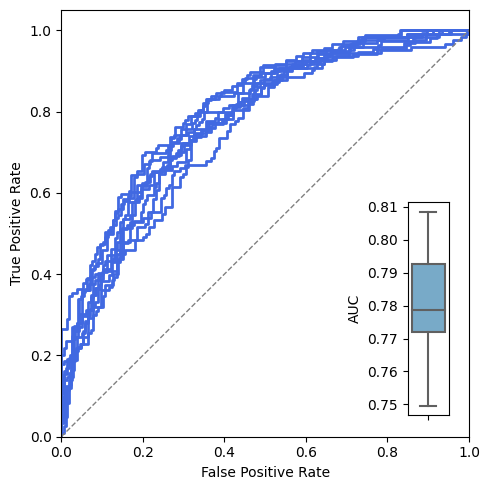

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import auc

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# ROC Curves
# axs.set_title('ROC Curves for Different Folds')
auc_values = []

# Iterate over the folds
for fold in np.arange(1, 11):
    # Get the FPR and TPR values for the current fold
    fpr_seq = df.loc[df['fold'] == fold, 'FPR'].values
    tpr_seq = df.loc[df['fold'] == fold, 'TPR'].values

    fpr = np.array(fpr_seq[0].tolist())
    tpr = np.array(tpr_seq[0].tolist())

    roc_auc = auc(fpr, tpr)
    auc_values.append(roc_auc)

    axs.plot(fpr, tpr, color='royalblue',lw=2)

    # # Plot ROC curve with a different color for each fold
    # axs.plot(fpr, tpr, lw=2, label='Fold %d' % (fold))

# Plot the random guess line
axs.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set the limits and labels of the ROC plot
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')

# Calculate the position for the embedded box plot
box_left = 0.85
box_bottom = 0.05
box_width = 0.1
box_height = 0.5

# Create an inset axes within the current axes
ax_box = axs.inset_axes([box_left, box_bottom, box_width, box_height])

# Use seaborn boxplot
sns.boxplot(y=auc_values, ax=ax_box, palette="Blues")
# ax_box.set_xlabel('Folds')
ax_box.set_ylabel('AUC')

# Add a y-axis to the box plot
# ax_box.axhline(y=np.mean(auc_values), color='r', linestyle='--', label='Mean AUC')
# ax_box.legend(loc='best')

plt.tight_layout()
plt.show()

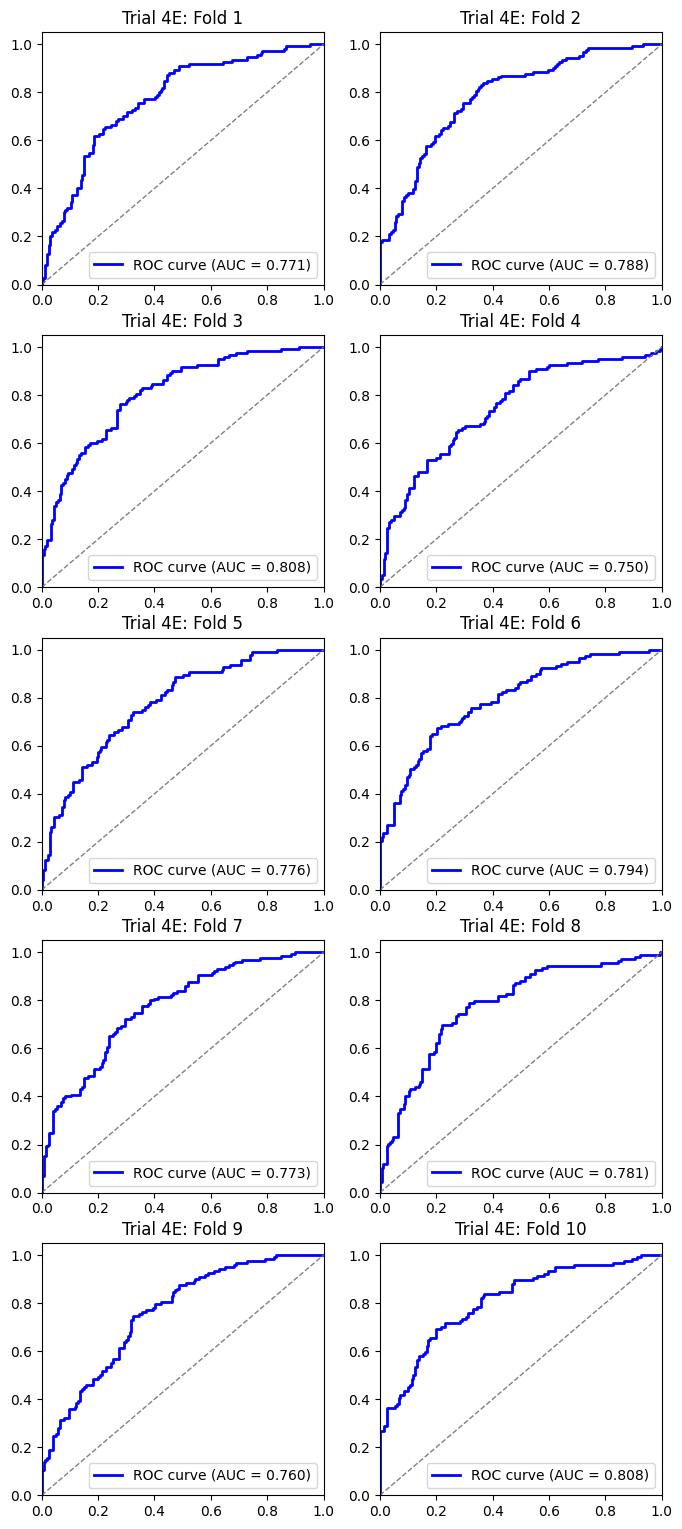

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

n = 0 

np.random.seed(42)

fig, axs = plt.subplots(5, 2, figsize=(8, 19))

for fold in np.arange(1,11,1):
    n = fold-1

    # Get the FPR and TPR values for the current fold
    fpr_seq = df.loc[df['fold'] == fold, 'FPR'].values
    tpr_seq = df.loc[df['fold'] == fold, 'TPR'].values

    fpr = np.array(fpr_seq[0].tolist())
    tpr = np.array(tpr_seq[0].tolist())

    roc_auc = auc(fpr,tpr)

    # Plot ROC curve
    row = n // 2
    col = n % 2
    axs[row, col].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
    axs[row, col].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axs[row, col].set_xlim([0.0, 1.0])
    axs[row, col].set_ylim([0.0, 1.05])
    # axs[row, col].set_xlabel('False Positive Rate', fontsize=14)
    # axs[row, col].set_ylabel('True Positive Rate', fontsize=14)
    axs[row, col].set_title('Trial 4E: Fold %d' % (n+1), fontsize=12)
    axs[row, col].legend(loc='lower right')
    
    optimal_threshold = thresholds[np.argmax(tpr - fpr)]
    # print(optimal_threshold)
    n += 1

# Hide x and y axis labels for certain subplots
if row != 4 or col != 0:
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylabel('')
else:
    axs[row, col].set_xlabel('False Positive Rate', fontsize=10)
    axs[row, col].set_ylabel('True Positive Rate', fontsize=10)


# axs[4, 1].axis('off')
# axs[4, 1].xaxis.set_visible(False)
# axs[4, 1].yaxis.set_visible(False)
# plt.show()